In [1]:
import sys, os, argparse, time, numpy as np, tensorflow as tf, pandas as pd
"""
Do the following if using colab
1. Download this notebook and upload to colab as your entry point
2. Uncomment the code below
"""
#!git clone https://github.com/Temiloluwa/leo_segmentation.git --branch leo_maml_tensorflow
#os.chdir(os.path.join("./leo_segmentation")) 
from leo_segmentation.data import Datagenerator, TrainingStats
from leo_segmentation.model import LEO, load_model, save_model
from leo_segmentation.utils import load_config, check_experiment, get_named_dict, \
                        log_data, load_yaml, train_logger, val_logger, print_to_string_io, \
                        save_pickled_data, model_dir, list_to_tensor, numpy_to_tensor, prepare_inputs,\
                        tensor_to_numpy
from run import train_model
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

c:\users\temil\onedrive\documents\codes_and_scripts\python_envs\pytorch-tf2-env\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\temil\onedrive\documents\codes_and_scripts\python_envs\pytorch-tf2-env\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\users\temil\onedrive\documents\codes_and_scripts\python_envs\pytorch-tf2-env\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
dataset ="fss1000"
config = load_config()

## Train Model

In [3]:
leo = train_model(config, dataset)

num tasks: 5
tr_imgs shape: torch.Size([5, 2, 224, 224, 3]), tr_masks shape: torch.Size([5, 2, 224, 224]) val_imgs shape: torch.Size([5, 5, 224, 224, 3]), val_masks shape: torch.Size([5, 5, 224, 224])


C:\Users\temil\OneDrive\Documents\Study\UHildesheim\Project\Scripts\leo-srp-project\merge_to_dev\leo_segmentation\leo_segmentation\model.py:212: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  ..\aten\src\ATen\native\TensorIterator.cpp:918.)
  weight = self.seg_weight - finetuning_lr * seg_weight_grad
0it [00:00, ?it/s]

num tasks: 5
tr_imgs shape: torch.Size([5, 2, 224, 224, 3]), tr_masks shape: torch.Size([5, 2, 224, 224]) val_imgs shape: 5 list of paths, val_masks shape: 5 list of paths


8it [00:00, 26.94it/s]
8it [00:00, 29.65it/s]
8it [00:00, 28.65it/s]
8it [00:00, 27.87it/s]
18it [00:00, 36.50it/s]


mode: meta_val, episode:  01, total_val_loss: 0.672228, 
val_mean_iou:{'peregine_falcon': 0.2812792849659027,
'persimmon': 0.11125786755846223,
'poker': 0.12237070220672347,
'pspgo': 0.43500854500661906,
'rock_snake': 0.2716242363462845}

Episode: 1, Episode Time: 0.088 minutes


28it [00:00, 38.97it/s]
8it [00:00, 29.61it/s]
8it [00:00, 29.76it/s]
28it [00:00, 36.32it/s]
8it [00:00, 28.11it/s]


mode: meta_val, episode:  02, total_val_loss: 0.647152, 
val_mean_iou:{'owl': 0.1576628563670115,
'potato': 0.051695239469391675,
'proboscis': 0.07515964316836315,
'santa_sledge': 0.1964478184452584,
'skua': 0.3165342387336526}

Episode: 2, Episode Time: 0.081 minutes


8it [00:00, 29.33it/s]
8it [00:00, 31.01it/s]
8it [00:00, 31.41it/s]
8it [00:00, 28.68it/s]
8it [00:00, 31.03it/s]


mode: meta_val, episode:  03, total_val_loss: 0.614237, 
val_mean_iou:{'refrigerator': 0.06730852319774142,
'rock_beauty': 0.044104595797004785,
'running_shoe': 0.06921137309588563,
'sandal': 0.2650919133875278,
'scorpion': 0.2709122404102756}

Episode: 3, Episode Time: 0.064 minutes


8it [00:00, 31.28it/s]
8it [00:00, 40.30it/s]
8it [00:00, 30.08it/s]
8it [00:00, 29.31it/s]
18it [00:00, 36.93it/s]


mode: meta_val, episode:  04, total_val_loss: 0.616039, 
val_mean_iou:{'printer': 0.0408473296542176,
'rabbit': 0.012217558529448206,
'radio': 0.03779514603433862,
'radio_telescope': 0.029640262624387827,
'snow_leopard': 0.057277334589094654}

Episode: 4, Episode Time: 0.068 minutes


8it [00:00, 27.88it/s]
8it [00:00, 30.36it/s]
8it [00:00, 31.91it/s]
8it [00:00, 30.64it/s]
8it [00:00, 30.20it/s]


mode: meta_val, episode:  05, total_val_loss: 0.555336, 
val_mean_iou:{'panpipe': 0.0448582552533761,
'pinwheel': 0.05370486203378409,
'pyraminx': 0.060549346408231654,
'refrigerator': 0.01458078508858271,
'sombrero': 0.011270165364962979}

Episode: 5, Episode Time: 0.065 minutes


8it [00:00, 29.44it/s]
18it [00:00, 37.75it/s]
8it [00:00, 31.64it/s]
8it [00:00, 31.18it/s]
8it [00:00, 31.33it/s]


mode: meta_val, episode:  06, total_val_loss: 0.499000, 
val_mean_iou:{'park_bench': 0.01134911334467691,
'pickelhaube': 0.03781739196851949,
'pig': 0.0111120925423334,
'ruffed_grouse': 0.03776907152854797,
'sea_cucumber': 0.00839077211113513}

Episode: 6, Episode Time: 0.068 minutes


8it [00:00, 29.45it/s]
8it [00:00, 31.41it/s]
8it [00:00, 30.78it/s]
8it [00:00, 30.57it/s]
8it [00:00, 30.71it/s]


mode: meta_val, episode:  07, total_val_loss: 0.462484, 
val_mean_iou:{'paddle': 0.013587626113204765,
'paper_towel': 0.0018796639366951075,
'pokermon_ball': 0.13421209488989672,
'quail_egg': 0.1384440654289416,
'shopping_cart': 0.06399952989007829}

Episode: 7, Episode Time: 0.063 minutes


8it [00:00, 29.44it/s]
8it [00:00, 30.69it/s]
8it [00:00, 29.72it/s]
8it [00:00, 30.70it/s]
8it [00:00, 31.03it/s]


mode: meta_val, episode:  08, total_val_loss: 0.371058, 
val_mean_iou:{'pizza': 0.012622844705311205,
'puma_logo': 0.06532332037073206,
'santa_sledge': 0.09421529088548167,
'shift_gear': 0.047329213758526716,
'shower_cap': 0.15760015738773125}

Episode: 8, Episode Time: 0.063 minutes


8it [00:00, 29.95it/s]
8it [00:00, 29.04it/s]
18it [00:00, 35.90it/s]
8it [00:00, 28.35it/s]
8it [00:00, 27.79it/s]


mode: meta_val, episode:  09, total_val_loss: 0.398409, 
val_mean_iou:{'otter': 0.07636392056630031,
'pepitas': 0.10087679325525326,
'poker': 0.15661245563128157,
'sea_urchin': 0.14045911161913205,
'snowball': 0.040071719737837186}

Episode: 9, Episode Time: 0.069 minutes


8it [00:00, 27.26it/s]
8it [00:00, 31.65it/s]
8it [00:00, 33.27it/s]
8it [00:00, 28.03it/s]
8it [00:00, 30.98it/s]


mode: meta_val, episode:  10, total_val_loss: 0.405087, 
val_mean_iou:{'parthenon': 0.08890631331960831,
'persian_cat': 0.0301404973391641,
'seagull': 0.15892633833653041,
'shuriken': 0.19070248276953347,
'snow_leopard': 0.15381169741936565}

Episode: 10, Episode Time: 0.065 minutes


58it [00:01, 40.06it/s]
8it [00:00, 29.93it/s]
8it [00:00, 29.80it/s]
8it [00:00, 29.62it/s]
8it [00:00, 30.03it/s]


mode: meta_val, episode:  11, total_val_loss: 0.326058, 
val_mean_iou:{'pingpong_ball': 0.027170538878388273,
'pistachio': 0.25672266505387004,
'rally_car': 0.15563521537184263,
'ringlet_butterfly': 0.24517829176703348,
'snake': 0.14385078449239128}

Episode: 11, Episode Time: 0.083 minutes


28it [00:00, 38.62it/s]
8it [00:00, 31.97it/s]
8it [00:00, 30.42it/s]
8it [00:00, 29.09it/s]
8it [00:00, 30.12it/s]


mode: meta_val, episode:  12, total_val_loss: 0.375526, 
val_mean_iou:{'panda': 0.19500272274457514,
'pingpong_racket': 0.30394524586956867,
'quill_pen': 0.22670275331909648,
'rock_snake': 0.1747069117773078,
'rocking_chair': 0.17609202382170416}

Episode: 12, Episode Time: 0.071 minutes


8it [00:00, 30.98it/s]
38it [00:00, 40.68it/s]
8it [00:00, 31.61it/s]
28it [00:00, 37.74it/s]
8it [00:00, 30.89it/s]


mode: meta_val, episode:  13, total_val_loss: 0.343835, 
val_mean_iou:{'paper_plane': 0.061648589388094505,
'park_bench': 0.06446942276221462,
'potato': 0.12244999053786862,
'raft': 0.3349343462188549,
'sock': 0.20352650683771967}

Episode: 13, Episode Time: 0.083 minutes


8it [00:00, 32.66it/s]
8it [00:00, 31.57it/s]
18it [00:00, 37.79it/s]
8it [00:00, 31.29it/s]
8it [00:00, 30.94it/s]


mode: meta_val, episode:  14, total_val_loss: 0.304757, 
val_mean_iou:{'patas': 0.11935003739650996,
'pufferfish': 0.22629467591971708,
'redheart': 0.1255964855815025,
'screw': 0.4217413122049258,
'sea_urchin': 0.3574992819685221}

Episode: 14, Episode Time: 0.066 minutes


8it [00:00, 30.64it/s]
8it [00:00, 31.51it/s]
8it [00:00, 31.80it/s]
8it [00:00, 29.54it/s]
8it [00:00, 30.08it/s]


mode: meta_val, episode:  15, total_val_loss: 0.429448, 
val_mean_iou:{'phonograph': 0.27664679485758203,
'polecat': 0.31408093578049384,
'prayer_rug': 0.14701259656554314,
'recreational_vehicle': 0.19644192183478607,
'roller_coaster': 0.3274820624312121}

Episode: 15, Episode Time: 0.063 minutes


8it [00:00, 30.24it/s]
8it [00:00, 29.94it/s]
8it [00:00, 30.55it/s]
8it [00:00, 30.18it/s]
8it [00:00, 31.71it/s]


mode: meta_val, episode:  16, total_val_loss: 0.332135, 
val_mean_iou:{'pyraminx': 0.2701972328022762,
'rock_beauty': 0.1927424794765123,
'samarra_mosque': 0.15934268327506174,
'sidewinder': 0.17412177054511674,
'sniper_rifle': 0.23994675195225787}

Episode: 16, Episode Time: 0.064 minutes


18it [00:00, 35.75it/s]
28it [00:00, 40.00it/s]
8it [00:00, 31.08it/s]
8it [00:00, 30.96it/s]
8it [00:00, 27.72it/s]


mode: meta_val, episode:  17, total_val_loss: 0.400167, 
val_mean_iou:{'owl': 0.2521984489989161,
'peregine_falcon': 0.45371987593146923,
'poker': 0.3617858903382733,
'pyramid_cube': 0.23009823068958718,
'sewing_machine': 0.17945963348712185}

Episode: 17, Episode Time: 0.077 minutes


8it [00:00, 32.09it/s]
8it [00:00, 29.11it/s]
8it [00:00, 29.17it/s]
8it [00:00, 30.07it/s]
8it [00:00, 32.64it/s]


mode: meta_val, episode:  18, total_val_loss: 0.391288, 
val_mean_iou:{'pencil_sharpener2': 0.1595506611880391,
'pizza': 0.16865119130337197,
'redheart': 0.1383833956290507,
'roller_coaster': 0.3987408618499364,
'shih-tzu': 0.09648060521342798}

Episode: 18, Episode Time: 0.065 minutes


8it [00:00, 30.21it/s]
8it [00:00, 31.25it/s]
8it [00:00, 30.39it/s]
8it [00:00, 31.84it/s]
8it [00:00, 28.04it/s]


mode: meta_val, episode:  19, total_val_loss: 0.346883, 
val_mean_iou:{'paper_plane': 0.08512993152332579,
'partridge': 0.48696581488410384,
'perfume': 0.19790767937402753,
'printer': 0.20353186873751697,
'revolver': 0.20537967729025514}

Episode: 19, Episode Time: 0.064 minutes


8it [00:00, 31.02it/s]
8it [00:00, 28.94it/s]
8it [00:00, 30.90it/s]
8it [00:00, 30.67it/s]
8it [00:00, 30.13it/s]


mode: meta_val, episode:  20, total_val_loss: 0.379559, 
val_mean_iou:{'pickup': 0.4317113027928654,
'pool_table': 0.18879723964231335,
'relay_stick': 0.15992575977665383,
'rhinoceros': 0.3776696840878558,
'sandal': 0.44774074407002334}

Episode: 20, Episode Time: 0.064 minutes


8it [00:00, 28.66it/s]
8it [00:00, 30.13it/s]
8it [00:00, 28.95it/s]
8it [00:00, 30.63it/s]
8it [00:00, 27.90it/s]


mode: meta_val, episode:  21, total_val_loss: 0.348893, 
val_mean_iou:{'peregine_falcon': 0.5113339411766441,
'pidan': 0.5050268614030882,
'pingpong_racket': 0.5522452867295972,
'pomelo': 0.1630858733309229,
'ringlet_butterfly': 0.7528016948759679}

Episode: 21, Episode Time: 0.065 minutes


8it [00:00, 30.19it/s]
8it [00:00, 30.50it/s]
8it [00:00, 31.61it/s]
8it [00:00, 32.49it/s]
8it [00:00, 29.59it/s]


mode: meta_val, episode:  22, total_val_loss: 0.328096, 
val_mean_iou:{'pencil_sharpener2': 0.21878254522187074,
'poached_egg': 0.09660439598149445,
'puma_logo': 0.11460783595367573,
'rubick_cube': 0.5299162375875651,
'shower_cap': 0.3041125357626146}

Episode: 22, Episode Time: 0.064 minutes


8it [00:00, 29.72it/s]
8it [00:00, 30.06it/s]
8it [00:00, 31.64it/s]
8it [00:00, 31.40it/s]
8it [00:00, 30.81it/s]


mode: meta_val, episode:  23, total_val_loss: 0.318199, 
val_mean_iou:{'panpipe': 0.3668080044640023,
'puma_logo': 0.08871722533932239,
'raccoon': 0.49878276393432697,
'red_breasted_merganser': 0.563966192486208,
'soap_dispenser': 0.22273087094229888}

Episode: 23, Episode Time: 0.064 minutes


8it [00:00, 29.99it/s]
8it [00:00, 31.27it/s]
8it [00:00, 31.10it/s]
8it [00:00, 31.20it/s]
8it [00:00, 29.10it/s]


mode: meta_val, episode:  24, total_val_loss: 0.384367, 
val_mean_iou:{'pretzel': 0.2790604248754334,
'rock_beauty': 0.4373361489177895,
'rocket': 0.1897651121643779,
'shotgun': 0.4192263234112296,
'shumai': 0.18471633290132156}

Episode: 24, Episode Time: 0.064 minutes


8it [00:00, 30.44it/s]
8it [00:00, 30.22it/s]
8it [00:00, 30.99it/s]
8it [00:00, 29.91it/s]
8it [00:00, 30.20it/s]


mode: meta_val, episode:  25, total_val_loss: 0.397471, 
val_mean_iou:{'petri_dish': 0.2563521417569083,
'plate': 0.058069402735558884,
'redshank': 0.4837595709905872,
'sea_urchin': 0.5852802251726541,
'snowman': 0.20359763167752287}

Episode: 25, Episode Time: 0.064 minutes


8it [00:00, 28.07it/s]
8it [00:00, 29.90it/s]
8it [00:00, 30.08it/s]
8it [00:00, 31.48it/s]
8it [00:00, 31.65it/s]


mode: meta_val, episode:  26, total_val_loss: 0.444941, 
val_mean_iou:{'photocopier': 0.18083309317096546,
'platypus': 0.5077824040435743,
'radiator': 0.09175296360531757,
'red_fox': 0.5409524890500497,
'rock_snake': 0.4212447230086022}

Episode: 26, Episode Time: 0.064 minutes


8it [00:00, 29.54it/s]
8it [00:00, 30.70it/s]
8it [00:00, 30.38it/s]
18it [00:00, 37.12it/s]
8it [00:00, 30.51it/s]


mode: meta_val, episode:  27, total_val_loss: 0.397440, 
val_mean_iou:{'papaya': 0.41791822680653895,
'polar_bear': 0.322268514183419,
'pomegranate': 0.5179834277302335,
'radio': 0.3323724932792763,
'refrigerator': 0.1895411894382486}

Episode: 27, Episode Time: 0.067 minutes


18it [00:00, 35.84it/s]
8it [00:00, 28.97it/s]
8it [00:00, 31.20it/s]
8it [00:00, 32.79it/s]
8it [00:00, 30.61it/s]


mode: meta_val, episode:  28, total_val_loss: 0.284510, 
val_mean_iou:{'quill_pen': 0.4416919736417559,
'red_fox': 0.5478148377240382,
'saxophone': 0.46397142787075,
'scabbard': 0.28377194137697653,
'sled': 0.5143073750747863}

Episode: 28, Episode Time: 0.068 minutes


18it [00:00, 33.47it/s]
8it [00:00, 30.43it/s]
8it [00:00, 30.52it/s]
8it [00:00, 28.74it/s]
8it [00:00, 29.68it/s]


mode: meta_val, episode:  29, total_val_loss: 0.291661, 
val_mean_iou:{'panther': 0.7055164873980897,
'puma_logo': 0.11043642183636766,
'scabbard': 0.2866280773064528,
'shotgun': 0.4006133866515025,
'soap': 0.18316566309232474}

Episode: 29, Episode Time: 0.068 minutes


8it [00:00, 28.98it/s]
8it [00:00, 30.68it/s]
8it [00:00, 28.20it/s]
8it [00:00, 30.45it/s]
8it [00:00, 29.60it/s]


mode: meta_val, episode:  30, total_val_loss: 0.375838, 
val_mean_iou:{'panpipe': 0.43152120771399316,
'saltshaker': 0.25681104563068924,
'scroll_brush': 0.4187432568585581,
'shih-tzu': 0.2307103479943723,
'sleeping_bag': 0.20278646998561478}

Episode: 30, Episode Time: 0.064 minutes


8it [00:00, 30.74it/s]
8it [00:00, 29.31it/s]
8it [00:00, 29.66it/s]
8it [00:00, 31.88it/s]
8it [00:00, 31.03it/s]


mode: meta_val, episode:  31, total_val_loss: 0.536949, 
val_mean_iou:{'pretzel': 0.3070695942906795,
'pspgo': 0.3239673950823927,
'remote_control': 0.5690896580263478,
'sandbar': 0.08749925192144378,
'scarerow': 0.3086220593938971}

Episode: 31, Episode Time: 0.064 minutes


8it [00:00, 28.95it/s]
8it [00:00, 30.88it/s]
8it [00:00, 32.84it/s]
8it [00:00, 29.57it/s]
8it [00:00, 31.33it/s]


mode: meta_val, episode:  32, total_val_loss: 0.308209, 
val_mean_iou:{'pay_phone': 0.2889780285784259,
'recreational_vehicle': 0.3527200315578234,
'scroll_brush': 0.4610991430017263,
'skateboard': 0.19163004388148752,
'soap_dispenser': 0.3074570870749647}

Episode: 32, Episode Time: 0.064 minutes


28it [00:00, 38.77it/s]
8it [00:00, 31.43it/s]
8it [00:00, 30.32it/s]
8it [00:00, 31.57it/s]
18it [00:00, 33.40it/s]


mode: meta_val, episode:  33, total_val_loss: 0.406615, 
val_mean_iou:{'panda': 0.5276037279837977,
'psp': 0.3949261063840379,
'raccoon': 0.5201550614417456,
'reel': 0.6406149430352237,
'remote_control': 0.5904420452465786}

Episode: 33, Episode Time: 0.076 minutes


8it [00:00, 29.39it/s]
8it [00:00, 29.76it/s]
18it [00:00, 36.75it/s]
8it [00:00, 30.18it/s]
8it [00:00, 31.12it/s]


mode: meta_val, episode:  34, total_val_loss: 0.401560, 
val_mean_iou:{'pool_table': 0.2333013842909089,
'puma_logo': 0.12137141333250845,
'rice_cooker': 0.28672935346046524,
'ruffed_grouse': 0.570612024924868,
'seal': 0.6217892919639444}

Episode: 34, Episode Time: 0.068 minutes


8it [00:00, 30.15it/s]
8it [00:00, 29.30it/s]
8it [00:00, 31.16it/s]
18it [00:00, 36.46it/s]
8it [00:00, 31.25it/s]


mode: meta_val, episode:  35, total_val_loss: 0.355873, 
val_mean_iou:{'paper_crane': 0.4320420227044672,
'red_wolf': 0.3639619277281843,
'reflex_camera': 0.5815114935381871,
'rice_cooker': 0.30761003522292735,
'soap': 0.23716676372686857}

Episode: 35, Episode Time: 0.068 minutes


8it [00:00, 29.09it/s]
8it [00:00, 30.66it/s]
8it [00:00, 29.44it/s]
8it [00:00, 30.86it/s]
18it [00:00, 37.04it/s]


mode: meta_val, episode:  36, total_val_loss: 0.290387, 
val_mean_iou:{'persian_cat': 0.10352342140795427,
'rain_barrel': 0.4497887559302302,
'skua': 0.7161750709496733,
'sled': 0.5218927952717866,
'sloth_bear': 0.6643728666539217}

Episode: 36, Episode Time: 0.068 minutes


128it [00:03, 41.79it/s]
8it [00:00, 30.70it/s]
8it [00:00, 30.33it/s]
8it [00:00, 30.01it/s]
8it [00:00, 30.03it/s]


mode: meta_val, episode:  37, total_val_loss: 0.294579, 
val_mean_iou:{'ostrich': 0.6481274868722405,
'ox': 0.49908024518159433,
'paint_brush': 0.6171117124211717,
'park_bench': 0.31264255189149315,
'pyramid_cube': 0.3937438461160182}

Episode: 37, Episode Time: 0.111 minutes


8it [00:00, 30.16it/s]
8it [00:00, 30.99it/s]
8it [00:00, 30.86it/s]
8it [00:00, 31.54it/s]
8it [00:00, 30.29it/s]


mode: meta_val, episode:  38, total_val_loss: 0.367667, 
val_mean_iou:{'paint_brush': 0.6426332759860163,
'pool_table': 0.27827852976321055,
'running_shoe': 0.3145630670445515,
'sandbar': 0.13278120104351515,
'sniper_rifle': 0.5120984355580691}

Episode: 38, Episode Time: 0.063 minutes


8it [00:00, 29.75it/s]
8it [00:00, 31.56it/s]
8it [00:00, 30.27it/s]
8it [00:00, 31.01it/s]
28it [00:00, 37.99it/s]


mode: meta_val, episode:  39, total_val_loss: 0.262027, 
val_mean_iou:{'partridge': 0.5982466364706862,
'pinwheel': 0.5522864892936916,
'polecat': 0.6588970103946292,
'pyramid': 0.4334244555272502,
'rugby_ball': 0.2831501531479555}

Episode: 39, Episode Time: 0.071 minutes


28it [00:00, 39.07it/s]
8it [00:00, 30.95it/s]
8it [00:00, 30.21it/s]
8it [00:00, 30.40it/s]
8it [00:00, 31.49it/s]


mode: meta_val, episode:  40, total_val_loss: 0.350644, 
val_mean_iou:{'owl': 0.46130401288400324,
'phonograph': 0.5999936242848461,
'pingpong_racket': 0.6178843282194311,
'pool_table': 0.31510418128292444,
'ringlet_butterfly': 0.7903596340886672}

Episode: 40, Episode Time: 0.071 minutes


8it [00:00, 29.15it/s]
8it [00:00, 29.53it/s]
8it [00:00, 31.75it/s]
28it [00:00, 40.50it/s]
8it [00:00, 30.56it/s]


mode: meta_val, episode:  41, total_val_loss: 0.393213, 
val_mean_iou:{'owl': 0.44535078568684583,
'peacock': 0.46544236275524664,
'pool_table': 0.2965404716375019,
'remote_control': 0.6119171729064137,
'rock_beauty': 0.6721004524632186}

Episode: 41, Episode Time: 0.071 minutes


8it [00:00, 25.79it/s]
8it [00:00, 29.12it/s]
8it [00:00, 29.39it/s]
8it [00:00, 30.79it/s]
8it [00:00, 28.80it/s]


mode: meta_val, episode:  42, total_val_loss: 0.328592, 
val_mean_iou:{'paddle': 0.591885569534002,
'police_car': 0.39371605169520585,
'radio_telescope': 0.47552909504016405,
'shift_gear': 0.23672477271500258,
'sock': 0.4974768391795147}

Episode: 42, Episode Time: 0.065 minutes


8it [00:00, 31.27it/s]
8it [00:00, 30.37it/s]
8it [00:00, 29.61it/s]
8it [00:00, 30.66it/s]
8it [00:00, 30.68it/s]


mode: meta_val, episode:  43, total_val_loss: 0.280095, 
val_mean_iou:{'persimmon': 0.638802664888403,
'pingpong_racket': 0.5811015542767246,
'pomegranate': 0.5794009024181991,
'redheart': 0.12571841048893295,
'snail': 0.5511739263684587}

Episode: 43, Episode Time: 0.064 minutes


8it [00:00, 29.15it/s]
8it [00:00, 29.85it/s]
8it [00:00, 30.03it/s]
8it [00:00, 29.81it/s]
8it [00:00, 31.13it/s]


mode: meta_val, episode:  44, total_val_loss: 0.247812, 
val_mean_iou:{'ostrich': 0.6040835049839586,
'prairie_chicken': 0.7161643736170715,
'proboscis': 0.45609734603731505,
'saluki': 0.4421877639293077,
'scissors': 0.5846040848986822}

Episode: 44, Episode Time: 0.064 minutes


8it [00:00, 27.97it/s]
8it [00:00, 30.46it/s]
8it [00:00, 27.64it/s]
8it [00:00, 29.65it/s]
18it [00:00, 37.25it/s]


mode: meta_val, episode:  45, total_val_loss: 0.366687, 
val_mean_iou:{'pool_table': 0.29387612925726236,
'projector': 0.30901318319375704,
'pubg_airdrop': 0.3804534889018037,
'pumpkin': 0.7236157472483007,
'rocking_chair': 0.5578499863247017}

Episode: 45, Episode Time: 0.068 minutes


8it [00:00, 28.20it/s]
8it [00:00, 30.78it/s]
8it [00:00, 29.11it/s]
8it [00:00, 30.42it/s]
8it [00:00, 32.07it/s]


mode: meta_val, episode:  46, total_val_loss: 0.395189, 
val_mean_iou:{'plastic_bag': 0.20146636752390315,
'polo_shirt': 0.3067335380348621,
'screwdriver': 0.6090170228655659,
'shakuhachi': 0.3638156538525169,
'sombrero': 0.3900501649113872}

Episode: 46, Episode Time: 0.064 minutes


8it [00:00, 27.75it/s]
8it [00:00, 29.89it/s]
8it [00:00, 30.60it/s]
8it [00:00, 30.56it/s]
8it [00:00, 30.79it/s]


mode: meta_val, episode:  47, total_val_loss: 0.283177, 
val_mean_iou:{'panther': 0.714824370564463,
'perfume': 0.43821254432009493,
'pubg_lvl3helmet': 0.37211744756625065,
'rally_car': 0.5643846801632917,
'red_bayberry': 0.6572728921541984}

Episode: 47, Episode Time: 0.064 minutes


8it [00:00, 30.48it/s]
8it [00:00, 29.30it/s]
8it [00:00, 30.78it/s]
8it [00:00, 31.39it/s]
8it [00:00, 30.63it/s]


mode: meta_val, episode:  48, total_val_loss: 0.332969, 
val_mean_iou:{'partridge': 0.6313280718786134,
'petri_dish': 0.41301496303807583,
'plaice': 0.6433935566771637,
'polo_shirt': 0.36663047232597806,
'skull': 0.5689182768088767}

Episode: 48, Episode Time: 0.064 minutes


8it [00:00, 29.61it/s]
18it [00:00, 37.85it/s]
8it [00:00, 30.00it/s]
8it [00:00, 30.96it/s]
8it [00:00, 29.40it/s]


mode: meta_val, episode:  49, total_val_loss: 0.315497, 
val_mean_iou:{'polecat': 0.6456262038897729,
'polo_shirt': 0.3172279889242887,
'pomelo': 0.4534288370833248,
'quail': 0.6144137928948176,
'sombrero': 0.3510620887538426}

Episode: 49, Episode Time: 0.068 minutes


8it [00:00, 29.90it/s]
8it [00:00, 32.55it/s]
8it [00:00, 30.66it/s]
8it [00:00, 30.11it/s]
8it [00:00, 31.27it/s]


mode: meta_val, episode:  50, total_val_loss: 0.325157, 
val_mean_iou:{'petri_dish': 0.5270090033495768,
'ruffed_grouse': 0.682701544289957,
'sewing_machine': 0.3354865526915306,
'skateboard': 0.23004455098651783,
'snowmobile': 0.46441908041532043}

Episode: 50, Episode Time: 0.064 minutes


8it [00:00, 27.20it/s]
8it [00:00, 30.68it/s]
8it [00:00, 30.65it/s]
8it [00:00, 31.42it/s]
8it [00:00, 31.66it/s]


mode: meta_val, episode:  51, total_val_loss: 0.282254, 
val_mean_iou:{'ostrich': 0.6096946341914186,
'poached_egg': 0.1981597424720602,
'pomelo': 0.5430653693742984,
'red_wolf': 0.48588782155534915,
'ski_mask': 0.38824151151379743}

Episode: 51, Episode Time: 0.064 minutes


18it [00:00, 35.94it/s]
8it [00:00, 29.38it/s]
8it [00:00, 30.54it/s]
18it [00:00, 36.63it/s]
8it [00:00, 29.81it/s]


mode: meta_val, episode:  52, total_val_loss: 0.378072, 
val_mean_iou:{'parthenon': 0.5082042388240322,
'poker': 0.43608597944125094,
'polo_shirt': 0.3013284597014606,
'red_breasted_merganser': 0.6309077954426742,
'sandwich': 0.5008412181717143}

Episode: 52, Episode Time: 0.072 minutes


8it [00:00, 29.40it/s]
8it [00:00, 30.69it/s]
8it [00:00, 29.99it/s]
18it [00:00, 37.57it/s]
8it [00:00, 29.60it/s]


mode: meta_val, episode:  53, total_val_loss: 0.302642, 
val_mean_iou:{'paper_towel': 0.05141025190317362,
'parking_meter': 0.5869845949701381,
'pig': 0.45860408362359895,
'polar_bear': 0.5780035967368743,
'sarong': 0.4262325337005494}

Episode: 53, Episode Time: 0.068 minutes


8it [00:00, 29.50it/s]
8it [00:00, 29.64it/s]
8it [00:00, 30.73it/s]
8it [00:00, 29.47it/s]
8it [00:00, 29.27it/s]


mode: meta_val, episode:  54, total_val_loss: 0.503176, 
val_mean_iou:{'pizza': 0.5056540498757861,
'pool_table': 0.3884900738894454,
'pteropus': 0.7148811037378824,
'rosehip': 0.3940429271802439,
'shower_curtain': 0.22444781075552467}

Episode: 54, Episode Time: 0.065 minutes


8it [00:00, 30.82it/s]
8it [00:00, 29.87it/s]
8it [00:00, 28.81it/s]
8it [00:00, 27.73it/s]
8it [00:00, 31.77it/s]


mode: meta_val, episode:  55, total_val_loss: 0.379046, 
val_mean_iou:{'pencil_box': 0.27511334310540947,
'photocopier': 0.39587350085103834,
'pteropus': 0.7262347938481837,
'scabbard': 0.24940222976393475,
'sniper_rifle': 0.5536299848490557}

Episode: 55, Episode Time: 0.065 minutes


8it [00:00, 30.91it/s]
8it [00:00, 30.27it/s]
8it [00:00, 29.77it/s]
8it [00:00, 30.13it/s]
38it [00:00, 39.69it/s]


mode: meta_val, episode:  56, total_val_loss: 0.259899, 
val_mean_iou:{'peregine_falcon': 0.7286135506866208,
'raft': 0.5702789472365559,
'sandwich_cookies': 0.5000671689719021,
'screwdriver': 0.6145252779668929,
'shuriken': 0.43605054689411626}

Episode: 56, Episode Time: 0.076 minutes


8it [00:00, 28.28it/s]
8it [00:00, 29.52it/s]
8it [00:00, 30.44it/s]
8it [00:00, 30.71it/s]
8it [00:00, 29.69it/s]


mode: meta_val, episode:  57, total_val_loss: 0.274335, 
val_mean_iou:{'pencil_sharpener1': 0.6332855941183522,
'pidan': 0.7155498585303399,
'porcupine': 0.6443947402809029,
'proboscis': 0.5785272118251316,
'sealion': 0.8188121013083848}

Episode: 57, Episode Time: 0.065 minutes


8it [00:00, 28.31it/s]
8it [00:00, 30.00it/s]
8it [00:00, 29.55it/s]
8it [00:00, 30.93it/s]
8it [00:00, 31.42it/s]


mode: meta_val, episode:  58, total_val_loss: 0.243763, 
val_mean_iou:{'pubg_lvl3helmet': 0.34911514629336093,
'radio_telescope': 0.41787032941943747,
'scissors': 0.5230314478058329,
'siamang': 0.7424547172497081,
'skua': 0.6693568224012351}

Episode: 58, Episode Time: 0.064 minutes


8it [00:00, 30.54it/s]
8it [00:00, 30.79it/s]
88it [00:02, 42.83it/s]
18it [00:00, 36.88it/s]
8it [00:00, 31.25it/s]


mode: meta_val, episode:  59, total_val_loss: 0.296640, 
val_mean_iou:{'pen': 0.4393012165073955,
'pill_bottle': 0.3320661828844399,
'quail': 0.6581975202906998,
'ringlet_butterfly': 0.8526063860729237,
'sleeping_bag': 0.30857189900290577}

Episode: 59, Episode Time: 0.097 minutes


8it [00:00, 30.99it/s]
8it [00:00, 31.02it/s]
8it [00:00, 29.56it/s]
8it [00:00, 30.01it/s]
8it [00:00, 30.95it/s]


mode: meta_val, episode:  60, total_val_loss: 0.243119, 
val_mean_iou:{'pill_bottle': 0.2936321918784457,
'potted_plant': 0.6854528225940724,
'saltshaker': 0.35996091361321436,
'samarra_mosque': 0.5145981344674233,
'skull': 0.550986374251879}

Episode: 60, Episode Time: 0.064 minutes


8it [00:00, 29.34it/s]
8it [00:00, 30.48it/s]
8it [00:00, 30.97it/s]
8it [00:00, 31.22it/s]
8it [00:00, 33.85it/s]


mode: meta_val, episode:  61, total_val_loss: 0.234853, 
val_mean_iou:{'peregine_falcon': 0.7180868378368617,
'pickelhaube': 0.6643355798019352,
'saxophone': 0.49126282710504626,
'scissors': 0.6092387154778425,
'shakuhachi': 0.4788164456156394}

Episode: 61, Episode Time: 0.064 minutes


8it [00:00, 30.20it/s]
8it [00:00, 31.19it/s]
8it [00:00, 30.32it/s]
18it [00:00, 37.51it/s]
18it [00:00, 36.07it/s]


mode: meta_val, episode:  62, total_val_loss: 0.295302, 
val_mean_iou:{'pig': 0.446962044823542,
'pomegranate': 0.6479252766814376,
'rock_beauty': 0.6983798688424495,
'sandbar': 0.1485163088870317,
'soap': 0.2935913860495519}

Episode: 62, Episode Time: 0.071 minutes


8it [00:00, 29.68it/s]
8it [00:00, 29.88it/s]
8it [00:00, 31.39it/s]
8it [00:00, 31.52it/s]
8it [00:00, 32.17it/s]


mode: meta_val, episode:  63, total_val_loss: 0.362417, 
val_mean_iou:{'panpipe': 0.5679838957365353,
'pillow': 0.10214741891232533,
'quad_drone': 0.3916776548852242,
'snail': 0.4835887537906886,
'snowball': 0.1573370704129115}

Episode: 63, Episode Time: 0.063 minutes


8it [00:00, 31.62it/s]
8it [00:00, 29.56it/s]
8it [00:00, 29.15it/s]
8it [00:00, 31.65it/s]
8it [00:00, 31.23it/s]


mode: meta_val, episode:  64, total_val_loss: 0.372411, 
val_mean_iou:{'paper_plane': 0.11413538284389062,
'paper_towel': 0.03777763868528577,
'rain_barrel': 0.49051166266204843,
'saltshaker': 0.3602159142612381,
'seatbelt': 0.07385674444947378}

Episode: 64, Episode Time: 0.064 minutes


8it [00:00, 30.71it/s]
8it [00:00, 29.55it/s]
8it [00:00, 32.08it/s]
8it [00:00, 31.29it/s]
8it [00:00, 30.56it/s]


mode: meta_val, episode:  65, total_val_loss: 0.284898, 
val_mean_iou:{'panpipe': 0.6045013591144217,
'pingpong_racket': 0.6784019058657149,
'printer': 0.45422225242704917,
'rosehip': 0.42753426564738994,
'samarra_mosque': 0.5564364518595597}

Episode: 65, Episode Time: 0.063 minutes


8it [00:00, 29.88it/s]
18it [00:00, 37.28it/s]
28it [00:00, 39.64it/s]
8it [00:00, 29.64it/s]
8it [00:00, 30.80it/s]


mode: meta_val, episode:  66, total_val_loss: 0.273615, 
val_mean_iou:{'panda': 0.583827812717237,
'persian_cat': 0.22226401968469625,
'pickup': 0.704575788617035,
'polecat': 0.6482613313290437,
'razor': 0.4606267115502711}

Episode: 66, Episode Time: 0.075 minutes


8it [00:00, 29.83it/s]
8it [00:00, 30.64it/s]
8it [00:00, 30.94it/s]
8it [00:00, 28.69it/s]
8it [00:00, 30.20it/s]


mode: meta_val, episode:  67, total_val_loss: 0.352956, 
val_mean_iou:{'poached_egg': 0.22939784513627803,
'pool_table': 0.3759813393405097,
'rubick_cube': 0.7392186455385925,
'shower_cap': 0.3043484387428941,
'snowball': 0.17230780672800453}

Episode: 67, Episode Time: 0.064 minutes


8it [00:00, 28.32it/s]
8it [00:00, 31.15it/s]
8it [00:00, 29.63it/s]
8it [00:00, 30.00it/s]
8it [00:00, 30.90it/s]


mode: meta_val, episode:  68, total_val_loss: 0.327414, 
val_mean_iou:{'paint_brush': 0.6762810602440794,
'patas': 0.45990723377840886,
'porcupine': 0.656467140207326,
'roller_coaster': 0.4895036788303216,
'solar_dish': 0.35484530437249606}

Episode: 68, Episode Time: 0.064 minutes


8it [00:00, 28.76it/s]
8it [00:00, 30.16it/s]
8it [00:00, 31.49it/s]
8it [00:00, 30.17it/s]
8it [00:00, 32.76it/s]


mode: meta_val, episode:  69, total_val_loss: 0.290691, 
val_mean_iou:{'peanut': 0.5030322386581757,
'pidan': 0.6787561314331436,
'reel': 0.7196608785110024,
'rhinoceros': 0.7367336646924265,
'saltshaker': 0.3999372486046754}

Episode: 69, Episode Time: 0.064 minutes


8it [00:00, 30.37it/s]
8it [00:00, 29.82it/s]
8it [00:00, 31.67it/s]
8it [00:00, 29.74it/s]
8it [00:00, 30.62it/s]


mode: meta_val, episode:  70, total_val_loss: 0.241986, 
val_mean_iou:{'red_fox': 0.7381874763813071,
'ringlet_butterfly': 0.831079656420272,
'shovel': 0.5197498140953971,
'sidewinder': 0.6236589788515758,
'snowmobile': 0.47984357726424215}

Episode: 70, Episode Time: 0.064 minutes


8it [00:00, 29.64it/s]
8it [00:00, 30.61it/s]
8it [00:00, 29.76it/s]
8it [00:00, 31.23it/s]
8it [00:00, 31.15it/s]


mode: meta_val, episode:  71, total_val_loss: 0.259709, 
val_mean_iou:{'pencil_sharpener1': 0.6904038643727667,
'poached_egg': 0.22869237723211866,
'puma_logo': 0.08677251255082619,
'radio_telescope': 0.5100869987315603,
'rock_beauty': 0.680517459203716}

Episode: 71, Episode Time: 0.064 minutes


8it [00:00, 31.16it/s]
8it [00:00, 31.88it/s]
8it [00:00, 31.26it/s]
8it [00:00, 31.48it/s]
28it [00:00, 37.48it/s]


mode: meta_val, episode:  72, total_val_loss: 0.290224, 
val_mean_iou:{'phonograph': 0.6980969418555146,
'police_car': 0.4890848847030942,
'pomelo': 0.6021778727584681,
'pyramid': 0.49795350957779466,
'redheart': 0.16302160012199984}

Episode: 72, Episode Time: 0.072 minutes


8it [00:00, 29.71it/s]
8it [00:00, 31.47it/s]
28it [00:00, 39.31it/s]
8it [00:00, 31.19it/s]
8it [00:00, 31.23it/s]


mode: meta_val, episode:  73, total_val_loss: 0.333345, 
val_mean_iou:{'owl': 0.5031823352334223,
'peacock': 0.6028621274437655,
'police_car': 0.469941833193196,
'pteropus': 0.6875121753225182,
'radio_telescope': 0.4782236047384759}

Episode: 73, Episode Time: 0.071 minutes


18it [00:00, 37.99it/s]
8it [00:00, 31.49it/s]
8it [00:00, 29.20it/s]
8it [00:00, 29.42it/s]
8it [00:00, 30.11it/s]


mode: meta_val, episode:  74, total_val_loss: 0.311212, 
val_mean_iou:{'photocopier': 0.44398633358680284,
'pumpkin_pie': 0.7790698531836453,
'redshank': 0.454010187858593,
'screw': 0.5563133833580681,
'soccer_ball': 0.2916538232709859}

Episode: 74, Episode Time: 0.067 minutes


8it [00:00, 28.57it/s]
8it [00:00, 31.84it/s]
8it [00:00, 30.24it/s]
8it [00:00, 29.08it/s]
8it [00:00, 29.72it/s]


mode: meta_val, episode:  75, total_val_loss: 0.317468, 
val_mean_iou:{'pencil_box': 0.29673155223143294,
'pufferfish': 0.5223835390063083,
'radio_telescope': 0.5067890891972986,
'rice_cooker': 0.38978385397512405,
'ruler': 0.33061408369851575}

Episode: 75, Episode Time: 0.064 minutes


8it [00:00, 31.46it/s]
8it [00:00, 28.91it/s]
8it [00:00, 30.03it/s]
8it [00:00, 28.86it/s]
8it [00:00, 31.04it/s]


mode: meta_val, episode:  76, total_val_loss: 0.364988, 
val_mean_iou:{'panpipe': 0.599093403426125,
'pspgo': 0.41820705339256187,
'pubg_lvl3backpack': 0.41403592584671894,
'pyramid_cube': 0.5110124042126976,
'radiator': 0.15303184389555863}

Episode: 76, Episode Time: 0.064 minutes


8it [00:00, 29.96it/s]
8it [00:00, 30.04it/s]
8it [00:00, 30.09it/s]
8it [00:00, 33.24it/s]
8it [00:00, 28.90it/s]


mode: meta_val, episode:  77, total_val_loss: 0.232054, 
val_mean_iou:{'platypus': 0.6845442173512603,
'pokermon_ball': 0.700462849956756,
'red_wolf': 0.6017740504700618,
'sealion': 0.7573379919137796,
'skua': 0.760536307354226}

Episode: 77, Episode Time: 0.064 minutes


8it [00:00, 27.95it/s]
8it [00:00, 32.27it/s]
8it [00:00, 32.26it/s]
8it [00:00, 29.62it/s]
18it [00:00, 36.35it/s]


mode: meta_val, episode:  78, total_val_loss: 0.251706, 
val_mean_iou:{'phonograph': 0.7242799302392211,
'polecat': 0.6176899313006735,
'rose': 0.6276338358862639,
'seatbelt': 0.063144377116098,
'ski_mask': 0.4399820679843434}

Episode: 78, Episode Time: 0.068 minutes


8it [00:00, 28.65it/s]
8it [00:00, 28.52it/s]
8it [00:00, 29.72it/s]
8it [00:00, 30.76it/s]
8it [00:00, 30.99it/s]


mode: meta_val, episode:  79, total_val_loss: 0.390206, 
val_mean_iou:{'pencil_sharpener2': 0.47746013047989966,
'petri_dish': 0.5629159167196007,
'rock_beauty': 0.7770148698239141,
'single_log': 0.08535915627249087,
'smoothing_iron': 0.27962799505880176}

Episode: 79, Episode Time: 0.064 minutes


8it [00:00, 29.15it/s]
8it [00:00, 30.49it/s]
8it [00:00, 30.77it/s]
8it [00:00, 25.56it/s]
18it [00:00, 39.65it/s]


mode: meta_val, episode:  80, total_val_loss: 0.338933, 
val_mean_iou:{'puma_logo': 0.10238030976189065,
'reel': 0.638082081604729,
'rock_snake': 0.5519407384332592,
'ski_mask': 0.5187817276428256,
'sled': 0.5678236731424802}

Episode: 80, Episode Time: 0.068 minutes


8it [00:00, 28.39it/s]
8it [00:00, 27.37it/s]
8it [00:00, 30.96it/s]
8it [00:00, 30.68it/s]
8it [00:00, 30.37it/s]


mode: meta_val, episode:  81, total_val_loss: 0.358514, 
val_mean_iou:{'park_bench': 0.46120732771890244,
'pepitas': 0.6467474678978548,
'pheasant': 0.6851543943352687,
'shih-tzu': 0.5097697997742145,
'sleeping_bag': 0.39793718892063346}

Episode: 81, Episode Time: 0.064 minutes


8it [00:00, 31.21it/s]
8it [00:00, 28.17it/s]
28it [00:00, 40.12it/s]
8it [00:00, 29.53it/s]
8it [00:00, 29.08it/s]


mode: meta_val, episode:  82, total_val_loss: 0.435319, 
val_mean_iou:{'panda': 0.5682846654738231,
'parthenon': 0.5610219832235995,
'pidan': 0.6670481698417176,
'saxophone': 0.49326434509894723,
'shumai': 0.47967342562691784}

Episode: 82, Episode Time: 0.072 minutes


8it [00:00, 29.60it/s]
8it [00:00, 31.03it/s]
8it [00:00, 31.41it/s]
8it [00:00, 30.08it/s]
18it [00:00, 37.37it/s]


mode: meta_val, episode:  83, total_val_loss: 0.285016, 
val_mean_iou:{'pig': 0.5634784003403204,
'pokermon_ball': 0.6998111648788788,
'printer': 0.5349130932943393,
'quad_drone': 0.47642131475022487,
'radiator': 0.20921908906483191}

Episode: 83, Episode Time: 0.067 minutes


8it [00:00, 28.86it/s]
8it [00:00, 29.34it/s]
8it [00:00, 31.27it/s]
8it [00:00, 31.62it/s]
8it [00:00, 30.54it/s]


mode: meta_val, episode:  84, total_val_loss: 0.384425, 
val_mean_iou:{'prayer_rug': 0.5685051530723391,
'pufferfish': 0.5927403128476556,
'puma_logo': 0.10283291202708997,
'rubick_cube': 0.7715076027945479,
'shopping_cart': 0.5397314643265883}

Episode: 84, Episode Time: 0.064 minutes


8it [00:00, 29.75it/s]
8it [00:00, 29.51it/s]
8it [00:00, 29.19it/s]
8it [00:00, 30.04it/s]
8it [00:00, 30.98it/s]


mode: meta_val, episode:  85, total_val_loss: 0.397720, 
val_mean_iou:{'otter': 0.7775908609860336,
'pspgo': 0.33653044137763377,
'pubg_lvl3helmet': 0.43698717439110313,
'roller_skate': 0.600955784503278,
'rugby_ball': 0.47424227359191307}

Episode: 85, Episode Time: 0.064 minutes


28it [00:00, 38.53it/s]
8it [00:00, 30.47it/s]
8it [00:00, 28.27it/s]
8it [00:00, 28.18it/s]
8it [00:00, 31.20it/s]


mode: meta_val, episode:  86, total_val_loss: 0.358646, 
val_mean_iou:{'panda': 0.609743857311236,
'pencil_sharpener2': 0.5358972015231143,
'rice_cooker': 0.38118248782621345,
'ruler': 0.4080059019678186,
'sandwich_cookies': 0.6574900048772012}

Episode: 86, Episode Time: 0.072 minutes


8it [00:00, 29.18it/s]
8it [00:00, 26.80it/s]
8it [00:00, 30.94it/s]
8it [00:00, 30.43it/s]
8it [00:00, 31.22it/s]


mode: meta_val, episode:  87, total_val_loss: 0.283720, 
val_mean_iou:{'paint_brush': 0.7202707406732507,
'persian_cat': 0.3846366290366581,
'poached_egg': 0.3531276250652058,
'police_car': 0.5347193357173329,
'remote_control': 0.6460781435155832}

Episode: 87, Episode Time: 0.065 minutes


8it [00:00, 29.94it/s]
8it [00:00, 30.25it/s]
8it [00:00, 30.68it/s]
8it [00:00, 31.04it/s]
8it [00:00, 32.04it/s]


mode: meta_val, episode:  88, total_val_loss: 0.282230, 
val_mean_iou:{'pingpong_racket': 0.6753920775729494,
'proboscis': 0.7124805500982987,
'red_wolf': 0.6945561929351833,
'sandbar': 0.1724757858119708,
'seagull': 0.5473801193560446}

Episode: 88, Episode Time: 0.064 minutes


8it [00:00, 30.76it/s]
8it [00:00, 29.33it/s]
8it [00:00, 31.88it/s]
8it [00:00, 30.21it/s]
18it [00:00, 35.91it/s]


mode: meta_val, episode:  89, total_val_loss: 0.284728, 
val_mean_iou:{'pig': 0.6353109987188051,
'pingpong_racket': 0.6402983175394992,
'poached_egg': 0.36980254181294614,
'pteropus': 0.701951086874899,
'schooner': 0.5243172393905617}

Episode: 89, Episode Time: 0.067 minutes


8it [00:00, 28.59it/s]
18it [00:00, 35.73it/s]
8it [00:00, 31.20it/s]
8it [00:00, 29.12it/s]
8it [00:00, 30.37it/s]


mode: meta_val, episode:  90, total_val_loss: 0.286696, 
val_mean_iou:{'pistachio': 0.6164350013573894,
'pomegranate': 0.7211500257964949,
'potato_chips': 0.6544335799698505,
'rose': 0.5929580310327138,
'sniper_rifle': 0.46632795316008624}

Episode: 90, Episode Time: 0.068 minutes


8it [00:00, 31.04it/s]
8it [00:00, 30.70it/s]
8it [00:00, 27.66it/s]
8it [00:00, 30.96it/s]
8it [00:00, 31.45it/s]


mode: meta_val, episode:  91, total_val_loss: 0.300544, 
val_mean_iou:{'peregine_falcon': 0.6739939773943182,
'pickelhaube': 0.7643020960896661,
'pidan': 0.7273441969107313,
'saltshaker': 0.49973919455540866,
'shovel': 0.3799784920661508}

Episode: 91, Episode Time: 0.064 minutes


8it [00:00, 30.28it/s]
8it [00:00, 28.80it/s]
8it [00:00, 29.12it/s]
8it [00:00, 31.55it/s]
8it [00:00, 30.92it/s]


mode: meta_val, episode:  92, total_val_loss: 0.389298, 
val_mean_iou:{'parallel_bars': 0.1682825740443209,
'pizza': 0.7214769536843662,
'pomegranate': 0.7321563071577555,
'prayer_rug': 0.6836466564124146,
'printer': 0.5269306521449479}

Episode: 92, Episode Time: 0.064 minutes


18it [00:00, 37.19it/s]
8it [00:00, 32.90it/s]
8it [00:00, 30.04it/s]
8it [00:00, 30.62it/s]
8it [00:00, 31.43it/s]


mode: meta_val, episode:  93, total_val_loss: 0.315746, 
val_mean_iou:{'peacock': 0.6074574267883597,
'polo_shirt': 0.3768967257771436,
'pomelo': 0.6809212020429944,
'proboscis': 0.7022272111139741,
'screw': 0.5727423399925864}

Episode: 93, Episode Time: 0.067 minutes


8it [00:00, 29.38it/s]
8it [00:00, 30.48it/s]
8it [00:00, 31.66it/s]
8it [00:00, 29.85it/s]
8it [00:00, 30.52it/s]


mode: meta_val, episode:  94, total_val_loss: 0.358105, 
val_mean_iou:{'pool_table': 0.4923487143792071,
'pubg_airdrop': 0.5965087643749971,
'radiator': 0.3549330958383643,
'samarra_mosque': 0.6892990784266956,
'skull': 0.7776430975292983}

Episode: 94, Episode Time: 0.064 minutes


8it [00:00, 29.94it/s]
18it [00:00, 35.15it/s]
8it [00:00, 30.59it/s]
8it [00:00, 31.25it/s]
8it [00:00, 31.57it/s]


mode: meta_val, episode:  95, total_val_loss: 0.472756, 
val_mean_iou:{'paddle': 0.5438647894220469,
'parthenon': 0.6033247004906177,
'perfume': 0.5637188399150616,
'psp': 0.5561102254485716,
'skateboard': 0.23059604015634894}

Episode: 95, Episode Time: 0.068 minutes


8it [00:00, 28.96it/s]
8it [00:00, 29.61it/s]
8it [00:00, 29.69it/s]
8it [00:00, 30.67it/s]
8it [00:00, 31.52it/s]


mode: meta_val, episode:  96, total_val_loss: 0.252984, 
val_mean_iou:{'ostrich': 0.6363126848972105,
'pumpkin_pie': 0.7821414054406095,
'radiator': 0.36982157775269336,
'rally_car': 0.6950689340337548,
'sarong': 0.4325292451007242}

Episode: 96, Episode Time: 0.064 minutes


8it [00:00, 30.54it/s]
8it [00:00, 30.98it/s]
8it [00:00, 31.19it/s]
58it [00:01, 41.61it/s]
8it [00:00, 30.93it/s]


mode: meta_val, episode:  97, total_val_loss: 0.300365, 
val_mean_iou:{'patas': 0.6649016083616741,
'pizza': 0.7532332291065755,
'schooner': 0.6172149781368471,
'scissors': 0.5739312057746715,
'snake': 0.5795930073822155}

Episode: 97, Episode Time: 0.082 minutes


8it [00:00, 29.56it/s]
8it [00:00, 26.72it/s]
8it [00:00, 33.65it/s]
8it [00:00, 30.81it/s]
28it [00:00, 40.25it/s]


mode: meta_val, episode:  98, total_val_loss: 0.250799, 
val_mean_iou:{'owl': 0.6465312125234732,
'radio_telescope': 0.6796342638486828,
'recreational_vehicle': 0.6801038955252658,
'rhinoceros': 0.809684391846832,
'snowman': 0.5440168130720265}

Episode: 98, Episode Time: 0.071 minutes


8it [00:00, 30.16it/s]
8it [00:00, 31.27it/s]
8it [00:00, 30.77it/s]
8it [00:00, 31.23it/s]
8it [00:00, 31.32it/s]


mode: meta_val, episode:  99, total_val_loss: 0.239187, 
val_mean_iou:{'polecat': 0.7515829730751511,
'quill_pen': 0.3970904035777112,
'rocket': 0.24222117412192737,
'sarong': 0.4856702993135344,
'sea_urchin': 0.642954424873758}

Episode: 99, Episode Time: 0.063 minutes


8it [00:00, 29.13it/s]
8it [00:00, 30.15it/s]
8it [00:00, 31.29it/s]
8it [00:00, 30.26it/s]
8it [00:00, 30.67it/s]


mode: meta_val, episode:  100, total_val_loss: 0.507717, 
val_mean_iou:{'oyster': 0.5858012173944229,
'pencil_box': 0.6328470687310438,
'piano_keyboard': 0.3168083915682698,
'pteropus': 0.7334157971223455,
'redshank': 0.4864595581821657}

Episode: 100, Episode Time: 0.063 minutes
num tasks: 5
tr_imgs shape: torch.Size([5, 2, 224, 224, 3]), tr_masks shape: torch.Size([5, 2, 224, 224]) val_imgs shape: torch.Size([5, 5, 224, 224, 3]), val_masks shape: torch.Size([5, 5, 224, 224])


0it [00:00, ?it/s]

num tasks: 5
tr_imgs shape: torch.Size([5, 2, 224, 224, 3]), tr_masks shape: torch.Size([5, 2, 224, 224]) val_imgs shape: 5 list of paths, val_masks shape: 5 list of paths


8it [00:00, 28.43it/s]
8it [00:00, 29.39it/s]
28it [00:00, 38.94it/s]
8it [00:00, 31.34it/s]
28it [00:00, 38.96it/s]


mode: meta_val, episode:  101, total_val_loss: 0.244150, 
val_mean_iou:{'ostrich': 0.6536134844406447,
'panda': 0.7142641963849147,
'pyramid': 0.5782002494745623,
'pyramid_cube': 0.6571437025978554,
'radiator': 0.5007037861840888}

Episode: 101, Episode Time: 0.079 minutes


8it [00:00, 28.22it/s]
18it [00:00, 36.24it/s]
8it [00:00, 29.51it/s]
8it [00:00, 28.70it/s]
8it [00:00, 29.63it/s]


mode: meta_val, episode:  102, total_val_loss: 0.460002, 
val_mean_iou:{'paper_plane': 0.4084467564409627,
'piano_keyboard': 0.3489450817974129,
'power_drill': 0.6231153419598385,
'rally_car': 0.7639423884070424,
'soap': 0.5174219631251326}

Episode: 102, Episode Time: 0.070 minutes


8it [00:00, 29.90it/s]
8it [00:00, 29.52it/s]
8it [00:00, 29.88it/s]
8it [00:00, 29.82it/s]
88it [00:02, 43.59it/s]


mode: meta_val, episode:  103, total_val_loss: 0.292347, 
val_mean_iou:{'parthenon': 0.6593616131637802,
'pen': 0.5330130294100561,
'polecat': 0.7384046642481616,
'red_bayberry': 0.7635403148824986,
'scorpion': 0.6469474979048218}

Episode: 103, Episode Time: 0.094 minutes


18it [00:00, 36.92it/s]
8it [00:00, 30.52it/s]
8it [00:00, 30.41it/s]
8it [00:00, 32.86it/s]
8it [00:00, 28.78it/s]


mode: meta_val, episode:  104, total_val_loss: 0.287123, 
val_mean_iou:{'plaice': 0.7447800929317407,
'puma_logo': 0.14365711534165115,
'radiator': 0.5885088785361862,
'radio': 0.7243114485507222,
'reel': 0.7104493620463712}

Episode: 104, Episode Time: 0.067 minutes


8it [00:00, 29.65it/s]
8it [00:00, 29.84it/s]
18it [00:00, 35.81it/s]
8it [00:00, 30.59it/s]
8it [00:00, 33.00it/s]


mode: meta_val, episode:  105, total_val_loss: 0.271729, 
val_mean_iou:{'proboscis': 0.7596431553043436,
'redheart': 0.07359506405549765,
'revolver': 0.5965164520438775,
'sandal': 0.5638194069627698,
'soap': 0.5520676114305005}

Episode: 105, Episode Time: 0.068 minutes


8it [00:00, 29.86it/s]
8it [00:00, 29.73it/s]
8it [00:00, 30.92it/s]
8it [00:00, 30.66it/s]
8it [00:00, 30.10it/s]


mode: meta_val, episode:  106, total_val_loss: 0.225402, 
val_mean_iou:{'pear': 0.6740185409043629,
'pepitas': 0.6418616968045766,
'pokermon_ball': 0.742242134317463,
'quad_drone': 0.534191817376727,
'rubber_eraser': 0.5951980237506791}

Episode: 106, Episode Time: 0.064 minutes


8it [00:00, 29.23it/s]
8it [00:00, 29.59it/s]
8it [00:00, 31.98it/s]
18it [00:00, 38.14it/s]
8it [00:00, 30.22it/s]


mode: meta_val, episode:  107, total_val_loss: 0.264686, 
val_mean_iou:{'pyramid_cube': 0.6366575050598093,
'sandwich': 0.7157989587006902,
'school_bus': 0.6914930880971147,
'sealion': 0.8557314141873484,
'smoothing_iron': 0.6329832040983636}

Episode: 107, Episode Time: 0.067 minutes


8it [00:00, 31.39it/s]
8it [00:00, 30.79it/s]
8it [00:00, 31.41it/s]
8it [00:00, 28.95it/s]
8it [00:00, 29.06it/s]


mode: meta_val, episode:  108, total_val_loss: 0.244592, 
val_mean_iou:{'pencil_box': 0.6812543461655318,
'pubg_airdrop': 0.5686567068358742,
'pyraminx': 0.7153847321514775,
'seagull': 0.6237270556491621,
'shakuhachi': 0.3821421391616497}

Episode: 108, Episode Time: 0.064 minutes


8it [00:00, 28.64it/s]
8it [00:00, 27.51it/s]
8it [00:00, 31.78it/s]
8it [00:00, 28.45it/s]
8it [00:00, 29.43it/s]


mode: meta_val, episode:  109, total_val_loss: 0.301625, 
val_mean_iou:{'papaya': 0.8058918506138575,
'plate': 0.672439211469543,
'rubber_eraser': 0.6581343182204491,
'sea_cucumber': 0.7116747870871408,
'shift_gear': 0.24548088312564914}

Episode: 109, Episode Time: 0.066 minutes


8it [00:00, 28.77it/s]
8it [00:00, 30.62it/s]
8it [00:00, 30.65it/s]
8it [00:00, 29.45it/s]
8it [00:00, 29.25it/s]


mode: meta_val, episode:  110, total_val_loss: 0.353326, 
val_mean_iou:{'parachute': 0.6772586916772532,
'pidan': 0.7383303128449148,
'rock_snake': 0.6003907222385119,
'shopping_cart': 0.7366698658546887,
'shower_curtain': 0.5068148068331257}

Episode: 110, Episode Time: 0.066 minutes


8it [00:00, 29.23it/s]
8it [00:00, 28.18it/s]
38it [00:00, 39.89it/s]
8it [00:00, 31.42it/s]
8it [00:00, 30.91it/s]


mode: meta_val, episode:  111, total_val_loss: 0.220879, 
val_mean_iou:{'panther': 0.7447300329085963,
'paper_crane': 0.579215298951587,
'pingpong_racket': 0.6945748636544069,
'raft': 0.6811311055086112,
'rocking_chair': 0.7102013419437087}

Episode: 111, Episode Time: 0.076 minutes


8it [00:00, 29.35it/s]
8it [00:00, 29.69it/s]
8it [00:00, 31.93it/s]
18it [00:00, 37.03it/s]
8it [00:00, 30.82it/s]


mode: meta_val, episode:  112, total_val_loss: 0.258052, 
val_mean_iou:{'perfume': 0.7839749172172645,
'pill_bottle': 0.6851160786208691,
'polo_shirt': 0.4728786106471352,
'razor': 0.4175093883836637,
'santa_sledge': 0.499299386532008}

Episode: 112, Episode Time: 0.068 minutes


8it [00:00, 30.78it/s]
8it [00:00, 31.56it/s]
8it [00:00, 29.64it/s]
8it [00:00, 29.20it/s]
8it [00:00, 30.11it/s]


mode: meta_val, episode:  113, total_val_loss: 0.235736, 
val_mean_iou:{'paint_brush': 0.6915234516002247,
'persimmon': 0.7460830415856692,
'sandal': 0.5741444981556949,
'scissors': 0.4328156506111195,
'shift_gear': 0.21092487179825914}

Episode: 113, Episode Time: 0.064 minutes


8it [00:00, 31.08it/s]
8it [00:00, 30.66it/s]
18it [00:00, 35.03it/s]
8it [00:00, 29.53it/s]
8it [00:00, 29.00it/s]


mode: meta_val, episode:  114, total_val_loss: 0.364788, 
val_mean_iou:{'persian_cat': 0.7569055883182287,
'porcupine': 0.7706641453330445,
'psp': 0.6417879927604263,
'sandbar': 0.23275269712537425,
'sombrero': 0.5701259365221665}

Episode: 114, Episode Time: 0.069 minutes


8it [00:00, 27.11it/s]
8it [00:00, 30.34it/s]
8it [00:00, 28.87it/s]
8it [00:00, 28.70it/s]
8it [00:00, 28.64it/s]


mode: meta_val, episode:  115, total_val_loss: 0.328107, 
val_mean_iou:{'peanut': 0.5813996221525519,
'pickup': 0.8416937376883666,
'pomelo': 0.7120325280181367,
'pool_table': 0.5493224752399162,
'quill_pen': 0.4032943345259489}

Episode: 115, Episode Time: 0.065 minutes


18it [00:00, 36.26it/s]
8it [00:00, 31.29it/s]
18it [00:00, 36.46it/s]
8it [00:00, 29.34it/s]
8it [00:00, 31.55it/s]


mode: meta_val, episode:  116, total_val_loss: 0.234946, 
val_mean_iou:{'ostrich': 0.6434927218435217,
'radio': 0.725214366796008,
'redshank': 0.40966086538140667,
'sandwich': 0.7380743251799718,
'saxophone': 0.5563694820389735}

Episode: 116, Episode Time: 0.073 minutes


8it [00:00, 29.54it/s]
8it [00:00, 28.93it/s]
8it [00:00, 30.99it/s]
8it [00:00, 30.73it/s]
8it [00:00, 31.75it/s]


mode: meta_val, episode:  117, total_val_loss: 0.266813, 
val_mean_iou:{'phonograph': 0.7038487388904917,
'poached_egg': 0.7299068998996255,
'power_drill': 0.6275507680399517,
'pubg_lvl3backpack': 0.4289415481812019,
'soccer_ball': 0.449587186422273}

Episode: 117, Episode Time: 0.064 minutes


8it [00:00, 30.28it/s]
8it [00:00, 30.36it/s]
8it [00:00, 30.12it/s]
8it [00:00, 30.21it/s]
8it [00:00, 31.44it/s]


mode: meta_val, episode:  118, total_val_loss: 0.240121, 
val_mean_iou:{'perfume': 0.7578293713084037,
'proboscis': 0.7813817651605266,
'roller_coaster': 0.41260215135866285,
'rugby_ball': 0.4633537711003677,
'siamang': 0.6125011957439344}

Episode: 118, Episode Time: 0.063 minutes


8it [00:00, 29.88it/s]
8it [00:00, 29.78it/s]
8it [00:00, 31.46it/s]
8it [00:00, 29.41it/s]
8it [00:00, 29.81it/s]


mode: meta_val, episode:  119, total_val_loss: 0.197818, 
val_mean_iou:{'ostrich': 0.5811760225962979,
'phonograph': 0.7179328153044692,
'pubg_airdrop': 0.6456256593096191,
'skull': 0.8883900937256595,
'snow_leopard': 0.667210457631087}

Episode: 119, Episode Time: 0.065 minutes


8it [00:00, 26.07it/s]
8it [00:00, 32.58it/s]
18it [00:00, 35.41it/s]
8it [00:00, 30.90it/s]
8it [00:00, 28.11it/s]


mode: meta_val, episode:  120, total_val_loss: 0.305806, 
val_mean_iou:{'pencil_sharpener2': 0.7998896162390379,
'plate': 0.7813816856690171,
'psp': 0.7073254063637027,
'pubg_lvl3backpack': 0.3691640081899714,
'samarra_mosque': 0.659304946684114}

Episode: 120, Episode Time: 0.069 minutes


8it [00:00, 30.40it/s]
8it [00:00, 30.76it/s]
8it [00:00, 29.86it/s]
8it [00:00, 31.33it/s]
8it [00:00, 29.76it/s]


mode: meta_val, episode:  121, total_val_loss: 0.257414, 
val_mean_iou:{'rabbit': 0.7856144122302244,
'recreational_vehicle': 0.7959174558144746,
'roller_coaster': 0.4066492598385987,
'saxophone': 0.4613582081794099,
'soccer_ball': 0.4717131284355401}

Episode: 121, Episode Time: 0.064 minutes


8it [00:00, 30.27it/s]
8it [00:00, 29.07it/s]
8it [00:00, 30.35it/s]
8it [00:00, 29.26it/s]
8it [00:00, 30.09it/s]


mode: meta_val, episode:  122, total_val_loss: 0.270666, 
val_mean_iou:{'parallel_bars': 0.21257250154349638,
'pear': 0.7065757752479771,
'power_drill': 0.6448123608494309,
'quail_egg': 0.7187791284831557,
'screwdriver': 0.58568686243196}

Episode: 122, Episode Time: 0.064 minutes


8it [00:00, 28.11it/s]
8it [00:00, 30.35it/s]
18it [00:00, 37.73it/s]
8it [00:00, 31.01it/s]
8it [00:00, 31.10it/s]


mode: meta_val, episode:  123, total_val_loss: 0.238560, 
val_mean_iou:{'pumpkin': 0.8162565224009662,
'rocking_chair': 0.7076387598791241,
'sandal': 0.47305660916707487,
'scarerow': 0.3658392726182974,
'snowplow': 0.7807683803552261}

Episode: 123, Episode Time: 0.068 minutes


8it [00:00, 29.75it/s]
8it [00:00, 28.93it/s]
18it [00:00, 35.75it/s]
8it [00:00, 28.59it/s]
8it [00:00, 29.38it/s]


mode: meta_val, episode:  124, total_val_loss: 0.270883, 
val_mean_iou:{'pepitas': 0.6938920798954875,
'police_car': 0.7314947282020471,
'redheart': 0.053480943429210226,
'reel': 0.7506903671827471,
'screw': 0.5495354071436395}

Episode: 124, Episode Time: 0.068 minutes


8it [00:00, 29.14it/s]
8it [00:00, 30.23it/s]
8it [00:00, 27.01it/s]
8it [00:00, 27.95it/s]
8it [00:00, 28.68it/s]


mode: meta_val, episode:  125, total_val_loss: 0.304378, 
val_mean_iou:{'panther': 0.7531325750280047,
'paper_crane': 0.6037083849885301,
'patas': 0.7294149873869791,
'plastic_bag': 0.530549299787036,
'reflex_camera': 0.7625726572748082}

Episode: 125, Episode Time: 0.066 minutes


8it [00:00, 30.20it/s]
8it [00:00, 30.55it/s]
8it [00:00, 30.42it/s]
8it [00:00, 30.55it/s]
8it [00:00, 29.21it/s]


mode: meta_val, episode:  126, total_val_loss: 0.264290, 
val_mean_iou:{'pheasant': 0.7109205699325065,
'quad_drone': 0.586938500947975,
'rice_cooker': 0.6448414851201514,
'sewing_machine': 0.504901322990492,
'snowplow': 0.7629379987335221}

Episode: 126, Episode Time: 0.064 minutes


8it [00:00, 28.60it/s]
8it [00:00, 29.74it/s]
8it [00:00, 29.86it/s]
18it [00:00, 35.25it/s]
18it [00:00, 36.39it/s]


mode: meta_val, episode:  127, total_val_loss: 0.229440, 
val_mean_iou:{'petri_dish': 0.7602243451188386,
'pig': 0.7581971352590335,
'ptarmigan': 0.7595262298890357,
'siamang': 0.6483099183382188,
'sled': 0.5476299158783248}

Episode: 127, Episode Time: 0.072 minutes


8it [00:00, 27.95it/s]
8it [00:00, 29.30it/s]
8it [00:00, 29.59it/s]
8it [00:00, 29.80it/s]
8it [00:00, 31.88it/s]


mode: meta_val, episode:  128, total_val_loss: 0.260427, 
val_mean_iou:{'otter': 0.8276500098970851,
'phonograph': 0.6984332560155548,
'pool_table': 0.5405930744765657,
'rocking_chair': 0.7339691334549694,
'ski_mask': 0.6602744176421387}

Episode: 128, Episode Time: 0.065 minutes


18it [00:00, 34.73it/s]
8it [00:00, 30.88it/s]
28it [00:00, 38.49it/s]
8it [00:00, 29.08it/s]
8it [00:00, 31.02it/s]


mode: meta_val, episode:  129, total_val_loss: 0.181400, 
val_mean_iou:{'ostrich': 0.7030957891549714,
'potato': 0.7339427258557552,
'rose': 0.6520292322347321,
'scorpion': 0.6396386381944643,
'seagull': 0.7658441620304978}

Episode: 129, Episode Time: 0.076 minutes


8it [00:00, 31.20it/s]
8it [00:00, 32.40it/s]
8it [00:00, 27.30it/s]
8it [00:00, 31.75it/s]
8it [00:00, 29.82it/s]


mode: meta_val, episode:  130, total_val_loss: 0.292458, 
val_mean_iou:{'parachute': 0.7242591036057314,
'polo_shirt': 0.402132955343276,
'pubg_lvl3helmet': 0.2773364388683569,
'red_bayberry': 0.7462306804995116,
'shih-tzu': 0.7313415349128065}

Episode: 130, Episode Time: 0.065 minutes


8it [00:00, 28.40it/s]
8it [00:00, 29.60it/s]
8it [00:00, 30.67it/s]
8it [00:00, 28.68it/s]
8it [00:00, 31.66it/s]


mode: meta_val, episode:  131, total_val_loss: 0.238833, 
val_mean_iou:{'panpipe': 0.6001077701296837,
'pencil_sharpener1': 0.7205210166762159,
'pill_bottle': 0.7712633384038307,
'prairie_chicken': 0.7910945723467095,
'single_log': 0.16975360798998684}

Episode: 131, Episode Time: 0.066 minutes


8it [00:00, 27.51it/s]
8it [00:00, 28.87it/s]
8it [00:00, 28.44it/s]
8it [00:00, 30.21it/s]
8it [00:00, 28.60it/s]


mode: meta_val, episode:  132, total_val_loss: 0.296845, 
val_mean_iou:{'otter': 0.8464702268672495,
'pretzel': 0.5559115052895542,
'pyramid_cube': 0.7579778161019031,
'shopping_cart': 0.6367730398105713,
'shovel': 0.5657870275253913}

Episode: 132, Episode Time: 0.067 minutes


8it [00:00, 27.51it/s]
8it [00:00, 29.59it/s]
8it [00:00, 27.34it/s]
8it [00:00, 29.68it/s]
8it [00:00, 29.59it/s]


mode: meta_val, episode:  133, total_val_loss: 0.240285, 
val_mean_iou:{'radiator': 0.63597040445654,
'rock_beauty': 0.7485164185245836,
'shower_cap': 0.37627681344846786,
'snail': 0.6130507967410156,
'snowball': 0.5252483631833196}

Episode: 133, Episode Time: 0.069 minutes


8it [00:00, 26.78it/s]
18it [00:00, 32.98it/s]
8it [00:00, 28.21it/s]
8it [00:00, 29.83it/s]
8it [00:00, 28.63it/s]


mode: meta_val, episode:  134, total_val_loss: 0.223930, 
val_mean_iou:{'panpipe': 0.6398656429217052,
'pumpkin': 0.8194438969445499,
'red_wolf': 0.7379737520819001,
'school_bus': 0.703349140873709,
'snowball': 0.5561470874735825}

Episode: 134, Episode Time: 0.072 minutes


8it [00:00, 28.42it/s]
8it [00:00, 29.01it/s]
8it [00:00, 30.88it/s]
8it [00:00, 31.27it/s]
8it [00:00, 30.57it/s]


mode: meta_val, episode:  135, total_val_loss: 0.202366, 
val_mean_iou:{'pepitas': 0.7092012327088831,
'persimmon': 0.7465544710754884,
'power_drill': 0.642037469770621,
'shih-tzu': 0.7893425725000649,
'snail': 0.6425884591581453}

Episode: 135, Episode Time: 0.065 minutes


8it [00:00, 31.49it/s]
8it [00:00, 29.56it/s]
8it [00:00, 29.83it/s]
8it [00:00, 30.12it/s]
28it [00:00, 38.16it/s]


mode: meta_val, episode:  136, total_val_loss: 0.320917, 
val_mean_iou:{'patas': 0.7286219824923569,
'pill_bottle': 0.7673348100342687,
'pillow': 0.5783381951539208,
'potato': 0.6948300708829069,
'shopping_cart': 0.7211797183420356}

Episode: 136, Episode Time: 0.072 minutes


8it [00:00, 31.28it/s]
8it [00:00, 29.61it/s]
88it [00:02, 42.46it/s]
8it [00:00, 28.84it/s]
8it [00:00, 29.97it/s]


mode: meta_val, episode:  137, total_val_loss: 0.266319, 
val_mean_iou:{'pen': 0.5987255736418595,
'platypus': 0.7654946300494606,
'printer': 0.7013070520637017,
'rally_car': 0.7992034851454668,
'single_log': 0.1914060094901962}

Episode: 137, Episode Time: 0.095 minutes


8it [00:00, 30.21it/s]
8it [00:00, 30.88it/s]
18it [00:00, 38.08it/s]
8it [00:00, 28.89it/s]
8it [00:00, 29.82it/s]


mode: meta_val, episode:  138, total_val_loss: 0.279451, 
val_mean_iou:{'park_bench': 0.5989864979693841,
'persian_cat': 0.794131301104168,
'petri_dish': 0.7148502232043856,
'potato_chips': 0.6667308888185846,
'radio': 0.788930331756069}

Episode: 138, Episode Time: 0.068 minutes


8it [00:00, 29.41it/s]
8it [00:00, 30.77it/s]
8it [00:00, 29.83it/s]
8it [00:00, 30.10it/s]
8it [00:00, 28.90it/s]


mode: meta_val, episode:  139, total_val_loss: 0.238688, 
val_mean_iou:{'patas': 0.7228336978922986,
'phonograph': 0.7861426376816867,
'pubg_lvl3backpack': 0.5067407698752474,
'redheart': 0.036185939281164065,
'samarra_mosque': 0.5971473308554083}

Episode: 139, Episode Time: 0.064 minutes


18it [00:00, 36.00it/s]
8it [00:00, 30.29it/s]
8it [00:00, 30.84it/s]
8it [00:00, 29.43it/s]
8it [00:00, 30.28it/s]


mode: meta_val, episode:  140, total_val_loss: 0.291800, 
val_mean_iou:{'perfume': 0.7531044289843097,
'pillow': 0.6339369867161713,
'pubg_airdrop': 0.6014114794418152,
'radio': 0.7667040091306411,
'roller_coaster': 0.3742054232616254}

Episode: 140, Episode Time: 0.068 minutes


8it [00:00, 28.32it/s]
8it [00:00, 28.71it/s]
18it [00:00, 35.34it/s]
8it [00:00, 30.44it/s]
8it [00:00, 30.16it/s]


mode: meta_val, episode:  141, total_val_loss: 0.225339, 
val_mean_iou:{'paddle': 0.7032738809096839,
'peanut': 0.6151570424078845,
'raven': 0.8415215717454214,
'samarra_mosque': 0.627940966981656,
'sandwich': 0.7299794628275343}

Episode: 141, Episode Time: 0.068 minutes


8it [00:00, 28.20it/s]
8it [00:00, 29.03it/s]
8it [00:00, 30.50it/s]
8it [00:00, 31.12it/s]
8it [00:00, 30.42it/s]


mode: meta_val, episode:  142, total_val_loss: 0.265284, 
val_mean_iou:{'peregine_falcon': 0.7737821297225373,
'quill_pen': 0.3739639370661998,
'sarong': 0.5414332290448595,
'sealion': 0.8698437333295548,
'shakuhachi': 0.39049697344975964}

Episode: 142, Episode Time: 0.064 minutes


8it [00:00, 29.67it/s]
8it [00:00, 28.35it/s]
18it [00:00, 36.66it/s]
8it [00:00, 28.40it/s]
8it [00:00, 29.38it/s]


mode: meta_val, episode:  143, total_val_loss: 0.257793, 
val_mean_iou:{'patas': 0.7501857242800454,
'peacock': 0.6353958007180576,
'platypus': 0.7706530449366124,
'rocking_chair': 0.7094965558980997,
'rose': 0.6132319674984673}

Episode: 143, Episode Time: 0.068 minutes


28it [00:00, 36.97it/s]
8it [00:00, 31.43it/s]
8it [00:00, 29.74it/s]
8it [00:00, 30.66it/s]
8it [00:00, 31.53it/s]


mode: meta_val, episode:  144, total_val_loss: 0.248623, 
val_mean_iou:{'owl': 0.7205563073918233,
'parking_meter': 0.7423928065695741,
'reflex_camera': 0.7571901419644876,
'rocket': 0.17658347017571613,
'saxophone': 0.5080596773123767}

Episode: 144, Episode Time: 0.072 minutes


8it [00:00, 30.52it/s]
8it [00:00, 31.23it/s]
8it [00:00, 30.13it/s]
8it [00:00, 30.13it/s]
8it [00:00, 29.60it/s]


mode: meta_val, episode:  145, total_val_loss: 0.289521, 
val_mean_iou:{'panpipe': 0.5418729026723859,
'scissors': 0.4466955865692319,
'shotgun': 0.37192014878485663,
'sleeping_bag': 0.701153666632558,
'sock': 0.634358009089218}

Episode: 145, Episode Time: 0.066 minutes


8it [00:00, 29.83it/s]
8it [00:00, 30.76it/s]
8it [00:00, 30.07it/s]
8it [00:00, 30.50it/s]
8it [00:00, 28.92it/s]


mode: meta_val, episode:  146, total_val_loss: 0.295900, 
val_mean_iou:{'police_car': 0.724588928475469,
'polo_shirt': 0.5312100027701465,
'saluki': 0.6391186618148872,
'siamang': 0.7232096775977018,
'sniper_rifle': 0.41841623690187457}

Episode: 146, Episode Time: 0.064 minutes


8it [00:00, 28.75it/s]
18it [00:00, 37.28it/s]
8it [00:00, 31.00it/s]
8it [00:00, 31.25it/s]
8it [00:00, 30.26it/s]


mode: meta_val, episode:  147, total_val_loss: 0.204487, 
val_mean_iou:{'pheasant': 0.7923351092149522,
'pyramid_cube': 0.7024900308451916,
'rose': 0.6309508189420296,
'scroll_brush': 0.6542387311574975,
'sniper_rifle': 0.4827061618416925}

Episode: 147, Episode Time: 0.068 minutes


8it [00:00, 30.39it/s]
8it [00:00, 32.73it/s]
8it [00:00, 29.73it/s]
8it [00:00, 31.27it/s]
8it [00:00, 30.51it/s]


mode: meta_val, episode:  148, total_val_loss: 0.307602, 
val_mean_iou:{'puma_logo': 0.22809490827188839,
'rain_barrel': 0.6058127874768529,
'sandal': 0.5000849813498734,
'seatbelt': 0.09869488300908921,
'skateboard': 0.20596715643478034}

Episode: 148, Episode Time: 0.064 minutes


8it [00:00, 29.39it/s]
8it [00:00, 30.20it/s]
8it [00:00, 32.40it/s]
8it [00:00, 29.95it/s]
8it [00:00, 29.77it/s]


mode: meta_val, episode:  149, total_val_loss: 0.217398, 
val_mean_iou:{'persian_cat': 0.7661725841217553,
'polecat': 0.7284177150270935,
'pufferfish': 0.8052950854810814,
'ruddy_turnstone': 0.6058744093893103,
'skateboard': 0.26774202435009853}

Episode: 149, Episode Time: 0.064 minutes


8it [00:00, 28.18it/s]
8it [00:00, 26.96it/s]
8it [00:00, 31.62it/s]
8it [00:00, 32.26it/s]
8it [00:00, 30.09it/s]


mode: meta_val, episode:  150, total_val_loss: 0.303663, 
val_mean_iou:{'ruler': 0.6164406320586056,
'running_shoe': 0.5278709631711231,
'sea_cucumber': 0.7268855971790797,
'sniper_rifle': 0.4893634583713756,
'soccer_ball': 0.4023733241451124}

Episode: 150, Episode Time: 0.065 minutes


8it [00:00, 28.55it/s]
8it [00:00, 31.30it/s]
8it [00:00, 30.15it/s]
8it [00:00, 30.69it/s]
8it [00:00, 29.54it/s]


mode: meta_val, episode:  151, total_val_loss: 0.209990, 
val_mean_iou:{'pinecone': 0.8626814038338274,
'police_car': 0.7384423474149224,
'rubber_eraser': 0.7123023669230584,
'skateboard': 0.23838826702296717,
'skull': 0.8593126337273428}

Episode: 151, Episode Time: 0.064 minutes


8it [00:00, 31.04it/s]
8it [00:00, 31.31it/s]
8it [00:00, 31.71it/s]
8it [00:00, 30.27it/s]
8it [00:00, 30.05it/s]


mode: meta_val, episode:  152, total_val_loss: 0.285725, 
val_mean_iou:{'persimmon': 0.6866088720167842,
'pumpkin_pie': 0.73576874136173,
'scissors': 0.519565274733176,
'sewing_machine': 0.49058095074591246,
'shakuhachi': 0.43149248463633}

Episode: 152, Episode Time: 0.063 minutes


8it [00:00, 29.11it/s]
8it [00:00, 31.29it/s]
8it [00:00, 29.81it/s]
8it [00:00, 27.94it/s]
8it [00:00, 31.86it/s]


mode: meta_val, episode:  153, total_val_loss: 0.391010, 
val_mean_iou:{'parthenon': 0.683255409555906,
'pistachio': 0.7062710555665095,
'poached_egg': 0.7806448234064365,
'pretzel': 0.5849669037851437,
'rocket': 0.29701444189811277}

Episode: 153, Episode Time: 0.064 minutes


8it [00:00, 28.48it/s]
8it [00:00, 29.64it/s]
8it [00:00, 31.25it/s]
18it [00:00, 36.58it/s]
8it [00:00, 32.14it/s]


mode: meta_val, episode:  154, total_val_loss: 0.288799, 
val_mean_iou:{'paint_brush': 0.722190435891068,
'poker': 0.7121980142844904,
'polar_bear': 0.8563800986720147,
'sandbar': 0.3094663429049018,
'seatbelt': 0.07742739644973186}

Episode: 154, Episode Time: 0.068 minutes


8it [00:00, 29.83it/s]
8it [00:00, 29.12it/s]
8it [00:00, 28.48it/s]
8it [00:00, 29.42it/s]
8it [00:00, 30.15it/s]


mode: meta_val, episode:  155, total_val_loss: 0.264767, 
val_mean_iou:{'paddle': 0.757307216161767,
'peacock': 0.6726512780404287,
'phonograph': 0.7681840526922816,
'potted_plant': 0.7492741309547273,
'raven': 0.7950581728599287}

Episode: 155, Episode Time: 0.065 minutes


8it [00:00, 28.39it/s]
8it [00:00, 30.10it/s]
8it [00:00, 29.16it/s]
8it [00:00, 31.44it/s]
8it [00:00, 29.31it/s]


mode: meta_val, episode:  156, total_val_loss: 0.239089, 
val_mean_iou:{'parking_meter': 0.6784602863405043,
'pear': 0.7195188843527243,
'pomegranate': 0.7620191121215307,
'quad_drone': 0.5488146778663838,
'scissors': 0.5010822593906425}

Episode: 156, Episode Time: 0.064 minutes


8it [00:00, 27.90it/s]
8it [00:00, 30.02it/s]
8it [00:00, 31.63it/s]
8it [00:00, 29.99it/s]
8it [00:00, 32.79it/s]


mode: meta_val, episode:  157, total_val_loss: 0.412799, 
val_mean_iou:{'park_bench': 0.5931516882465405,
'parthenon': 0.7132366117935246,
'pspgo': 0.5559394366555885,
'quad_drone': 0.5419149816001317,
'roller_skate': 0.8228864984491853}

Episode: 157, Episode Time: 0.064 minutes


8it [00:00, 29.64it/s]
8it [00:00, 30.26it/s]
18it [00:00, 36.33it/s]
8it [00:00, 30.13it/s]
8it [00:00, 32.08it/s]


mode: meta_val, episode:  158, total_val_loss: 0.230252, 
val_mean_iou:{'ostrich': 0.7195818597794379,
'prairie_chicken': 0.7384363320757634,
'quail': 0.7028782568758427,
'sandbar': 0.22584776792053726,
'snail': 0.6152294645478571}

Episode: 158, Episode Time: 0.068 minutes


8it [00:00, 29.32it/s]
8it [00:00, 28.14it/s]
8it [00:00, 30.81it/s]
8it [00:00, 30.57it/s]
88it [00:02, 43.01it/s]


mode: meta_val, episode:  159, total_val_loss: 0.247158, 
val_mean_iou:{'otter': 0.8449790039948524,
'peacock': 0.7351958762618246,
'pen': 0.5515437195299928,
'pickelhaube': 0.768203367223027,
'porcupine': 0.7046738524784253}

Episode: 159, Episode Time: 0.094 minutes


8it [00:00, 29.39it/s]
8it [00:00, 29.84it/s]
8it [00:00, 28.89it/s]
8it [00:00, 31.30it/s]
8it [00:00, 28.59it/s]


mode: meta_val, episode:  160, total_val_loss: 0.255447, 
val_mean_iou:{'ostrich': 0.7181112240896916,
'pyraminx': 0.6699574390519201,
'quill_pen': 0.40602078547591414,
'red_breasted_merganser': 0.63075177377869,
'sleeping_bag': 0.7488206193612947}

Episode: 160, Episode Time: 0.064 minutes


8it [00:00, 30.21it/s]
8it [00:00, 30.25it/s]
8it [00:00, 29.06it/s]
8it [00:00, 29.46it/s]
8it [00:00, 30.10it/s]


mode: meta_val, episode:  161, total_val_loss: 0.237095, 
val_mean_iou:{'paper_crane': 0.6102823538910407,
'parachute': 0.7032461896209501,
'pubg_lvl3helmet': 0.40991711908531503,
'scorpion': 0.602778738288698,
'shovel': 0.4633579455725402}

Episode: 161, Episode Time: 0.065 minutes


8it [00:00, 28.92it/s]
18it [00:00, 37.47it/s]
8it [00:00, 31.32it/s]
8it [00:00, 27.87it/s]
8it [00:00, 30.01it/s]


mode: meta_val, episode:  162, total_val_loss: 0.342169, 
val_mean_iou:{'peacock': 0.6768557031362084,
'razor': 0.4589248894589416,
'refrigerator': 0.5621612108700271,
'ruler': 0.6235222559661502,
'shumai': 0.6705883780814251}

Episode: 162, Episode Time: 0.068 minutes


8it [00:00, 29.59it/s]
8it [00:00, 30.60it/s]
8it [00:00, 31.46it/s]
8it [00:00, 30.20it/s]
8it [00:00, 31.30it/s]


mode: meta_val, episode:  163, total_val_loss: 0.294816, 
val_mean_iou:{'pingpong_ball': 0.13566185398702224,
'pinwheel': 0.7096786589227149,
'pomegranate': 0.7707004564919948,
'ptarmigan': 0.7768694951350013,
'seatbelt': 0.095790523036538}

Episode: 163, Episode Time: 0.064 minutes


8it [00:00, 31.18it/s]
8it [00:00, 30.55it/s]
8it [00:00, 27.90it/s]
8it [00:00, 31.34it/s]
8it [00:00, 29.92it/s]


mode: meta_val, episode:  164, total_val_loss: 0.367807, 
val_mean_iou:{'pistachio': 0.7230335654732326,
'plastic_bag': 0.5989918583307281,
'pool_table': 0.4916690496868191,
'potato_chips': 0.6520209866314708,
'red_breasted_merganser': 0.6490205170192304}

Episode: 164, Episode Time: 0.064 minutes


18it [00:00, 36.10it/s]
8it [00:00, 29.58it/s]
8it [00:00, 32.73it/s]
8it [00:00, 28.76it/s]
18it [00:00, 37.06it/s]


mode: meta_val, episode:  165, total_val_loss: 0.227824, 
val_mean_iou:{'remote_control': 0.5215268876648597,
'rose': 0.6146192539399636,
'rugby_ball': 0.6138388431456978,
'siamang': 0.6730955195757586,
'sled': 0.5805902600411001}

Episode: 165, Episode Time: 0.072 minutes


8it [00:00, 27.22it/s]
8it [00:00, 29.41it/s]
8it [00:00, 27.08it/s]
8it [00:00, 29.66it/s]
8it [00:00, 29.18it/s]


mode: meta_val, episode:  166, total_val_loss: 0.247650, 
val_mean_iou:{'pidan': 0.6968857108741883,
'pteropus': 0.6996029180097709,
'pubg_lvl3helmet': 0.389608968545279,
'red_fox': 0.7684233987261875,
'siamang': 0.6623849450189606}

Episode: 166, Episode Time: 0.066 minutes


8it [00:00, 29.92it/s]
8it [00:00, 31.21it/s]
18it [00:00, 35.92it/s]
8it [00:00, 30.27it/s]
8it [00:00, 31.33it/s]


mode: meta_val, episode:  167, total_val_loss: 0.273578, 
val_mean_iou:{'psp': 0.5818455614362201,
'saltshaker': 0.8065388260022581,
'seagull': 0.7194589571899429,
'shovel': 0.5440312244562143,
'ski_mask': 0.5967080991796082}

Episode: 167, Episode Time: 0.068 minutes


8it [00:00, 29.09it/s]
8it [00:00, 30.32it/s]
8it [00:00, 30.31it/s]
8it [00:00, 29.74it/s]
8it [00:00, 31.22it/s]


mode: meta_val, episode:  168, total_val_loss: 0.355368, 
val_mean_iou:{'pheasant': 0.8054098525183716,
'piano_keyboard': 0.38011211082703644,
'polecat': 0.716057640631725,
'police_car': 0.7232418878814542,
'shuriken': 0.4698188216260279}

Episode: 168, Episode Time: 0.064 minutes


8it [00:00, 30.41it/s]
8it [00:00, 31.01it/s]
8it [00:00, 29.68it/s]
8it [00:00, 31.12it/s]
8it [00:00, 29.61it/s]


mode: meta_val, episode:  169, total_val_loss: 0.246925, 
val_mean_iou:{'paint_brush': 0.6666110174953059,
'persimmon': 0.6943444210497449,
'printer': 0.6911094436007286,
'sloth_bear': 0.772641110779525,
'sombrero': 0.6001987310402582}

Episode: 169, Episode Time: 0.063 minutes


18it [00:00, 36.23it/s]
8it [00:00, 29.19it/s]
8it [00:00, 30.47it/s]
18it [00:00, 36.84it/s]
8it [00:00, 29.81it/s]


mode: meta_val, episode:  170, total_val_loss: 0.244386, 
val_mean_iou:{'pig': 0.8065439510542125,
'polo_shirt': 0.5330799496404321,
'radio': 0.7630931972538012,
'red_bayberry': 0.6763196783172836,
'sarong': 0.5044281894914587}

Episode: 170, Episode Time: 0.072 minutes


8it [00:00, 30.27it/s]
8it [00:00, 30.47it/s]
18it [00:00, 36.79it/s]
8it [00:00, 31.24it/s]
8it [00:00, 29.43it/s]


mode: meta_val, episode:  171, total_val_loss: 0.232318, 
val_mean_iou:{'pingpong_racket': 0.7928904836140591,
'pumpkin': 0.8287905191835777,
'rock_snake': 0.6509780533978992,
'school_bus': 0.7132360369262809,
'skua': 0.8099559114128501}

Episode: 171, Episode Time: 0.068 minutes


8it [00:00, 28.82it/s]
8it [00:00, 30.43it/s]
8it [00:00, 29.28it/s]
8it [00:00, 31.14it/s]
8it [00:00, 32.05it/s]


mode: meta_val, episode:  172, total_val_loss: 0.216231, 
val_mean_iou:{'panpipe': 0.5256897235860782,
'parachute': 0.6820663044573252,
'proboscis': 0.8030524912389508,
'sandwich_cookies': 0.7090622990670643,
'snail': 0.6432787817007194}

Episode: 172, Episode Time: 0.064 minutes


8it [00:00, 27.85it/s]
8it [00:00, 31.12it/s]
8it [00:00, 32.15it/s]
8it [00:00, 28.68it/s]
8it [00:00, 29.99it/s]


mode: meta_val, episode:  173, total_val_loss: 0.233791, 
val_mean_iou:{'oyster': 0.7234719474276723,
'perfume': 0.7746618939340413,
'pickelhaube': 0.7525685092285497,
'snail': 0.6009268725370612,
'soap_dispenser': 0.8106769751551398}

Episode: 173, Episode Time: 0.064 minutes


18it [00:00, 36.88it/s]
8it [00:00, 30.41it/s]
8it [00:00, 30.02it/s]
8it [00:00, 28.31it/s]
8it [00:00, 30.57it/s]


mode: meta_val, episode:  174, total_val_loss: 0.198026, 
val_mean_iou:{'panther': 0.7508817717558094,
'poached_egg': 0.8320352651903993,
'pomegranate': 0.775331368182596,
'seagull': 0.6972769808642965,
'seal': 0.8421707247056636}

Episode: 174, Episode Time: 0.068 minutes


8it [00:00, 29.20it/s]
8it [00:00, 29.76it/s]
18it [00:00, 35.72it/s]
8it [00:00, 30.27it/s]
8it [00:00, 30.45it/s]


mode: meta_val, episode:  175, total_val_loss: 0.234667, 
val_mean_iou:{'papaya': 0.8606182714281165,
'rain_barrel': 0.7114725034678838,
'roller_coaster': 0.5226739932998415,
'shakuhachi': 0.4122507115071715,
'sled': 0.6084840921146979}

Episode: 175, Episode Time: 0.068 minutes


18it [00:00, 35.85it/s]
18it [00:00, 36.76it/s]
8it [00:00, 29.82it/s]
18it [00:00, 34.20it/s]
8it [00:00, 30.93it/s]


mode: meta_val, episode:  176, total_val_loss: 0.275121, 
val_mean_iou:{'psp': 0.6660133342789462,
'pyramid_cube': 0.7466447533323365,
'razor': 0.4520452474272265,
'santa_sledge': 0.6011907290245495,
'soap': 0.6594192624036809}

Episode: 176, Episode Time: 0.076 minutes


8it [00:00, 30.27it/s]
8it [00:00, 28.63it/s]
8it [00:00, 31.05it/s]
8it [00:00, 28.14it/s]
8it [00:00, 32.82it/s]


mode: meta_val, episode:  177, total_val_loss: 0.294536, 
val_mean_iou:{'polo_shirt': 0.47703768155893134,
'relay_stick': 0.2779714783368665,
'rock_snake': 0.6424854325113978,
'skateboard': 0.2002886698829624,
'sloth_bear': 0.7379211653987248}

Episode: 177, Episode Time: 0.064 minutes


8it [00:00, 29.79it/s]
8it [00:00, 30.90it/s]
8it [00:00, 29.90it/s]
8it [00:00, 32.03it/s]
8it [00:00, 30.87it/s]


mode: meta_val, episode:  178, total_val_loss: 0.190768, 
val_mean_iou:{'pistachio': 0.7349676431873625,
'platypus': 0.8170395880637681,
'potato_chips': 0.6477223972675898,
'rally_car': 0.7954585993875922,
'screwdriver': 0.6503379705399253}

Episode: 178, Episode Time: 0.064 minutes


8it [00:00, 29.97it/s]
8it [00:00, 29.83it/s]
8it [00:00, 30.45it/s]
8it [00:00, 31.86it/s]
8it [00:00, 29.11it/s]


mode: meta_val, episode:  179, total_val_loss: 0.229468, 
val_mean_iou:{'persimmon': 0.7560680531715375,
'pingpong_racket': 0.7280131583178009,
'scabbard': 0.3441434025305017,
'shih-tzu': 0.7404885751381638,
'skull': 0.862082861434078}

Episode: 179, Episode Time: 0.064 minutes


8it [00:00, 30.50it/s]
8it [00:00, 30.12it/s]
8it [00:00, 31.09it/s]
8it [00:00, 29.86it/s]
28it [00:00, 40.30it/s]


mode: meta_val, episode:  180, total_val_loss: 0.249171, 
val_mean_iou:{'owl': 0.7246305027642662,
'pinecone': 0.842529506010192,
'pufferfish': 0.8421027219218769,
'ringlet_butterfly': 0.9201098681366942,
'solar_dish': 0.5971575564862404}

Episode: 180, Episode Time: 0.071 minutes


18it [00:00, 36.35it/s]
8it [00:00, 29.70it/s]
8it [00:00, 31.10it/s]
18it [00:00, 37.47it/s]
128it [00:03, 41.72it/s]


mode: meta_val, episode:  181, total_val_loss: 0.252244, 
val_mean_iou:{'ox': 0.7791226130391011,
'radio_telescope': 0.7595485873206554,
'razor': 0.5145452118307262,
'seal': 0.8736845807275534,
'sleeping_bag': 0.6727710197610761}

Episode: 181, Episode Time: 0.118 minutes


18it [00:00, 35.76it/s]
8it [00:00, 29.83it/s]
8it [00:00, 29.27it/s]
8it [00:00, 31.93it/s]
8it [00:00, 26.56it/s]


mode: meta_val, episode:  182, total_val_loss: 0.303043, 
val_mean_iou:{'peregine_falcon': 0.7787280447006084,
'pretzel': 0.6811510756582335,
'radio': 0.7633636063768175,
'sidewinder': 0.6832935624553702,
'sock': 0.7185450934652702}

Episode: 182, Episode Time: 0.069 minutes


8it [00:00, 29.86it/s]
18it [00:00, 37.00it/s]
8it [00:00, 29.24it/s]
8it [00:00, 30.22it/s]
8it [00:00, 27.81it/s]


mode: meta_val, episode:  183, total_val_loss: 0.162117, 
val_mean_iou:{'perfume': 0.7783330012027996,
'pig': 0.8197399422313206,
'ringlet_butterfly': 0.9033853023752403,
'skunk': 0.8255829579792053,
'snowball': 0.4068772629247574}

Episode: 183, Episode Time: 0.068 minutes


8it [00:00, 28.11it/s]
8it [00:00, 30.14it/s]
8it [00:00, 29.91it/s]
8it [00:00, 29.98it/s]
8it [00:00, 32.78it/s]


mode: meta_val, episode:  184, total_val_loss: 0.248686, 
val_mean_iou:{'plate': 0.8030644458094165,
'quail_egg': 0.7318235100440744,
'shih-tzu': 0.8462134888169404,
'snowman': 0.6838256696103554,
'soccer_ball': 0.5489743751218377}

Episode: 184, Episode Time: 0.064 minutes


8it [00:00, 28.46it/s]
8it [00:00, 29.32it/s]
18it [00:00, 36.72it/s]
8it [00:00, 29.77it/s]
8it [00:00, 31.37it/s]


mode: meta_val, episode:  185, total_val_loss: 0.491754, 
val_mean_iou:{'pomegranate': 0.8054116183398343,
'pumpkin': 0.8240215520481576,
'scroll_brush': 0.6917785277407736,
'shower_curtain': 0.4440126602618434,
'sidewinder': 0.6968834039075424}

Episode: 185, Episode Time: 0.068 minutes


8it [00:00, 27.97it/s]
8it [00:00, 29.76it/s]
8it [00:00, 30.37it/s]
8it [00:00, 30.66it/s]
8it [00:00, 30.21it/s]


mode: meta_val, episode:  186, total_val_loss: 0.296824, 
val_mean_iou:{'paper_towel': 0.4406286612511161,
'ptarmigan': 0.7777576239354107,
'reel': 0.687419862387441,
'schooner': 0.6745014023143743,
'skull': 0.8911924834155405}

Episode: 186, Episode Time: 0.064 minutes


8it [00:00, 28.08it/s]
8it [00:00, 30.06it/s]
18it [00:00, 36.83it/s]
8it [00:00, 28.38it/s]
8it [00:00, 29.64it/s]


mode: meta_val, episode:  187, total_val_loss: 0.325437, 
val_mean_iou:{'petri_dish': 0.7355519929386205,
'potato_chips': 0.6144092329383631,
'pubg_lvl3backpack': 0.4535431718231684,
'sandwich': 0.7555737376333916,
'shuriken': 0.4886796366268442}

Episode: 187, Episode Time: 0.068 minutes


8it [00:00, 27.96it/s]
8it [00:00, 29.83it/s]
8it [00:00, 29.62it/s]
8it [00:00, 30.73it/s]
8it [00:00, 30.61it/s]


mode: meta_val, episode:  188, total_val_loss: 0.170525, 
val_mean_iou:{'pokermon_ball': 0.8048066218085446,
'polecat': 0.794326963811899,
'pyramid_cube': 0.7963017358157416,
'roller_skate': 0.83399399094912,
'snow_leopard': 0.7200370052210137}

Episode: 188, Episode Time: 0.065 minutes


18it [00:00, 37.02it/s]
8it [00:00, 29.15it/s]
18it [00:00, 37.50it/s]
8it [00:00, 26.67it/s]
8it [00:00, 31.06it/s]


mode: meta_val, episode:  189, total_val_loss: 0.211295, 
val_mean_iou:{'phonograph': 0.7557302608335847,
'red_fox': 0.8203174270939884,
'rocking_chair': 0.7055293188069018,
'rose': 0.6250040947449239,
'soap': 0.6604314713721966}

Episode: 189, Episode Time: 0.073 minutes


8it [00:00, 29.82it/s]
8it [00:00, 30.65it/s]
8it [00:00, 30.54it/s]
8it [00:00, 31.65it/s]
8it [00:00, 28.98it/s]


mode: meta_val, episode:  190, total_val_loss: 0.282081, 
val_mean_iou:{'paper_crane': 0.7332569166100165,
'pingpong_racket': 0.687637233323597,
'pool_table': 0.5034614846028741,
'pufferfish': 0.7993582720055898,
'skunk': 0.844563401291466}

Episode: 190, Episode Time: 0.063 minutes


8it [00:00, 29.45it/s]
8it [00:00, 31.27it/s]
18it [00:00, 34.99it/s]
8it [00:00, 30.18it/s]
8it [00:00, 31.86it/s]


mode: meta_val, episode:  191, total_val_loss: 0.213050, 
val_mean_iou:{'oyster': 0.6482378544637022,
'pencil_sharpener1': 0.8132241524609243,
'persimmon': 0.7564420172806403,
'rose': 0.6578988006324863,
'rubick_cube': 0.8573108869180958}

Episode: 191, Episode Time: 0.067 minutes


8it [00:00, 30.41it/s]
8it [00:00, 30.78it/s]
8it [00:00, 31.00it/s]
18it [00:00, 36.68it/s]
8it [00:00, 30.01it/s]


mode: meta_val, episode:  192, total_val_loss: 0.300644, 
val_mean_iou:{'papaya': 0.7866201061597788,
'pig': 0.7965759488016745,
'pool_table': 0.514585156517775,
'pumpkin_pie': 0.8566134831152981,
'running_shoe': 0.4968947767837164}

Episode: 192, Episode Time: 0.067 minutes


18it [00:00, 36.19it/s]
8it [00:00, 29.90it/s]
8it [00:00, 30.13it/s]
8it [00:00, 23.84it/s]
8it [00:00, 35.26it/s]


mode: meta_val, episode:  193, total_val_loss: 0.198340, 
val_mean_iou:{'persian_cat': 0.7677398065707094,
'pig': 0.8160907608839374,
'plaice': 0.7759425479096991,
'rally_car': 0.8166365418589613,
'scarerow': 0.47084579978495666}

Episode: 193, Episode Time: 0.069 minutes


18it [00:00, 36.35it/s]
8it [00:00, 31.72it/s]
8it [00:00, 32.43it/s]
8it [00:00, 30.03it/s]
8it [00:00, 29.22it/s]


mode: meta_val, episode:  194, total_val_loss: 0.220753, 
val_mean_iou:{'panther': 0.7831313115221064,
'phonograph': 0.7610776660507819,
'polecat': 0.7759937166508961,
'reel': 0.7150189054030309,
'soap': 0.6555814518870818}

Episode: 194, Episode Time: 0.068 minutes


8it [00:00, 29.01it/s]
8it [00:00, 29.74it/s]
8it [00:00, 30.90it/s]
8it [00:00, 30.40it/s]
8it [00:00, 30.22it/s]


mode: meta_val, episode:  195, total_val_loss: 0.166063, 
val_mean_iou:{'pinwheel': 0.6285393791486946,
'poached_egg': 0.7843205971232938,
'proboscis': 0.7852730666938983,
'scissors': 0.5997902134934701,
'scroll_brush': 0.756664294640778}

Episode: 195, Episode Time: 0.064 minutes


8it [00:00, 28.34it/s]
8it [00:00, 30.51it/s]
8it [00:00, 30.82it/s]
8it [00:00, 31.01it/s]
8it [00:00, 30.80it/s]


mode: meta_val, episode:  196, total_val_loss: 0.247882, 
val_mean_iou:{'peacock': 0.656841242575622,
'police_car': 0.7293626207486854,
'rally_car': 0.8178419556530545,
'samarra_mosque': 0.649337123826584,
'sloth_bear': 0.8155821740541936}

Episode: 196, Episode Time: 0.064 minutes


8it [00:00, 29.20it/s]
8it [00:00, 31.92it/s]
8it [00:00, 29.54it/s]
8it [00:00, 29.32it/s]
8it [00:00, 30.27it/s]


mode: meta_val, episode:  197, total_val_loss: 0.218365, 
val_mean_iou:{'ostrich': 0.657471544166898,
'pteropus': 0.7100721654414572,
'pubg_airdrop': 0.6301314837050023,
'snow_leopard': 0.7471569692939916,
'sombrero': 0.616218673519903}

Episode: 197, Episode Time: 0.064 minutes


8it [00:00, 28.06it/s]
8it [00:00, 29.12it/s]
8it [00:00, 29.11it/s]
8it [00:00, 31.77it/s]
8it [00:00, 32.12it/s]


mode: meta_val, episode:  198, total_val_loss: 0.232072, 
val_mean_iou:{'oyster': 0.7701954203151,
'persimmon': 0.6781097144437018,
'pomegranate': 0.8363768572207217,
'pomelo': 0.7865997845236735,
'porcupine': 0.7550674653887794}

Episode: 198, Episode Time: 0.064 minutes


8it [00:00, 29.52it/s]
18it [00:00, 34.82it/s]
8it [00:00, 31.48it/s]
8it [00:00, 29.65it/s]
8it [00:00, 30.72it/s]


mode: meta_val, episode:  199, total_val_loss: 0.230174, 
val_mean_iou:{'pig': 0.8362226853795951,
'reflex_camera': 0.7600947145384392,
'shift_gear': 0.24083774758687146,
'shih-tzu': 0.8845926803805484,
'shopping_cart': 0.8110200804717759}

Episode: 199, Episode Time: 0.067 minutes


8it [00:00, 30.74it/s]
8it [00:00, 31.44it/s]
8it [00:00, 29.60it/s]
8it [00:00, 29.29it/s]
8it [00:00, 31.38it/s]


mode: meta_val, episode:  200, total_val_loss: 0.244133, 
val_mean_iou:{'pokermon_ball': 0.7947197060423762,
'rugby_ball': 0.5616192967871554,
'school_bus': 0.7589557663050157,
'shower_cap': 0.39911543487565687,
'soap_dispenser': 0.8157010832277118}

Episode: 200, Episode Time: 0.064 minutes
num tasks: 5
tr_imgs shape: torch.Size([5, 2, 224, 224, 3]), tr_masks shape: torch.Size([5, 2, 224, 224]) val_imgs shape: torch.Size([5, 5, 224, 224, 3]), val_masks shape: torch.Size([5, 5, 224, 224])


0it [00:00, ?it/s]

num tasks: 5
tr_imgs shape: torch.Size([5, 2, 224, 224, 3]), tr_masks shape: torch.Size([5, 2, 224, 224]) val_imgs shape: 5 list of paths, val_masks shape: 5 list of paths


8it [00:00, 30.29it/s]
8it [00:00, 30.38it/s]
8it [00:00, 31.10it/s]
8it [00:00, 30.22it/s]
8it [00:00, 28.83it/s]


mode: meta_val, episode:  201, total_val_loss: 0.314431, 
val_mean_iou:{'panther': 0.7733630259930735,
'photocopier': 0.6592783963864313,
'pineapple': 0.5734987678669552,
'revolver': 0.6546978825446963,
'rock_beauty': 0.8097082982584392}

Episode: 201, Episode Time: 0.064 minutes


8it [00:00, 28.71it/s]
8it [00:00, 31.00it/s]
8it [00:00, 30.74it/s]
8it [00:00, 32.40it/s]
8it [00:00, 31.53it/s]


mode: meta_val, episode:  202, total_val_loss: 0.323662, 
val_mean_iou:{'parachute': 0.780269740244527,
'patas': 0.7411634583154028,
'plastic_bag': 0.615155428242613,
'redheart': 0.053325891657768285,
'shumai': 0.59242377194819}

Episode: 202, Episode Time: 0.064 minutes


38it [00:00, 41.40it/s]
8it [00:00, 30.90it/s]
18it [00:00, 36.71it/s]
8it [00:00, 27.89it/s]
18it [00:00, 37.44it/s]


mode: meta_val, episode:  203, total_val_loss: 0.155942, 
val_mean_iou:{'prairie_chicken': 0.8168411731808921,
'pumpkin': 0.854779618141941,
'raft': 0.7184013155313574,
'seagull': 0.751610979682018,
'soap': 0.6603012061514085}

Episode: 203, Episode Time: 0.082 minutes


8it [00:00, 27.91it/s]
8it [00:00, 30.58it/s]
8it [00:00, 32.33it/s]
18it [00:00, 32.66it/s]
8it [00:00, 30.53it/s]


mode: meta_val, episode:  204, total_val_loss: 0.247606, 
val_mean_iou:{'poker': 0.6712557326634375,
'pteropus': 0.7373490505924953,
'rain_barrel': 0.6595421587401282,
'seatbelt': 0.09908223547195268,
'siamang': 0.7181578798815546}

Episode: 204, Episode Time: 0.070 minutes


8it [00:00, 27.74it/s]
8it [00:00, 27.95it/s]
8it [00:00, 32.55it/s]
8it [00:00, 28.52it/s]
8it [00:00, 29.82it/s]


mode: meta_val, episode:  205, total_val_loss: 0.286407, 
val_mean_iou:{'partridge': 0.817922650713157,
'pay_phone': 0.5620169166507134,
'peacock': 0.5939114683303841,
'pinecone': 0.8239710905250213,
'ruler': 0.5050163279879187}

Episode: 205, Episode Time: 0.067 minutes


8it [00:00, 29.41it/s]
8it [00:00, 31.00it/s]
58it [00:01, 41.02it/s]
8it [00:00, 28.15it/s]
8it [00:00, 28.76it/s]


mode: meta_val, episode:  206, total_val_loss: 0.287795, 
val_mean_iou:{'pill_bottle': 0.799703119476919,
'santa_sledge': 0.5587273537280413,
'sewing_machine': 0.5070448909754631,
'snake': 0.5964651901054755,
'snowplow': 0.7762319742017345}

Episode: 206, Episode Time: 0.085 minutes


8it [00:00, 29.38it/s]
8it [00:00, 31.04it/s]
8it [00:00, 30.71it/s]
8it [00:00, 30.94it/s]
8it [00:00, 31.56it/s]


mode: meta_val, episode:  207, total_val_loss: 0.171137, 
val_mean_iou:{'quill_pen': 0.37066927072469646,
'rain_barrel': 0.7303835081824832,
'raven': 0.865390213034906,
'rosehip': 0.5181309715219773,
'sock': 0.758097843039122}

Episode: 207, Episode Time: 0.064 minutes


8it [00:00, 29.69it/s]
8it [00:00, 29.51it/s]
8it [00:00, 30.84it/s]
8it [00:00, 31.38it/s]
8it [00:00, 31.37it/s]


mode: meta_val, episode:  208, total_val_loss: 0.209412, 
val_mean_iou:{'pheasant': 0.8800223023668315,
'phonograph': 0.7403417304219815,
'pubg_lvl3helmet': 0.4619009416431606,
'relay_stick': 0.33365765964831606,
'sloth_bear': 0.7891318471267437}

Episode: 208, Episode Time: 0.064 minutes


8it [00:00, 30.55it/s]
8it [00:00, 29.72it/s]
8it [00:00, 29.96it/s]
8it [00:00, 31.07it/s]
8it [00:00, 29.45it/s]


mode: meta_val, episode:  209, total_val_loss: 0.182649, 
val_mean_iou:{'otter': 0.8725243436906027,
'pickelhaube': 0.6879632510827539,
'polecat': 0.7627590652554014,
'rally_car': 0.8505628343522305,
'sandal': 0.5962357411361039}

Episode: 209, Episode Time: 0.064 minutes


8it [00:00, 28.25it/s]
8it [00:00, 29.89it/s]
8it [00:00, 27.37it/s]
8it [00:00, 30.86it/s]
8it [00:00, 28.75it/s]


mode: meta_val, episode:  210, total_val_loss: 0.300310, 
val_mean_iou:{'oyster': 0.6917248440244256,
'pizza': 0.7707243550547345,
'plastic_bag': 0.6644363910117792,
'raven': 0.8643213694412493,
'reflex_camera': 0.7656012882112537}

Episode: 210, Episode Time: 0.066 minutes


8it [00:00, 29.73it/s]
8it [00:00, 29.71it/s]
8it [00:00, 29.03it/s]
8it [00:00, 31.06it/s]
8it [00:00, 29.93it/s]


mode: meta_val, episode:  211, total_val_loss: 0.223163, 
val_mean_iou:{'partridge': 0.7220538007556313,
'pubg_airdrop': 0.6881109897941391,
'refrigerator': 0.5528128622608492,
'rock_beauty': 0.8992080686886026,
'sidewinder': 0.7094585827229746}

Episode: 211, Episode Time: 0.065 minutes


8it [00:00, 28.18it/s]
8it [00:00, 30.82it/s]
8it [00:00, 27.19it/s]
8it [00:00, 29.90it/s]
8it [00:00, 31.02it/s]


mode: meta_val, episode:  212, total_val_loss: 0.194306, 
val_mean_iou:{'platypus': 0.8227366145576478,
'redshank': 0.5346053921520382,
'reel': 0.7298020808437058,
'ruler': 0.6453614841734556,
'samarra_mosque': 0.7056057115865803}

Episode: 212, Episode Time: 0.065 minutes


8it [00:00, 30.98it/s]
8it [00:00, 31.36it/s]
28it [00:00, 36.42it/s]
8it [00:00, 29.08it/s]
8it [00:00, 31.26it/s]


mode: meta_val, episode:  213, total_val_loss: 0.199726, 
val_mean_iou:{'pheasant': 0.7834817046149953,
'potato': 0.718418464788113,
'reflex_camera': 0.8024808633432218,
'scarerow': 0.4719877830068931,
'snail': 0.6507635432255191}

Episode: 213, Episode Time: 0.073 minutes


8it [00:00, 27.86it/s]
8it [00:00, 27.78it/s]
8it [00:00, 29.05it/s]
8it [00:00, 32.25it/s]
8it [00:00, 28.11it/s]


mode: meta_val, episode:  214, total_val_loss: 0.286005, 
val_mean_iou:{'ostrich': 0.6971945519489284,
'panpipe': 0.603454025809963,
'patas': 0.7759040515620008,
'redheart': 0.04118106902543903,
'rice_cooker': 0.6988769087687288}

Episode: 214, Episode Time: 0.067 minutes


8it [00:00, 29.01it/s]
8it [00:00, 30.31it/s]
8it [00:00, 29.41it/s]
8it [00:00, 31.00it/s]
8it [00:00, 30.82it/s]


mode: meta_val, episode:  215, total_val_loss: 0.343131, 
val_mean_iou:{'persimmon': 0.7272920166887344,
'raven': 0.8312149309845033,
'reel': 0.7488714830635033,
'shower_curtain': 0.5430552142039833,
'sock': 0.6690065443117355}

Episode: 215, Episode Time: 0.067 minutes


8it [00:00, 30.66it/s]
18it [00:00, 37.85it/s]
8it [00:00, 31.35it/s]
8it [00:00, 30.02it/s]
18it [00:00, 36.52it/s]


mode: meta_val, episode:  216, total_val_loss: 0.290593, 
val_mean_iou:{'projector': 0.5675235031587738,
'quail': 0.7548553319537636,
'scabbard': 0.34968632037932434,
'sea_urchin': 0.6699101344225449,
'sled': 0.6388766516456488}

Episode: 216, Episode Time: 0.074 minutes


8it [00:00, 30.32it/s]
8it [00:00, 27.97it/s]
8it [00:00, 31.75it/s]
8it [00:00, 28.88it/s]
8it [00:00, 25.82it/s]


mode: meta_val, episode:  217, total_val_loss: 0.343802, 
val_mean_iou:{'pepitas': 0.7095816970128828,
'pingpong_ball': 0.12762260140691395,
'pizza': 0.7888137315803114,
'redheart': 0.045238879763150545,
'santa_sledge': 0.6063964559767733}

Episode: 217, Episode Time: 0.065 minutes


8it [00:00, 27.80it/s]
8it [00:00, 30.95it/s]
8it [00:00, 29.52it/s]
8it [00:00, 29.20it/s]
8it [00:00, 31.47it/s]


mode: meta_val, episode:  218, total_val_loss: 0.269898, 
val_mean_iou:{'paper_crane': 0.6323862633653478,
'potato_chips': 0.5992031885694042,
'ruffed_grouse': 0.7643250790746241,
'shift_gear': 0.24076738473230208,
'skateboard': 0.22886030998697762}

Episode: 218, Episode Time: 0.066 minutes


8it [00:00, 30.23it/s]
8it [00:00, 29.32it/s]
8it [00:00, 31.66it/s]
8it [00:00, 29.36it/s]
18it [00:00, 35.45it/s]


mode: meta_val, episode:  219, total_val_loss: 0.351997, 
val_mean_iou:{'photocopier': 0.6563819527421759,
'pubg_lvl3helmet': 0.40816056729530015,
'quad_drone': 0.6686268112619214,
'radio': 0.7958731857045354,
'shakuhachi': 0.5414657920667337}

Episode: 219, Episode Time: 0.068 minutes


8it [00:00, 30.70it/s]
8it [00:00, 30.39it/s]
8it [00:00, 28.33it/s]
8it [00:00, 31.40it/s]
8it [00:00, 31.14it/s]


mode: meta_val, episode:  220, total_val_loss: 0.300927, 
val_mean_iou:{'pheasant': 0.8438904571412564,
'printer': 0.6899854707772024,
'rock_snake': 0.6217188912171343,
'sandbar': 0.2563365236759711,
'sewing_machine': 0.631970788137086}

Episode: 220, Episode Time: 0.065 minutes


8it [00:00, 28.36it/s]
8it [00:00, 29.79it/s]
8it [00:00, 30.64it/s]
8it [00:00, 29.59it/s]
8it [00:00, 29.48it/s]


mode: meta_val, episode:  221, total_val_loss: 0.429946, 
val_mean_iou:{'pay_phone': 0.5052915702072667,
'piano_keyboard': 0.41880497622285534,
'pyraminx': 0.7677603856376618,
'rabbit': 0.8594839362232756,
'redshank': 0.5940138301932232}

Episode: 221, Episode Time: 0.065 minutes


28it [00:00, 37.93it/s]
8it [00:00, 29.61it/s]
8it [00:00, 31.01it/s]
8it [00:00, 28.55it/s]
8it [00:00, 29.95it/s]


mode: meta_val, episode:  222, total_val_loss: 0.201626, 
val_mean_iou:{'peregine_falcon': 0.861070325711507,
'pokermon_ball': 0.8314149993388202,
'potato_chips': 0.6113674740007744,
'pyramid': 0.6557039460740911,
'shovel': 0.5317905738194364}

Episode: 222, Episode Time: 0.073 minutes


8it [00:00, 30.16it/s]
8it [00:00, 29.69it/s]
8it [00:00, 29.44it/s]
8it [00:00, 30.17it/s]
8it [00:00, 29.80it/s]


mode: meta_val, episode:  223, total_val_loss: 0.326504, 
val_mean_iou:{'paddle': 0.6695401028171051,
'parallel_bars': 0.27406161974624454,
'pinecone': 0.8456426447663689,
'plastic_bag': 0.6496402861704479,
'snowplow': 0.7990861404564817}

Episode: 223, Episode Time: 0.066 minutes


8it [00:00, 28.90it/s]
8it [00:00, 30.04it/s]
8it [00:00, 28.39it/s]
8it [00:00, 32.41it/s]
8it [00:00, 29.72it/s]


mode: meta_val, episode:  224, total_val_loss: 0.201773, 
val_mean_iou:{'platypus': 0.8087993772769179,
'rugby_ball': 0.580904195526518,
'scabbard': 0.2912948525962231,
'sea_cucumber': 0.8432187295628646,
'shih-tzu': 0.8398755858325383}

Episode: 224, Episode Time: 0.065 minutes


8it [00:00, 28.54it/s]
8it [00:00, 29.97it/s]
8it [00:00, 30.35it/s]
8it [00:00, 31.19it/s]
8it [00:00, 29.99it/s]


mode: meta_val, episode:  225, total_val_loss: 0.223334, 
val_mean_iou:{'pomelo': 0.7228853166049503,
'porcupine': 0.760357998286942,
'roller_skate': 0.79944326575743,
'shakuhachi': 0.51153114971463,
'ski_mask': 0.5969816005558146}

Episode: 225, Episode Time: 0.065 minutes


128it [00:03, 41.35it/s]
8it [00:00, 29.75it/s]
8it [00:00, 31.69it/s]
8it [00:00, 29.19it/s]
8it [00:00, 27.30it/s]


mode: meta_val, episode:  226, total_val_loss: 0.242141, 
val_mean_iou:{'ox': 0.7980631360094247,
'pingpong_ball': 0.1133664626598549,
'rain_barrel': 0.6380418056208834,
'shakuhachi': 0.6208954397850566,
'sidewinder': 0.7849561558901057}

Episode: 226, Episode Time: 0.112 minutes


8it [00:00, 28.90it/s]
8it [00:00, 30.26it/s]
8it [00:00, 28.97it/s]
8it [00:00, 29.70it/s]
8it [00:00, 28.96it/s]


mode: meta_val, episode:  227, total_val_loss: 0.185500, 
val_mean_iou:{'pencil_sharpener1': 0.7652319175537913,
'petri_dish': 0.7755581359818108,
'pistachio': 0.6914892242889368,
'ringlet_butterfly': 0.9003018217930893,
'smoothing_iron': 0.7422690105241465}

Episode: 227, Episode Time: 0.065 minutes


8it [00:00, 30.98it/s]
8it [00:00, 29.05it/s]
8it [00:00, 29.48it/s]
8it [00:00, 31.43it/s]
8it [00:00, 30.83it/s]


mode: meta_val, episode:  228, total_val_loss: 0.202861, 
val_mean_iou:{'paddle': 0.7437325767585051,
'pickup': 0.8821792923240617,
'radiator': 0.6851122222702948,
'raven': 0.8630741727200782,
'shovel': 0.540483692905647}

Episode: 228, Episode Time: 0.063 minutes


18it [00:00, 36.74it/s]
8it [00:00, 30.70it/s]
8it [00:00, 30.80it/s]
8it [00:00, 30.06it/s]
8it [00:00, 28.71it/s]


mode: meta_val, episode:  229, total_val_loss: 0.218887, 
val_mean_iou:{'pencil_sharpener1': 0.7636661608162332,
'pteropus': 0.7334159515227663,
'radio': 0.772066948513284,
'recreational_vehicle': 0.7917121019857986,
'rice_cooker': 0.6947325251819845}

Episode: 229, Episode Time: 0.067 minutes


8it [00:00, 30.10it/s]
8it [00:00, 30.34it/s]
8it [00:00, 29.92it/s]
8it [00:00, 29.13it/s]
8it [00:00, 29.55it/s]


mode: meta_val, episode:  230, total_val_loss: 0.198818, 
val_mean_iou:{'pteropus': 0.7441849883122045,
'pyramid_cube': 0.7499239097375179,
'saluki': 0.7907080427879161,
'schooner': 0.6613110260916888,
'snowball': 0.5638733530378651}

Episode: 230, Episode Time: 0.065 minutes


8it [00:00, 29.86it/s]
8it [00:00, 31.43it/s]
8it [00:00, 31.54it/s]
8it [00:00, 30.14it/s]
8it [00:00, 30.75it/s]


mode: meta_val, episode:  231, total_val_loss: 0.186217, 
val_mean_iou:{'papaya': 0.8108244307562298,
'pencil_box': 0.7676515906846757,
'peregine_falcon': 0.8588071285834585,
'pickelhaube': 0.7110997728546726,
'rosehip': 0.5714534440054044}

Episode: 231, Episode Time: 0.064 minutes


8it [00:00, 29.70it/s]
8it [00:00, 30.33it/s]
8it [00:00, 30.80it/s]
8it [00:00, 29.69it/s]
8it [00:00, 29.97it/s]


mode: meta_val, episode:  232, total_val_loss: 0.197284, 
val_mean_iou:{'pickup': 0.802175779023525,
'pubg_lvl3backpack': 0.5624608870555392,
'raccoon': 0.8048380943371399,
'rain_barrel': 0.7660790901944479,
'reflex_camera': 0.7773992786744082}

Episode: 232, Episode Time: 0.064 minutes


8it [00:00, 30.10it/s]
8it [00:00, 31.56it/s]
8it [00:00, 32.58it/s]
8it [00:00, 31.64it/s]
8it [00:00, 28.76it/s]


mode: meta_val, episode:  233, total_val_loss: 0.170713, 
val_mean_iou:{'patas': 0.7661845234687825,
'rocket': 0.3915859973986286,
'rugby_ball': 0.5947199000985686,
'sandal': 0.6567751544831599,
'siamese_cat': 0.805954755722916}

Episode: 233, Episode Time: 0.064 minutes


8it [00:00, 29.04it/s]
18it [00:00, 36.16it/s]
8it [00:00, 30.31it/s]
8it [00:00, 30.77it/s]
8it [00:00, 30.13it/s]


mode: meta_val, episode:  234, total_val_loss: 0.177586, 
val_mean_iou:{'paddle': 0.6589698146554729,
'pumpkin': 0.8524890687940807,
'pumpkin_pie': 0.8402770144368912,
'rally_car': 0.8279120185412081,
'rubick_cube': 0.8743297342186893}

Episode: 234, Episode Time: 0.069 minutes


18it [00:00, 36.97it/s]
8it [00:00, 29.42it/s]
8it [00:00, 30.70it/s]
8it [00:00, 30.71it/s]
8it [00:00, 31.19it/s]


mode: meta_val, episode:  235, total_val_loss: 0.202271, 
val_mean_iou:{'polecat': 0.8020735155687235,
'remote_control': 0.6402153087969646,
'roller_coaster': 0.549371884634104,
'samarra_mosque': 0.6606092760001525,
'soap': 0.6662034766579256}

Episode: 235, Episode Time: 0.067 minutes


18it [00:00, 37.26it/s]
8it [00:00, 31.88it/s]
38it [00:00, 41.04it/s]
8it [00:00, 30.03it/s]
8it [00:00, 29.52it/s]


mode: meta_val, episode:  236, total_val_loss: 0.167603, 
val_mean_iou:{'paper_plane': 0.5343912340276272,
'pinecone': 0.8590476255230648,
'raft': 0.7388942652574445,
'seal': 0.8482551780040084,
'skateboard': 0.23875225342303869}

Episode: 236, Episode Time: 0.079 minutes


8it [00:00, 28.32it/s]
8it [00:00, 30.54it/s]
8it [00:00, 31.41it/s]
8it [00:00, 30.99it/s]
8it [00:00, 27.92it/s]


mode: meta_val, episode:  237, total_val_loss: 0.254951, 
val_mean_iou:{'plastic_bag': 0.6259063255545586,
'platypus': 0.8097945220620699,
'proboscis': 0.8402505770857059,
'samarra_mosque': 0.7402467157817614,
'sarong': 0.5836796831787958}

Episode: 237, Episode Time: 0.064 minutes


8it [00:00, 29.56it/s]
8it [00:00, 30.91it/s]
8it [00:00, 30.97it/s]
8it [00:00, 29.68it/s]
8it [00:00, 30.51it/s]


mode: meta_val, episode:  238, total_val_loss: 0.143830, 
val_mean_iou:{'pickup': 0.8653308010868652,
'pistachio': 0.7320589652832157,
'platypus': 0.8796561137036782,
'rugby_ball': 0.5828572674880819,
'skull': 0.9208798189166785}

Episode: 238, Episode Time: 0.064 minutes


8it [00:00, 28.89it/s]
8it [00:00, 29.70it/s]
8it [00:00, 29.57it/s]
8it [00:00, 31.14it/s]
8it [00:00, 31.53it/s]


mode: meta_val, episode:  239, total_val_loss: 0.260231, 
val_mean_iou:{'poached_egg': 0.7604044976296442,
'pretzel': 0.6461674312952408,
'pumpkin_pie': 0.8107338796493515,
'radiator': 0.6307077633358515,
'sombrero': 0.6709348928960233}

Episode: 239, Episode Time: 0.064 minutes


8it [00:00, 29.83it/s]
8it [00:00, 29.62it/s]
8it [00:00, 29.86it/s]
8it [00:00, 29.39it/s]
8it [00:00, 31.19it/s]


mode: meta_val, episode:  240, total_val_loss: 0.223168, 
val_mean_iou:{'oyster': 0.7780468224521031,
'pickup': 0.9044095835648691,
'scabbard': 0.3392241834252553,
'shih-tzu': 0.8731176231731167,
'skunk': 0.8519920443476791}

Episode: 240, Episode Time: 0.064 minutes


8it [00:00, 29.47it/s]
8it [00:00, 30.23it/s]
8it [00:00, 29.02it/s]
8it [00:00, 30.78it/s]
8it [00:00, 31.75it/s]


mode: meta_val, episode:  241, total_val_loss: 0.210294, 
val_mean_iou:{'pizza': 0.7928512568795418,
'prairie_chicken': 0.8013799376356656,
'rice_cooker': 0.7265055418655444,
'rubick_cube': 0.9027814906825282,
'shopping_cart': 0.7751859910201555}

Episode: 241, Episode Time: 0.065 minutes


8it [00:00, 27.11it/s]
8it [00:00, 31.17it/s]
8it [00:00, 32.78it/s]
8it [00:00, 29.41it/s]
8it [00:00, 28.19it/s]


mode: meta_val, episode:  242, total_val_loss: 0.244736, 
val_mean_iou:{'proboscis': 0.8048663115741069,
'quail_egg': 0.6934188119544445,
'red_wolf': 0.7617484421964658,
'refrigerator': 0.6612105105014806,
'snowball': 0.45707649982836074}

Episode: 242, Episode Time: 0.065 minutes


88it [00:02, 37.33it/s]
8it [00:00, 31.33it/s]
8it [00:00, 31.54it/s]
8it [00:00, 31.60it/s]
8it [00:00, 30.45it/s]


mode: meta_val, episode:  243, total_val_loss: 0.195303, 
val_mean_iou:{'panther': 0.7983894663873599,
'pen': 0.6137219433030752,
'quill_pen': 0.37803057643899973,
'ringlet_butterfly': 0.9198942294134245,
'smoothing_iron': 0.7718354194360062}

Episode: 243, Episode Time: 0.099 minutes


8it [00:00, 30.72it/s]
8it [00:00, 31.13it/s]
8it [00:00, 32.56it/s]
18it [00:00, 32.00it/s]
8it [00:00, 27.97it/s]


mode: meta_val, episode:  244, total_val_loss: 0.151465, 
val_mean_iou:{'plate': 0.8785987946648255,
'potted_plant': 0.7282131233654873,
'rabbit': 0.8421887309006957,
'seal': 0.8790547856469868,
'soap_dispenser': 0.8308126012239134}

Episode: 244, Episode Time: 0.070 minutes


8it [00:00, 28.05it/s]
8it [00:00, 28.27it/s]
8it [00:00, 26.88it/s]
8it [00:00, 29.27it/s]
8it [00:00, 29.46it/s]


mode: meta_val, episode:  245, total_val_loss: 0.305031, 
val_mean_iou:{'photocopier': 0.6755679265034868,
'quill_pen': 0.47305192406531194,
'radiator': 0.7380369942018398,
'rubick_cube': 0.9133858853111505,
'santa_sledge': 0.5551584515646136}

Episode: 245, Episode Time: 0.070 minutes


8it [00:00, 28.89it/s]
8it [00:00, 26.82it/s]
8it [00:00, 26.66it/s]
8it [00:00, 25.62it/s]
8it [00:00, 27.04it/s]


mode: meta_val, episode:  246, total_val_loss: 0.191221, 
val_mean_iou:{'rock_snake': 0.6867561938037333,
'rubick_cube': 0.9040340384393148,
'santa_sledge': 0.5363707910127546,
'scorpion': 0.6882807573006106,
'screwdriver': 0.674351483409911}

Episode: 246, Episode Time: 0.072 minutes


8it [00:00, 28.46it/s]
128it [00:03, 36.57it/s]
8it [00:00, 27.85it/s]
8it [00:00, 28.27it/s]
8it [00:00, 27.60it/s]


mode: meta_val, episode:  247, total_val_loss: 0.248384, 
val_mean_iou:{'ox': 0.8043838722266022,
'parachute': 0.7353519388527223,
'rock_beauty': 0.7324071598153203,
'scissors': 0.5210325096196584,
'shower_curtain': 0.6545866139615902}

Episode: 247, Episode Time: 0.123 minutes


8it [00:00, 28.76it/s]
8it [00:00, 28.90it/s]
8it [00:00, 26.62it/s]
8it [00:00, 26.34it/s]
8it [00:00, 29.81it/s]


mode: meta_val, episode:  248, total_val_loss: 0.260268, 
val_mean_iou:{'paint_brush': 0.7133004077719077,
'raccoon': 0.8288046494275256,
'remote_control': 0.6276374942632048,
'ruler': 0.7070194592712991,
'sniper_rifle': 0.4881795649084271}

Episode: 248, Episode Time: 0.070 minutes


8it [00:00, 28.11it/s]
8it [00:00, 28.44it/s]
8it [00:00, 27.90it/s]
8it [00:00, 29.71it/s]
8it [00:00, 26.77it/s]


mode: meta_val, episode:  249, total_val_loss: 0.198740, 
val_mean_iou:{'park_bench': 0.5544501412332623,
'pistachio': 0.735320645354149,
'potato_chips': 0.6796565344026289,
'prairie_chicken': 0.7996888042263872,
'smoothing_iron': 0.7803145954156666}

Episode: 249, Episode Time: 0.069 minutes


8it [00:00, 25.49it/s]
8it [00:00, 28.97it/s]
8it [00:00, 28.96it/s]
8it [00:00, 29.83it/s]
8it [00:00, 28.54it/s]


mode: meta_val, episode:  250, total_val_loss: 0.269814, 
val_mean_iou:{'pool_table': 0.5128777488499947,
'pubg_lvl3backpack': 0.4414795626346181,
'ringlet_butterfly': 0.9180661439218958,
'saluki': 0.657920195545665,
'skua': 0.8185828397859328}

Episode: 250, Episode Time: 0.068 minutes


8it [00:00, 26.91it/s]
8it [00:00, 28.72it/s]
8it [00:00, 28.98it/s]
8it [00:00, 27.08it/s]
8it [00:00, 29.71it/s]


mode: meta_val, episode:  251, total_val_loss: 0.285106, 
val_mean_iou:{'pickup': 0.8422118303523105,
'pineapple': 0.6547246238745572,
'prayer_rug': 0.6977074031806941,
'ptarmigan': 0.8070210170829266,
'skunk': 0.8472901037297428}

Episode: 251, Episode Time: 0.068 minutes


8it [00:00, 29.47it/s]
8it [00:00, 30.72it/s]
8it [00:00, 25.88it/s]
8it [00:00, 26.22it/s]
8it [00:00, 27.34it/s]


mode: meta_val, episode:  252, total_val_loss: 0.298032, 
val_mean_iou:{'pencil_box': 0.7989992218609079,
'photocopier': 0.6547719177546564,
'rocking_chair': 0.7380422093542075,
'samarra_mosque': 0.6713168609950249,
'sock': 0.7311860943125139}

Episode: 252, Episode Time: 0.069 minutes


8it [00:00, 28.09it/s]
8it [00:00, 30.36it/s]
8it [00:00, 30.22it/s]
8it [00:00, 28.69it/s]
8it [00:00, 29.06it/s]


mode: meta_val, episode:  253, total_val_loss: 0.248382, 
val_mean_iou:{'paddle': 0.7097259184686869,
'paper_plane': 0.6429224333769838,
'reel': 0.7910574144325583,
'sandbar': 0.36933851146985586,
'saxophone': 0.6006978255481047}

Episode: 253, Episode Time: 0.067 minutes


8it [00:00, 27.78it/s]
8it [00:00, 27.99it/s]
8it [00:00, 30.25it/s]
8it [00:00, 29.11it/s]
8it [00:00, 27.25it/s]


mode: meta_val, episode:  254, total_val_loss: 0.306971, 
val_mean_iou:{'prayer_rug': 0.7566432040604993,
'sandwich_cookies': 0.8229379387887551,
'scroll_brush': 0.7466451615747564,
'shower_cap': 0.42346984319050096,
'single_log': 0.21343806933798795}

Episode: 254, Episode Time: 0.068 minutes


8it [00:00, 26.93it/s]
8it [00:00, 30.32it/s]
8it [00:00, 29.44it/s]
18it [00:00, 36.07it/s]
8it [00:00, 28.57it/s]


mode: meta_val, episode:  255, total_val_loss: 0.158309, 
val_mean_iou:{'parachute': 0.7970141807662264,
'radiator': 0.7101087323675632,
'red_wolf': 0.7578274129804184,
'rose': 0.6494530647409816,
'skunk': 0.8399849798482247}

Episode: 255, Episode Time: 0.071 minutes


8it [00:00, 28.62it/s]
8it [00:00, 28.99it/s]
8it [00:00, 29.42it/s]
8it [00:00, 30.44it/s]
8it [00:00, 30.35it/s]


mode: meta_val, episode:  256, total_val_loss: 0.253910, 
val_mean_iou:{'projector': 0.5526481601346636,
'pyraminx': 0.7167267923920984,
'rugby_ball': 0.6840102377623811,
'snowmobile': 0.4461331354064489,
'soap_dispenser': 0.7844467286389842}

Episode: 256, Episode Time: 0.067 minutes


8it [00:00, 26.51it/s]
8it [00:00, 29.20it/s]
8it [00:00, 27.42it/s]
8it [00:00, 29.31it/s]
8it [00:00, 29.36it/s]


mode: meta_val, episode:  257, total_val_loss: 0.234680, 
val_mean_iou:{'poached_egg': 0.8018935362297799,
'reflex_camera': 0.7794056501637183,
'sandal': 0.7173194967233609,
'shuriken': 0.4670533202952133,
'sleeping_bag': 0.6905285835211168}

Episode: 257, Episode Time: 0.067 minutes


8it [00:00, 28.11it/s]
8it [00:00, 30.85it/s]
8it [00:00, 27.01it/s]
8it [00:00, 30.47it/s]
8it [00:00, 28.05it/s]


mode: meta_val, episode:  258, total_val_loss: 0.225598, 
val_mean_iou:{'panther': 0.7995023159200192,
'polo_shirt': 0.4279797321177068,
'reflex_camera': 0.7748223547767293,
'saxophone': 0.5380393108312514,
'screwdriver': 0.6742231121508397}

Episode: 258, Episode Time: 0.068 minutes


8it [00:00, 28.46it/s]
8it [00:00, 28.60it/s]
8it [00:00, 27.03it/s]
8it [00:00, 32.04it/s]
8it [00:00, 30.11it/s]


mode: meta_val, episode:  259, total_val_loss: 0.255896, 
val_mean_iou:{'paint_brush': 0.733396164481481,
'peanut': 0.6586621418330333,
'prayer_rug': 0.726921836303398,
'pufferfish': 0.8219786061637886,
'skateboard': 0.2924504488742609}

Episode: 259, Episode Time: 0.068 minutes


8it [00:00, 27.50it/s]
8it [00:00, 28.02it/s]
8it [00:00, 28.70it/s]
8it [00:00, 28.24it/s]
28it [00:00, 37.42it/s]


mode: meta_val, episode:  260, total_val_loss: 0.160021, 
val_mean_iou:{'panda': 0.7696838965681047,
'pencil_box': 0.7506929763314794,
'pumpkin_pie': 0.8435206257592018,
'red_fox': 0.8553131545667816,
'sealion': 0.8861627352672659}

Episode: 260, Episode Time: 0.076 minutes


8it [00:00, 28.50it/s]
8it [00:00, 30.32it/s]
8it [00:00, 27.96it/s]
18it [00:00, 34.23it/s]
8it [00:00, 28.69it/s]


mode: meta_val, episode:  261, total_val_loss: 0.296568, 
val_mean_iou:{'pool_table': 0.5003895667236186,
'pteropus': 0.807931272800147,
'pyraminx': 0.7452543487851261,
'sandwich': 0.7850651793373203,
'sleeping_bag': 0.7484460241945423}

Episode: 261, Episode Time: 0.072 minutes


8it [00:00, 27.74it/s]
8it [00:00, 28.22it/s]
8it [00:00, 28.99it/s]
8it [00:00, 29.20it/s]
8it [00:00, 28.93it/s]


mode: meta_val, episode:  262, total_val_loss: 0.178725, 
val_mean_iou:{'papaya': 0.7775668549112263,
'pumpkin_pie': 0.8353150714639646,
'red_fox': 0.8388693480086797,
'rosehip': 0.5791462531229357,
'snowball': 0.6238397488829994}

Episode: 262, Episode Time: 0.068 minutes


8it [00:00, 29.42it/s]
8it [00:00, 28.12it/s]
8it [00:00, 28.33it/s]
28it [00:00, 37.77it/s]
8it [00:00, 25.89it/s]


mode: meta_val, episode:  263, total_val_loss: 0.265489, 
val_mean_iou:{'peregine_falcon': 0.7771671224735806,
'pinwheel': 0.6499448371147286,
'poached_egg': 0.819527415552812,
'potato': 0.7398320732249505,
'rice_cooker': 0.6510500887278144}

Episode: 263, Episode Time: 0.075 minutes


8it [00:00, 27.31it/s]
8it [00:00, 28.34it/s]
8it [00:00, 27.29it/s]
18it [00:00, 34.13it/s]
28it [00:00, 37.39it/s]


mode: meta_val, episode:  264, total_val_loss: 0.154427, 
val_mean_iou:{'owl': 0.7903112693206091,
'pheasant': 0.7892135639822315,
'pufferfish': 0.8731855733948536,
'rocking_chair': 0.7964419821087854,
'screw': 0.6029598749478159}

Episode: 264, Episode Time: 0.080 minutes


8it [00:00, 27.14it/s]
8it [00:00, 29.35it/s]
8it [00:00, 30.29it/s]
128it [00:03, 41.17it/s]
8it [00:00, 30.37it/s]


mode: meta_val, episode:  265, total_val_loss: 0.224254, 
val_mean_iou:{'ox': 0.8090052942501907,
'persimmon': 0.7330353669512205,
'pillow': 0.7179162632177747,
'sandal': 0.6276110099093103,
'sniper_rifle': 0.5539931304817556}

Episode: 265, Episode Time: 0.114 minutes


8it [00:00, 28.10it/s]
8it [00:00, 29.43it/s]
8it [00:00, 28.98it/s]
8it [00:00, 29.20it/s]
8it [00:00, 29.12it/s]


mode: meta_val, episode:  266, total_val_loss: 0.231582, 
val_mean_iou:{'projector': 0.6757703298862596,
'red_fox': 0.8505815324572744,
'rugby_ball': 0.6361521767082878,
'siamese_cat': 0.8296321720242114,
'snowmobile': 0.397601030061408}

Episode: 266, Episode Time: 0.067 minutes


8it [00:00, 27.14it/s]
8it [00:00, 27.76it/s]
8it [00:00, 27.72it/s]
8it [00:00, 27.45it/s]
8it [00:00, 28.77it/s]


mode: meta_val, episode:  267, total_val_loss: 0.186396, 
val_mean_iou:{'parachute': 0.7335640279202902,
'potato_chips': 0.7218539589938834,
'pumpkin_pie': 0.8366911125220302,
'revolver': 0.6545878731580872,
'sea_cucumber': 0.7363989154847919}

Episode: 267, Episode Time: 0.068 minutes


8it [00:00, 29.29it/s]
8it [00:00, 29.45it/s]
8it [00:00, 29.70it/s]
128it [00:03, 40.12it/s]
8it [00:00, 28.41it/s]


mode: meta_val, episode:  268, total_val_loss: 0.151506, 
val_mean_iou:{'ox': 0.8044877111911706,
'parking_meter': 0.7235738072316744,
'pepitas': 0.7521004536208298,
'pill_bottle': 0.8304917583623036,
'rabbit': 0.855486998819293}

Episode: 268, Episode Time: 0.117 minutes


8it [00:00, 30.25it/s]
8it [00:00, 29.08it/s]
8it [00:00, 27.77it/s]
18it [00:00, 35.30it/s]
8it [00:00, 27.91it/s]


mode: meta_val, episode:  269, total_val_loss: 0.230842, 
val_mean_iou:{'pubg_airdrop': 0.6232602194644118,
'puma_logo': 0.2906773632995826,
'roller_skate': 0.7906812900174073,
'santa_sledge': 0.6204512085482776,
'seal': 0.8527806988421909}

Episode: 269, Episode Time: 0.071 minutes


8it [00:00, 28.45it/s]
8it [00:00, 27.91it/s]
8it [00:00, 27.99it/s]
8it [00:00, 28.09it/s]
8it [00:00, 28.37it/s]


mode: meta_val, episode:  270, total_val_loss: 0.204607, 
val_mean_iou:{'papaya': 0.8119637074311911,
'parthenon': 0.7138330424522593,
'pomelo': 0.8260101710862873,
'raven': 0.8710444517755431,
'rock_beauty': 0.8376945976932118}

Episode: 270, Episode Time: 0.067 minutes


8it [00:00, 27.86it/s]
8it [00:00, 28.17it/s]
8it [00:00, 28.29it/s]
8it [00:00, 28.70it/s]
8it [00:00, 29.09it/s]


mode: meta_val, episode:  271, total_val_loss: 0.282322, 
val_mean_iou:{'pickelhaube': 0.8170557727740093,
'pubg_lvl3backpack': 0.5580305611457873,
'sandwich_cookies': 0.751081209401623,
'scorpion': 0.6437944582097055,
'seatbelt': 0.08939299511902948}

Episode: 271, Episode Time: 0.067 minutes


8it [00:00, 27.83it/s]
8it [00:00, 29.16it/s]
8it [00:00, 29.07it/s]
8it [00:00, 29.59it/s]
8it [00:00, 28.66it/s]


mode: meta_val, episode:  272, total_val_loss: 0.158181, 
val_mean_iou:{'peanut': 0.6712720125414198,
'pinwheel': 0.7793939079998495,
'pokermon_ball': 0.83769696417778,
'printer': 0.7241921618319083,
'shih-tzu': 0.8574231220169191}

Episode: 272, Episode Time: 0.067 minutes


8it [00:00, 27.31it/s]
88it [00:02, 40.90it/s]
8it [00:00, 30.52it/s]
8it [00:00, 28.20it/s]
8it [00:00, 29.56it/s]


mode: meta_val, episode:  273, total_val_loss: 0.213171, 
val_mean_iou:{'pen': 0.6525087400571542,
'red_fox': 0.8606997616864414,
'samarra_mosque': 0.6485638555724487,
'seatbelt': 0.08934340360244068,
'skua': 0.8369859824817749}

Episode: 273, Episode Time: 0.099 minutes


8it [00:00, 28.16it/s]
8it [00:00, 30.40it/s]
8it [00:00, 30.39it/s]
8it [00:00, 28.17it/s]
8it [00:00, 31.71it/s]


mode: meta_val, episode:  274, total_val_loss: 0.203345, 
val_mean_iou:{'platypus': 0.7955405093666809,
'reel': 0.7441233006827768,
'rugby_ball': 0.5971700580634544,
'schooner': 0.7507795442730485,
'siamese_cat': 0.8142214667930358}

Episode: 274, Episode Time: 0.067 minutes


8it [00:00, 27.96it/s]
8it [00:00, 28.92it/s]
8it [00:00, 28.94it/s]
8it [00:00, 27.65it/s]
8it [00:00, 28.37it/s]


mode: meta_val, episode:  275, total_val_loss: 0.165664, 
val_mean_iou:{'panther': 0.8232089132538853,
'parking_meter': 0.7916357885106476,
'rally_car': 0.8387966159304712,
'ruffed_grouse': 0.7771478695661358,
'sombrero': 0.6750970025806982}

Episode: 275, Episode Time: 0.067 minutes


8it [00:00, 28.52it/s]
8it [00:00, 28.86it/s]
8it [00:00, 29.47it/s]
8it [00:00, 31.12it/s]
8it [00:00, 28.27it/s]


mode: meta_val, episode:  276, total_val_loss: 0.194875, 
val_mean_iou:{'peacock': 0.6819695856830168,
'poached_egg': 0.8554660713805813,
'sandal': 0.6098670859704542,
'skua': 0.8214074718689637,
'sloth_bear': 0.7957206657340365}

Episode: 276, Episode Time: 0.067 minutes


8it [00:00, 29.12it/s]
8it [00:00, 28.73it/s]
28it [00:00, 36.41it/s]
8it [00:00, 31.02it/s]
128it [00:03, 40.33it/s]


mode: meta_val, episode:  277, total_val_loss: 0.158190, 
val_mean_iou:{'ox': 0.8008447460077434,
'panda': 0.7444943106129903,
'perfume': 0.7671182229230442,
'pickup': 0.8860401570400825,
'pill_bottle': 0.8323994598073751}

Episode: 277, Episode Time: 0.123 minutes


8it [00:00, 28.01it/s]
8it [00:00, 28.06it/s]
8it [00:00, 29.87it/s]
8it [00:00, 28.87it/s]
8it [00:00, 29.86it/s]


mode: meta_val, episode:  278, total_val_loss: 0.338364, 
val_mean_iou:{'piano_keyboard': 0.47079789099833363,
'radio_telescope': 0.8261470261456016,
'ruddy_turnstone': 0.6513862365872162,
'scabbard': 0.35970494640164824,
'ski_mask': 0.6471111507017828}

Episode: 278, Episode Time: 0.067 minutes


8it [00:00, 27.03it/s]
8it [00:00, 30.15it/s]
8it [00:00, 29.88it/s]
18it [00:00, 34.06it/s]
8it [00:00, 29.39it/s]


mode: meta_val, episode:  279, total_val_loss: 0.236316, 
val_mean_iou:{'pizza': 0.7801128369353222,
'pubg_airdrop': 0.7065672361671707,
'radiator': 0.6902000376285798,
'relay_stick': 0.29370956101274137,
'sled': 0.63298195496907}

Episode: 279, Episode Time: 0.072 minutes


8it [00:00, 28.16it/s]
8it [00:00, 29.31it/s]
8it [00:00, 27.38it/s]
18it [00:00, 34.72it/s]
8it [00:00, 28.41it/s]


mode: meta_val, episode:  280, total_val_loss: 0.203037, 
val_mean_iou:{'peregine_falcon': 0.7759801314059296,
'phonograph': 0.7733313396937435,
'pyraminx': 0.7622928447784648,
'radio': 0.8056345215083685,
'rhinoceros': 0.8806320917727698}

Episode: 280, Episode Time: 0.072 minutes


8it [00:00, 28.73it/s]
8it [00:00, 29.70it/s]
8it [00:00, 30.67it/s]
8it [00:00, 29.71it/s]
38it [00:00, 38.70it/s]


mode: meta_val, episode:  281, total_val_loss: 0.196620, 
val_mean_iou:{'ostrich': 0.7386361999840902,
'pidan': 0.7862857937502803,
'police_car': 0.7451813383490087,
'raft': 0.7333090398725257,
'schooner': 0.699673894042354}

Episode: 281, Episode Time: 0.079 minutes


8it [00:00, 28.08it/s]
8it [00:00, 29.20it/s]
8it [00:00, 28.91it/s]
8it [00:00, 29.34it/s]
8it [00:00, 28.75it/s]


mode: meta_val, episode:  282, total_val_loss: 0.179476, 
val_mean_iou:{'ostrich': 0.7656157387436606,
'patas': 0.7224810623079045,
'persimmon': 0.7474176556433817,
'rally_car': 0.843595074146748,
'santa_sledge': 0.5580147046354408}

Episode: 282, Episode Time: 0.067 minutes


8it [00:00, 27.74it/s]
8it [00:00, 29.60it/s]
8it [00:00, 29.80it/s]
18it [00:00, 37.09it/s]
18it [00:00, 35.17it/s]


mode: meta_val, episode:  283, total_val_loss: 0.262864, 
val_mean_iou:{'panther': 0.8122421439530647,
'photocopier': 0.6389202235359954,
'ruddy_turnstone': 0.7287313939690152,
'seal': 0.8578075526730355,
'soap': 0.6507432719657126}

Episode: 283, Episode Time: 0.075 minutes


8it [00:00, 27.83it/s]
28it [00:00, 38.38it/s]
8it [00:00, 28.71it/s]
8it [00:00, 28.47it/s]
8it [00:00, 28.52it/s]


mode: meta_val, episode:  284, total_val_loss: 0.275015, 
val_mean_iou:{'pool_table': 0.5732850802575729,
'potato': 0.7524415393722125,
'pubg_airdrop': 0.6312850291971555,
'red_bayberry': 0.7096168898921833,
'roller_skate': 0.7618605467011981}

Episode: 284, Episode Time: 0.075 minutes


18it [00:00, 32.82it/s]
8it [00:00, 28.32it/s]
8it [00:00, 28.33it/s]
8it [00:00, 26.32it/s]
8it [00:00, 28.04it/s]


mode: meta_val, episode:  285, total_val_loss: 0.304551, 
val_mean_iou:{'plastic_bag': 0.6542001170610149,
'psp': 0.7029969613774392,
'skunk': 0.8254745564270045,
'sleeping_bag': 0.6822439858928543,
'soccer_ball': 0.5773190520119651}

Episode: 285, Episode Time: 0.073 minutes


8it [00:00, 26.93it/s]
28it [00:00, 33.77it/s]
18it [00:00, 34.81it/s]
8it [00:00, 28.65it/s]
8it [00:00, 29.87it/s]


mode: meta_val, episode:  286, total_val_loss: 0.212576, 
val_mean_iou:{'pidan': 0.7695924975590367,
'pubg_airdrop': 0.6337690107034007,
'pyramid': 0.6952438794045026,
'razor': 0.5564141311217214,
'shih-tzu': 0.8415779966409052}

Episode: 286, Episode Time: 0.083 minutes


8it [00:00, 27.87it/s]
8it [00:00, 29.85it/s]
8it [00:00, 28.38it/s]
8it [00:00, 26.40it/s]
8it [00:00, 27.29it/s]


mode: meta_val, episode:  287, total_val_loss: 0.170612, 
val_mean_iou:{'pill_bottle': 0.8663669927575808,
'polar_bear': 0.9031248338092638,
'refrigerator': 0.6059762310347181,
'ringlet_butterfly': 0.9023840464297038,
'skua': 0.8162935429559751}

Episode: 287, Episode Time: 0.070 minutes


8it [00:00, 29.01it/s]
8it [00:00, 29.16it/s]
8it [00:00, 29.82it/s]
8it [00:00, 27.92it/s]
8it [00:00, 28.31it/s]


mode: meta_val, episode:  288, total_val_loss: 0.210677, 
val_mean_iou:{'plaice': 0.8139643977304618,
'pomegranate': 0.7899566163506915,
'relay_stick': 0.208445764676878,
'saltshaker': 0.8952572506229024,
'snowplow': 0.8139630172000827}

Episode: 288, Episode Time: 0.068 minutes


8it [00:00, 29.76it/s]
8it [00:00, 27.99it/s]
8it [00:00, 30.23it/s]
8it [00:00, 29.16it/s]
18it [00:00, 35.45it/s]


mode: meta_val, episode:  289, total_val_loss: 0.190324, 
val_mean_iou:{'pear': 0.7723250912394921,
'phonograph': 0.8110502447729157,
'razor': 0.5313612691086603,
'skateboard': 0.26787799728177275,
'smoothing_iron': 0.7870718932135499}

Episode: 289, Episode Time: 0.071 minutes


8it [00:00, 26.70it/s]
8it [00:00, 28.60it/s]
8it [00:00, 30.08it/s]
18it [00:00, 34.60it/s]
8it [00:00, 30.39it/s]


mode: meta_val, episode:  290, total_val_loss: 0.207623, 
val_mean_iou:{'ostrich': 0.7194855060348606,
'pokermon_ball': 0.8596927757589393,
'rock_snake': 0.6894479704848234,
'sandwich': 0.7692829821824875,
'ski_mask': 0.6727842178211987}

Episode: 290, Episode Time: 0.072 minutes


8it [00:00, 27.05it/s]
18it [00:00, 35.90it/s]
8it [00:00, 27.28it/s]
8it [00:00, 30.00it/s]
8it [00:00, 28.78it/s]


mode: meta_val, episode:  291, total_val_loss: 0.216630, 
val_mean_iou:{'pizza': 0.7696074709304415,
'quill_pen': 0.4469771790629433,
'rabbit': 0.8865715633132969,
'sandwich_cookies': 0.7351651355766444,
'screw': 0.6241829318497709}

Episode: 291, Episode Time: 0.071 minutes


8it [00:00, 28.24it/s]
8it [00:00, 30.17it/s]
18it [00:00, 36.45it/s]
8it [00:00, 31.72it/s]
8it [00:00, 28.77it/s]


mode: meta_val, episode:  292, total_val_loss: 0.336560, 
val_mean_iou:{'power_drill': 0.6948981245740007,
'psp': 0.768772997129507,
'puma_logo': 0.27279365801712513,
'rocket': 0.2613709564095086,
'snowmobile': 0.5209393340542048}

Episode: 292, Episode Time: 0.070 minutes


8it [00:00, 28.89it/s]
8it [00:00, 29.53it/s]
8it [00:00, 29.78it/s]
18it [00:00, 34.19it/s]
8it [00:00, 29.90it/s]


mode: meta_val, episode:  293, total_val_loss: 0.225227, 
val_mean_iou:{'poached_egg': 0.8471341654996984,
'quill_pen': 0.4493816381123461,
'razor': 0.5171964219694756,
'rocket': 0.29851129821882677,
'snowman': 0.7399087128576732}

Episode: 293, Episode Time: 0.071 minutes


8it [00:00, 28.26it/s]
8it [00:00, 27.20it/s]
8it [00:00, 29.40it/s]
8it [00:00, 30.20it/s]
8it [00:00, 30.12it/s]


mode: meta_val, episode:  294, total_val_loss: 0.355542, 
val_mean_iou:{'paper_crane': 0.6987909654263418,
'pspgo': 0.6584661250555618,
'refrigerator': 0.6283663501622647,
'shuriken': 0.4833769749663494,
'skua': 0.7915939497216788}

Episode: 294, Episode Time: 0.068 minutes


128it [00:03, 39.99it/s]
8it [00:00, 27.17it/s]
8it [00:00, 27.95it/s]
8it [00:00, 28.09it/s]
8it [00:00, 27.13it/s]


mode: meta_val, episode:  295, total_val_loss: 0.204774, 
val_mean_iou:{'ox': 0.8039525359575259,
'pyramid_cube': 0.7942971442275417,
'quill_pen': 0.3886127980414923,
'raven': 0.8335612637647032,
'rosehip': 0.5474633277998456}

Episode: 295, Episode Time: 0.118 minutes


8it [00:00, 28.38it/s]
28it [00:00, 36.65it/s]
18it [00:00, 26.69it/s]
8it [00:00, 27.60it/s]
8it [00:00, 26.32it/s]


mode: meta_val, episode:  296, total_val_loss: 0.197729, 
val_mean_iou:{'ostrich': 0.7353431672355761,
'owl': 0.7557774064997822,
'pear': 0.7022098893066309,
'plate': 0.8758029061638408,
'sandwich': 0.7473318588076722}

Episode: 296, Episode Time: 0.085 minutes


8it [00:00, 26.82it/s]
8it [00:00, 27.30it/s]
8it [00:00, 26.57it/s]
8it [00:00, 25.60it/s]
8it [00:00, 28.19it/s]


mode: meta_val, episode:  297, total_val_loss: 0.206395, 
val_mean_iou:{'plate': 0.891637747560641,
'police_car': 0.7880811707699042,
'redshank': 0.46249675148826896,
'ruffed_grouse': 0.7423852778494269,
'sandwich_cookies': 0.701047537436757}

Episode: 297, Episode Time: 0.073 minutes


8it [00:00, 26.90it/s]
8it [00:00, 27.35it/s]
8it [00:00, 27.65it/s]
8it [00:00, 27.65it/s]
8it [00:00, 27.82it/s]


mode: meta_val, episode:  298, total_val_loss: 0.254343, 
val_mean_iou:{'parallel_bars': 0.2893081354740702,
'rhinoceros': 0.8556129069766354,
'rice_cooker': 0.7894814638436473,
'shopping_cart': 0.7747929718839599,
'siamese_cat': 0.8430873268299324}

Episode: 298, Episode Time: 0.070 minutes


8it [00:00, 28.83it/s]
8it [00:00, 28.60it/s]
8it [00:00, 26.78it/s]
8it [00:00, 29.95it/s]
8it [00:00, 30.29it/s]


mode: meta_val, episode:  299, total_val_loss: 0.215007, 
val_mean_iou:{'partridge': 0.7708242077497915,
'persimmon': 0.713302795130734,
'pumpkin_pie': 0.842378688435306,
'revolver': 0.6529783899613504,
'sandbar': 0.2590781995490028}

Episode: 299, Episode Time: 0.068 minutes


8it [00:00, 27.42it/s]
8it [00:00, 29.16it/s]
8it [00:00, 31.10it/s]
8it [00:00, 30.87it/s]
8it [00:00, 28.43it/s]


mode: meta_val, episode:  300, total_val_loss: 0.183846, 
val_mean_iou:{'park_bench': 0.6614783570080227,
'persimmon': 0.7028063824881179,
'pickelhaube': 0.7600505649194895,
'poached_egg': 0.7885582355188461,
'saltshaker': 0.8753165457378393}

Episode: 300, Episode Time: 0.069 minutes
num tasks: 5
tr_imgs shape: torch.Size([5, 2, 224, 224, 3]), tr_masks shape: torch.Size([5, 2, 224, 224]) val_imgs shape: torch.Size([5, 5, 224, 224, 3]), val_masks shape: torch.Size([5, 5, 224, 224])


0it [00:00, ?it/s]

num tasks: 5
tr_imgs shape: torch.Size([5, 2, 224, 224, 3]), tr_masks shape: torch.Size([5, 2, 224, 224]) val_imgs shape: 5 list of paths, val_masks shape: 5 list of paths


8it [00:00, 28.04it/s]
8it [00:00, 28.44it/s]
8it [00:00, 29.00it/s]
8it [00:00, 28.89it/s]
8it [00:00, 28.62it/s]


mode: meta_val, episode:  301, total_val_loss: 0.182496, 
val_mean_iou:{'parachute': 0.7522237803114394,
'running_shoe': 0.48948404132027884,
'sea_urchin': 0.6510554342403785,
'skull': 0.8976374783075483,
'smoothing_iron': 0.7199074884039305}

Episode: 301, Episode Time: 0.068 minutes


8it [00:00, 28.18it/s]
8it [00:00, 28.87it/s]
8it [00:00, 28.09it/s]
8it [00:00, 28.52it/s]
18it [00:00, 35.42it/s]


mode: meta_val, episode:  302, total_val_loss: 0.220820, 
val_mean_iou:{'otter': 0.8540124601332655,
'pencil_box': 0.7773508937727652,
'proboscis': 0.768764413869715,
'quail': 0.7437157623488446,
'single_log': 0.20183074176110644}

Episode: 302, Episode Time: 0.072 minutes


8it [00:00, 29.73it/s]
8it [00:00, 30.83it/s]
8it [00:00, 28.81it/s]
8it [00:00, 28.12it/s]
8it [00:00, 29.77it/s]


mode: meta_val, episode:  303, total_val_loss: 0.170045, 
val_mean_iou:{'ostrich': 0.7221475790918225,
'redshank': 0.6056594717392783,
'reflex_camera': 0.7274037242754636,
'roller_skate': 0.7417979843221231,
'soap_dispenser': 0.7816761044751694}

Episode: 303, Episode Time: 0.067 minutes


58it [00:01, 38.65it/s]
8it [00:00, 28.37it/s]
18it [00:00, 35.33it/s]
8it [00:00, 27.50it/s]
8it [00:00, 29.25it/s]


mode: meta_val, episode:  304, total_val_loss: 0.199297, 
val_mean_iou:{'paper_plane': 0.5708765719269472,
'pig': 0.7910583311571976,
'potato_chips': 0.7123259057669629,
'pyramid_cube': 0.7748836556973022,
'snake': 0.6255345261250553}

Episode: 304, Episode Time: 0.092 minutes


8it [00:00, 28.44it/s]
8it [00:00, 27.93it/s]
8it [00:00, 30.47it/s]
8it [00:00, 28.76it/s]
8it [00:00, 28.01it/s]


mode: meta_val, episode:  305, total_val_loss: 0.278663, 
val_mean_iou:{'paper_towel': 0.4665026839085662,
'polo_shirt': 0.511805785076134,
'red_wolf': 0.7500188800021783,
'snowball': 0.5636715612069336,
'snowplow': 0.7542043545653312}

Episode: 305, Episode Time: 0.068 minutes


8it [00:00, 27.89it/s]
8it [00:00, 28.35it/s]
8it [00:00, 29.14it/s]
8it [00:00, 27.12it/s]
8it [00:00, 30.21it/s]


mode: meta_val, episode:  306, total_val_loss: 0.170202, 
val_mean_iou:{'polar_bear': 0.8969517871686873,
'pretzel': 0.6508775621859049,
'raven': 0.8773723376922955,
'screwdriver': 0.7145637528906547,
'skull': 0.8805625517600254}

Episode: 306, Episode Time: 0.068 minutes


58it [00:01, 38.99it/s]
8it [00:00, 30.31it/s]
8it [00:00, 28.39it/s]
8it [00:00, 28.44it/s]
8it [00:00, 29.80it/s]


mode: meta_val, episode:  307, total_val_loss: 0.245926, 
val_mean_iou:{'otter': 0.848662599718618,
'pineapple': 0.6026545096819541,
'rock_beauty': 0.7454959419865305,
'shumai': 0.6573936515088461,
'snake': 0.6210594334716518}

Episode: 307, Episode Time: 0.088 minutes


8it [00:00, 30.54it/s]
8it [00:00, 28.68it/s]
8it [00:00, 28.87it/s]
8it [00:00, 28.83it/s]
8it [00:00, 26.34it/s]


mode: meta_val, episode:  308, total_val_loss: 0.212131, 
val_mean_iou:{'pinwheel': 0.6784750451475772,
'plaice': 0.8742501197306007,
'pretzel': 0.6782132695057901,
'punching_bag': 0.511638525620094,
'seagull': 0.7560218935332317}

Episode: 308, Episode Time: 0.068 minutes


8it [00:00, 27.23it/s]
8it [00:00, 29.65it/s]
18it [00:00, 36.01it/s]
18it [00:00, 34.45it/s]
8it [00:00, 28.91it/s]


mode: meta_val, episode:  309, total_val_loss: 0.226353, 
val_mean_iou:{'quail': 0.7527838119716567,
'recreational_vehicle': 0.8437992139387418,
'rock_snake': 0.6162056318282714,
'seal': 0.845204843658968,
'sniper_rifle': 0.5710335709948611}

Episode: 309, Episode Time: 0.075 minutes


8it [00:00, 26.90it/s]
8it [00:00, 29.44it/s]
8it [00:00, 28.56it/s]
8it [00:00, 28.44it/s]
8it [00:00, 28.66it/s]


mode: meta_val, episode:  310, total_val_loss: 0.259508, 
val_mean_iou:{'paper_crane': 0.650592611460327,
'pingpong_ball': 0.1141642562332717,
'platypus': 0.8044911776357939,
'pubg_lvl3helmet': 0.3866186038960603,
'snow_leopard': 0.7654385107704842}

Episode: 310, Episode Time: 0.068 minutes


8it [00:00, 28.78it/s]
8it [00:00, 28.60it/s]
8it [00:00, 27.30it/s]
8it [00:00, 25.96it/s]
8it [00:00, 29.04it/s]


mode: meta_val, episode:  311, total_val_loss: 0.313473, 
val_mean_iou:{'oyster': 0.8330752777633084,
'parallel_bars': 0.24621208743348047,
'plaice': 0.8198576987365624,
'plastic_bag': 0.703701249455779,
'sombrero': 0.6013739105861889}

Episode: 311, Episode Time: 0.069 minutes


18it [00:00, 33.34it/s]
8it [00:00, 27.66it/s]
8it [00:00, 28.88it/s]
8it [00:00, 26.31it/s]
18it [00:00, 34.92it/s]


mode: meta_val, episode:  312, total_val_loss: 0.316799, 
val_mean_iou:{'plastic_bag': 0.6736687443910475,
'psp': 0.7673928014394247,
'rubber_eraser': 0.6708597933743566,
'scissors': 0.5010601852420401,
'sled': 0.5715395994845371}

Episode: 312, Episode Time: 0.078 minutes


8it [00:00, 30.01it/s]
8it [00:00, 29.43it/s]
8it [00:00, 27.83it/s]
8it [00:00, 30.97it/s]
8it [00:00, 28.77it/s]


mode: meta_val, episode:  313, total_val_loss: 0.453976, 
val_mean_iou:{'photocopier': 0.7074700742112814,
'piano_keyboard': 0.4784881612905272,
'quill_pen': 0.3803729223948218,
'redshank': 0.4573068985527166,
'sarong': 0.5419139356959007}

Episode: 313, Episode Time: 0.068 minutes


8it [00:00, 29.00it/s]
8it [00:00, 28.95it/s]
8it [00:00, 28.38it/s]
18it [00:00, 35.57it/s]
8it [00:00, 27.51it/s]


mode: meta_val, episode:  314, total_val_loss: 0.203810, 
val_mean_iou:{'partridge': 0.7126230354129162,
'petri_dish': 0.7985411857349476,
'poker': 0.797033501678091,
'red_breasted_merganser': 0.6475105130405752,
'smoothing_iron': 0.7744358875009542}

Episode: 314, Episode Time: 0.071 minutes


8it [00:00, 27.76it/s]
8it [00:00, 28.83it/s]
8it [00:00, 28.67it/s]
18it [00:00, 34.02it/s]
8it [00:00, 27.86it/s]


mode: meta_val, episode:  315, total_val_loss: 0.231862, 
val_mean_iou:{'paint_brush': 0.6975314935890329,
'quill_pen': 0.3431686801909256,
'rosehip': 0.554909091129256,
'sidewinder': 0.7235695481065729,
'soap': 0.6848174171023582}

Episode: 315, Episode Time: 0.072 minutes


8it [00:00, 27.64it/s]
8it [00:00, 29.81it/s]
8it [00:00, 27.61it/s]
8it [00:00, 29.49it/s]
18it [00:00, 35.91it/s]


mode: meta_val, episode:  316, total_val_loss: 0.186317, 
val_mean_iou:{'rosehip': 0.5529909043038419,
'sealion': 0.89773899652817,
'sled': 0.5906528195093389,
'sloth_bear': 0.809188311318672,
'snow_leopard': 0.7176978444751643}

Episode: 316, Episode Time: 0.072 minutes


8it [00:00, 26.22it/s]
8it [00:00, 27.33it/s]
8it [00:00, 27.23it/s]
8it [00:00, 30.78it/s]
8it [00:00, 29.03it/s]


mode: meta_val, episode:  317, total_val_loss: 0.233035, 
val_mean_iou:{'patas': 0.7621860359038362,
'red_breasted_merganser': 0.6898236494469383,
'saluki': 0.7672241601550045,
'single_log': 0.23797237783464592,
'snowman': 0.809671064780683}

Episode: 317, Episode Time: 0.070 minutes


8it [00:00, 27.03it/s]
8it [00:00, 27.67it/s]
8it [00:00, 30.86it/s]
8it [00:00, 27.72it/s]
8it [00:00, 28.23it/s]


mode: meta_val, episode:  318, total_val_loss: 0.183966, 
val_mean_iou:{'raven': 0.8648118471359452,
'red_bayberry': 0.7716638485388483,
'rocking_chair': 0.7380266112845305,
'rubber_eraser': 0.7093617180382961,
'snowball': 0.4850828798558409}

Episode: 318, Episode Time: 0.068 minutes


28it [00:00, 35.50it/s]
8it [00:00, 28.59it/s]
8it [00:00, 30.68it/s]
8it [00:00, 29.96it/s]
8it [00:00, 28.89it/s]


mode: meta_val, episode:  319, total_val_loss: 0.264840, 
val_mean_iou:{'panda': 0.7733453824986901,
'paper_plane': 0.5756176493958622,
'pingpong_racket': 0.69531345823706,
'schooner': 0.7050877018911272,
'sewing_machine': 0.5366772594519624}

Episode: 319, Episode Time: 0.076 minutes


8it [00:00, 29.43it/s]
8it [00:00, 29.73it/s]
8it [00:00, 31.12it/s]
18it [00:00, 34.65it/s]
8it [00:00, 28.24it/s]


mode: meta_val, episode:  320, total_val_loss: 0.158650, 
val_mean_iou:{'ostrich': 0.7460216233715182,
'quail': 0.7629721230317134,
'reel': 0.7781196952093942,
'ringlet_butterfly': 0.9230938005758731,
'snowplow': 0.7910848222534097}

Episode: 320, Episode Time: 0.071 minutes


8it [00:00, 26.72it/s]
8it [00:00, 29.21it/s]
8it [00:00, 30.33it/s]
8it [00:00, 29.03it/s]
8it [00:00, 28.86it/s]


mode: meta_val, episode:  321, total_val_loss: 0.457108, 
val_mean_iou:{'paddle': 0.841142529952562,
'piano_keyboard': 0.43904521774632965,
'pspgo': 0.71560043012625,
'sea_urchin': 0.6678183945857145,
'sidewinder': 0.7055563757165573}

Episode: 321, Episode Time: 0.068 minutes


8it [00:00, 28.24it/s]
8it [00:00, 29.65it/s]
8it [00:00, 28.36it/s]
8it [00:00, 28.53it/s]
28it [00:00, 36.95it/s]


mode: meta_val, episode:  322, total_val_loss: 0.195584, 
val_mean_iou:{'pencil_box': 0.8102190203351622,
'persimmon': 0.7216035488111305,
'potato': 0.7462050947723843,
'rabbit': 0.8537339186624254,
'school_bus': 0.7361192035735808}

Episode: 322, Episode Time: 0.076 minutes


8it [00:00, 28.29it/s]
8it [00:00, 27.39it/s]
8it [00:00, 29.06it/s]
8it [00:00, 28.33it/s]
8it [00:00, 28.18it/s]


mode: meta_val, episode:  323, total_val_loss: 0.196467, 
val_mean_iou:{'parallel_bars': 0.25212112623981237,
'pidan': 0.80833295122162,
'shih-tzu': 0.8893055630459115,
'skunk': 0.8813600823073654,
'sloth_bear': 0.811486369318468}

Episode: 323, Episode Time: 0.068 minutes


8it [00:00, 28.84it/s]
8it [00:00, 28.49it/s]
8it [00:00, 27.35it/s]
18it [00:00, 35.98it/s]
8it [00:00, 28.30it/s]


mode: meta_val, episode:  324, total_val_loss: 0.195097, 
val_mean_iou:{'pizza': 0.761561637786504,
'pokermon_ball': 0.819975575694559,
'porcupine': 0.8166525383308925,
'razor': 0.5359159298718253,
'scarerow': 0.550421994711328}

Episode: 324, Episode Time: 0.071 minutes


8it [00:00, 27.22it/s]
8it [00:00, 29.00it/s]
8it [00:00, 29.46it/s]
8it [00:00, 26.81it/s]
8it [00:00, 28.82it/s]


mode: meta_val, episode:  325, total_val_loss: 0.225111, 
val_mean_iou:{'peregine_falcon': 0.7875834263501712,
'pizza': 0.7753441263334546,
'pumpkin_pie': 0.8324206256209079,
'reel': 0.781370789006921,
'ruffed_grouse': 0.8258443196499408}

Episode: 325, Episode Time: 0.068 minutes


8it [00:00, 27.55it/s]
8it [00:00, 29.94it/s]
18it [00:00, 35.76it/s]
8it [00:00, 25.71it/s]
8it [00:00, 28.07it/s]


mode: meta_val, episode:  326, total_val_loss: 0.235579, 
val_mean_iou:{'patas': 0.783575351542942,
'pinwheel': 0.7174880414466391,
'red_breasted_merganser': 0.7023656735671404,
'single_log': 0.18002831526923557,
'soap': 0.6843723532714935}

Episode: 326, Episode Time: 0.073 minutes


8it [00:00, 29.14it/s]
8it [00:00, 28.92it/s]
18it [00:00, 34.99it/s]
8it [00:00, 28.35it/s]
18it [00:00, 34.91it/s]


mode: meta_val, episode:  327, total_val_loss: 0.232150, 
val_mean_iou:{'poker': 0.7700427361730225,
'polo_shirt': 0.5435953086926659,
'radio': 0.7855486685826827,
'rhinoceros': 0.8662993023073642,
'rocking_chair': 0.7131023652127532}

Episode: 327, Episode Time: 0.075 minutes


8it [00:00, 29.34it/s]
8it [00:00, 29.24it/s]
8it [00:00, 28.47it/s]
8it [00:00, 30.69it/s]
28it [00:00, 37.71it/s]


mode: meta_val, episode:  328, total_val_loss: 0.174363, 
val_mean_iou:{'potato': 0.7667033491687697,
'rhinoceros': 0.8692917152686996,
'seagull': 0.8093903181384509,
'ski_mask': 0.6718353518223084,
'sniper_rifle': 0.6214325616002045}

Episode: 328, Episode Time: 0.075 minutes


8it [00:00, 27.89it/s]
8it [00:00, 29.16it/s]
18it [00:00, 31.17it/s]
8it [00:00, 22.68it/s]
8it [00:00, 30.45it/s]


mode: meta_val, episode:  329, total_val_loss: 0.353033, 
val_mean_iou:{'prayer_rug': 0.6819187718397314,
'rose': 0.7008113898508446,
'schooner': 0.6549767145440755,
'skunk': 0.8450210277357741,
'sleeping_bag': 0.6715971685738276}

Episode: 329, Episode Time: 0.078 minutes


8it [00:00, 28.60it/s]
8it [00:00, 28.77it/s]
8it [00:00, 29.78it/s]
8it [00:00, 27.75it/s]
18it [00:00, 33.30it/s]


mode: meta_val, episode:  330, total_val_loss: 0.278457, 
val_mean_iou:{'paper_towel': 0.5066542517535333,
'pencil_sharpener2': 0.7803924029847311,
'psp': 0.6889837419490239,
'red_fox': 0.8518575464423765,
'rhinoceros': 0.8662409934378835}

Episode: 330, Episode Time: 0.072 minutes


8it [00:00, 26.77it/s]
18it [00:00, 36.91it/s]
8it [00:00, 28.36it/s]
8it [00:00, 28.91it/s]
8it [00:00, 29.56it/s]


mode: meta_val, episode:  331, total_val_loss: 0.218357, 
val_mean_iou:{'pistachio': 0.7347934895636823,
'pomegranate': 0.8248119363813673,
'rocking_chair': 0.6920888574516737,
'sandwich': 0.7515322925393877,
'sombrero': 0.6439379294738788}

Episode: 331, Episode Time: 0.071 minutes


8it [00:00, 26.27it/s]
8it [00:00, 29.46it/s]
8it [00:00, 29.00it/s]
8it [00:00, 29.16it/s]
8it [00:00, 28.82it/s]


mode: meta_val, episode:  332, total_val_loss: 0.192002, 
val_mean_iou:{'phonograph': 0.7771432670825413,
'pokermon_ball': 0.8138708097934333,
'potato_chips': 0.6122335161902037,
'rabbit': 0.8785454136614778,
'red_wolf': 0.7376236655080303}

Episode: 332, Episode Time: 0.068 minutes


8it [00:00, 28.36it/s]
8it [00:00, 29.43it/s]
8it [00:00, 29.31it/s]
8it [00:00, 28.76it/s]
18it [00:00, 34.74it/s]


mode: meta_val, episode:  333, total_val_loss: 0.230211, 
val_mean_iou:{'pencil_box': 0.8433276843313772,
'red_breasted_merganser': 0.6581430637019332,
'sewing_machine': 0.5608989111149572,
'sled': 0.5915475516576978,
'smoothing_iron': 0.7745379848066247}

Episode: 333, Episode Time: 0.072 minutes


8it [00:00, 29.65it/s]
8it [00:00, 29.55it/s]
8it [00:00, 29.09it/s]
8it [00:00, 29.94it/s]
8it [00:00, 28.22it/s]


mode: meta_val, episode:  334, total_val_loss: 0.185758, 
val_mean_iou:{'polar_bear': 0.9064587841741143,
'quad_drone': 0.6334679873128629,
'rabbit': 0.8625919574509728,
'shower_cap': 0.44360783114830676,
'sock': 0.72704996817979}

Episode: 334, Episode Time: 0.068 minutes


8it [00:00, 27.40it/s]
8it [00:00, 29.10it/s]
8it [00:00, 30.30it/s]
8it [00:00, 28.55it/s]
8it [00:00, 29.50it/s]


mode: meta_val, episode:  335, total_val_loss: 0.254341, 
val_mean_iou:{'paint_brush': 0.7153848935944422,
'paper_towel': 0.5061075466440663,
'prayer_rug': 0.8168420047577243,
'pyraminx': 0.8026878873218657,
'recreational_vehicle': 0.8466759158896979}

Episode: 335, Episode Time: 0.068 minutes


8it [00:00, 28.08it/s]
8it [00:00, 29.56it/s]
8it [00:00, 29.76it/s]
8it [00:00, 26.52it/s]
8it [00:00, 28.42it/s]


mode: meta_val, episode:  336, total_val_loss: 0.135883, 
val_mean_iou:{'pheasant': 0.8178771186454681,
'pinwheel': 0.6455189057130613,
'plate': 0.8755370187214528,
'roller_skate': 0.9060920104992614,
'sealion': 0.9051969366281232}

Episode: 336, Episode Time: 0.068 minutes


8it [00:00, 27.76it/s]
8it [00:00, 29.97it/s]
8it [00:00, 29.29it/s]
8it [00:00, 29.20it/s]
8it [00:00, 31.12it/s]


mode: meta_val, episode:  337, total_val_loss: 0.262640, 
val_mean_iou:{'radiator': 0.637041410747045,
'redshank': 0.5487626747942885,
'revolver': 0.676932566913146,
'scabbard': 0.33411442789581314,
'siamang': 0.7205039443393187}

Episode: 337, Episode Time: 0.067 minutes


8it [00:00, 28.04it/s]
8it [00:00, 28.05it/s]
8it [00:00, 29.12it/s]
8it [00:00, 29.70it/s]
8it [00:00, 28.64it/s]


mode: meta_val, episode:  338, total_val_loss: 0.203301, 
val_mean_iou:{'proboscis': 0.841317956191546,
'revolver': 0.6965252404859493,
'sandal': 0.6151192675257849,
'scorpion': 0.6878461988711544,
'solar_dish': 0.7762031198527521}

Episode: 338, Episode Time: 0.067 minutes


8it [00:00, 30.64it/s]
8it [00:00, 28.78it/s]
8it [00:00, 27.97it/s]
8it [00:00, 29.04it/s]
18it [00:00, 35.48it/s]


mode: meta_val, episode:  339, total_val_loss: 0.154430, 
val_mean_iou:{'ostrich': 0.7391733563159015,
'pig': 0.8502494134912073,
'poached_egg': 0.7999243277244747,
'red_bayberry': 0.7547471957407175,
'snail': 0.7095245123801361}

Episode: 339, Episode Time: 0.071 minutes


8it [00:00, 27.88it/s]
8it [00:00, 27.67it/s]
8it [00:00, 28.38it/s]
8it [00:00, 25.91it/s]
8it [00:00, 31.90it/s]


mode: meta_val, episode:  340, total_val_loss: 0.193603, 
val_mean_iou:{'partridge': 0.7032013369226651,
'polecat': 0.776029737530888,
'rabbit': 0.9042403522762417,
'remote_control': 0.6303697775683681,
'sewing_machine': 0.5538857960067245}

Episode: 340, Episode Time: 0.069 minutes


8it [00:00, 28.03it/s]
8it [00:00, 29.81it/s]
8it [00:00, 29.23it/s]
8it [00:00, 27.97it/s]
8it [00:00, 27.56it/s]


mode: meta_val, episode:  341, total_val_loss: 0.218577, 
val_mean_iou:{'panpipe': 0.5936066602285669,
'polar_bear': 0.8844831752467711,
'ringlet_butterfly': 0.9268282217774924,
'sewing_machine': 0.5348120829238237,
'soccer_ball': 0.5908777951916191}

Episode: 341, Episode Time: 0.068 minutes


8it [00:00, 28.22it/s]
8it [00:00, 30.85it/s]
8it [00:00, 29.50it/s]
8it [00:00, 29.12it/s]
8it [00:00, 30.39it/s]


mode: meta_val, episode:  342, total_val_loss: 0.231513, 
val_mean_iou:{'pay_phone': 0.49161465059609766,
'petri_dish': 0.7626135830177843,
'radio_telescope': 0.8008634361745177,
'samarra_mosque': 0.669598546071509,
'sock': 0.7198956636298456}

Episode: 342, Episode Time: 0.067 minutes


8it [00:00, 28.59it/s]
8it [00:00, 29.71it/s]
8it [00:00, 30.92it/s]
8it [00:00, 28.50it/s]
8it [00:00, 29.15it/s]


mode: meta_val, episode:  343, total_val_loss: 0.322252, 
val_mean_iou:{'panther': 0.803848726473084,
'persian_cat': 0.8215460934339802,
'petri_dish': 0.7652320121099669,
'seatbelt': 0.0860672164527343,
'shower_cap': 0.3747391465089035}

Episode: 343, Episode Time: 0.067 minutes


8it [00:00, 26.84it/s]
8it [00:00, 28.96it/s]
8it [00:00, 28.20it/s]
8it [00:00, 31.02it/s]
8it [00:00, 29.16it/s]


mode: meta_val, episode:  344, total_val_loss: 0.315180, 
val_mean_iou:{'pay_phone': 0.48624874545218083,
'roller_coaster': 0.4956119956565031,
'sleeping_bag': 0.7880274578627988,
'snowman': 0.6766457166280464,
'solar_dish': 0.7504884763533063}

Episode: 344, Episode Time: 0.067 minutes


8it [00:00, 26.49it/s]
8it [00:00, 28.49it/s]
8it [00:00, 27.25it/s]
28it [00:00, 37.75it/s]
8it [00:00, 31.09it/s]


mode: meta_val, episode:  345, total_val_loss: 0.311090, 
val_mean_iou:{'owl': 0.7779269232592753,
'paddle': 0.747130675066455,
'pretzel': 0.604057607064381,
'projector': 0.6083921405703296,
'pyramid_cube': 0.7143984747330632}

Episode: 345, Episode Time: 0.076 minutes


8it [00:00, 29.22it/s]
8it [00:00, 30.37it/s]
8it [00:00, 28.45it/s]
8it [00:00, 27.87it/s]
8it [00:00, 28.48it/s]


mode: meta_val, episode:  346, total_val_loss: 0.160966, 
val_mean_iou:{'pencil_sharpener2': 0.7795946846107995,
'pistachio': 0.675449105776155,
'ringlet_butterfly': 0.9423738350994441,
'samarra_mosque': 0.7412101201419402,
'shih-tzu': 0.7790372448528641}

Episode: 346, Episode Time: 0.067 minutes


8it [00:00, 29.48it/s]
8it [00:00, 28.02it/s]
8it [00:00, 29.25it/s]
8it [00:00, 29.67it/s]
8it [00:00, 29.86it/s]


mode: meta_val, episode:  347, total_val_loss: 0.177254, 
val_mean_iou:{'pill_bottle': 0.8717459582801892,
'pomegranate': 0.7941965893011252,
'pomelo': 0.7879126598790633,
'quail_egg': 0.6956406182723549,
'rubber_eraser': 0.7680734322956009}

Episode: 347, Episode Time: 0.067 minutes


8it [00:00, 27.58it/s]
8it [00:00, 29.30it/s]
8it [00:00, 28.71it/s]
8it [00:00, 28.39it/s]
8it [00:00, 28.89it/s]


mode: meta_val, episode:  348, total_val_loss: 0.182592, 
val_mean_iou:{'pomelo': 0.735044206534653,
'ptarmigan': 0.8645422360151169,
'pubg_lvl3backpack': 0.5694257441251263,
'pyraminx': 0.7947228386064187,
'solar_dish': 0.7433301886709488}

Episode: 348, Episode Time: 0.067 minutes


8it [00:00, 29.12it/s]
8it [00:00, 30.06it/s]
8it [00:00, 27.57it/s]
8it [00:00, 32.67it/s]
8it [00:00, 26.74it/s]


mode: meta_val, episode:  349, total_val_loss: 0.205626, 
val_mean_iou:{'pokermon_ball': 0.8079795780014993,
'radio_telescope': 0.8153574579459613,
'reel': 0.7904919555163175,
'sandwich_cookies': 0.8313012774599393,
'shower_cap': 0.4675832683423776}

Episode: 349, Episode Time: 0.068 minutes


8it [00:00, 28.54it/s]
8it [00:00, 29.55it/s]
18it [00:00, 35.16it/s]
8it [00:00, 27.51it/s]
8it [00:00, 28.92it/s]


mode: meta_val, episode:  350, total_val_loss: 0.394513, 
val_mean_iou:{'photocopier': 0.6544257187544312,
'red_fox': 0.8402221485219745,
'refrigerator': 0.6137244759003635,
'shumai': 0.6400993428804709,
'sled': 0.5828332478513563}

Episode: 350, Episode Time: 0.071 minutes


8it [00:00, 28.25it/s]
8it [00:00, 30.26it/s]
8it [00:00, 30.91it/s]
8it [00:00, 30.64it/s]
8it [00:00, 29.22it/s]


mode: meta_val, episode:  351, total_val_loss: 0.222446, 
val_mean_iou:{'platypus': 0.8133566631552392,
'pomelo': 0.7979224281245877,
'red_breasted_merganser': 0.6618288031748403,
'redheart': 0.03457802822992631,
'rosehip': 0.6119704130577318}

Episode: 351, Episode Time: 0.066 minutes


18it [00:00, 34.53it/s]
8it [00:00, 30.83it/s]
28it [00:00, 36.25it/s]
8it [00:00, 28.68it/s]
18it [00:00, 34.51it/s]


mode: meta_val, episode:  352, total_val_loss: 0.179401, 
val_mean_iou:{'owl': 0.7857139359219557,
'pear': 0.7435284078299649,
'pig': 0.8492008893209682,
'razor': 0.5244611643990166,
'scorpion': 0.6698358998221728}

Episode: 352, Episode Time: 0.083 minutes


18it [00:00, 35.56it/s]
8it [00:00, 31.04it/s]
8it [00:00, 28.71it/s]
8it [00:00, 29.99it/s]
8it [00:00, 28.79it/s]


mode: meta_val, episode:  353, total_val_loss: 0.145756, 
val_mean_iou:{'parking_meter': 0.7094710612224027,
'pyramid_cube': 0.8081685161201582,
'radio': 0.8214848505937983,
'red_breasted_merganser': 0.6905854736450592,
'ringlet_butterfly': 0.9353776766321469}

Episode: 353, Episode Time: 0.071 minutes


8it [00:00, 25.42it/s]
8it [00:00, 29.62it/s]
8it [00:00, 29.21it/s]
8it [00:00, 28.82it/s]
18it [00:00, 35.24it/s]


mode: meta_val, episode:  354, total_val_loss: 0.200825, 
val_mean_iou:{'peregine_falcon': 0.7816472142593305,
'pheasant': 0.809989826416007,
'quail': 0.7531290652690287,
'relay_stick': 0.29916232423757216,
'ringlet_butterfly': 0.9208401783648331}

Episode: 354, Episode Time: 0.071 minutes


8it [00:00, 28.40it/s]
8it [00:00, 29.47it/s]
8it [00:00, 29.01it/s]
8it [00:00, 28.77it/s]
8it [00:00, 28.77it/s]


mode: meta_val, episode:  355, total_val_loss: 0.185615, 
val_mean_iou:{'park_bench': 0.6093843253868212,
'persian_cat': 0.8768244296980707,
'power_drill': 0.6535950006685078,
'ringlet_butterfly': 0.9229188800476753,
'rugby_ball': 0.6859993736299524}

Episode: 355, Episode Time: 0.068 minutes


18it [00:00, 34.62it/s]
8it [00:00, 28.03it/s]
8it [00:00, 29.48it/s]
8it [00:00, 29.39it/s]
8it [00:00, 27.26it/s]


mode: meta_val, episode:  356, total_val_loss: 0.186212, 
val_mean_iou:{'paper_crane': 0.6918273750510961,
'plaice': 0.8134031257058729,
'sandwich': 0.7704128125429853,
'scroll_brush': 0.6557840075114325,
'shakuhachi': 0.4864536829500831}

Episode: 356, Episode Time: 0.071 minutes


8it [00:00, 28.73it/s]
8it [00:00, 28.42it/s]
8it [00:00, 29.80it/s]
8it [00:00, 28.38it/s]
8it [00:00, 29.25it/s]


mode: meta_val, episode:  357, total_val_loss: 0.226134, 
val_mean_iou:{'peacock': 0.7794901729664634,
'pomelo': 0.7876635434855258,
'rally_car': 0.8665857942823093,
'raven': 0.8651761815304642,
'refrigerator': 0.6349230889062392}

Episode: 357, Episode Time: 0.067 minutes


8it [00:00, 28.28it/s]
8it [00:00, 29.39it/s]
8it [00:00, 29.07it/s]
8it [00:00, 28.46it/s]
8it [00:00, 29.08it/s]


mode: meta_val, episode:  358, total_val_loss: 0.230118, 
val_mean_iou:{'projector': 0.5627028931912601,
'punching_bag': 0.5196168356688458,
'rally_car': 0.8689432754740659,
'seagull': 0.7791774014259678,
'snowman': 0.7840142349076014}

Episode: 358, Episode Time: 0.067 minutes


8it [00:00, 29.67it/s]
8it [00:00, 29.37it/s]
8it [00:00, 29.67it/s]
8it [00:00, 27.88it/s]
8it [00:00, 28.88it/s]


mode: meta_val, episode:  359, total_val_loss: 0.222537, 
val_mean_iou:{'paint_brush': 0.6992340960366216,
'park_bench': 0.5756171287186085,
'pear': 0.7705683126963107,
'red_breasted_merganser': 0.6681894046056769,
'ruler': 0.6444426035701833}

Episode: 359, Episode Time: 0.066 minutes


8it [00:00, 25.32it/s]
8it [00:00, 28.73it/s]
8it [00:00, 28.21it/s]
8it [00:00, 29.26it/s]
8it [00:00, 27.96it/s]


mode: meta_val, episode:  360, total_val_loss: 0.274489, 
val_mean_iou:{'parachute': 0.7901568814938887,
'pomegranate': 0.7871384805379261,
'rock_beauty': 0.8272659496970899,
'shopping_cart': 0.7575043621354746,
'single_log': 0.26365638563587745}

Episode: 360, Episode Time: 0.068 minutes


8it [00:00, 29.51it/s]
8it [00:00, 29.07it/s]
8it [00:00, 26.48it/s]
8it [00:00, 28.69it/s]
8it [00:00, 29.90it/s]


mode: meta_val, episode:  361, total_val_loss: 0.383320, 
val_mean_iou:{'pspgo': 0.6468294345564194,
'sandwich_cookies': 0.7653875449025985,
'sarong': 0.5545655264607786,
'siamese_cat': 0.8091313207388151,
'sleeping_bag': 0.7521363887637296}

Episode: 361, Episode Time: 0.068 minutes


8it [00:00, 29.60it/s]
8it [00:00, 27.18it/s]
8it [00:00, 29.47it/s]
8it [00:00, 29.34it/s]
8it [00:00, 29.45it/s]


mode: meta_val, episode:  362, total_val_loss: 0.223345, 
val_mean_iou:{'ostrich': 0.7488905380454911,
'pillow': 0.7576869518265801,
'remote_control': 0.6464161333183961,
'running_shoe': 0.5397137832891777,
'shovel': 0.5769125672090374}

Episode: 362, Episode Time: 0.068 minutes


8it [00:00, 26.24it/s]
18it [00:00, 34.37it/s]
8it [00:00, 29.84it/s]
18it [00:00, 35.27it/s]
8it [00:00, 28.36it/s]


mode: meta_val, episode:  363, total_val_loss: 0.162286, 
val_mean_iou:{'parachute': 0.7418745777446465,
'printer': 0.7888233282935995,
'pumpkin': 0.8611061150614516,
'reel': 0.8386805199964151,
'screw': 0.6138683159806906}

Episode: 363, Episode Time: 0.075 minutes


8it [00:00, 29.15it/s]
88it [00:02, 41.59it/s]
8it [00:00, 30.27it/s]
8it [00:00, 28.81it/s]
8it [00:00, 29.69it/s]


mode: meta_val, episode:  364, total_val_loss: 0.146123, 
val_mean_iou:{'pen': 0.6433657944061437,
'potted_plant': 0.7166647880899533,
'pyraminx': 0.7794089366206128,
'rubick_cube': 0.9235055568328805,
'snowball': 0.5667354917751999}

Episode: 364, Episode Time: 0.097 minutes


8it [00:00, 28.59it/s]
128it [00:03, 39.76it/s]
8it [00:00, 30.17it/s]
8it [00:00, 28.55it/s]
8it [00:00, 29.63it/s]


mode: meta_val, episode:  365, total_val_loss: 0.201981, 
val_mean_iou:{'ox': 0.8244288038330382,
'rhinoceros': 0.8762916435501051,
'shovel': 0.4878554599992784,
'shower_cap': 0.459890952837993,
'snowman': 0.8133431485576598}

Episode: 365, Episode Time: 0.117 minutes


8it [00:00, 27.32it/s]
8it [00:00, 29.05it/s]
8it [00:00, 28.95it/s]
8it [00:00, 27.50it/s]
8it [00:00, 28.81it/s]


mode: meta_val, episode:  366, total_val_loss: 0.238933, 
val_mean_iou:{'pspgo': 0.7055158441941403,
'pubg_lvl3backpack': 0.6567192797682295,
'rabbit': 0.8966107853027956,
'samarra_mosque': 0.6604720871806176,
'solar_dish': 0.7838344389326637}

Episode: 366, Episode Time: 0.067 minutes


8it [00:00, 28.59it/s]
8it [00:00, 28.77it/s]
8it [00:00, 27.68it/s]
8it [00:00, 27.12it/s]
28it [00:00, 36.60it/s]


mode: meta_val, episode:  367, total_val_loss: 0.290551, 
val_mean_iou:{'paddle': 0.77897873378908,
'parking_meter': 0.790670113807254,
'prayer_rug': 0.7543224157345035,
'pyramid': 0.691489385092394,
'shumai': 0.6629931916016634}

Episode: 367, Episode Time: 0.076 minutes


28it [00:00, 36.50it/s]
8it [00:00, 28.28it/s]
8it [00:00, 29.59it/s]
8it [00:00, 28.46it/s]
8it [00:00, 28.41it/s]


mode: meta_val, episode:  368, total_val_loss: 0.213785, 
val_mean_iou:{'panda': 0.7766807019113351,
'pear': 0.7346365700572955,
'persian_cat': 0.8507202358598224,
'pretzel': 0.6682768759886618,
'seagull': 0.7664308810130811}

Episode: 368, Episode Time: 0.075 minutes


8it [00:00, 29.30it/s]
8it [00:00, 30.43it/s]
8it [00:00, 29.29it/s]
8it [00:00, 25.82it/s]
8it [00:00, 28.16it/s]


mode: meta_val, episode:  369, total_val_loss: 0.289050, 
val_mean_iou:{'plastic_bag': 0.7454576710689473,
'power_drill': 0.7071396636090932,
'pretzel': 0.6679418723912538,
'printer': 0.7247889081696017,
'santa_sledge': 0.639261955902814}

Episode: 369, Episode Time: 0.067 minutes


8it [00:00, 29.08it/s]
8it [00:00, 29.71it/s]
8it [00:00, 28.59it/s]
18it [00:00, 34.10it/s]
8it [00:00, 29.45it/s]


mode: meta_val, episode:  370, total_val_loss: 0.183627, 
val_mean_iou:{'power_drill': 0.6281832888874561,
'ptarmigan': 0.8310910789092785,
'pyramid_cube': 0.7725954442342897,
'radio': 0.8212708860271094,
'soap_dispenser': 0.8436890629224321}

Episode: 370, Episode Time: 0.071 minutes


8it [00:00, 26.97it/s]
8it [00:00, 28.87it/s]
8it [00:00, 28.66it/s]
8it [00:00, 28.71it/s]
8it [00:00, 28.69it/s]


mode: meta_val, episode:  371, total_val_loss: 0.271890, 
val_mean_iou:{'pool_table': 0.5634857994338236,
'potato_chips': 0.6324539773445816,
'reflex_camera': 0.796079784176444,
'scarerow': 0.5032536392485811,
'snail': 0.7739639387960336}

Episode: 371, Episode Time: 0.067 minutes


8it [00:00, 29.72it/s]
28it [00:00, 37.17it/s]
8it [00:00, 26.42it/s]
18it [00:00, 37.03it/s]
8it [00:00, 27.79it/s]


mode: meta_val, episode:  372, total_val_loss: 0.268165, 
val_mean_iou:{'paper_towel': 0.5565114535789115,
'pyramid': 0.6849715991060769,
'redheart': 0.06327744676034358,
'sandwich': 0.8037102832296642,
'shovel': 0.6001148457389327}

Episode: 372, Episode Time: 0.079 minutes


8it [00:00, 30.55it/s]
18it [00:00, 31.23it/s]
8it [00:00, 29.55it/s]
18it [00:00, 33.03it/s]
8it [00:00, 27.67it/s]


mode: meta_val, episode:  373, total_val_loss: 0.408856, 
val_mean_iou:{'piano_keyboard': 0.42250437052723755,
'poker': 0.7014189742731918,
'pretzel': 0.5890222696900878,
'pumpkin': 0.8843490734396483,
'snowman': 0.6922262854404369}

Episode: 373, Episode Time: 0.077 minutes


8it [00:00, 30.01it/s]
8it [00:00, 24.62it/s]
18it [00:00, 33.99it/s]
8it [00:00, 27.21it/s]
8it [00:00, 29.17it/s]


mode: meta_val, episode:  374, total_val_loss: 0.195018, 
val_mean_iou:{'paint_brush': 0.6508863331517583,
'puma_logo': 0.27008570516914304,
'recreational_vehicle': 0.8201760024647982,
'red_wolf': 0.7451669555751022,
'seal': 0.8708531211924257}

Episode: 374, Episode Time: 0.073 minutes


8it [00:00, 29.21it/s]
8it [00:00, 29.51it/s]
8it [00:00, 29.22it/s]
8it [00:00, 29.83it/s]
8it [00:00, 29.01it/s]


mode: meta_val, episode:  375, total_val_loss: 0.408171, 
val_mean_iou:{'oyster': 0.7299109562176733,
'parking_meter': 0.7776217627680388,
'photocopier': 0.6294361858424603,
'shumai': 0.6763936189177278,
'sombrero': 0.5936234408219974}

Episode: 375, Episode Time: 0.067 minutes


8it [00:00, 30.25it/s]
8it [00:00, 28.98it/s]
8it [00:00, 30.62it/s]
8it [00:00, 30.31it/s]
8it [00:00, 29.84it/s]


mode: meta_val, episode:  376, total_val_loss: 0.248796, 
val_mean_iou:{'projector': 0.5814202265357102,
'pubg_lvl3backpack': 0.5800351402764015,
'scissors': 0.5259221488620944,
'screwdriver': 0.7096109150034667,
'soccer_ball': 0.5045946003840464}

Episode: 376, Episode Time: 0.065 minutes


8it [00:00, 30.08it/s]
8it [00:00, 28.51it/s]
8it [00:00, 30.60it/s]
8it [00:00, 31.52it/s]
8it [00:00, 30.50it/s]


mode: meta_val, episode:  377, total_val_loss: 0.343874, 
val_mean_iou:{'persian_cat': 0.8144387381606732,
'photocopier': 0.7147651131848725,
'punching_bag': 0.47763287091191176,
'rosehip': 0.4936891137034786,
'shopping_cart': 0.7395566986085605}

Episode: 377, Episode Time: 0.065 minutes


18it [00:00, 31.44it/s]
28it [00:00, 36.07it/s]
8it [00:00, 29.01it/s]
8it [00:00, 29.30it/s]
8it [00:00, 29.16it/s]


mode: meta_val, episode:  378, total_val_loss: 0.235795, 
val_mean_iou:{'pill_bottle': 0.7834183500890728,
'pineapple': 0.6317324864966041,
'psp': 0.7649923936966971,
'pyramid': 0.7187283446080699,
'reflex_camera': 0.8209788937708025}

Episode: 378, Episode Time: 0.082 minutes


8it [00:00, 33.76it/s]
8it [00:00, 28.56it/s]
8it [00:00, 29.42it/s]
8it [00:00, 28.54it/s]
8it [00:00, 30.31it/s]


mode: meta_val, episode:  379, total_val_loss: 0.185067, 
val_mean_iou:{'park_bench': 0.5638857441321672,
'partridge': 0.7596940851247125,
'pencil_sharpener2': 0.8419876767575303,
'pepitas': 0.7536987145301765,
'proboscis': 0.791742299606522}

Episode: 379, Episode Time: 0.068 minutes


8it [00:00, 25.59it/s]
8it [00:00, 28.53it/s]
8it [00:00, 29.94it/s]
8it [00:00, 26.78it/s]
8it [00:00, 32.94it/s]


mode: meta_val, episode:  380, total_val_loss: 0.300262, 
val_mean_iou:{'paper_towel': 0.5347095582701181,
'seagull': 0.7424468925751126,
'sewing_machine': 0.5820277385771203,
'shopping_cart': 0.7860074835956676,
'snowball': 0.5768271379088661}

Episode: 380, Episode Time: 0.070 minutes


8it [00:00, 29.38it/s]
8it [00:00, 28.77it/s]
88it [00:02, 39.46it/s]
8it [00:00, 29.77it/s]
8it [00:00, 25.31it/s]


mode: meta_val, episode:  381, total_val_loss: 0.312550, 
val_mean_iou:{'panpipe': 0.6612346113919945,
'pen': 0.6287609918289093,
'porcupine': 0.7937674875020726,
'pretzel': 0.64472762432971,
'sombrero': 0.6767622245865249}

Episode: 381, Episode Time: 0.102 minutes


8it [00:00, 25.64it/s]
8it [00:00, 29.04it/s]
8it [00:00, 30.96it/s]
8it [00:00, 29.55it/s]
8it [00:00, 28.85it/s]


mode: meta_val, episode:  382, total_val_loss: 0.393686, 
val_mean_iou:{'photocopier': 0.7255820217761733,
'power_drill': 0.6400164928224515,
'rhinoceros': 0.8906787509786442,
'scissors': 0.5723465987149854,
'skateboard': 0.193364707898982}

Episode: 382, Episode Time: 0.069 minutes


8it [00:00, 29.17it/s]
8it [00:00, 28.53it/s]
8it [00:00, 28.67it/s]
8it [00:00, 27.95it/s]
8it [00:00, 29.75it/s]


mode: meta_val, episode:  383, total_val_loss: 0.309608, 
val_mean_iou:{'photocopier': 0.7460578998908033,
'printer': 0.7900126690653713,
'pubg_lvl3backpack': 0.5371930359438114,
'ruler': 0.6443824261584663,
'sea_cucumber': 0.8591571044175854}

Episode: 383, Episode Time: 0.068 minutes


8it [00:00, 28.67it/s]
8it [00:00, 28.95it/s]
8it [00:00, 31.36it/s]
8it [00:00, 28.53it/s]
8it [00:00, 29.63it/s]


mode: meta_val, episode:  384, total_val_loss: 0.271610, 
val_mean_iou:{'poached_egg': 0.8133105555064252,
'pufferfish': 0.8516449484690396,
'redheart': 0.04788252235174231,
'redshank': 0.5211315443777662,
'scroll_brush': 0.6305737657499815}

Episode: 384, Episode Time: 0.067 minutes


8it [00:00, 26.55it/s]
8it [00:00, 32.95it/s]
8it [00:00, 30.79it/s]
18it [00:00, 34.92it/s]
18it [00:00, 36.36it/s]


mode: meta_val, episode:  385, total_val_loss: 0.263654, 
val_mean_iou:{'police_car': 0.8166684737174097,
'razor': 0.5030960938106833,
'rosehip': 0.5838575108457563,
'ruler': 0.618500510297805,
'soap': 0.6912513142437846}

Episode: 385, Episode Time: 0.075 minutes


8it [00:00, 27.13it/s]
8it [00:00, 30.27it/s]
8it [00:00, 29.44it/s]
8it [00:00, 29.55it/s]
18it [00:00, 33.13it/s]


mode: meta_val, episode:  386, total_val_loss: 0.168950, 
val_mean_iou:{'paint_brush': 0.7757998544374264,
'plate': 0.8997125279177001,
'quad_drone': 0.6175618347135756,
'sled': 0.6149487237671192,
'sloth_bear': 0.8432712832908213}

Episode: 386, Episode Time: 0.072 minutes


8it [00:00, 26.81it/s]
8it [00:00, 28.87it/s]
8it [00:00, 29.07it/s]
8it [00:00, 28.67it/s]
8it [00:00, 28.19it/s]


mode: meta_val, episode:  387, total_val_loss: 0.268298, 
val_mean_iou:{'panther': 0.8616183485440063,
'pencil_sharpener2': 0.8785878809382426,
'rice_cooker': 0.7548259880539667,
'santa_sledge': 0.5542319669617833,
'sleeping_bag': 0.7954479722519475}

Episode: 387, Episode Time: 0.068 minutes


8it [00:00, 27.39it/s]
8it [00:00, 28.34it/s]
8it [00:00, 28.09it/s]
8it [00:00, 29.78it/s]
8it [00:00, 27.48it/s]


mode: meta_val, episode:  388, total_val_loss: 0.284512, 
val_mean_iou:{'rhinoceros': 0.8824824993579184,
'running_shoe': 0.5190735702943419,
'sandbar': 0.22955356256219045,
'school_bus': 0.6448357566833761,
'sealion': 0.9012506568414391}

Episode: 388, Episode Time: 0.070 minutes


8it [00:00, 28.43it/s]
8it [00:00, 27.99it/s]
18it [00:00, 36.69it/s]
8it [00:00, 29.22it/s]
8it [00:00, 28.40it/s]


mode: meta_val, episode:  389, total_val_loss: 0.220784, 
val_mean_iou:{'parallel_bars': 0.2663861175402741,
'partridge': 0.8158281815621626,
'red_breasted_merganser': 0.6809438533818217,
'roller_skate': 0.8258298661369055,
'soap': 0.6605690219151522}

Episode: 389, Episode Time: 0.072 minutes


8it [00:00, 28.65it/s]
8it [00:00, 26.41it/s]
8it [00:00, 25.86it/s]
8it [00:00, 31.29it/s]
8it [00:00, 29.77it/s]


mode: meta_val, episode:  390, total_val_loss: 0.168181, 
val_mean_iou:{'platypus': 0.8332437162249663,
'pokermon_ball': 0.7659761774216336,
'potted_plant': 0.715538501229466,
'red_breasted_merganser': 0.6852756050217006,
'sombrero': 0.6812946052267888}

Episode: 390, Episode Time: 0.068 minutes


8it [00:00, 27.55it/s]
8it [00:00, 29.16it/s]
8it [00:00, 28.33it/s]
8it [00:00, 28.73it/s]
8it [00:00, 29.65it/s]


mode: meta_val, episode:  391, total_val_loss: 0.310367, 
val_mean_iou:{'pay_phone': 0.5532552638505743,
'peacock': 0.7245095772846892,
'roller_skate': 0.79481729400784,
'rubick_cube': 0.8862154806652128,
'school_bus': 0.6093978518298389}

Episode: 391, Episode Time: 0.069 minutes


8it [00:00, 28.41it/s]
8it [00:00, 29.87it/s]
28it [00:00, 38.00it/s]
8it [00:00, 29.14it/s]
8it [00:00, 27.77it/s]


mode: meta_val, episode:  392, total_val_loss: 0.271575, 
val_mean_iou:{'potato': 0.7611460388082926,
'pyramid_cube': 0.7454998495947043,
'redheart': 0.06651690404966193,
'screwdriver': 0.7206428332631909,
'sewing_machine': 0.533876656253977}

Episode: 392, Episode Time: 0.076 minutes


8it [00:00, 28.56it/s]
8it [00:00, 29.85it/s]
8it [00:00, 29.06it/s]
8it [00:00, 29.65it/s]
8it [00:00, 28.78it/s]


mode: meta_val, episode:  393, total_val_loss: 0.379173, 
val_mean_iou:{'pubg_lvl3backpack': 0.4832687293791451,
'radiator': 0.7466834872795679,
'rice_cooker': 0.7306309615615627,
'sandbar': 0.3024573904700238,
'shower_curtain': 0.570271795294948}

Episode: 393, Episode Time: 0.068 minutes


8it [00:00, 29.68it/s]
8it [00:00, 28.06it/s]
18it [00:00, 34.99it/s]
8it [00:00, 27.77it/s]
8it [00:00, 28.41it/s]


mode: meta_val, episode:  394, total_val_loss: 0.182863, 
val_mean_iou:{'rally_car': 0.8647360909161776,
'red_wolf': 0.8028784454700276,
'roller_skate': 0.8116865124138569,
'sled': 0.5868454632470983,
'snail': 0.7369997294377919}

Episode: 394, Episode Time: 0.072 minutes


8it [00:00, 27.88it/s]
8it [00:00, 28.67it/s]
8it [00:00, 28.25it/s]
8it [00:00, 24.69it/s]
8it [00:00, 30.59it/s]


mode: meta_val, episode:  395, total_val_loss: 0.237717, 
val_mean_iou:{'paddle': 0.8039710815035226,
'parallel_bars': 0.26944114747642695,
'phonograph': 0.7562295703899421,
'projector': 0.6588500541794655,
'saltshaker': 0.8600679185370496}

Episode: 395, Episode Time: 0.069 minutes


18it [00:00, 35.94it/s]
8it [00:00, 29.81it/s]
8it [00:00, 30.43it/s]
8it [00:00, 28.59it/s]
8it [00:00, 28.00it/s]


mode: meta_val, episode:  396, total_val_loss: 0.186826, 
val_mean_iou:{'plaice': 0.8560165655659007,
'quill_pen': 0.4693342102416167,
'remote_control': 0.6430294929682479,
'ruddy_turnstone': 0.7944860446436359,
'screw': 0.6441367971366204}

Episode: 396, Episode Time: 0.071 minutes


8it [00:00, 30.21it/s]
8it [00:00, 30.27it/s]
8it [00:00, 29.48it/s]
8it [00:00, 29.74it/s]
8it [00:00, 26.39it/s]


mode: meta_val, episode:  397, total_val_loss: 0.193537, 
val_mean_iou:{'perfume': 0.825103302846341,
'pidan': 0.791533215151841,
'red_fox': 0.8646741887285015,
'remote_control': 0.6217434613499602,
'rugby_ball': 0.5520948030723516}

Episode: 397, Episode Time: 0.067 minutes


8it [00:00, 29.77it/s]
8it [00:00, 28.10it/s]
8it [00:00, 28.42it/s]
8it [00:00, 28.57it/s]
8it [00:00, 30.06it/s]


mode: meta_val, episode:  398, total_val_loss: 0.171237, 
val_mean_iou:{'pencil_box': 0.8333007841531789,
'raven': 0.8983501047559439,
'sewing_machine': 0.637957219438162,
'sloth_bear': 0.8924052105381918,
'snail': 0.6793102108829725}

Episode: 398, Episode Time: 0.067 minutes


8it [00:00, 28.40it/s]
8it [00:00, 29.19it/s]
8it [00:00, 28.26it/s]
8it [00:00, 29.21it/s]
8it [00:00, 29.40it/s]


mode: meta_val, episode:  399, total_val_loss: 0.232792, 
val_mean_iou:{'park_bench': 0.6193174649907898,
'pencil_sharpener2': 0.8360260214267148,
'projector': 0.538852614069365,
'reflex_camera': 0.804582727196048,
'scroll_brush': 0.7362125580241772}

Episode: 399, Episode Time: 0.067 minutes


8it [00:00, 27.96it/s]
8it [00:00, 27.96it/s]
8it [00:00, 28.46it/s]
8it [00:00, 28.96it/s]
88it [00:02, 39.68it/s]


mode: meta_val, episode:  400, total_val_loss: 0.203832, 
val_mean_iou:{'pen': 0.6507842026649416,
'sandbar': 0.31094838454470836,
'scroll_brush': 0.751538054843139,
'shih-tzu': 0.833046673879694,
'snow_leopard': 0.7172758973282036}

Episode: 400, Episode Time: 0.100 minutes
num tasks: 5
tr_imgs shape: torch.Size([5, 2, 224, 224, 3]), tr_masks shape: torch.Size([5, 2, 224, 224]) val_imgs shape: torch.Size([5, 5, 224, 224, 3]), val_masks shape: torch.Size([5, 5, 224, 224])


0it [00:00, ?it/s]

num tasks: 5
tr_imgs shape: torch.Size([5, 2, 224, 224, 3]), tr_masks shape: torch.Size([5, 2, 224, 224]) val_imgs shape: 5 list of paths, val_masks shape: 5 list of paths


8it [00:00, 27.46it/s]
8it [00:00, 28.39it/s]
8it [00:00, 29.37it/s]
8it [00:00, 27.07it/s]
8it [00:00, 28.58it/s]


mode: meta_val, episode:  401, total_val_loss: 0.212734, 
val_mean_iou:{'puma_logo': 0.3499628796862205,
'punching_bag': 0.5364406161035353,
'rice_cooker': 0.764368203216665,
'screwdriver': 0.71640123259773,
'skunk': 0.8387395177720595}

Episode: 401, Episode Time: 0.068 minutes


8it [00:00, 22.88it/s]
28it [00:00, 36.89it/s]
8it [00:00, 30.58it/s]
8it [00:00, 28.26it/s]
8it [00:00, 26.65it/s]


mode: meta_val, episode:  402, total_val_loss: 0.219504, 
val_mean_iou:{'pufferfish': 0.8616455027445789,
'pyramid': 0.6713584941567261,
'rubick_cube': 0.9288512161615337,
'scabbard': 0.34618218456355043,
'sewing_machine': 0.5878400267734112}

Episode: 402, Episode Time: 0.077 minutes


8it [00:00, 29.30it/s]
8it [00:00, 28.53it/s]
8it [00:00, 29.50it/s]
8it [00:00, 29.64it/s]
58it [00:01, 39.70it/s]


mode: meta_val, episode:  403, total_val_loss: 0.208926, 
val_mean_iou:{'ostrich': 0.6987163885245081,
'pickup': 0.8952747323919422,
'relay_stick': 0.25398004831189636,
'scarerow': 0.5444547972538724,
'snake': 0.6431846625170128}

Episode: 403, Episode Time: 0.088 minutes


8it [00:00, 28.59it/s]
8it [00:00, 28.14it/s]
8it [00:00, 28.59it/s]
8it [00:00, 27.24it/s]
8it [00:00, 29.88it/s]


mode: meta_val, episode:  404, total_val_loss: 0.194711, 
val_mean_iou:{'pingpong_racket': 0.7008028482474125,
'ringlet_butterfly': 0.9159786533365413,
'santa_sledge': 0.5652733539206001,
'sidewinder': 0.7364141789913803,
'solar_dish': 0.7961364764866399}

Episode: 404, Episode Time: 0.068 minutes


18it [00:00, 33.57it/s]
8it [00:00, 28.26it/s]
8it [00:00, 29.84it/s]
8it [00:00, 29.93it/s]
8it [00:00, 29.54it/s]


mode: meta_val, episode:  405, total_val_loss: 0.222143, 
val_mean_iou:{'pinecone': 0.8550510214585143,
'potato_chips': 0.6798134255351567,
'printer': 0.7072047920786276,
'pumpkin': 0.8591932384913346,
'quill_pen': 0.4461769802685008}

Episode: 405, Episode Time: 0.072 minutes


8it [00:00, 28.63it/s]
8it [00:00, 28.56it/s]
28it [00:00, 36.52it/s]
8it [00:00, 28.77it/s]
8it [00:00, 29.67it/s]


mode: meta_val, episode:  406, total_val_loss: 0.205762, 
val_mean_iou:{'pinwheel': 0.7480750243800156,
'porcupine': 0.7561370723223944,
'pyramid': 0.6636036718735558,
'ski_mask': 0.6481898736528255,
'snow_leopard': 0.6926915950281157}

Episode: 406, Episode Time: 0.076 minutes


8it [00:00, 29.24it/s]
8it [00:00, 29.43it/s]
8it [00:00, 29.03it/s]
8it [00:00, 28.40it/s]
8it [00:00, 29.71it/s]


mode: meta_val, episode:  407, total_val_loss: 0.309308, 
val_mean_iou:{'panpipe': 0.6069775776389923,
'plaice': 0.7920166524299226,
'prayer_rug': 0.7749927768292182,
'quill_pen': 0.3755808584193856,
'running_shoe': 0.5123902409076218}

Episode: 407, Episode Time: 0.068 minutes


8it [00:00, 28.02it/s]
8it [00:00, 30.38it/s]
8it [00:00, 29.04it/s]
8it [00:00, 30.05it/s]
8it [00:00, 28.64it/s]


mode: meta_val, episode:  408, total_val_loss: 0.264863, 
val_mean_iou:{'pill_bottle': 0.8297741842445513,
'radio_telescope': 0.7174792476652831,
'schooner': 0.6952257769642827,
'seatbelt': 0.07750025349186651,
'siamese_cat': 0.8429917259168754}

Episode: 408, Episode Time: 0.067 minutes


18it [00:00, 35.33it/s]
8it [00:00, 28.17it/s]
18it [00:00, 36.10it/s]
8it [00:00, 26.99it/s]
8it [00:00, 29.01it/s]


mode: meta_val, episode:  409, total_val_loss: 0.213928, 
val_mean_iou:{'parallel_bars': 0.2431820606156257,
'pumpkin': 0.8640701715356989,
'red_fox': 0.8368679775164349,
'seal': 0.8694250113090405,
'shovel': 0.568082337324659}

Episode: 409, Episode Time: 0.076 minutes


8it [00:00, 27.12it/s]
8it [00:00, 30.98it/s]
8it [00:00, 27.62it/s]
8it [00:00, 27.97it/s]
8it [00:00, 29.60it/s]


mode: meta_val, episode:  410, total_val_loss: 0.296291, 
val_mean_iou:{'patas': 0.8060016908154757,
'pencil_sharpener1': 0.766375836465588,
'pheasant': 0.849196761710438,
'pool_table': 0.6275903966675402,
'pretzel': 0.550433746668312}

Episode: 410, Episode Time: 0.068 minutes


8it [00:00, 27.66it/s]
38it [00:00, 38.11it/s]
8it [00:00, 28.87it/s]
8it [00:00, 29.54it/s]
8it [00:00, 28.77it/s]


mode: meta_val, episode:  411, total_val_loss: 0.259640, 
val_mean_iou:{'partridge': 0.7600421655356076,
'pay_phone': 0.5482091637142273,
'raft': 0.702126569470054,
'rocking_chair': 0.7727042372633623,
'sewing_machine': 0.6308125079356734}

Episode: 411, Episode Time: 0.080 minutes


8it [00:00, 26.92it/s]
8it [00:00, 29.41it/s]
8it [00:00, 29.41it/s]
8it [00:00, 30.27it/s]
8it [00:00, 28.88it/s]


mode: meta_val, episode:  412, total_val_loss: 0.233234, 
val_mean_iou:{'plastic_bag': 0.6164142294120523,
'relay_stick': 0.3352320031757145,
'shuriken': 0.5272870433410783,
'skull': 0.8719498799925867,
'skunk': 0.8389933566355406}

Episode: 412, Episode Time: 0.067 minutes


8it [00:00, 28.26it/s]
8it [00:00, 28.85it/s]
8it [00:00, 28.65it/s]
18it [00:00, 33.31it/s]
8it [00:00, 28.56it/s]


mode: meta_val, episode:  413, total_val_loss: 0.250980, 
val_mean_iou:{'pear': 0.7677510630247232,
'psp': 0.683734208224192,
'puma_logo': 0.2550632635419763,
'rubber_eraser': 0.7462835763197815,
'sloth_bear': 0.8179485539446567}

Episode: 413, Episode Time: 0.072 minutes


8it [00:00, 27.76it/s]
8it [00:00, 29.00it/s]
8it [00:00, 29.65it/s]
8it [00:00, 31.20it/s]
8it [00:00, 29.50it/s]


mode: meta_val, episode:  414, total_val_loss: 0.250494, 
val_mean_iou:{'perfume': 0.8093210566406577,
'persimmon': 0.8088465862324418,
'pool_table': 0.595275499881756,
'roller_skate': 0.7834102930184594,
'ski_mask': 0.6286050151142514}

Episode: 414, Episode Time: 0.068 minutes


8it [00:00, 26.72it/s]
8it [00:00, 27.96it/s]
8it [00:00, 28.28it/s]
8it [00:00, 30.27it/s]
8it [00:00, 28.06it/s]


mode: meta_val, episode:  415, total_val_loss: 0.220483, 
val_mean_iou:{'ostrich': 0.7187373561496675,
'sandal': 0.6522173201506739,
'sandbar': 0.25132006329787304,
'scorpion': 0.7137900560449931,
'shakuhachi': 0.4750034084939837}

Episode: 415, Episode Time: 0.067 minutes


8it [00:00, 28.31it/s]
8it [00:00, 32.24it/s]
8it [00:00, 28.31it/s]
8it [00:00, 29.01it/s]
8it [00:00, 29.70it/s]


mode: meta_val, episode:  416, total_val_loss: 0.256707, 
val_mean_iou:{'panpipe': 0.5810752929517529,
'pepitas': 0.7696575035654204,
'power_drill': 0.7366182634070431,
'pretzel': 0.6071467528268459,
'pumpkin_pie': 0.8833580123730307}

Episode: 416, Episode Time: 0.068 minutes


8it [00:00, 27.14it/s]
8it [00:00, 29.54it/s]
8it [00:00, 28.28it/s]
8it [00:00, 28.91it/s]
8it [00:00, 27.39it/s]


mode: meta_val, episode:  417, total_val_loss: 0.180410, 
val_mean_iou:{'peanut': 0.7780914042268577,
'persian_cat': 0.7687433735414931,
'raccoon': 0.8121232709116022,
'rain_barrel': 0.6908789909962749,
'sealion': 0.8372695098772431}

Episode: 417, Episode Time: 0.068 minutes


8it [00:00, 27.66it/s]
8it [00:00, 28.44it/s]
8it [00:00, 27.36it/s]
8it [00:00, 32.82it/s]
8it [00:00, 29.56it/s]


mode: meta_val, episode:  418, total_val_loss: 0.328326, 
val_mean_iou:{'petri_dish': 0.6796302461564255,
'photocopier': 0.6149126815143502,
'poached_egg': 0.7662783276852101,
'ruddy_turnstone': 0.8071113589891834,
'snail': 0.7544154561574979}

Episode: 418, Episode Time: 0.069 minutes


8it [00:00, 27.77it/s]
28it [00:00, 36.78it/s]
8it [00:00, 30.01it/s]
8it [00:00, 29.27it/s]
8it [00:00, 30.50it/s]


mode: meta_val, episode:  419, total_val_loss: 0.170985, 
val_mean_iou:{'owl': 0.7993698396617858,
'pinwheel': 0.6680695183998272,
'police_car': 0.7714362784211987,
'shih-tzu': 0.8034492740124022,
'skua': 0.8975616207238607}

Episode: 419, Episode Time: 0.076 minutes


8it [00:00, 26.81it/s]
8it [00:00, 29.69it/s]
8it [00:00, 29.08it/s]
8it [00:00, 26.82it/s]
8it [00:00, 25.89it/s]


mode: meta_val, episode:  420, total_val_loss: 0.220324, 
val_mean_iou:{'pubg_lvl3helmet': 0.5383100777508224,
'samarra_mosque': 0.710687668720897,
'sandal': 0.7040467110563341,
'sidewinder': 0.7676471122002846,
'snowman': 0.6976903588954235}

Episode: 420, Episode Time: 0.069 minutes


8it [00:00, 26.97it/s]
8it [00:00, 29.84it/s]
8it [00:00, 27.82it/s]
8it [00:00, 29.33it/s]
8it [00:00, 29.12it/s]


mode: meta_val, episode:  421, total_val_loss: 0.366565, 
val_mean_iou:{'paper_towel': 0.48158769499651805,
'photocopier': 0.6576157628799737,
'pizza': 0.8083298557949662,
'proboscis': 0.8139358808047585,
'shower_cap': 0.4558371744474596}

Episode: 421, Episode Time: 0.068 minutes


8it [00:00, 27.29it/s]
8it [00:00, 27.97it/s]
8it [00:00, 26.59it/s]
8it [00:00, 30.54it/s]
8it [00:00, 28.71it/s]


mode: meta_val, episode:  422, total_val_loss: 0.228133, 
val_mean_iou:{'parthenon': 0.7479514481478071,
'potted_plant': 0.7676212870714088,
'rabbit': 0.903897585343205,
'running_shoe': 0.48225297926286853,
'ski_mask': 0.6876814178813795}

Episode: 422, Episode Time: 0.068 minutes


8it [00:00, 28.77it/s]
8it [00:00, 28.02it/s]
18it [00:00, 35.91it/s]
8it [00:00, 29.57it/s]
8it [00:00, 28.44it/s]


mode: meta_val, episode:  423, total_val_loss: 0.195967, 
val_mean_iou:{'peacock': 0.7794279576040144,
'pig': 0.8401462969254554,
'pomelo': 0.7337448747288136,
'ruffed_grouse': 0.7658083972796279,
'ski_mask': 0.6848434534290548}

Episode: 423, Episode Time: 0.072 minutes


8it [00:00, 28.00it/s]
8it [00:00, 28.87it/s]
8it [00:00, 28.84it/s]
8it [00:00, 29.24it/s]
8it [00:00, 27.99it/s]


mode: meta_val, episode:  424, total_val_loss: 0.254408, 
val_mean_iou:{'oyster': 0.7950263259504224,
'pyraminx': 0.7667316201832877,
'schooner': 0.6686029647679839,
'ski_mask': 0.6489013734251932,
'snowmobile': 0.4993737560383842}

Episode: 424, Episode Time: 0.067 minutes


8it [00:00, 29.21it/s]
8it [00:00, 26.90it/s]
8it [00:00, 27.88it/s]
8it [00:00, 28.10it/s]
18it [00:00, 34.61it/s]


mode: meta_val, episode:  425, total_val_loss: 0.257502, 
val_mean_iou:{'paper_plane': 0.5921147403741965,
'poker': 0.7429164151553409,
'pspgo': 0.6813011653199494,
'pufferfish': 0.855865346299596,
'ski_mask': 0.6831749906692157}

Episode: 425, Episode Time: 0.072 minutes


8it [00:00, 25.92it/s]
8it [00:00, 29.41it/s]
8it [00:00, 29.79it/s]
18it [00:00, 35.70it/s]
8it [00:00, 29.76it/s]


mode: meta_val, episode:  426, total_val_loss: 0.284346, 
val_mean_iou:{'pool_table': 0.5563985514530023,
'red_wolf': 0.7814404907073362,
'rugby_ball': 0.6118388146812619,
'snowmobile': 0.5387827453651565,
'soap': 0.6719342626534917}

Episode: 426, Episode Time: 0.072 minutes


8it [00:00, 28.64it/s]
8it [00:00, 26.70it/s]
18it [00:00, 37.06it/s]
18it [00:00, 34.81it/s]
8it [00:00, 27.72it/s]


mode: meta_val, episode:  427, total_val_loss: 0.144608, 
val_mean_iou:{'poker': 0.7656837903319343,
'porcupine': 0.816941769176292,
'pumpkin': 0.8575384374696439,
'recreational_vehicle': 0.8338345362219801,
'sea_cucumber': 0.8045326064823357}

Episode: 427, Episode Time: 0.076 minutes


8it [00:00, 26.86it/s]
8it [00:00, 28.96it/s]
8it [00:00, 28.97it/s]
18it [00:00, 35.34it/s]
8it [00:00, 29.93it/s]


mode: meta_val, episode:  428, total_val_loss: 0.217433, 
val_mean_iou:{'razor': 0.6029281702443634,
'redshank': 0.6536491786311682,
'ruler': 0.6487480983979977,
'scabbard': 0.40934991577705615,
'smoothing_iron': 0.7742461726413046}

Episode: 428, Episode Time: 0.071 minutes


8it [00:00, 29.80it/s]
8it [00:00, 29.91it/s]
8it [00:00, 28.45it/s]
8it [00:00, 28.46it/s]
8it [00:00, 29.29it/s]


mode: meta_val, episode:  429, total_val_loss: 0.209098, 
val_mean_iou:{'quill_pen': 0.47537552472518857,
'redshank': 0.5805753863528791,
'scroll_brush': 0.720109271757519,
'sniper_rifle': 0.6652645940815705,
'snowball': 0.6187249531830846}

Episode: 429, Episode Time: 0.067 minutes


8it [00:00, 29.60it/s]
8it [00:00, 28.00it/s]
28it [00:00, 37.86it/s]
8it [00:00, 30.17it/s]
8it [00:00, 29.34it/s]


mode: meta_val, episode:  430, total_val_loss: 0.245243, 
val_mean_iou:{'panda': 0.7762486297687755,
'polar_bear': 0.9070449012875736,
'pomelo': 0.7585414754944962,
'scabbard': 0.3447555259814586,
'soccer_ball': 0.49225837276967366}

Episode: 430, Episode Time: 0.075 minutes


8it [00:00, 26.61it/s]
28it [00:00, 38.00it/s]
8it [00:00, 31.58it/s]
8it [00:00, 29.11it/s]
8it [00:00, 26.77it/s]


mode: meta_val, episode:  431, total_val_loss: 0.137571, 
val_mean_iou:{'partridge': 0.7223226262862421,
'pyramid': 0.6895662678189576,
'rubick_cube': 0.9230763869572365,
'ruddy_turnstone': 0.7242187903244944,
'siamang': 0.7229203662774095}

Episode: 431, Episode Time: 0.075 minutes


8it [00:00, 27.38it/s]
18it [00:00, 35.09it/s]
8it [00:00, 29.75it/s]
8it [00:00, 30.17it/s]
8it [00:00, 28.30it/s]


mode: meta_val, episode:  432, total_val_loss: 0.244311, 
val_mean_iou:{'pheasant': 0.8330130730655732,
'pubg_lvl3helmet': 0.36621781377346374,
'pumpkin': 0.8746517163252505,
'running_shoe': 0.5221274783716685,
'sombrero': 0.6967131810608429}

Episode: 432, Episode Time: 0.072 minutes


8it [00:00, 28.13it/s]
8it [00:00, 30.73it/s]
8it [00:00, 31.39it/s]
8it [00:00, 32.73it/s]
8it [00:00, 28.81it/s]


mode: meta_val, episode:  433, total_val_loss: 0.180287, 
val_mean_iou:{'pheasant': 0.8229855227157608,
'ptarmigan': 0.8157897572699677,
'pubg_airdrop': 0.7030883194288762,
'scabbard': 0.3569351236510616,
'scroll_brush': 0.7560142803917212}

Episode: 433, Episode Time: 0.067 minutes


8it [00:00, 27.34it/s]
8it [00:00, 25.96it/s]
18it [00:00, 35.05it/s]
8it [00:00, 27.40it/s]
8it [00:00, 28.01it/s]


mode: meta_val, episode:  434, total_val_loss: 0.144413, 
val_mean_iou:{'perfume': 0.773935327390455,
'pufferfish': 0.8485584561788764,
'razor': 0.6180719316088971,
'saltshaker': 0.8482249662911971,
'siamang': 0.7859878978898527}

Episode: 434, Episode Time: 0.073 minutes


8it [00:00, 27.54it/s]
8it [00:00, 27.58it/s]
8it [00:00, 28.66it/s]
8it [00:00, 29.74it/s]
8it [00:00, 29.21it/s]


mode: meta_val, episode:  435, total_val_loss: 0.298288, 
val_mean_iou:{'oyster': 0.7976145086592352,
'polar_bear': 0.9180868180936599,
'radiator': 0.6883503181088295,
'scissors': 0.5549347556009456,
'seatbelt': 0.08529057660217743}

Episode: 435, Episode Time: 0.068 minutes


8it [00:00, 29.08it/s]
8it [00:00, 29.15it/s]
8it [00:00, 25.75it/s]
8it [00:00, 28.25it/s]
8it [00:00, 28.51it/s]


mode: meta_val, episode:  436, total_val_loss: 0.360564, 
val_mean_iou:{'peregine_falcon': 0.7970722971468215,
'pingpong_ball': 0.1202739452657781,
'polecat': 0.8041766441211629,
'power_drill': 0.6980174390571701,
'printer': 0.7421633428835119}

Episode: 436, Episode Time: 0.068 minutes


8it [00:00, 31.13it/s]
8it [00:00, 29.21it/s]
8it [00:00, 29.11it/s]
8it [00:00, 29.06it/s]
18it [00:00, 36.37it/s]


mode: meta_val, episode:  437, total_val_loss: 0.268013, 
val_mean_iou:{'peanut': 0.7666031545612104,
'pool_table': 0.585926819876813,
'quail': 0.7804457309228456,
'rubber_eraser': 0.7067626288929731,
'scabbard': 0.3593018739317334}

Episode: 437, Episode Time: 0.073 minutes


8it [00:00, 26.99it/s]
8it [00:00, 28.80it/s]
8it [00:00, 26.47it/s]
8it [00:00, 28.02it/s]
28it [00:00, 35.07it/s]


mode: meta_val, episode:  438, total_val_loss: 0.246200, 
val_mean_iou:{'pickelhaube': 0.7528031109447322,
'pingpong_ball': 0.14401740771787686,
'porcupine': 0.7591035152145702,
'pyramid': 0.6718659501470178,
'ruffed_grouse': 0.796875886737525}

Episode: 438, Episode Time: 0.077 minutes


8it [00:00, 30.70it/s]
8it [00:00, 31.53it/s]
8it [00:00, 29.86it/s]
8it [00:00, 30.64it/s]
8it [00:00, 30.70it/s]


mode: meta_val, episode:  439, total_val_loss: 0.263664, 
val_mean_iou:{'pickelhaube': 0.753866995074504,
'porcupine': 0.7783744398117542,
'redheart': 0.04950218409416755,
'reflex_camera': 0.7893832952901493,
'sock': 0.7303653517084336}

Episode: 439, Episode Time: 0.063 minutes


28it [00:00, 39.19it/s]
8it [00:00, 31.43it/s]
8it [00:00, 31.43it/s]
8it [00:00, 31.60it/s]
8it [00:00, 29.75it/s]


mode: meta_val, episode:  440, total_val_loss: 0.176931, 
val_mean_iou:{'otter': 0.9022041997414751,
'paper_crane': 0.7043640792861401,
'pyramid': 0.6687629814088158,
'sandal': 0.6566820825998092,
'sarong': 0.612272384259324}

Episode: 440, Episode Time: 0.071 minutes


8it [00:00, 31.24it/s]
8it [00:00, 30.73it/s]
8it [00:00, 30.48it/s]
8it [00:00, 30.34it/s]
8it [00:00, 29.84it/s]


mode: meta_val, episode:  441, total_val_loss: 0.190110, 
val_mean_iou:{'paint_brush': 0.7497150764025462,
'photocopier': 0.7799222903055798,
'rally_car': 0.8325405005483518,
'rubick_cube': 0.9158142963009712,
'shovel': 0.5707577857670246}

Episode: 441, Episode Time: 0.064 minutes


8it [00:00, 27.39it/s]
8it [00:00, 29.88it/s]
28it [00:00, 39.14it/s]
8it [00:00, 29.37it/s]
18it [00:00, 37.51it/s]


mode: meta_val, episode:  442, total_val_loss: 0.215887, 
val_mean_iou:{'plaice': 0.8374117907781683,
'pyramid': 0.6625707254244072,
'rock_beauty': 0.7229676199888762,
'rose': 0.6029779410531295,
'snowmobile': 0.4284665268796354}

Episode: 442, Episode Time: 0.075 minutes


8it [00:00, 29.00it/s]
8it [00:00, 30.06it/s]
8it [00:00, 29.70it/s]
8it [00:00, 30.34it/s]
8it [00:00, 29.94it/s]


mode: meta_val, episode:  443, total_val_loss: 0.259092, 
val_mean_iou:{'pepitas': 0.6845663321763948,
'peregine_falcon': 0.887337974340284,
'pickelhaube': 0.820667616859659,
'sandbar': 0.2609295057357983,
'sewing_machine': 0.5815396104909532}

Episode: 443, Episode Time: 0.064 minutes


8it [00:00, 31.31it/s]
8it [00:00, 31.26it/s]
8it [00:00, 31.37it/s]
8it [00:00, 30.26it/s]
8it [00:00, 30.75it/s]


mode: meta_val, episode:  444, total_val_loss: 0.195628, 
val_mean_iou:{'ostrich': 0.7069489860713839,
'pencil_sharpener2': 0.8694205334945087,
'punching_bag': 0.4556345376148492,
'raccoon': 0.8533764460629196,
'rubber_eraser': 0.7335378479600176}

Episode: 444, Episode Time: 0.063 minutes


8it [00:00, 30.94it/s]
8it [00:00, 30.93it/s]
8it [00:00, 31.01it/s]
8it [00:00, 30.06it/s]
8it [00:00, 30.72it/s]


mode: meta_val, episode:  445, total_val_loss: 0.171025, 
val_mean_iou:{'phonograph': 0.7878580742532679,
'plaice': 0.7725488616965273,
'quad_drone': 0.6040071525957618,
'recreational_vehicle': 0.8736306733694406,
'saluki': 0.7050889925460166}

Episode: 445, Episode Time: 0.064 minutes


8it [00:00, 29.22it/s]
8it [00:00, 31.38it/s]
8it [00:00, 30.88it/s]
8it [00:00, 30.63it/s]
8it [00:00, 29.77it/s]


mode: meta_val, episode:  446, total_val_loss: 0.209546, 
val_mean_iou:{'paper_crane': 0.6605913797502849,
'pillow': 0.7697731597273438,
'pomegranate': 0.8303792800148446,
'raccoon': 0.8698301220409093,
'ski_mask': 0.617356446980799}

Episode: 446, Episode Time: 0.064 minutes


8it [00:00, 30.21it/s]
8it [00:00, 30.31it/s]
18it [00:00, 36.61it/s]
28it [00:00, 39.71it/s]
8it [00:00, 31.63it/s]


mode: meta_val, episode:  447, total_val_loss: 0.222918, 
val_mean_iou:{'panda': 0.7719401833061524,
'potato_chips': 0.7795010374843463,
'prayer_rug': 0.7821891881542465,
'roller_skate': 0.8676688302946899,
'rose': 0.6587073943439639}

Episode: 447, Episode Time: 0.074 minutes


8it [00:00, 29.93it/s]
8it [00:00, 30.32it/s]
8it [00:00, 30.15it/s]
8it [00:00, 30.95it/s]
8it [00:00, 29.51it/s]


mode: meta_val, episode:  448, total_val_loss: 0.176425, 
val_mean_iou:{'pistachio': 0.7422423432320913,
'raven': 0.8645556922888727,
'rubick_cube': 0.9141837010592073,
'sewing_machine': 0.5923326859754372,
'shuriken': 0.49932687996959646}

Episode: 448, Episode Time: 0.064 minutes


8it [00:00, 31.45it/s]
8it [00:00, 29.88it/s]
8it [00:00, 30.79it/s]
8it [00:00, 30.78it/s]
8it [00:00, 29.10it/s]


mode: meta_val, episode:  449, total_val_loss: 0.157209, 
val_mean_iou:{'paper_crane': 0.7334910415960061,
'pteropus': 0.8393760239808246,
'red_breasted_merganser': 0.6668149258586433,
'snail': 0.7400422356196146,
'sombrero': 0.6614291605675835}

Episode: 449, Episode Time: 0.063 minutes


8it [00:00, 31.02it/s]
38it [00:00, 40.05it/s]
8it [00:00, 30.70it/s]
18it [00:00, 36.70it/s]
18it [00:00, 36.41it/s]


mode: meta_val, episode:  450, total_val_loss: 0.173781, 
val_mean_iou:{'parking_meter': 0.7740598030094079,
'pig': 0.8379575104816516,
'proboscis': 0.789139434140226,
'raft': 0.7106947498266789,
'soap': 0.682049394682535}

Episode: 450, Episode Time: 0.082 minutes


8it [00:00, 31.46it/s]
8it [00:00, 28.37it/s]
38it [00:00, 38.40it/s]
8it [00:00, 31.70it/s]
8it [00:00, 30.42it/s]


mode: meta_val, episode:  451, total_val_loss: 0.282216, 
val_mean_iou:{'peacock': 0.695643066695994,
'raft': 0.7249811680986099,
'redheart': 0.02900594675487629,
'roller_skate': 0.7686413809931647,
'shih-tzu': 0.8278998709337497}

Episode: 451, Episode Time: 0.076 minutes


8it [00:00, 30.46it/s]
8it [00:00, 30.80it/s]
8it [00:00, 31.75it/s]
8it [00:00, 30.84it/s]
8it [00:00, 30.09it/s]


mode: meta_val, episode:  452, total_val_loss: 0.169963, 
val_mean_iou:{'peacock': 0.7236524964131984,
'peanut': 0.7619763531724165,
'pinwheel': 0.7206403272010521,
'soap_dispenser': 0.8378534208165154,
'sock': 0.6949757976404582}

Episode: 452, Episode Time: 0.063 minutes


8it [00:00, 29.39it/s]
8it [00:00, 32.49it/s]
8it [00:00, 29.46it/s]
8it [00:00, 22.99it/s]
8it [00:00, 32.20it/s]


mode: meta_val, episode:  453, total_val_loss: 0.201336, 
val_mean_iou:{'polecat': 0.8265260840993717,
'pomelo': 0.7541151553418761,
'roller_coaster': 0.5351809793347162,
'ruler': 0.6617611569958496,
'skateboard': 0.2666535070850328}

Episode: 453, Episode Time: 0.065 minutes


8it [00:00, 28.34it/s]
8it [00:00, 30.86it/s]
8it [00:00, 30.77it/s]
8it [00:00, 30.13it/s]
8it [00:00, 29.75it/s]


mode: meta_val, episode:  454, total_val_loss: 0.099224, 
val_mean_iou:{'paper_crane': 0.7606106809039436,
'paper_plane': 0.6286862344927157,
'polar_bear': 0.9038978518565692,
'ringlet_butterfly': 0.9467208064728546,
'skunk': 0.873473404707145}

Episode: 454, Episode Time: 0.065 minutes


8it [00:00, 29.39it/s]
8it [00:00, 30.14it/s]
8it [00:00, 32.47it/s]
18it [00:00, 36.55it/s]
8it [00:00, 32.38it/s]


mode: meta_val, episode:  455, total_val_loss: 0.260788, 
val_mean_iou:{'paper_plane': 0.6061991015538704,
'printer': 0.7404761470791048,
'razor': 0.6117175225761587,
'reel': 0.7457907973250382,
'refrigerator': 0.5968508862488787}

Episode: 455, Episode Time: 0.067 minutes


8it [00:00, 30.94it/s]
8it [00:00, 30.59it/s]
8it [00:00, 31.84it/s]
18it [00:00, 36.25it/s]
8it [00:00, 30.70it/s]


mode: meta_val, episode:  456, total_val_loss: 0.146486, 
val_mean_iou:{'ptarmigan': 0.879489671247442,
'rock_beauty': 0.834933949355918,
'sandwich': 0.7991088587504906,
'shakuhachi': 0.6333419178598388,
'sidewinder': 0.7436769645692249}

Episode: 456, Episode Time: 0.067 minutes


8it [00:00, 28.74it/s]
8it [00:00, 30.79it/s]
8it [00:00, 31.37it/s]
8it [00:00, 31.06it/s]
8it [00:00, 29.10it/s]


mode: meta_val, episode:  457, total_val_loss: 0.210639, 
val_mean_iou:{'parking_meter': 0.7184568803120286,
'partridge': 0.7810818284349808,
'polo_shirt': 0.5296785768306504,
'revolver': 0.6697226985091482,
'scissors': 0.5322830877758206}

Episode: 457, Episode Time: 0.064 minutes


8it [00:00, 28.17it/s]
18it [00:00, 38.48it/s]
8it [00:00, 29.95it/s]
8it [00:00, 30.27it/s]
8it [00:00, 30.61it/s]


mode: meta_val, episode:  458, total_val_loss: 0.210991, 
val_mean_iou:{'pillow': 0.7062566824406027,
'rally_car': 0.8794560258932055,
'rose': 0.7143703481061621,
'saluki': 0.707620263378959,
'shakuhachi': 0.5315812845791275}

Episode: 458, Episode Time: 0.067 minutes


8it [00:00, 28.30it/s]
8it [00:00, 30.13it/s]
8it [00:00, 31.03it/s]
8it [00:00, 29.98it/s]
8it [00:00, 31.34it/s]


mode: meta_val, episode:  459, total_val_loss: 0.215984, 
val_mean_iou:{'ostrich': 0.7305942383146158,
'photocopier': 0.6949330494607342,
'quad_drone': 0.6458014269214695,
'red_breasted_merganser': 0.6565409067972885,
'ringlet_butterfly': 0.933171400107918}

Episode: 459, Episode Time: 0.064 minutes


8it [00:00, 27.46it/s]
8it [00:00, 30.58it/s]
8it [00:00, 31.24it/s]
8it [00:00, 31.21it/s]
8it [00:00, 31.36it/s]


mode: meta_val, episode:  460, total_val_loss: 0.223129, 
val_mean_iou:{'oyster': 0.7687126325353211,
'pistachio': 0.7374492102331645,
'polecat': 0.8015978084019058,
'relay_stick': 0.33743242287176406,
'shakuhachi': 0.44995534158217865}

Episode: 460, Episode Time: 0.064 minutes


8it [00:00, 27.77it/s]
28it [00:00, 39.42it/s]
8it [00:00, 30.91it/s]
8it [00:00, 31.81it/s]
8it [00:00, 31.88it/s]


mode: meta_val, episode:  461, total_val_loss: 0.136158, 
val_mean_iou:{'peanut': 0.792080541567634,
'potato': 0.7843220652197285,
'red_fox': 0.8770434304017865,
'saltshaker': 0.9095946032070631,
'shovel': 0.6348502941589433}

Episode: 461, Episode Time: 0.071 minutes


8it [00:00, 28.48it/s]
8it [00:00, 29.41it/s]
8it [00:00, 31.11it/s]
8it [00:00, 31.83it/s]
8it [00:00, 30.81it/s]


mode: meta_val, episode:  462, total_val_loss: 0.217859, 
val_mean_iou:{'paper_towel': 0.5621530989835035,
'petri_dish': 0.8217706169411058,
'polecat': 0.8059841276867284,
'shotgun': 0.4742723137575212,
'siamese_cat': 0.8530187065114799}

Episode: 462, Episode Time: 0.064 minutes


8it [00:00, 30.36it/s]
8it [00:00, 31.59it/s]
8it [00:00, 31.43it/s]
8it [00:00, 30.82it/s]
8it [00:00, 30.39it/s]


mode: meta_val, episode:  463, total_val_loss: 0.279300, 
val_mean_iou:{'park_bench': 0.5538325733875946,
'pubg_lvl3backpack': 0.49978129799633003,
'refrigerator': 0.6363397238337839,
'scabbard': 0.38754713425142173,
'skull': 0.8906669428547472}

Episode: 463, Episode Time: 0.063 minutes


8it [00:00, 31.39it/s]
8it [00:00, 33.79it/s]
8it [00:00, 30.48it/s]
8it [00:00, 29.40it/s]
8it [00:00, 31.38it/s]


mode: meta_val, episode:  464, total_val_loss: 0.167334, 
val_mean_iou:{'pidan': 0.825582945732493,
'plastic_bag': 0.6972308733715906,
'rubick_cube': 0.9071397337903395,
'seagull': 0.8055018164407686,
'skua': 0.8503061739494224}

Episode: 464, Episode Time: 0.064 minutes


8it [00:00, 29.30it/s]
8it [00:00, 28.67it/s]
8it [00:00, 30.99it/s]
8it [00:00, 31.08it/s]
8it [00:00, 31.91it/s]


mode: meta_val, episode:  465, total_val_loss: 0.228236, 
val_mean_iou:{'pencil_box': 0.8168769945532889,
'pencil_sharpener2': 0.8287363398866481,
'recreational_vehicle': 0.8317887689033037,
'school_bus': 0.7100473336619679,
'sewing_machine': 0.5792415214426198}

Episode: 465, Episode Time: 0.064 minutes


8it [00:00, 30.38it/s]
8it [00:00, 31.82it/s]
8it [00:00, 31.07it/s]
18it [00:00, 33.56it/s]
28it [00:00, 39.84it/s]


mode: meta_val, episode:  466, total_val_loss: 0.198274, 
val_mean_iou:{'perfume': 0.7824033522704775,
'potato': 0.7640184063312013,
'power_drill': 0.6768128576825287,
'rock_snake': 0.6763696335801492,
'seal': 0.8740364024789333}

Episode: 466, Episode Time: 0.075 minutes


8it [00:00, 28.28it/s]
8it [00:00, 29.52it/s]
18it [00:00, 37.16it/s]
8it [00:00, 32.28it/s]
8it [00:00, 31.95it/s]


mode: meta_val, episode:  467, total_val_loss: 0.251878, 
val_mean_iou:{'ptarmigan': 0.8545791148178251,
'rubber_eraser': 0.6548605303741051,
'saluki': 0.699894524884453,
'sandwich': 0.7683526052619087,
'seatbelt': 0.09055633810359252}

Episode: 467, Episode Time: 0.067 minutes


8it [00:00, 29.32it/s]
8it [00:00, 31.21it/s]
8it [00:00, 30.06it/s]
8it [00:00, 31.06it/s]
8it [00:00, 31.69it/s]


mode: meta_val, episode:  468, total_val_loss: 0.290049, 
val_mean_iou:{'potato_chips': 0.625376113856909,
'pubg_lvl3backpack': 0.4984468527759031,
'rock_snake': 0.6334666069763459,
'snowmobile': 0.4559369238312013,
'soccer_ball': 0.5175367711063937}

Episode: 468, Episode Time: 0.063 minutes


8it [00:00, 29.61it/s]
8it [00:00, 30.77it/s]
8it [00:00, 29.83it/s]
8it [00:00, 31.86it/s]
8it [00:00, 31.89it/s]


mode: meta_val, episode:  469, total_val_loss: 0.146550, 
val_mean_iou:{'red_bayberry': 0.7201708177568584,
'shuriken': 0.6193413437630844,
'siamang': 0.7684562936559507,
'skua': 0.834365873765362,
'skunk': 0.8718393548490873}

Episode: 469, Episode Time: 0.063 minutes


8it [00:00, 30.21it/s]
8it [00:00, 31.52it/s]
8it [00:00, 30.79it/s]
8it [00:00, 30.34it/s]
8it [00:00, 29.76it/s]


mode: meta_val, episode:  470, total_val_loss: 0.187515, 
val_mean_iou:{'pineapple': 0.6125375513942013,
'roller_skate': 0.8007941946567073,
'ruddy_turnstone': 0.7686610927091735,
'samarra_mosque': 0.7168092467536941,
'santa_sledge': 0.5657982637928778}

Episode: 470, Episode Time: 0.063 minutes


8it [00:00, 27.92it/s]
8it [00:00, 31.69it/s]
8it [00:00, 31.26it/s]
8it [00:00, 29.82it/s]
18it [00:00, 37.24it/s]


mode: meta_val, episode:  471, total_val_loss: 0.182491, 
val_mean_iou:{'paper_crane': 0.7217420480654693,
'poker': 0.7333942178532649,
'potted_plant': 0.800474038574958,
'quail_egg': 0.7459769332319133,
'sarong': 0.5830884431555012}

Episode: 471, Episode Time: 0.067 minutes


18it [00:00, 37.06it/s]
8it [00:00, 30.11it/s]
8it [00:00, 29.51it/s]
8it [00:00, 31.86it/s]
8it [00:00, 30.71it/s]


mode: meta_val, episode:  472, total_val_loss: 0.142879, 
val_mean_iou:{'perfume': 0.8432042427653152,
'pheasant': 0.8840519019869759,
'poker': 0.7594976754460115,
'pubg_airdrop': 0.7300226314288558,
'pumpkin_pie': 0.8614412629856943}

Episode: 472, Episode Time: 0.067 minutes


8it [00:00, 28.06it/s]
28it [00:00, 39.48it/s]
8it [00:00, 31.94it/s]
8it [00:00, 30.47it/s]
18it [00:00, 37.29it/s]


mode: meta_val, episode:  473, total_val_loss: 0.196029, 
val_mean_iou:{'papaya': 0.8479320712887372,
'potato': 0.7386321551764802,
'puma_logo': 0.3255086442077372,
'radio': 0.8427223173183038,
'skua': 0.8467793136401521}

Episode: 473, Episode Time: 0.075 minutes


8it [00:00, 29.29it/s]
8it [00:00, 29.76it/s]
8it [00:00, 31.02it/s]
8it [00:00, 29.42it/s]
8it [00:00, 31.31it/s]


mode: meta_val, episode:  474, total_val_loss: 0.249836, 
val_mean_iou:{'petri_dish': 0.7823941011245743,
'pidan': 0.7954798032366912,
'pomelo': 0.7746995319944068,
'projector': 0.5834013241003626,
'skull': 0.8736503158736765}

Episode: 474, Episode Time: 0.065 minutes


8it [00:00, 31.29it/s]
8it [00:00, 30.41it/s]
8it [00:00, 30.67it/s]
8it [00:00, 31.25it/s]
8it [00:00, 30.48it/s]


mode: meta_val, episode:  475, total_val_loss: 0.223980, 
val_mean_iou:{'paper_crane': 0.727337159210101,
'pear': 0.7968971709009883,
'persimmon': 0.7138467057091085,
'power_drill': 0.7545400330188838,
'projector': 0.6020240418662988}

Episode: 475, Episode Time: 0.063 minutes


8it [00:00, 30.55it/s]
8it [00:00, 31.49it/s]
8it [00:00, 30.71it/s]
8it [00:00, 31.74it/s]
8it [00:00, 30.21it/s]


mode: meta_val, episode:  476, total_val_loss: 0.415211, 
val_mean_iou:{'papaya': 0.8446730532688171,
'parking_meter': 0.7328234363947606,
'piano_keyboard': 0.429800296216397,
'raccoon': 0.8683715349312159,
'snowball': 0.5244176860134726}

Episode: 476, Episode Time: 0.063 minutes


8it [00:00, 28.22it/s]
18it [00:00, 37.63it/s]
8it [00:00, 30.20it/s]
8it [00:00, 31.85it/s]
8it [00:00, 29.37it/s]


mode: meta_val, episode:  477, total_val_loss: 0.242012, 
val_mean_iou:{'pig': 0.8437790002437732,
'pineapple': 0.6163887068936781,
'pomelo': 0.7450377824514051,
'scabbard': 0.38060461085056296,
'scorpion': 0.7063355948711393}

Episode: 477, Episode Time: 0.068 minutes


8it [00:00, 29.67it/s]
8it [00:00, 31.43it/s]
8it [00:00, 30.88it/s]
8it [00:00, 30.54it/s]
8it [00:00, 30.62it/s]


mode: meta_val, episode:  478, total_val_loss: 0.194224, 
val_mean_iou:{'patas': 0.7798106990394781,
'platypus': 0.8782312956407093,
'punching_bag': 0.5522181992743698,
'shakuhachi': 0.5319528858509892,
'shovel': 0.582387999117552}

Episode: 478, Episode Time: 0.063 minutes


8it [00:00, 33.04it/s]
8it [00:00, 32.33it/s]
8it [00:00, 31.77it/s]
8it [00:00, 32.44it/s]
8it [00:00, 31.27it/s]


mode: meta_val, episode:  479, total_val_loss: 0.167937, 
val_mean_iou:{'pickup': 0.9162115783304311,
'polecat': 0.8231761675494806,
'pyramid_cube': 0.7791244961791206,
'red_fox': 0.8825021504339385,
'shakuhachi': 0.4293162446490667}

Episode: 479, Episode Time: 0.063 minutes


8it [00:00, 29.19it/s]
8it [00:00, 31.07it/s]
8it [00:00, 31.36it/s]
8it [00:00, 29.99it/s]
8it [00:00, 32.54it/s]


mode: meta_val, episode:  480, total_val_loss: 0.221786, 
val_mean_iou:{'paint_brush': 0.7130157389403746,
'paper_crane': 0.6854026471601664,
'quail_egg': 0.7298261982006515,
'sea_cucumber': 0.8029939993320936,
'shift_gear': 0.28930785493774314}

Episode: 480, Episode Time: 0.063 minutes


18it [00:00, 33.55it/s]
8it [00:00, 29.10it/s]
8it [00:00, 29.06it/s]
8it [00:00, 28.31it/s]
8it [00:00, 31.26it/s]


mode: meta_val, episode:  481, total_val_loss: 0.261391, 
val_mean_iou:{'paddle': 0.8325147173247733,
'psp': 0.8071936026441725,
'rocking_chair': 0.7661958096932164,
'roller_coaster': 0.4466590108752615,
'shower_cap': 0.4728586031191797}

Episode: 481, Episode Time: 0.069 minutes


8it [00:00, 30.86it/s]
8it [00:00, 30.88it/s]
8it [00:00, 29.57it/s]
88it [00:02, 42.40it/s]
8it [00:00, 30.66it/s]


mode: meta_val, episode:  482, total_val_loss: 0.279385, 
val_mean_iou:{'panpipe': 0.664381450610396,
'pen': 0.6592925590017719,
'radiator': 0.6437190839886194,
'reel': 0.74761892577826,
'shift_gear': 0.3077208958884164}

Episode: 482, Episode Time: 0.096 minutes


8it [00:00, 28.01it/s]
8it [00:00, 29.89it/s]
8it [00:00, 30.89it/s]
8it [00:00, 29.73it/s]
8it [00:00, 30.11it/s]


mode: meta_val, episode:  483, total_val_loss: 0.271644, 
val_mean_iou:{'pool_table': 0.672291014817377,
'printer': 0.848634424199278,
'punching_bag': 0.49143112505234954,
'reflex_camera': 0.8431224479262073,
'shumai': 0.7246645294549021}

Episode: 483, Episode Time: 0.065 minutes


8it [00:00, 32.29it/s]
8it [00:00, 28.64it/s]
8it [00:00, 29.50it/s]
18it [00:00, 36.22it/s]
8it [00:00, 31.82it/s]


mode: meta_val, episode:  484, total_val_loss: 0.294846, 
val_mean_iou:{'parallel_bars': 0.26408678948881137,
'peregine_falcon': 0.7868462210503206,
'pineapple': 0.5974469148780333,
'pomelo': 0.8416795017528694,
'pumpkin': 0.8707645543881837}

Episode: 484, Episode Time: 0.068 minutes


8it [00:00, 29.06it/s]
8it [00:00, 30.06it/s]
8it [00:00, 30.96it/s]
8it [00:00, 30.70it/s]
8it [00:00, 30.90it/s]


mode: meta_val, episode:  485, total_val_loss: 0.297741, 
val_mean_iou:{'panpipe': 0.6438779642532726,
'pingpong_ball': 0.11762490766947747,
'plastic_bag': 0.7694768880399186,
'porcupine': 0.774887306242279,
'saxophone': 0.6257738466412757}

Episode: 485, Episode Time: 0.064 minutes


8it [00:00, 29.83it/s]
8it [00:00, 30.93it/s]
8it [00:00, 30.63it/s]
8it [00:00, 29.89it/s]
8it [00:00, 31.37it/s]


mode: meta_val, episode:  486, total_val_loss: 0.192982, 
val_mean_iou:{'polecat': 0.8448595395348368,
'potato_chips': 0.6197335466685128,
'prairie_chicken': 0.8684303886444391,
'reflex_camera': 0.7992715256578939,
'snowmobile': 0.45982734459330354}

Episode: 486, Episode Time: 0.064 minutes


8it [00:00, 30.42it/s]
8it [00:00, 30.82it/s]
8it [00:00, 31.52it/s]
8it [00:00, 30.53it/s]
8it [00:00, 31.02it/s]


mode: meta_val, episode:  487, total_val_loss: 0.185696, 
val_mean_iou:{'pear': 0.779556881415334,
'pickup': 0.905182016735776,
'polo_shirt': 0.649988449828198,
'roller_skate': 0.7942282834652026,
'shopping_cart': 0.748819248316686}

Episode: 487, Episode Time: 0.063 minutes


8it [00:00, 30.43it/s]
8it [00:00, 29.19it/s]
8it [00:00, 28.39it/s]
8it [00:00, 31.98it/s]
8it [00:00, 29.19it/s]


mode: meta_val, episode:  488, total_val_loss: 0.255569, 
val_mean_iou:{'petri_dish': 0.7066925455152451,
'revolver': 0.695855134420297,
'roller_skate': 0.7332438430888879,
'sea_cucumber': 0.8046439951780082,
'sniper_rifle': 0.6029148239741069}

Episode: 488, Episode Time: 0.064 minutes


8it [00:00, 28.20it/s]
8it [00:00, 30.27it/s]
8it [00:00, 32.37it/s]
8it [00:00, 29.44it/s]
8it [00:00, 27.24it/s]


mode: meta_val, episode:  489, total_val_loss: 0.251291, 
val_mean_iou:{'pingpong_racket': 0.687532213001705,
'polecat': 0.8273675847238383,
'red_wolf': 0.743507204216967,
'school_bus': 0.7136832027404781,
'schooner': 0.6159010748330722}

Episode: 489, Episode Time: 0.064 minutes


8it [00:00, 29.99it/s]
18it [00:00, 37.32it/s]
8it [00:00, 30.11it/s]
18it [00:00, 37.18it/s]
8it [00:00, 31.30it/s]


mode: meta_val, episode:  490, total_val_loss: 0.287620, 
val_mean_iou:{'otter': 0.8618243537194088,
'pig': 0.8109176226858655,
'pinwheel': 0.6953914546506993,
'pool_table': 0.49014289107176146,
'sandwich': 0.787305534231888}

Episode: 490, Episode Time: 0.071 minutes


8it [00:00, 30.63it/s]
8it [00:00, 30.60it/s]
8it [00:00, 30.19it/s]
8it [00:00, 30.65it/s]
8it [00:00, 30.22it/s]


mode: meta_val, episode:  491, total_val_loss: 0.210089, 
val_mean_iou:{'patas': 0.7725666829579152,
'pear': 0.8161586537740757,
'pomegranate': 0.8091997024227884,
'single_log': 0.2865096509195233,
'soap_dispenser': 0.8135759316971203}

Episode: 491, Episode Time: 0.063 minutes


8it [00:00, 30.05it/s]
8it [00:00, 29.83it/s]
8it [00:00, 30.57it/s]
8it [00:00, 30.64it/s]
8it [00:00, 30.60it/s]


mode: meta_val, episode:  492, total_val_loss: 0.166524, 
val_mean_iou:{'pickup': 0.8950897210199662,
'pill_bottle': 0.8032316140074992,
'polar_bear': 0.8661509017957826,
'police_car': 0.7914657010922697,
'saxophone': 0.5214152324549755}

Episode: 492, Episode Time: 0.063 minutes


8it [00:00, 27.73it/s]
8it [00:00, 29.72it/s]
8it [00:00, 29.28it/s]
8it [00:00, 29.92it/s]
8it [00:00, 30.02it/s]


mode: meta_val, episode:  493, total_val_loss: 0.292068, 
val_mean_iou:{'petri_dish': 0.7791837283629254,
'pretzel': 0.6236028732199086,
'pubg_airdrop': 0.6810267591886145,
'sandwich_cookies': 0.8419296759428607,
'snowmobile': 0.5441240791118749}

Episode: 493, Episode Time: 0.064 minutes


8it [00:00, 30.62it/s]
18it [00:00, 36.46it/s]
8it [00:00, 30.43it/s]
8it [00:00, 30.56it/s]
8it [00:00, 29.05it/s]


mode: meta_val, episode:  494, total_val_loss: 0.202443, 
val_mean_iou:{'pencil_sharpener2': 0.8538421389173312,
'pickup': 0.9335161090117692,
'pig': 0.8392168329048323,
'prayer_rug': 0.7985196334025811,
'roller_skate': 0.8579600249414525}

Episode: 494, Episode Time: 0.068 minutes


8it [00:00, 31.57it/s]
18it [00:00, 35.52it/s]
8it [00:00, 31.05it/s]
18it [00:00, 36.97it/s]
8it [00:00, 31.46it/s]


mode: meta_val, episode:  495, total_val_loss: 0.156570, 
val_mean_iou:{'pig': 0.8595774840179163,
'quill_pen': 0.5039138360718909,
'sea_urchin': 0.711021682370678,
'seal': 0.8926057872826273,
'snowplow': 0.8277776323282713}

Episode: 495, Episode Time: 0.071 minutes


8it [00:00, 30.31it/s]
8it [00:00, 31.57it/s]
8it [00:00, 30.31it/s]
8it [00:00, 30.41it/s]
8it [00:00, 30.30it/s]


mode: meta_val, episode:  496, total_val_loss: 0.441719, 
val_mean_iou:{'piano_keyboard': 0.4321344500253443,
'prayer_rug': 0.837829608041395,
'puma_logo': 0.25270153154272657,
'running_shoe': 0.5607145996557824,
'ski_mask': 0.603112345115375}

Episode: 496, Episode Time: 0.064 minutes


8it [00:00, 30.11it/s]
18it [00:00, 37.07it/s]
8it [00:00, 30.36it/s]
8it [00:00, 31.27it/s]
8it [00:00, 31.66it/s]


mode: meta_val, episode:  497, total_val_loss: 0.169817, 
val_mean_iou:{'peanut': 0.6909895093967762,
'pinecone': 0.8818790836566365,
'radio': 0.8453728174437661,
'running_shoe': 0.5897169310819607,
'solar_dish': 0.7910224056622697}

Episode: 497, Episode Time: 0.067 minutes


28it [00:00, 39.23it/s]
8it [00:00, 27.82it/s]
8it [00:00, 30.36it/s]
8it [00:00, 30.73it/s]
8it [00:00, 29.65it/s]


mode: meta_val, episode:  498, total_val_loss: 0.277215, 
val_mean_iou:{'polo_shirt': 0.6558753975943271,
'pyramid': 0.7163009581468647,
'sandbar': 0.23609858349393884,
'ski_mask': 0.6448585927584478,
'smoothing_iron': 0.7948688005271023}

Episode: 498, Episode Time: 0.071 minutes


8it [00:00, 29.70it/s]
8it [00:00, 30.94it/s]
8it [00:00, 31.65it/s]
8it [00:00, 30.40it/s]
8it [00:00, 27.84it/s]


mode: meta_val, episode:  499, total_val_loss: 0.341421, 
val_mean_iou:{'parachute': 0.7228590280681106,
'pay_phone': 0.5874116024787461,
'piano_keyboard': 0.44911518394775995,
'siamang': 0.7429239192937851,
'ski_mask': 0.6064966682439048}

Episode: 499, Episode Time: 0.064 minutes


8it [00:00, 30.68it/s]
8it [00:00, 31.62it/s]
8it [00:00, 30.37it/s]
8it [00:00, 30.44it/s]
8it [00:00, 30.77it/s]


mode: meta_val, episode:  500, total_val_loss: 0.313588, 
val_mean_iou:{'polo_shirt': 0.6291200830420178,
'ptarmigan': 0.736246983881657,
'rock_snake': 0.6187900825105422,
'scarerow': 0.3919812925547126,
'single_log': 0.26357460144959377}

Episode: 500, Episode Time: 0.064 minutes
num tasks: 5
tr_imgs shape: torch.Size([5, 2, 224, 224, 3]), tr_masks shape: torch.Size([5, 2, 224, 224]) val_imgs shape: torch.Size([5, 5, 224, 224, 3]), val_masks shape: torch.Size([5, 5, 224, 224])


0it [00:00, ?it/s]

num tasks: 5
tr_imgs shape: torch.Size([5, 2, 224, 224, 3]), tr_masks shape: torch.Size([5, 2, 224, 224]) val_imgs shape: 5 list of paths, val_masks shape: 5 list of paths


8it [00:00, 27.57it/s]
8it [00:00, 30.32it/s]
8it [00:00, 30.41it/s]
8it [00:00, 29.96it/s]
8it [00:00, 28.17it/s]


mode: meta_val, episode:  501, total_val_loss: 0.196771, 
val_mean_iou:{'pidan': 0.7618135478028808,
'pomegranate': 0.8226490444963128,
'samarra_mosque': 0.6790808034173945,
'scorpion': 0.6957458851717082,
'snowball': 0.6680059806779547}

Episode: 501, Episode Time: 0.064 minutes


28it [00:00, 38.83it/s]
8it [00:00, 30.90it/s]
8it [00:00, 29.22it/s]
18it [00:00, 37.05it/s]
8it [00:00, 28.22it/s]


mode: meta_val, episode:  502, total_val_loss: 0.167568, 
val_mean_iou:{'owl': 0.7883377545190245,
'pencil_sharpener1': 0.8466082297965615,
'screw': 0.6444957069961397,
'sealion': 0.8873765703907577,
'shumai': 0.7207299957795148}

Episode: 502, Episode Time: 0.076 minutes


8it [00:00, 29.68it/s]
8it [00:00, 31.39it/s]
8it [00:00, 29.80it/s]
8it [00:00, 30.98it/s]
8it [00:00, 29.74it/s]


mode: meta_val, episode:  503, total_val_loss: 0.243378, 
val_mean_iou:{'paper_plane': 0.6838395695975921,
'park_bench': 0.5645593911746034,
'parthenon': 0.6882002508159055,
'pokermon_ball': 0.7674568946749476,
'snowplow': 0.7990233971704612}

Episode: 503, Episode Time: 0.065 minutes


18it [00:00, 38.76it/s]
8it [00:00, 28.96it/s]
8it [00:00, 30.18it/s]
8it [00:00, 29.99it/s]
8it [00:00, 29.60it/s]


mode: meta_val, episode:  504, total_val_loss: 0.186810, 
val_mean_iou:{'parking_meter': 0.696892441640809,
'pufferfish': 0.7957652705769549,
'roller_coaster': 0.5807752172505928,
'screw': 0.654739215958412,
'snow_leopard': 0.7371475413649153}

Episode: 504, Episode Time: 0.067 minutes


8it [00:00, 30.13it/s]
8it [00:00, 27.91it/s]
8it [00:00, 30.30it/s]
18it [00:00, 37.26it/s]
8it [00:00, 31.17it/s]


mode: meta_val, episode:  505, total_val_loss: 0.247924, 
val_mean_iou:{'poached_egg': 0.7606232129983007,
'pubg_airdrop': 0.6938586472976269,
'pubg_lvl3helmet': 0.4338104572087501,
'pumpkin': 0.8897795157579799,
'solar_dish': 0.7030967318404693}

Episode: 505, Episode Time: 0.068 minutes


8it [00:00, 30.27it/s]
8it [00:00, 31.41it/s]
8it [00:00, 30.00it/s]
8it [00:00, 30.07it/s]
8it [00:00, 30.53it/s]


mode: meta_val, episode:  506, total_val_loss: 0.145503, 
val_mean_iou:{'patas': 0.7769547938356456,
'pingpong_racket': 0.6734329347928841,
'pyraminx': 0.756992795831772,
'rabbit': 0.8705479474009437,
'skunk': 0.8456144278535749}

Episode: 506, Episode Time: 0.064 minutes


8it [00:00, 29.82it/s]
8it [00:00, 29.04it/s]
8it [00:00, 29.54it/s]
28it [00:00, 38.19it/s]
8it [00:00, 31.73it/s]


mode: meta_val, episode:  507, total_val_loss: 0.157152, 
val_mean_iou:{'panda': 0.7722349602677597,
'paper_plane': 0.6642781440292198,
'persian_cat': 0.7629312620750246,
'pickup': 0.8506145677211587,
'prairie_chicken': 0.8555954771360805}

Episode: 507, Episode Time: 0.072 minutes


8it [00:00, 28.47it/s]
8it [00:00, 30.99it/s]
8it [00:00, 31.22it/s]
8it [00:00, 29.29it/s]
8it [00:00, 28.80it/s]


mode: meta_val, episode:  508, total_val_loss: 0.279861, 
val_mean_iou:{'pillow': 0.7335145649918071,
'pineapple': 0.5888540363525392,
'plate': 0.8319822688673547,
'pubg_airdrop': 0.6778479555689408,
'snowmobile': 0.5603584397818583}

Episode: 508, Episode Time: 0.064 minutes


8it [00:00, 29.95it/s]
8it [00:00, 31.48it/s]
8it [00:00, 31.30it/s]
8it [00:00, 29.94it/s]
8it [00:00, 31.45it/s]


mode: meta_val, episode:  509, total_val_loss: 0.358894, 
val_mean_iou:{'paper_towel': 0.5026878143598386,
'parallel_bars': 0.2786235686549853,
'park_bench': 0.6237340997487052,
'pillow': 0.7518354675808003,
'shower_cap': 0.48992372013876107}

Episode: 509, Episode Time: 0.064 minutes


8it [00:00, 30.48it/s]
8it [00:00, 31.04it/s]
8it [00:00, 31.04it/s]
8it [00:00, 30.08it/s]
8it [00:00, 30.05it/s]


mode: meta_val, episode:  510, total_val_loss: 0.268030, 
val_mean_iou:{'pear': 0.7859950453273112,
'photocopier': 0.7087892277623273,
'prairie_chicken': 0.8292944650932172,
'skunk': 0.8641764123732677,
'snow_leopard': 0.7705901792174225}

Episode: 510, Episode Time: 0.064 minutes


8it [00:00, 30.61it/s]
8it [00:00, 30.99it/s]
8it [00:00, 31.55it/s]
8it [00:00, 31.90it/s]
8it [00:00, 30.53it/s]


mode: meta_val, episode:  511, total_val_loss: 0.362356, 
val_mean_iou:{'printer': 0.7914113911599278,
'projector': 0.601476200381784,
'quill_pen': 0.39788495552202907,
'red_bayberry': 0.7344712858356248,
'seatbelt': 0.09609228793528131}

Episode: 511, Episode Time: 0.063 minutes


8it [00:00, 29.57it/s]
8it [00:00, 30.04it/s]
8it [00:00, 31.11it/s]
8it [00:00, 31.56it/s]
8it [00:00, 30.30it/s]


mode: meta_val, episode:  512, total_val_loss: 0.174852, 
val_mean_iou:{'rally_car': 0.8212721313025538,
'ringlet_butterfly': 0.8731617517089025,
'rubber_eraser': 0.6819289920440623,
'ruffed_grouse': 0.7511903544570628,
'soccer_ball': 0.4872349554275371}

Episode: 512, Episode Time: 0.064 minutes


8it [00:00, 29.11it/s]
8it [00:00, 30.17it/s]
8it [00:00, 29.71it/s]
18it [00:00, 36.31it/s]
8it [00:00, 31.84it/s]


mode: meta_val, episode:  513, total_val_loss: 0.278465, 
val_mean_iou:{'psp': 0.8324760664396254,
'pspgo': 0.7930311833086703,
'pubg_lvl3helmet': 0.5241365222967922,
'quad_drone': 0.6271355067843314,
'red_bayberry': 0.7136251966918612}

Episode: 513, Episode Time: 0.068 minutes


8it [00:00, 29.89it/s]
8it [00:00, 29.96it/s]
8it [00:00, 31.09it/s]
8it [00:00, 30.19it/s]
8it [00:00, 30.44it/s]


mode: meta_val, episode:  514, total_val_loss: 0.201168, 
val_mean_iou:{'parking_meter': 0.7977704262267175,
'pickelhaube': 0.8014015983627859,
'quail_egg': 0.7401165730473815,
'relay_stick': 0.27425437261076047,
'rugby_ball': 0.6554658845884566}

Episode: 514, Episode Time: 0.064 minutes


8it [00:00, 29.97it/s]
8it [00:00, 30.07it/s]
8it [00:00, 31.49it/s]
8it [00:00, 28.67it/s]
8it [00:00, 31.80it/s]


mode: meta_val, episode:  515, total_val_loss: 0.247147, 
val_mean_iou:{'pear': 0.7188482861814998,
'pool_table': 0.5660544827529363,
'radiator': 0.6694122015332113,
'rubick_cube': 0.9370125920007377,
'snail': 0.7533594531700354}

Episode: 515, Episode Time: 0.064 minutes


8it [00:00, 29.76it/s]
8it [00:00, 28.87it/s]
8it [00:00, 30.65it/s]
8it [00:00, 30.52it/s]
8it [00:00, 29.49it/s]


mode: meta_val, episode:  516, total_val_loss: 0.161205, 
val_mean_iou:{'pickup': 0.9114709678891508,
'pinecone': 0.8335884210314246,
'porcupine': 0.7475662920639694,
'pteropus': 0.7748964692920987,
'running_shoe': 0.5124064329904933}

Episode: 516, Episode Time: 0.064 minutes


8it [00:00, 30.77it/s]
18it [00:00, 38.23it/s]
8it [00:00, 28.51it/s]
8it [00:00, 30.98it/s]
8it [00:00, 30.43it/s]


mode: meta_val, episode:  517, total_val_loss: 0.169738, 
val_mean_iou:{'papaya': 0.8395193297197218,
'persimmon': 0.7106591332999033,
'pingpong_racket': 0.7407511253335008,
'pteropus': 0.7667322290816767,
'rose': 0.6794058030542401}

Episode: 517, Episode Time: 0.067 minutes


8it [00:00, 30.54it/s]
8it [00:00, 30.64it/s]
8it [00:00, 29.66it/s]
8it [00:00, 31.14it/s]
8it [00:00, 29.99it/s]


mode: meta_val, episode:  518, total_val_loss: 0.369149, 
val_mean_iou:{'pinwheel': 0.6946534414593011,
'printer': 0.7427075680018277,
'sea_urchin': 0.7595707424873854,
'shower_curtain': 0.5271522335513916,
'snail': 0.7301596561048339}

Episode: 518, Episode Time: 0.063 minutes


8it [00:00, 30.76it/s]
8it [00:00, 31.02it/s]
8it [00:00, 30.05it/s]
18it [00:00, 37.84it/s]
8it [00:00, 29.69it/s]


mode: meta_val, episode:  519, total_val_loss: 0.222826, 
val_mean_iou:{'pineapple': 0.5993766944434379,
'potato_chips': 0.743592691014537,
'pufferfish': 0.8612870224541498,
'soap': 0.702576990328109,
'soap_dispenser': 0.8350347717916174}

Episode: 519, Episode Time: 0.067 minutes


8it [00:00, 29.72it/s]
8it [00:00, 30.61it/s]
8it [00:00, 29.62it/s]
8it [00:00, 31.31it/s]
8it [00:00, 32.12it/s]


mode: meta_val, episode:  520, total_val_loss: 0.158487, 
val_mean_iou:{'pingpong_racket': 0.7660572486279922,
'polecat': 0.8032275263721718,
'raven': 0.8720489517892607,
'red_wolf': 0.7770436371666263,
'shopping_cart': 0.7633577737981614}

Episode: 520, Episode Time: 0.064 minutes


8it [00:00, 29.40it/s]
8it [00:00, 31.08it/s]
8it [00:00, 29.99it/s]
8it [00:00, 33.11it/s]
8it [00:00, 30.97it/s]


mode: meta_val, episode:  521, total_val_loss: 0.257394, 
val_mean_iou:{'parallel_bars': 0.31154214871789604,
'park_bench': 0.6004283255847415,
'red_wolf': 0.7452640117055627,
'scroll_brush': 0.7208922203805092,
'soccer_ball': 0.3879363901322655}

Episode: 521, Episode Time: 0.063 minutes


8it [00:00, 29.38it/s]
8it [00:00, 31.00it/s]
8it [00:00, 31.57it/s]
8it [00:00, 28.82it/s]
8it [00:00, 31.00it/s]


mode: meta_val, episode:  522, total_val_loss: 0.265877, 
val_mean_iou:{'paper_plane': 0.6327655471787905,
'pool_table': 0.612588506757856,
'potato_chips': 0.6134593108267923,
'saluki': 0.6694937333642903,
'shuriken': 0.6003069358314159}

Episode: 522, Episode Time: 0.064 minutes


8it [00:00, 28.74it/s]
8it [00:00, 28.27it/s]
18it [00:00, 36.28it/s]
8it [00:00, 31.98it/s]
8it [00:00, 30.97it/s]


mode: meta_val, episode:  523, total_val_loss: 0.251038, 
val_mean_iou:{'pencil_sharpener2': 0.8267269389200791,
'prayer_rug': 0.7361700826780337,
'seal': 0.8806854827841003,
'snowmobile': 0.4651384345678438,
'soap_dispenser': 0.849322989661387}

Episode: 523, Episode Time: 0.068 minutes


8it [00:00, 30.06it/s]
8it [00:00, 30.62it/s]
8it [00:00, 30.33it/s]
8it [00:00, 31.54it/s]
8it [00:00, 31.85it/s]


mode: meta_val, episode:  524, total_val_loss: 0.215673, 
val_mean_iou:{'partridge': 0.7222666750493542,
'peanut': 0.6879692984073034,
'rally_car': 0.8518361823378975,
'roller_coaster': 0.498657198689881,
'single_log': 0.25580491675269923}

Episode: 524, Episode Time: 0.063 minutes


8it [00:00, 28.28it/s]
8it [00:00, 30.77it/s]
8it [00:00, 30.87it/s]
8it [00:00, 29.84it/s]
8it [00:00, 31.46it/s]


mode: meta_val, episode:  525, total_val_loss: 0.201382, 
val_mean_iou:{'pepitas': 0.7494947162905135,
'quill_pen': 0.344435968659549,
'saluki': 0.6754238815060607,
'schooner': 0.7378140500674211,
'shih-tzu': 0.8603936476760801}

Episode: 525, Episode Time: 0.064 minutes


8it [00:00, 30.22it/s]
8it [00:00, 28.54it/s]
8it [00:00, 34.35it/s]
8it [00:00, 30.37it/s]
8it [00:00, 32.56it/s]


mode: meta_val, episode:  526, total_val_loss: 0.266221, 
val_mean_iou:{'puma_logo': 0.26126348201353655,
'radiator': 0.7180662086183671,
'redheart': 0.05248851843720047,
'scorpion': 0.7332773480404424,
'shuriken': 0.5486726123535717}

Episode: 526, Episode Time: 0.063 minutes


8it [00:00, 29.70it/s]
18it [00:00, 37.82it/s]
18it [00:00, 36.04it/s]
8it [00:00, 30.87it/s]
8it [00:00, 29.76it/s]


mode: meta_val, episode:  527, total_val_loss: 0.229251, 
val_mean_iou:{'polecat': 0.7712684731242209,
'quail': 0.7468926827244279,
'red_fox': 0.8576552155415822,
'refrigerator': 0.5384239440725662,
'sandwich': 0.7853906825657}

Episode: 527, Episode Time: 0.071 minutes


18it [00:00, 35.90it/s]
8it [00:00, 30.21it/s]
8it [00:00, 30.28it/s]
8it [00:00, 29.28it/s]
8it [00:00, 30.37it/s]


mode: meta_val, episode:  528, total_val_loss: 0.292402, 
val_mean_iou:{'pay_phone': 0.6091236402979052,
'pencil_sharpener1': 0.7247714243907402,
'psp': 0.7651117836624107,
'reel': 0.8172830440736334,
'sewing_machine': 0.5581170020536743}

Episode: 528, Episode Time: 0.067 minutes


8it [00:00, 29.02it/s]
8it [00:00, 32.80it/s]
8it [00:00, 30.43it/s]
8it [00:00, 29.62it/s]
8it [00:00, 30.04it/s]


mode: meta_val, episode:  529, total_val_loss: 0.180675, 
val_mean_iou:{'polar_bear': 0.8923435325451264,
'pyramid_cube': 0.8981195378925663,
'rubber_eraser': 0.6686404330996414,
'sewing_machine': 0.5915438993391902,
'skunk': 0.826250174594459}

Episode: 529, Episode Time: 0.064 minutes


8it [00:00, 26.70it/s]
8it [00:00, 30.87it/s]
8it [00:00, 31.04it/s]
8it [00:00, 30.28it/s]
8it [00:00, 31.04it/s]


mode: meta_val, episode:  530, total_val_loss: 0.176121, 
val_mean_iou:{'pomegranate': 0.8770555125624127,
'red_bayberry': 0.7040368131132898,
'sandal': 0.588341910621504,
'seagull': 0.7709734424392074,
'sloth_bear': 0.8832028107611268}

Episode: 530, Episode Time: 0.064 minutes


8it [00:00, 28.63it/s]
8it [00:00, 30.91it/s]
8it [00:00, 29.90it/s]
8it [00:00, 29.72it/s]
8it [00:00, 30.49it/s]


mode: meta_val, episode:  531, total_val_loss: 0.159005, 
val_mean_iou:{'pencil_box': 0.8182607216846873,
'police_car': 0.8488114821422452,
'shovel': 0.5421128403806386,
'siamang': 0.7685015118173215,
'skua': 0.8526250174814756}

Episode: 531, Episode Time: 0.064 minutes


8it [00:00, 28.56it/s]
8it [00:00, 31.51it/s]
8it [00:00, 30.21it/s]
8it [00:00, 29.22it/s]
18it [00:00, 36.44it/s]


mode: meta_val, episode:  532, total_val_loss: 0.322235, 
val_mean_iou:{'pyraminx': 0.8769971627482602,
'quail': 0.7791213107840258,
'ruddy_turnstone': 0.8182163602511545,
'shower_curtain': 0.5427015422393561,
'skateboard': 0.24926719464039548}

Episode: 532, Episode Time: 0.068 minutes


18it [00:00, 36.29it/s]
8it [00:00, 30.32it/s]
8it [00:00, 29.46it/s]
8it [00:00, 29.97it/s]
8it [00:00, 30.39it/s]


mode: meta_val, episode:  533, total_val_loss: 0.164052, 
val_mean_iou:{'patas': 0.8342027960467129,
'prairie_chicken': 0.8944877635833118,
'razor': 0.5969841751469654,
'rock_beauty': 0.7596887592510847,
'school_bus': 0.7394009563837907}

Episode: 533, Episode Time: 0.068 minutes


8it [00:00, 29.66it/s]
8it [00:00, 28.98it/s]
8it [00:00, 29.18it/s]
8it [00:00, 27.71it/s]
8it [00:00, 31.63it/s]


mode: meta_val, episode:  534, total_val_loss: 0.358980, 
val_mean_iou:{'pizza': 0.8385042922729118,
'raven': 0.8686738044725155,
'shower_curtain': 0.5886861308990365,
'siamang': 0.7376585550385105,
'sniper_rifle': 0.65360182431706}

Episode: 534, Episode Time: 0.064 minutes


8it [00:00, 28.61it/s]
8it [00:00, 31.68it/s]
8it [00:00, 30.52it/s]
8it [00:00, 28.73it/s]
8it [00:00, 32.31it/s]


mode: meta_val, episode:  535, total_val_loss: 0.133999, 
val_mean_iou:{'paper_crane': 0.7703783604551724,
'pingpong_racket': 0.7309329406575293,
'rally_car': 0.8852595039542224,
'red_fox': 0.8553038987567168,
'shuriken': 0.5631874453184886}

Episode: 535, Episode Time: 0.064 minutes


8it [00:00, 29.51it/s]
8it [00:00, 30.27it/s]
8it [00:00, 31.36it/s]
8it [00:00, 31.12it/s]
8it [00:00, 30.37it/s]


mode: meta_val, episode:  536, total_val_loss: 0.237765, 
val_mean_iou:{'pingpong_ball': 0.13737306706017477,
'polar_bear': 0.8976458884287651,
'police_car': 0.8234779475835243,
'shotgun': 0.5303038586591019,
'snowball': 0.4942837620168609}

Episode: 536, Episode Time: 0.064 minutes


8it [00:00, 30.11it/s]
8it [00:00, 31.25it/s]
8it [00:00, 31.62it/s]
8it [00:00, 30.87it/s]
8it [00:00, 31.72it/s]


mode: meta_val, episode:  537, total_val_loss: 0.275848, 
val_mean_iou:{'perfume': 0.8027035229671236,
'redheart': 0.04892090306374029,
'screwdriver': 0.6923023730527611,
'shakuhachi': 0.48496673050082056,
'snowman': 0.6517020195382781}

Episode: 537, Episode Time: 0.063 minutes


8it [00:00, 29.43it/s]
8it [00:00, 30.49it/s]
8it [00:00, 30.03it/s]
8it [00:00, 31.15it/s]
8it [00:00, 30.49it/s]


mode: meta_val, episode:  538, total_val_loss: 0.209225, 
val_mean_iou:{'pheasant': 0.8885158453561497,
'prayer_rug': 0.7879153717355051,
'rain_barrel': 0.8115046090737729,
'rosehip': 0.5079310387116066,
'sock': 0.81402395921696}

Episode: 538, Episode Time: 0.064 minutes


8it [00:00, 30.13it/s]
8it [00:00, 29.61it/s]
8it [00:00, 31.09it/s]
8it [00:00, 30.96it/s]
8it [00:00, 30.04it/s]


mode: meta_val, episode:  539, total_val_loss: 0.271367, 
val_mean_iou:{'printer': 0.7387262179382059,
'punching_bag': 0.46856368726840014,
'reflex_camera': 0.8405637582303545,
'refrigerator': 0.6259483845766437,
'rubber_eraser': 0.7179907552845743}

Episode: 539, Episode Time: 0.064 minutes


8it [00:00, 29.07it/s]
18it [00:00, 36.13it/s]
8it [00:00, 31.57it/s]
8it [00:00, 30.82it/s]
18it [00:00, 35.67it/s]


mode: meta_val, episode:  540, total_val_loss: 0.238324, 
val_mean_iou:{'parachute': 0.8172894678320295,
'sandwich': 0.8175873849119503,
'shower_cap': 0.44491856746472264,
'shumai': 0.7282406199297407,
'sled': 0.5937203418194508}

Episode: 540, Episode Time: 0.071 minutes


8it [00:00, 28.75it/s]
8it [00:00, 28.08it/s]
8it [00:00, 28.15it/s]
8it [00:00, 31.78it/s]
28it [00:00, 40.28it/s]


mode: meta_val, episode:  541, total_val_loss: 0.227349, 
val_mean_iou:{'potato': 0.7696331501005851,
'raccoon': 0.8730375068741303,
'santa_sledge': 0.6192706098693024,
'shotgun': 0.5526663472821695,
'sleeping_bag': 0.7720997485571841}

Episode: 541, Episode Time: 0.071 minutes


8it [00:00, 26.97it/s]
8it [00:00, 30.00it/s]
8it [00:00, 32.62it/s]
8it [00:00, 31.33it/s]
8it [00:00, 31.45it/s]


mode: meta_val, episode:  542, total_val_loss: 0.261211, 
val_mean_iou:{'potted_plant': 0.7451534858993338,
'redheart': 0.04742404715497105,
'ringlet_butterfly': 0.9262873220600399,
'shotgun': 0.45278876053670547,
'sleeping_bag': 0.7546796625013132}

Episode: 542, Episode Time: 0.064 minutes


8it [00:00, 30.45it/s]
8it [00:00, 31.73it/s]
18it [00:00, 37.83it/s]
38it [00:00, 39.93it/s]
8it [00:00, 29.94it/s]


mode: meta_val, episode:  543, total_val_loss: 0.162952, 
val_mean_iou:{'platypus': 0.8547864669815699,
'raft': 0.7539133141171207,
'roller_coaster': 0.43753376322643056,
'rose': 0.6467143170711529,
'ruffed_grouse': 0.7951860053720683}

Episode: 543, Episode Time: 0.079 minutes


8it [00:00, 30.58it/s]
8it [00:00, 31.05it/s]
8it [00:00, 29.85it/s]
8it [00:00, 30.65it/s]
8it [00:00, 30.20it/s]


mode: meta_val, episode:  544, total_val_loss: 0.221142, 
val_mean_iou:{'patas': 0.7769487337402756,
'pear': 0.7157460723562072,
'pineapple': 0.6456058006076999,
'pubg_lvl3helmet': 0.41311279447121285,
'pyramid_cube': 0.8004406541694371}

Episode: 544, Episode Time: 0.063 minutes


8it [00:00, 29.73it/s]
8it [00:00, 29.41it/s]
8it [00:00, 31.59it/s]
8it [00:00, 31.36it/s]
8it [00:00, 31.17it/s]


mode: meta_val, episode:  545, total_val_loss: 0.246162, 
val_mean_iou:{'petri_dish': 0.8121161652389532,
'potted_plant': 0.7458706021452279,
'puma_logo': 0.3227473188793087,
'relay_stick': 0.3114189654530005,
'sarong': 0.5173267577171176}

Episode: 545, Episode Time: 0.064 minutes


8it [00:00, 30.30it/s]
8it [00:00, 28.80it/s]
8it [00:00, 30.94it/s]
8it [00:00, 29.65it/s]
8it [00:00, 27.30it/s]


mode: meta_val, episode:  546, total_val_loss: 0.193968, 
val_mean_iou:{'papaya': 0.8920711905609349,
'park_bench': 0.5878389302266022,
'pomegranate': 0.8562131520054853,
'reel': 0.7855144950212549,
'snowman': 0.7726518794724728}

Episode: 546, Episode Time: 0.065 minutes


8it [00:00, 30.57it/s]
8it [00:00, 31.48it/s]
28it [00:00, 40.12it/s]
8it [00:00, 28.06it/s]
8it [00:00, 30.35it/s]


mode: meta_val, episode:  547, total_val_loss: 0.306705, 
val_mean_iou:{'piano_keyboard': 0.4509506940060037,
'pyramid': 0.7163839010143904,
'red_fox': 0.8714292803809316,
'snowball': 0.5913763946988848,
'snowman': 0.7669029668450373}

Episode: 547, Episode Time: 0.071 minutes


18it [00:00, 35.57it/s]
8it [00:00, 29.54it/s]
8it [00:00, 31.01it/s]
8it [00:00, 30.41it/s]
8it [00:00, 29.82it/s]


mode: meta_val, episode:  548, total_val_loss: 0.240566, 
val_mean_iou:{'pear': 0.7456354996271282,
'photocopier': 0.7513635414973578,
'pomegranate': 0.8448504852767231,
'prairie_chicken': 0.8622841074627773,
'seal': 0.8747833588220022}

Episode: 548, Episode Time: 0.068 minutes


18it [00:00, 37.51it/s]
8it [00:00, 31.83it/s]
8it [00:00, 30.31it/s]
18it [00:00, 36.37it/s]
8it [00:00, 31.24it/s]


mode: meta_val, episode:  549, total_val_loss: 0.275219, 
val_mean_iou:{'parachute': 0.8026937680911312,
'pingpong_ball': 0.1269725786428212,
'poker': 0.6961031864530999,
'psp': 0.7215281080724828,
'red_breasted_merganser': 0.7144890809115881}

Episode: 549, Episode Time: 0.071 minutes


8it [00:00, 29.80it/s]
8it [00:00, 31.84it/s]
8it [00:00, 30.69it/s]
8it [00:00, 31.20it/s]
8it [00:00, 29.70it/s]


mode: meta_val, episode:  550, total_val_loss: 0.214343, 
val_mean_iou:{'oyster': 0.7372386247434645,
'parking_meter': 0.7403972521031252,
'red_fox': 0.8550775605979886,
'sandal': 0.5020296905042411,
'sarong': 0.5382405990356851}

Episode: 550, Episode Time: 0.063 minutes


8it [00:00, 31.50it/s]
88it [00:02, 43.72it/s]
8it [00:00, 28.89it/s]
8it [00:00, 32.38it/s]
8it [00:00, 32.20it/s]


mode: meta_val, episode:  551, total_val_loss: 0.214665, 
val_mean_iou:{'pen': 0.6829903063388215,
'quail_egg': 0.7250024535637957,
'rice_cooker': 0.6765315118188937,
'skateboard': 0.30619162331262034,
'skunk': 0.8541303114504539}

Episode: 551, Episode Time: 0.092 minutes


8it [00:00, 28.96it/s]
8it [00:00, 31.11it/s]
8it [00:00, 29.01it/s]
18it [00:00, 36.73it/s]
8it [00:00, 30.62it/s]


mode: meta_val, episode:  552, total_val_loss: 0.175719, 
val_mean_iou:{'redshank': 0.7516689967724031,
'remote_control': 0.6074436180011069,
'sarong': 0.5737336932680163,
'seal': 0.8443630313638291,
'sock': 0.6763546417613329}

Episode: 552, Episode Time: 0.067 minutes


8it [00:00, 29.68it/s]
8it [00:00, 29.28it/s]
8it [00:00, 31.65it/s]
8it [00:00, 26.56it/s]
8it [00:00, 30.19it/s]


mode: meta_val, episode:  553, total_val_loss: 0.305321, 
val_mean_iou:{'oyster': 0.6579321094630206,
'pizza': 0.77903668824996,
'pubg_lvl3backpack': 0.5838404809561724,
'radio_telescope': 0.8207908965502148,
'seatbelt': 0.06150862851025559}

Episode: 553, Episode Time: 0.064 minutes


8it [00:00, 29.62it/s]
8it [00:00, 28.98it/s]
8it [00:00, 31.55it/s]
8it [00:00, 30.15it/s]
8it [00:00, 30.72it/s]


mode: meta_val, episode:  554, total_val_loss: 0.317552, 
val_mean_iou:{'paddle': 0.760531718592355,
'parallel_bars': 0.29155584298811366,
'pay_phone': 0.5713014557994028,
'pubg_airdrop': 0.69972602600302,
'shift_gear': 0.4396454452312629}

Episode: 554, Episode Time: 0.063 minutes


8it [00:00, 27.66it/s]
8it [00:00, 30.53it/s]
8it [00:00, 31.51it/s]
8it [00:00, 30.84it/s]
8it [00:00, 28.08it/s]


mode: meta_val, episode:  555, total_val_loss: 0.265960, 
val_mean_iou:{'oyster': 0.6796030169641452,
'potato_chips': 0.708078753992139,
'saltshaker': 0.861210579939075,
'scabbard': 0.3834340933775906,
'siamese_cat': 0.8130452865589013}

Episode: 555, Episode Time: 0.064 minutes


8it [00:00, 30.08it/s]
8it [00:00, 31.45it/s]
8it [00:00, 31.33it/s]
8it [00:00, 30.79it/s]
8it [00:00, 31.80it/s]


mode: meta_val, episode:  556, total_val_loss: 0.233780, 
val_mean_iou:{'peacock': 0.7571524474540826,
'pinecone': 0.9096775945684207,
'rice_cooker': 0.6710412743083418,
'sandbar': 0.3366840437821148,
'sock': 0.7532983326431995}

Episode: 556, Episode Time: 0.063 minutes


8it [00:00, 28.27it/s]
8it [00:00, 31.62it/s]
8it [00:00, 30.94it/s]
8it [00:00, 30.45it/s]
8it [00:00, 30.71it/s]


mode: meta_val, episode:  557, total_val_loss: 0.177702, 
val_mean_iou:{'ostrich': 0.7897343740421152,
'pinwheel': 0.6761337632289983,
'redshank': 0.7390712613145978,
'running_shoe': 0.6126337131011732,
'shower_cap': 0.47437466569943737}

Episode: 557, Episode Time: 0.064 minutes


8it [00:00, 32.29it/s]
8it [00:00, 30.89it/s]
8it [00:00, 29.92it/s]
8it [00:00, 30.66it/s]
8it [00:00, 29.68it/s]


mode: meta_val, episode:  558, total_val_loss: 0.208976, 
val_mean_iou:{'pay_phone': 0.5728047437272905,
'pear': 0.8092595106743492,
'radio_telescope': 0.8354405782202797,
'sandal': 0.6406948131435073,
'shovel': 0.5387217985190693}

Episode: 558, Episode Time: 0.064 minutes


38it [00:00, 39.78it/s]
8it [00:00, 29.21it/s]
8it [00:00, 31.26it/s]
8it [00:00, 30.45it/s]
8it [00:00, 32.39it/s]


mode: meta_val, episode:  559, total_val_loss: 0.115722, 
val_mean_iou:{'paint_brush': 0.7259323879837426,
'peregine_falcon': 0.9076201967986793,
'phonograph': 0.7693927361737015,
'raft': 0.7710706684589821,
'ringlet_butterfly': 0.9394395221342109}

Episode: 559, Episode Time: 0.075 minutes


8it [00:00, 29.44it/s]
8it [00:00, 28.21it/s]
8it [00:00, 31.86it/s]
8it [00:00, 29.03it/s]
8it [00:00, 31.55it/s]


mode: meta_val, episode:  560, total_val_loss: 0.141157, 
val_mean_iou:{'pinwheel': 0.72738467141905,
'plaice': 0.8489777150860442,
'pokermon_ball': 0.7911235905841313,
'pumpkin_pie': 0.884080579205727,
'soccer_ball': 0.5235130001454777}

Episode: 560, Episode Time: 0.064 minutes


8it [00:00, 29.09it/s]
8it [00:00, 30.90it/s]
8it [00:00, 30.65it/s]
8it [00:00, 30.56it/s]
8it [00:00, 30.38it/s]


mode: meta_val, episode:  561, total_val_loss: 0.178681, 
val_mean_iou:{'parthenon': 0.7366140016411906,
'ptarmigan': 0.8732850706463002,
'quad_drone': 0.6900235698762657,
'sidewinder': 0.7392451289662414,
'skua': 0.8702707595772051}

Episode: 561, Episode Time: 0.064 minutes


8it [00:00, 29.29it/s]
8it [00:00, 30.97it/s]
8it [00:00, 31.37it/s]
8it [00:00, 30.59it/s]
8it [00:00, 28.78it/s]


mode: meta_val, episode:  562, total_val_loss: 0.268040, 
val_mean_iou:{'pepitas': 0.7666782727467789,
'power_drill': 0.6876608070594407,
'punching_bag': 0.5082231376223315,
'rocking_chair': 0.7405561523211787,
'sleeping_bag': 0.7031484653680506}

Episode: 562, Episode Time: 0.063 minutes


8it [00:00, 28.74it/s]
8it [00:00, 30.08it/s]
8it [00:00, 31.09it/s]
8it [00:00, 31.79it/s]
8it [00:00, 31.50it/s]


mode: meta_val, episode:  563, total_val_loss: 0.218699, 
val_mean_iou:{'paper_crane': 0.781269431583206,
'parallel_bars': 0.30420931902628945,
'polo_shirt': 0.5953103256536867,
'scroll_brush': 0.8323091368720504,
'smoothing_iron': 0.7836869915432847}

Episode: 563, Episode Time: 0.064 minutes


8it [00:00, 29.69it/s]
8it [00:00, 29.82it/s]
28it [00:00, 40.72it/s]
8it [00:00, 32.06it/s]
8it [00:00, 30.64it/s]


mode: meta_val, episode:  564, total_val_loss: 0.219200, 
val_mean_iou:{'panda': 0.7962525517623694,
'plastic_bag': 0.7322018673753717,
'pubg_lvl3backpack': 0.49191997203971566,
'raccoon': 0.8833173165202335,
'rocket': 0.48030571683009227}

Episode: 564, Episode Time: 0.071 minutes


8it [00:00, 29.88it/s]
8it [00:00, 32.34it/s]
8it [00:00, 31.50it/s]
8it [00:00, 30.56it/s]
8it [00:00, 31.00it/s]


mode: meta_val, episode:  565, total_val_loss: 0.152330, 
val_mean_iou:{'proboscis': 0.8222536959019109,
'redshank': 0.7390008502536369,
'saltshaker': 0.9012294719473847,
'shotgun': 0.46816329454573846,
'shuriken': 0.5855441173372382}

Episode: 565, Episode Time: 0.063 minutes


8it [00:00, 27.07it/s]
8it [00:00, 32.19it/s]
8it [00:00, 30.47it/s]
8it [00:00, 29.84it/s]
8it [00:00, 30.04it/s]


mode: meta_val, episode:  566, total_val_loss: 0.371086, 
val_mean_iou:{'parking_meter': 0.7659141993490094,
'piano_keyboard': 0.4792441238285281,
'pinecone': 0.8801538667113777,
'quill_pen': 0.382857414926121,
'rice_cooker': 0.7476930431471402}

Episode: 566, Episode Time: 0.064 minutes


8it [00:00, 30.08it/s]
8it [00:00, 32.36it/s]
8it [00:00, 28.73it/s]
18it [00:00, 36.29it/s]
8it [00:00, 29.76it/s]


mode: meta_val, episode:  567, total_val_loss: 0.168390, 
val_mean_iou:{'patas': 0.7893058885005286,
'pomelo': 0.798530368552442,
'razor': 0.6535919791767685,
'refrigerator': 0.6560531036822137,
'ruddy_turnstone': 0.8051050968580791}

Episode: 567, Episode Time: 0.068 minutes


128it [00:02, 42.78it/s]
8it [00:00, 31.03it/s]
8it [00:00, 30.44it/s]
18it [00:00, 37.16it/s]
8it [00:00, 31.16it/s]


mode: meta_val, episode:  568, total_val_loss: 0.166528, 
val_mean_iou:{'ox': 0.8174569889036023,
'pickelhaube': 0.7782584692938616,
'pumpkin_pie': 0.8798839172603709,
'scroll_brush': 0.7436657263552306,
'sled': 0.6213322805340963}

Episode: 568, Episode Time: 0.112 minutes


8it [00:00, 31.57it/s]
8it [00:00, 32.20it/s]
8it [00:00, 30.83it/s]
8it [00:00, 30.39it/s]
8it [00:00, 29.42it/s]


mode: meta_val, episode:  569, total_val_loss: 0.278773, 
val_mean_iou:{'panpipe': 0.6350522883446075,
'paper_crane': 0.7654863138206581,
'seatbelt': 0.059087527488773176,
'shower_cap': 0.5762971180408205,
'shumai': 0.6320572664781995}

Episode: 569, Episode Time: 0.063 minutes


8it [00:00, 28.87it/s]
8it [00:00, 32.47it/s]
8it [00:00, 31.00it/s]
8it [00:00, 30.27it/s]
8it [00:00, 30.08it/s]


mode: meta_val, episode:  570, total_val_loss: 0.225333, 
val_mean_iou:{'pingpong_racket': 0.6778452352088147,
'potato_chips': 0.7453594366277898,
'quail_egg': 0.7511119196322258,
'samarra_mosque': 0.6593503093589096,
'sniper_rifle': 0.66892112013622}

Episode: 570, Episode Time: 0.063 minutes


8it [00:00, 29.59it/s]
8it [00:00, 28.79it/s]
8it [00:00, 29.91it/s]
8it [00:00, 28.18it/s]
8it [00:00, 30.03it/s]


mode: meta_val, episode:  571, total_val_loss: 0.176908, 
val_mean_iou:{'peregine_falcon': 0.7784759050871324,
'pteropus': 0.8462085798115966,
'ruddy_turnstone': 0.7831923773097837,
'scroll_brush': 0.770090820622714,
'sea_cucumber': 0.7921732782744302}

Episode: 571, Episode Time: 0.064 minutes


8it [00:00, 30.43it/s]
8it [00:00, 28.54it/s]
8it [00:00, 30.25it/s]
88it [00:01, 44.23it/s]
8it [00:00, 30.88it/s]


mode: meta_val, episode:  572, total_val_loss: 0.159859, 
val_mean_iou:{'pen': 0.693004367259274,
'peregine_falcon': 0.876886599496813,
'rocking_chair': 0.6959337157741199,
'scroll_brush': 0.8037149131269898,
'siamese_cat': 0.7516012133993751}

Episode: 572, Episode Time: 0.093 minutes


8it [00:00, 29.76it/s]
38it [00:00, 40.88it/s]
8it [00:00, 31.65it/s]
8it [00:00, 32.43it/s]
18it [00:00, 38.43it/s]


mode: meta_val, episode:  573, total_val_loss: 0.162056, 
val_mean_iou:{'pencil_sharpener2': 0.7154078546027051,
'raft': 0.7558068993018467,
'razor': 0.6884207688710364,
'reflex_camera': 0.7511372847238991,
'samarra_mosque': 0.7310174650415212}

Episode: 573, Episode Time: 0.078 minutes


8it [00:00, 31.14it/s]
8it [00:00, 31.22it/s]
8it [00:00, 31.76it/s]
18it [00:00, 34.11it/s]
8it [00:00, 30.98it/s]


mode: meta_val, episode:  574, total_val_loss: 0.222615, 
val_mean_iou:{'oyster': 0.7014726395872479,
'partridge': 0.837221158301326,
'pokermon_ball': 0.7796975487003925,
'sled': 0.607748439525412,
'sniper_rifle': 0.6118449364604808}

Episode: 574, Episode Time: 0.067 minutes


8it [00:00, 32.89it/s]
8it [00:00, 30.40it/s]
8it [00:00, 30.85it/s]
8it [00:00, 32.10it/s]
8it [00:00, 31.06it/s]


mode: meta_val, episode:  575, total_val_loss: 0.282557, 
val_mean_iou:{'perfume': 0.737221506595731,
'persimmon': 0.7567028774527491,
'pspgo': 0.5848293321627971,
'saxophone': 0.5624379064057161,
'shih-tzu': 0.8126906556613697}

Episode: 575, Episode Time: 0.063 minutes


8it [00:00, 35.52it/s]
8it [00:00, 29.92it/s]
8it [00:00, 26.76it/s]
18it [00:00, 36.25it/s]
8it [00:00, 29.20it/s]


mode: meta_val, episode:  576, total_val_loss: 0.120295, 
val_mean_iou:{'pinwheel': 0.7034332942392043,
'pumpkin': 0.8943103721647224,
'rocket': 0.6017521868834071,
'sea_urchin': 0.7311840526784131,
'skua': 0.8722443571370435}

Episode: 576, Episode Time: 0.069 minutes


8it [00:00, 30.69it/s]
8it [00:00, 28.81it/s]
8it [00:00, 31.33it/s]
8it [00:00, 30.83it/s]
18it [00:00, 35.45it/s]


mode: meta_val, episode:  577, total_val_loss: 0.183822, 
val_mean_iou:{'ostrich': 0.8139495154498456,
'paddle': 0.7638077926112236,
'snowplow': 0.8188900145081552,
'soap': 0.6875257251622355,
'sock': 0.7259547125109815}

Episode: 577, Episode Time: 0.069 minutes


18it [00:00, 36.15it/s]
8it [00:00, 31.02it/s]
28it [00:00, 39.16it/s]
128it [00:03, 42.50it/s]
8it [00:00, 31.06it/s]


mode: meta_val, episode:  578, total_val_loss: 0.156997, 
val_mean_iou:{'ox': 0.829853422574925,
'panda': 0.7755085390024696,
'poker': 0.8066211797013879,
'skua': 0.8687802351950717,
'smoothing_iron': 0.7898513759555104}

Episode: 578, Episode Time: 0.121 minutes


8it [00:00, 27.55it/s]
8it [00:00, 31.98it/s]
8it [00:00, 31.16it/s]
8it [00:00, 31.05it/s]
8it [00:00, 31.03it/s]


mode: meta_val, episode:  579, total_val_loss: 0.251353, 
val_mean_iou:{'park_bench': 0.5632392359248376,
'pidan': 0.7641619000076694,
'pokermon_ball': 0.8212170007432114,
'polo_shirt': 0.5685426686694611,
'radiator': 0.6155098625571169}

Episode: 579, Episode Time: 0.064 minutes


8it [00:00, 30.92it/s]
8it [00:00, 29.09it/s]
8it [00:00, 29.97it/s]
28it [00:00, 40.56it/s]
18it [00:00, 36.53it/s]


mode: meta_val, episode:  580, total_val_loss: 0.303659, 
val_mean_iou:{'pidan': 0.8308456046851624,
'polecat': 0.8204724305621571,
'potato': 0.7574036358951132,
'screw': 0.6424310550575731,
'shower_curtain': 0.6011674960235769}

Episode: 580, Episode Time: 0.075 minutes


8it [00:00, 27.33it/s]
8it [00:00, 29.58it/s]
8it [00:00, 30.30it/s]
8it [00:00, 31.71it/s]
8it [00:00, 31.00it/s]


mode: meta_val, episode:  581, total_val_loss: 0.171905, 
val_mean_iou:{'peregine_falcon': 0.7969273865786141,
'pickup': 0.8865605150220766,
'polar_bear': 0.8683456649859214,
'porcupine': 0.8279743323893289,
'raccoon': 0.8663023333763271}

Episode: 581, Episode Time: 0.064 minutes


8it [00:00, 31.04it/s]
8it [00:00, 30.27it/s]
8it [00:00, 29.93it/s]
88it [00:02, 43.34it/s]
18it [00:00, 37.80it/s]


mode: meta_val, episode:  582, total_val_loss: 0.148319, 
val_mean_iou:{'pen': 0.6883867717329002,
'pill_bottle': 0.8457256973593703,
'pinecone': 0.834841285770966,
'rose': 0.6421307512175816,
'rubber_eraser': 0.7258980568217432}

Episode: 582, Episode Time: 0.097 minutes


8it [00:00, 29.78it/s]
18it [00:00, 35.48it/s]
8it [00:00, 29.80it/s]
8it [00:00, 30.18it/s]
8it [00:00, 32.13it/s]


mode: meta_val, episode:  583, total_val_loss: 0.236790, 
val_mean_iou:{'partridge': 0.7558880393673822,
'quail_egg': 0.7677348375384012,
'shakuhachi': 0.44466416594305913,
'shumai': 0.7071901170115367,
'sled': 0.6170206965955626}

Episode: 583, Episode Time: 0.068 minutes


8it [00:00, 30.55it/s]
8it [00:00, 30.97it/s]
8it [00:00, 29.88it/s]
8it [00:00, 31.17it/s]
8it [00:00, 30.69it/s]


mode: meta_val, episode:  584, total_val_loss: 0.143178, 
val_mean_iou:{'persian_cat': 0.8613972936303345,
'pidan': 0.8194765795019097,
'pokermon_ball': 0.889825404882346,
'polar_bear': 0.8618792234514713,
'saluki': 0.7077276197615332}

Episode: 584, Episode Time: 0.063 minutes


8it [00:00, 29.53it/s]
8it [00:00, 31.31it/s]
18it [00:00, 37.13it/s]
8it [00:00, 31.38it/s]
8it [00:00, 30.34it/s]


mode: meta_val, episode:  585, total_val_loss: 0.176802, 
val_mean_iou:{'persimmon': 0.8039326734490244,
'rosehip': 0.5385638187477058,
'santa_sledge': 0.5569913625587489,
'seal': 0.8585942800928028,
'sock': 0.7524464540360374}

Episode: 585, Episode Time: 0.067 minutes


18it [00:00, 38.34it/s]
8it [00:00, 29.76it/s]
8it [00:00, 28.54it/s]
8it [00:00, 31.01it/s]
8it [00:00, 31.41it/s]


mode: meta_val, episode:  586, total_val_loss: 0.193789, 
val_mean_iou:{'radiator': 0.7053136731129799,
'razor': 0.6337213777753905,
'rugby_ball': 0.6382774526815727,
'schooner': 0.6776805688152846,
'skull': 0.9033230561704866}

Episode: 586, Episode Time: 0.067 minutes


8it [00:00, 30.55it/s]
8it [00:00, 28.97it/s]
8it [00:00, 28.72it/s]
38it [00:00, 40.39it/s]
8it [00:00, 31.26it/s]


mode: meta_val, episode:  587, total_val_loss: 0.203866, 
val_mean_iou:{'phonograph': 0.7922259438444322,
'pidan': 0.799589905999398,
'quill_pen': 0.5251620247889255,
'raft': 0.7602802232633721,
'shopping_cart': 0.7392196570112374}

Episode: 587, Episode Time: 0.076 minutes


28it [00:00, 39.07it/s]
8it [00:00, 30.98it/s]
8it [00:00, 30.39it/s]
8it [00:00, 31.26it/s]
8it [00:00, 31.36it/s]


mode: meta_val, episode:  588, total_val_loss: 0.128636, 
val_mean_iou:{'paper_crane': 0.7431121445933493,
'pheasant': 0.8905027902456308,
'pyramid': 0.7399868207651004,
'scissors': 0.5586741729996523,
'skunk': 0.8806636134617735}

Episode: 588, Episode Time: 0.072 minutes


8it [00:00, 30.67it/s]
8it [00:00, 30.72it/s]
8it [00:00, 29.84it/s]
8it [00:00, 30.82it/s]
8it [00:00, 31.75it/s]


mode: meta_val, episode:  589, total_val_loss: 0.460873, 
val_mean_iou:{'pomegranate': 0.8442683268622295,
'pyramid_cube': 0.8146863123118668,
'remote_control': 0.6535489489376941,
'shower_curtain': 0.6260379889729549,
'single_log': 0.23930958347833764}

Episode: 589, Episode Time: 0.063 minutes


8it [00:00, 29.18it/s]
8it [00:00, 30.98it/s]
8it [00:00, 30.93it/s]
8it [00:00, 30.47it/s]
8it [00:00, 30.73it/s]


mode: meta_val, episode:  590, total_val_loss: 0.239529, 
val_mean_iou:{'pencil_box': 0.8416008599401834,
'pill_bottle': 0.8307971022972924,
'redshank': 0.7101087538840434,
'refrigerator': 0.552849874714247,
'scarerow': 0.5623001074502862}

Episode: 590, Episode Time: 0.063 minutes


8it [00:00, 29.82it/s]
8it [00:00, 30.90it/s]
8it [00:00, 30.04it/s]
8it [00:00, 28.14it/s]
8it [00:00, 30.23it/s]


mode: meta_val, episode:  591, total_val_loss: 0.201226, 
val_mean_iou:{'park_bench': 0.6869959960879283,
'peacock': 0.7664822087612799,
'pistachio': 0.7721266857390146,
'rock_beauty': 0.8264239301246893,
'roller_coaster': 0.5591430344536041}

Episode: 591, Episode Time: 0.064 minutes


8it [00:00, 32.40it/s]
8it [00:00, 31.49it/s]
8it [00:00, 30.96it/s]
8it [00:00, 29.36it/s]
8it [00:00, 32.08it/s]


mode: meta_val, episode:  592, total_val_loss: 0.263995, 
val_mean_iou:{'parachute': 0.7751294239420835,
'polo_shirt': 0.5908812362996787,
'pomelo': 0.760834402605651,
'potato_chips': 0.6666913603464008,
'sleeping_bag': 0.7620133808084862}

Episode: 592, Episode Time: 0.064 minutes


8it [00:00, 30.85it/s]
8it [00:00, 29.91it/s]
8it [00:00, 29.66it/s]
8it [00:00, 30.21it/s]
8it [00:00, 30.32it/s]


mode: meta_val, episode:  593, total_val_loss: 0.239128, 
val_mean_iou:{'parallel_bars': 0.3002102146116805,
'plate': 0.8802764161802881,
'recreational_vehicle': 0.8805514935446085,
'santa_sledge': 0.5693450519588761,
'snowball': 0.5418357582001965}

Episode: 593, Episode Time: 0.063 minutes


8it [00:00, 26.98it/s]
8it [00:00, 30.17it/s]
8it [00:00, 31.69it/s]
8it [00:00, 29.48it/s]
8it [00:00, 30.51it/s]


mode: meta_val, episode:  594, total_val_loss: 0.301451, 
val_mean_iou:{'refrigerator': 0.6066617486929282,
'rubber_eraser': 0.7065060657924991,
'sandbar': 0.36392348593326096,
'shopping_cart': 0.8042824658604074,
'snowplow': 0.784968880741782}

Episode: 594, Episode Time: 0.064 minutes


8it [00:00, 31.14it/s]
8it [00:00, 31.58it/s]
8it [00:00, 31.39it/s]
8it [00:00, 30.48it/s]
28it [00:00, 36.80it/s]


mode: meta_val, episode:  595, total_val_loss: 0.190667, 
val_mean_iou:{'pepitas': 0.7330372980647892,
'potato': 0.7552328036829618,
'rain_barrel': 0.7164202725904822,
'rocking_chair': 0.7713633663425384,
'shovel': 0.6492920022007964}

Episode: 595, Episode Time: 0.072 minutes


8it [00:00, 27.84it/s]
8it [00:00, 31.59it/s]
8it [00:00, 29.58it/s]
8it [00:00, 28.89it/s]
8it [00:00, 29.61it/s]


mode: meta_val, episode:  596, total_val_loss: 0.235938, 
val_mean_iou:{'paper_towel': 0.49936210910661694,
'pickup': 0.9117279779202404,
'polecat': 0.8499122544512752,
'scabbard': 0.35588251692505557,
'shih-tzu': 0.8939166407533272}

Episode: 596, Episode Time: 0.064 minutes


18it [00:00, 35.34it/s]
8it [00:00, 30.56it/s]
8it [00:00, 30.41it/s]
8it [00:00, 30.77it/s]
8it [00:00, 30.79it/s]


mode: meta_val, episode:  597, total_val_loss: 0.153474, 
val_mean_iou:{'peanut': 0.7365763564000627,
'perfume': 0.7787614110135447,
'potted_plant': 0.7314850632439167,
'shih-tzu': 0.8682726047785838,
'sled': 0.6139038456623217}

Episode: 597, Episode Time: 0.067 minutes


8it [00:00, 29.86it/s]
8it [00:00, 32.33it/s]
8it [00:00, 30.57it/s]
8it [00:00, 30.63it/s]
8it [00:00, 29.98it/s]


mode: meta_val, episode:  598, total_val_loss: 0.181382, 
val_mean_iou:{'pineapple': 0.6504460501471374,
'pubg_airdrop': 0.6646347952905447,
'scorpion': 0.7278106315172631,
'sea_cucumber': 0.7895679023378919,
'siamang': 0.7611263874015192}

Episode: 598, Episode Time: 0.064 minutes


8it [00:00, 30.20it/s]
8it [00:00, 31.23it/s]
8it [00:00, 31.96it/s]
8it [00:00, 29.12it/s]
8it [00:00, 31.46it/s]


mode: meta_val, episode:  599, total_val_loss: 0.219305, 
val_mean_iou:{'porcupine': 0.7767334254964258,
'pyraminx': 0.7814046639595962,
'remote_control': 0.6769612442445996,
'sleeping_bag': 0.7468166394073148,
'sloth_bear': 0.8737230380776186}

Episode: 599, Episode Time: 0.064 minutes


8it [00:00, 29.76it/s]
8it [00:00, 28.91it/s]
8it [00:00, 29.48it/s]
8it [00:00, 30.48it/s]
8it [00:00, 30.84it/s]


mode: meta_val, episode:  600, total_val_loss: 0.279217, 
val_mean_iou:{'pear': 0.7252517417095926,
'platypus': 0.8507735045505571,
'pool_table': 0.5839853140051281,
'saltshaker': 0.9121291307014412,
'shakuhachi': 0.5668766286834634}

Episode: 600, Episode Time: 0.064 minutes
num tasks: 5
tr_imgs shape: torch.Size([5, 2, 224, 224, 3]), tr_masks shape: torch.Size([5, 2, 224, 224]) val_imgs shape: torch.Size([5, 5, 224, 224, 3]), val_masks shape: torch.Size([5, 5, 224, 224])


0it [00:00, ?it/s]

num tasks: 5
tr_imgs shape: torch.Size([5, 2, 224, 224, 3]), tr_masks shape: torch.Size([5, 2, 224, 224]) val_imgs shape: 5 list of paths, val_masks shape: 5 list of paths


8it [00:00, 30.34it/s]
8it [00:00, 29.81it/s]
8it [00:00, 28.81it/s]
128it [00:02, 42.85it/s]
8it [00:00, 30.73it/s]


mode: meta_val, episode:  601, total_val_loss: 0.325413, 
val_mean_iou:{'ox': 0.8269758366398161,
'paddle': 0.7543155403543176,
'pool_table': 0.5581027274850389,
'radiator': 0.6476970937976807,
'roller_skate': 0.8547003269966899}

Episode: 601, Episode Time: 0.110 minutes


18it [00:00, 37.97it/s]
8it [00:00, 31.33it/s]
8it [00:00, 31.99it/s]
8it [00:00, 30.72it/s]
8it [00:00, 30.66it/s]


mode: meta_val, episode:  602, total_val_loss: 0.172021, 
val_mean_iou:{'pear': 0.7453900181756904,
'perfume': 0.7824802578900603,
'quill_pen': 0.5132623326653198,
'seal': 0.8607421303670396,
'snowball': 0.4950386974105148}

Episode: 602, Episode Time: 0.067 minutes


8it [00:00, 28.27it/s]
8it [00:00, 28.81it/s]
8it [00:00, 31.02it/s]
8it [00:00, 30.97it/s]
8it [00:00, 30.46it/s]


mode: meta_val, episode:  603, total_val_loss: 0.218535, 
val_mean_iou:{'pizza': 0.828946005324336,
'rally_car': 0.9099934857563431,
'sandbar': 0.27363296792109654,
'smoothing_iron': 0.7815133911526695,
'snowplow': 0.7904617929921742}

Episode: 603, Episode Time: 0.064 minutes


8it [00:00, 31.29it/s]
8it [00:00, 28.38it/s]
8it [00:00, 31.45it/s]
8it [00:00, 30.80it/s]
8it [00:00, 30.73it/s]


mode: meta_val, episode:  604, total_val_loss: 0.225245, 
val_mean_iou:{'puma_logo': 0.29720856550114827,
'ringlet_butterfly': 0.9326105310921309,
'saltshaker': 0.8788760136366661,
'sealion': 0.9160076660664381,
'single_log': 0.2614982528041501}

Episode: 604, Episode Time: 0.064 minutes


8it [00:00, 31.37it/s]
8it [00:00, 30.99it/s]
8it [00:00, 28.53it/s]
8it [00:00, 30.89it/s]
8it [00:00, 29.81it/s]


mode: meta_val, episode:  605, total_val_loss: 0.238211, 
val_mean_iou:{'paddle': 0.7789720675388425,
'pinwheel': 0.6518322952482947,
'pizza': 0.8040334311909141,
'sarong': 0.5942323951640083,
'solar_dish': 0.834117961428654}

Episode: 605, Episode Time: 0.063 minutes


8it [00:00, 28.38it/s]
8it [00:00, 31.60it/s]
8it [00:00, 31.39it/s]
8it [00:00, 29.20it/s]
8it [00:00, 30.78it/s]


mode: meta_val, episode:  606, total_val_loss: 0.136192, 
val_mean_iou:{'panther': 0.8415207517269133,
'partridge': 0.773455222514486,
'pencil_box': 0.8413248159234404,
'reflex_camera': 0.8035331329890552,
'soap_dispenser': 0.8569351693677267}

Episode: 606, Episode Time: 0.064 minutes


8it [00:00, 30.50it/s]
8it [00:00, 31.61it/s]
8it [00:00, 31.62it/s]
18it [00:00, 37.49it/s]
8it [00:00, 30.99it/s]


mode: meta_val, episode:  607, total_val_loss: 0.189649, 
val_mean_iou:{'parallel_bars': 0.29081853983331124,
'pencil_box': 0.8500587452187092,
'pig': 0.8691667027857792,
'pinwheel': 0.7019892335313224,
'polar_bear': 0.8935567595270499}

Episode: 607, Episode Time: 0.067 minutes


8it [00:00, 30.63it/s]
8it [00:00, 28.90it/s]
8it [00:00, 31.87it/s]
8it [00:00, 30.38it/s]
18it [00:00, 37.07it/s]


mode: meta_val, episode:  608, total_val_loss: 0.208741, 
val_mean_iou:{'paper_plane': 0.6539342997387549,
'patas': 0.7853319419309859,
'razor': 0.6053519872247966,
'rosehip': 0.5152932029507036,
'scabbard': 0.4095133423369102}

Episode: 608, Episode Time: 0.068 minutes


8it [00:00, 29.94it/s]
8it [00:00, 31.00it/s]
8it [00:00, 30.65it/s]
8it [00:00, 31.35it/s]
8it [00:00, 32.40it/s]


mode: meta_val, episode:  609, total_val_loss: 0.153069, 
val_mean_iou:{'petri_dish': 0.8312306402389924,
'ptarmigan': 0.8617671621917691,
'red_bayberry': 0.7288532093066481,
'rocket': 0.5395432668109745,
'screwdriver': 0.7191658499555863}

Episode: 609, Episode Time: 0.063 minutes


8it [00:00, 28.66it/s]
8it [00:00, 31.31it/s]
8it [00:00, 30.70it/s]
8it [00:00, 28.98it/s]
8it [00:00, 31.43it/s]


mode: meta_val, episode:  610, total_val_loss: 0.348856, 
val_mean_iou:{'pear': 0.7214718300580081,
'proboscis': 0.8400027212546028,
'seatbelt': 0.0723292466713249,
'shift_gear': 0.29205818170196396,
'shumai': 0.6402569184341445}

Episode: 610, Episode Time: 0.063 minutes


8it [00:00, 30.79it/s]
8it [00:00, 30.79it/s]
8it [00:00, 30.75it/s]
8it [00:00, 30.02it/s]
8it [00:00, 30.76it/s]


mode: meta_val, episode:  611, total_val_loss: 0.378720, 
val_mean_iou:{'photocopier': 0.692060693676342,
'power_drill': 0.7187565828859681,
'red_fox': 0.879720505758794,
'schooner': 0.6767877809077485,
'shift_gear': 0.23794989981301576}

Episode: 611, Episode Time: 0.064 minutes


8it [00:00, 29.86it/s]
8it [00:00, 31.38it/s]
8it [00:00, 31.19it/s]
8it [00:00, 32.40it/s]
8it [00:00, 29.37it/s]


mode: meta_val, episode:  612, total_val_loss: 0.143860, 
val_mean_iou:{'otter': 0.9209396648707056,
'pencil_box': 0.8764031035212771,
'pizza': 0.8155311288718833,
'rocket': 0.5107669028770218,
'sock': 0.7731497358725148}

Episode: 612, Episode Time: 0.063 minutes


8it [00:00, 28.82it/s]
8it [00:00, 31.32it/s]
8it [00:00, 31.03it/s]
8it [00:00, 30.88it/s]
18it [00:00, 36.20it/s]


mode: meta_val, episode:  613, total_val_loss: 0.161615, 
val_mean_iou:{'poker': 0.7459627962138959,
'polar_bear': 0.9028894054207877,
'potted_plant': 0.7454386638081234,
'radio_telescope': 0.8164883727928807,
'santa_sledge': 0.6551534236646652}

Episode: 613, Episode Time: 0.067 minutes


8it [00:00, 30.70it/s]
8it [00:00, 29.78it/s]
8it [00:00, 30.27it/s]
8it [00:00, 29.52it/s]
8it [00:00, 30.42it/s]


mode: meta_val, episode:  614, total_val_loss: 0.217630, 
val_mean_iou:{'oyster': 0.7244184009454209,
'pickup': 0.891586948146226,
'rosehip': 0.6583970184477962,
'shuriken': 0.5805761057316905,
'skateboard': 0.3046772891811782}

Episode: 614, Episode Time: 0.063 minutes


18it [00:00, 36.32it/s]
8it [00:00, 29.97it/s]
8it [00:00, 30.48it/s]
8it [00:00, 30.24it/s]
8it [00:00, 30.78it/s]


mode: meta_val, episode:  615, total_val_loss: 0.188130, 
val_mean_iou:{'pheasant': 0.8749266933292716,
'pig': 0.8321545040771361,
'puma_logo': 0.2724167319853533,
'recreational_vehicle': 0.7965584538374079,
'roller_coaster': 0.47365082442761675}

Episode: 615, Episode Time: 0.068 minutes


8it [00:00, 30.19it/s]
8it [00:00, 28.09it/s]
8it [00:00, 31.08it/s]
8it [00:00, 30.51it/s]
8it [00:00, 30.70it/s]


mode: meta_val, episode:  616, total_val_loss: 0.192744, 
val_mean_iou:{'park_bench': 0.6120800725232989,
'pingpong_racket': 0.7303116195956978,
'polecat': 0.8577349448754429,
'prairie_chicken': 0.8841570498595972,
'shift_gear': 0.327236122525811}

Episode: 616, Episode Time: 0.064 minutes


8it [00:00, 31.97it/s]
8it [00:00, 29.67it/s]
8it [00:00, 33.79it/s]
8it [00:00, 29.86it/s]
8it [00:00, 30.82it/s]


mode: meta_val, episode:  617, total_val_loss: 0.126105, 
val_mean_iou:{'perfume': 0.7411508689972492,
'potted_plant': 0.6951869508496706,
'red_breasted_merganser': 0.7408464142105734,
'scorpion': 0.7210264647710785,
'skua': 0.89876501307746}

Episode: 617, Episode Time: 0.064 minutes


8it [00:00, 30.71it/s]
8it [00:00, 29.99it/s]
8it [00:00, 31.07it/s]
8it [00:00, 29.31it/s]
8it [00:00, 31.26it/s]


mode: meta_val, episode:  618, total_val_loss: 0.251947, 
val_mean_iou:{'pizza': 0.8315210989860978,
'police_car': 0.7721478502719876,
'sandal': 0.6106228307129979,
'scabbard': 0.3903801717148693,
'sombrero': 0.6687212287844873}

Episode: 618, Episode Time: 0.063 minutes


8it [00:00, 32.12it/s]
18it [00:00, 36.86it/s]
8it [00:00, 32.05it/s]
8it [00:00, 28.13it/s]
8it [00:00, 30.03it/s]


mode: meta_val, episode:  619, total_val_loss: 0.182760, 
val_mean_iou:{'paddle': 0.7573534068263341,
'polar_bear': 0.883836116988846,
'radiator': 0.704514212288675,
'seal': 0.8629289851584996,
'sidewinder': 0.7625747083290968}

Episode: 619, Episode Time: 0.068 minutes


8it [00:00, 29.42it/s]
8it [00:00, 29.54it/s]
18it [00:00, 36.93it/s]
8it [00:00, 29.01it/s]
8it [00:00, 30.66it/s]


mode: meta_val, episode:  620, total_val_loss: 0.215501, 
val_mean_iou:{'paper_crane': 0.7921884189772523,
'pig': 0.8281369023795356,
'polar_bear': 0.9320032297983107,
'pretzel': 0.5782797046662127,
'shakuhachi': 0.4870573544946859}

Episode: 620, Episode Time: 0.068 minutes


8it [00:00, 29.95it/s]
8it [00:00, 30.79it/s]
8it [00:00, 31.00it/s]
8it [00:00, 30.44it/s]
8it [00:00, 30.19it/s]


mode: meta_val, episode:  621, total_val_loss: 0.142611, 
val_mean_iou:{'pencil_box': 0.8538824488219983,
'pistachio': 0.7174081831172099,
'plaice': 0.8361375391170522,
'raccoon': 0.8454543610853824,
'skunk': 0.8589640328942547}

Episode: 621, Episode Time: 0.063 minutes


8it [00:00, 31.06it/s]
8it [00:00, 30.66it/s]
8it [00:00, 30.51it/s]
8it [00:00, 29.04it/s]
8it [00:00, 30.30it/s]


mode: meta_val, episode:  622, total_val_loss: 0.143273, 
val_mean_iou:{'phonograph': 0.799581621956402,
'pistachio': 0.7440243277121334,
'rock_beauty': 0.7605461582798402,
'roller_skate': 0.8256005507896638,
'skunk': 0.8562574594708448}

Episode: 622, Episode Time: 0.063 minutes


8it [00:00, 31.52it/s]
8it [00:00, 29.25it/s]
8it [00:00, 30.55it/s]
8it [00:00, 29.96it/s]
8it [00:00, 29.59it/s]


mode: meta_val, episode:  623, total_val_loss: 0.159562, 
val_mean_iou:{'paddle': 0.7391847202197908,
'paper_crane': 0.8050752938856407,
'pokermon_ball': 0.8257290958706791,
'police_car': 0.8063093016897889,
'red_breasted_merganser': 0.6945508922765453}

Episode: 623, Episode Time: 0.064 minutes


8it [00:00, 29.28it/s]
8it [00:00, 31.75it/s]
8it [00:00, 30.84it/s]
8it [00:00, 29.00it/s]
18it [00:00, 37.42it/s]


mode: meta_val, episode:  624, total_val_loss: 0.174561, 
val_mean_iou:{'persimmon': 0.8062475321735132,
'printer': 0.751716624265754,
'pumpkin': 0.8735484572862512,
'schooner': 0.6456242281398399,
'skull': 0.8864095682203446}

Episode: 624, Episode Time: 0.068 minutes


8it [00:00, 29.65it/s]
8it [00:00, 30.15it/s]
8it [00:00, 29.64it/s]
8it [00:00, 28.03it/s]
8it [00:00, 29.94it/s]


mode: meta_val, episode:  625, total_val_loss: 0.169501, 
val_mean_iou:{'paper_plane': 0.6930185937177564,
'park_bench': 0.6328440705134499,
'pepitas': 0.7391876215194754,
'snowmobile': 0.523439162762996,
'soap_dispenser': 0.8498965966716393}

Episode: 625, Episode Time: 0.065 minutes


8it [00:00, 30.13it/s]
18it [00:00, 36.40it/s]
8it [00:00, 29.75it/s]
8it [00:00, 28.52it/s]
8it [00:00, 29.43it/s]


mode: meta_val, episode:  626, total_val_loss: 0.193635, 
val_mean_iou:{'pig': 0.8345420037050383,
'rosehip': 0.6841403410158766,
'saluki': 0.7079174971609514,
'scarerow': 0.58656016554087,
'shumai': 0.694307102193547}

Episode: 626, Episode Time: 0.068 minutes


58it [00:01, 40.54it/s]
8it [00:00, 29.92it/s]
8it [00:00, 31.17it/s]
8it [00:00, 30.72it/s]
18it [00:00, 33.11it/s]


mode: meta_val, episode:  627, total_val_loss: 0.202423, 
val_mean_iou:{'pubg_lvl3helmet': 0.4650700922896841,
'relay_stick': 0.438653476897714,
'rocket': 0.5610319495077201,
'sandwich': 0.7906230296051375,
'snake': 0.6685750960261033}

Episode: 627, Episode Time: 0.087 minutes


8it [00:00, 30.88it/s]
8it [00:00, 30.68it/s]
8it [00:00, 29.89it/s]
8it [00:00, 31.28it/s]
8it [00:00, 31.14it/s]


mode: meta_val, episode:  628, total_val_loss: 0.149429, 
val_mean_iou:{'otter': 0.9038829096035117,
'paper_crane': 0.7650213643458528,
'red_bayberry': 0.7681280005527003,
'redshank': 0.7249262601445989,
'roller_coaster': 0.4850377848705571}

Episode: 628, Episode Time: 0.064 minutes


8it [00:00, 31.17it/s]
8it [00:00, 30.59it/s]
8it [00:00, 31.87it/s]
8it [00:00, 30.69it/s]
8it [00:00, 29.06it/s]


mode: meta_val, episode:  629, total_val_loss: 0.137421, 
val_mean_iou:{'paper_crane': 0.7977304758187721,
'pickup': 0.8883840023590055,
'pinwheel': 0.7225157276552016,
'polo_shirt': 0.6323587714580636,
'rocket': 0.49332085124929004}

Episode: 629, Episode Time: 0.063 minutes


8it [00:00, 31.44it/s]
8it [00:00, 30.15it/s]
28it [00:00, 38.89it/s]
8it [00:00, 30.55it/s]
8it [00:00, 30.91it/s]


mode: meta_val, episode:  630, total_val_loss: 0.134607, 
val_mean_iou:{'pinwheel': 0.7137876807480661,
'pyramid': 0.6950680450184816,
'rocket': 0.6150037099800972,
'saltshaker': 0.8708322955949428,
'sealion': 0.8785065618107665}

Episode: 630, Episode Time: 0.071 minutes


8it [00:00, 30.22it/s]
8it [00:00, 29.59it/s]
8it [00:00, 29.89it/s]
8it [00:00, 31.67it/s]
8it [00:00, 31.34it/s]


mode: meta_val, episode:  631, total_val_loss: 0.176796, 
val_mean_iou:{'pear': 0.7376401562159107,
'rice_cooker': 0.7040884873611559,
'rocket': 0.5218165091381446,
'rocking_chair': 0.750863836039021,
'siamang': 0.824243673925942}

Episode: 631, Episode Time: 0.064 minutes


8it [00:00, 29.00it/s]
8it [00:00, 31.61it/s]
8it [00:00, 30.05it/s]
8it [00:00, 30.02it/s]
8it [00:00, 30.71it/s]


mode: meta_val, episode:  632, total_val_loss: 0.303536, 
val_mean_iou:{'persian_cat': 0.8896130611499005,
'photocopier': 0.7560723221175569,
'printer': 0.726959289416786,
'puma_logo': 0.3252671833059958,
'rain_barrel': 0.7253468812992852}

Episode: 632, Episode Time: 0.064 minutes


8it [00:00, 29.45it/s]
8it [00:00, 30.34it/s]
8it [00:00, 30.90it/s]
8it [00:00, 30.83it/s]
8it [00:00, 30.28it/s]


mode: meta_val, episode:  633, total_val_loss: 0.151057, 
val_mean_iou:{'prairie_chicken': 0.8811172534469207,
'radio_telescope': 0.8172539283090693,
'rain_barrel': 0.7703830256808992,
'recreational_vehicle': 0.8711497474392498,
'snowman': 0.6910971006871012}

Episode: 633, Episode Time: 0.064 minutes


8it [00:00, 29.28it/s]
8it [00:00, 30.14it/s]
8it [00:00, 29.70it/s]
8it [00:00, 31.23it/s]
8it [00:00, 29.09it/s]


mode: meta_val, episode:  634, total_val_loss: 0.281224, 
val_mean_iou:{'parking_meter': 0.8028515603742059,
'pspgo': 0.6724501799591991,
'screwdriver': 0.7308544872339247,
'sewing_machine': 0.5416842714738533,
'skateboard': 0.3270503482910434}

Episode: 634, Episode Time: 0.064 minutes


8it [00:00, 28.84it/s]
18it [00:00, 37.08it/s]
8it [00:00, 31.28it/s]
8it [00:00, 29.56it/s]
8it [00:00, 29.50it/s]


mode: meta_val, episode:  635, total_val_loss: 0.144090, 
val_mean_iou:{'ptarmigan': 0.7967172324141483,
'pteropus': 0.8258286927042912,
'pumpkin': 0.9058392327228986,
'rubber_eraser': 0.7499897587789963,
'sandwich_cookies': 0.7667896356110567}

Episode: 635, Episode Time: 0.068 minutes


8it [00:00, 30.15it/s]
8it [00:00, 25.37it/s]
18it [00:00, 36.59it/s]
8it [00:00, 31.76it/s]
8it [00:00, 27.65it/s]


mode: meta_val, episode:  636, total_val_loss: 0.338181, 
val_mean_iou:{'peregine_falcon': 0.8089291489772906,
'pretzel': 0.6057469701309264,
'psp': 0.8038209369700053,
'reflex_camera': 0.828180985244437,
'scarerow': 0.6507902489552224}

Episode: 636, Episode Time: 0.069 minutes


8it [00:00, 29.53it/s]
8it [00:00, 28.58it/s]
8it [00:00, 31.84it/s]
8it [00:00, 30.87it/s]
8it [00:00, 31.51it/s]


mode: meta_val, episode:  637, total_val_loss: 0.209929, 
val_mean_iou:{'pill_bottle': 0.8561101587772593,
'pineapple': 0.6423686630974461,
'pingpong_racket': 0.7323376306977522,
'polar_bear': 0.895201961671402,
'pubg_lvl3helmet': 0.30874748545725256}

Episode: 637, Episode Time: 0.064 minutes


8it [00:00, 29.86it/s]
28it [00:00, 39.32it/s]
8it [00:00, 30.88it/s]
8it [00:00, 30.37it/s]
28it [00:00, 38.72it/s]


mode: meta_val, episode:  638, total_val_loss: 0.228005, 
val_mean_iou:{'owl': 0.7996077548551251,
'polo_shirt': 0.6580534154703639,
'potato': 0.7816291002948972,
'pubg_lvl3helmet': 0.4589707908055922,
'reflex_camera': 0.814731495347599}

Episode: 638, Episode Time: 0.078 minutes


8it [00:00, 30.13it/s]
8it [00:00, 31.01it/s]
8it [00:00, 30.32it/s]
8it [00:00, 30.55it/s]
8it [00:00, 29.92it/s]


mode: meta_val, episode:  639, total_val_loss: 0.262014, 
val_mean_iou:{'paddle': 0.714546858203517,
'rally_car': 0.9050253204296341,
'rugby_ball': 0.7678623152865258,
'scarerow': 0.5731481005803236,
'shower_curtain': 0.654082186038531}

Episode: 639, Episode Time: 0.064 minutes


8it [00:00, 30.01it/s]
8it [00:00, 31.48it/s]
58it [00:01, 41.78it/s]
8it [00:00, 30.46it/s]
8it [00:00, 30.55it/s]


mode: meta_val, episode:  640, total_val_loss: 0.283120, 
val_mean_iou:{'papaya': 0.8463013790623681,
'prayer_rug': 0.7939375092664364,
'rosehip': 0.5608450827417466,
'saxophone': 0.5389961169117947,
'snake': 0.654291281456189}

Episode: 640, Episode Time: 0.082 minutes


8it [00:00, 30.40it/s]
18it [00:00, 37.11it/s]
8it [00:00, 31.82it/s]
8it [00:00, 29.85it/s]
8it [00:00, 30.16it/s]


mode: meta_val, episode:  641, total_val_loss: 0.109216, 
val_mean_iou:{'pheasant': 0.85202870801874,
'radio': 0.8370375025735589,
'ruddy_turnstone': 0.8396553783925658,
'running_shoe': 0.5818450273466194,
'skua': 0.8676850032629386}

Episode: 641, Episode Time: 0.067 minutes


8it [00:00, 30.53it/s]
8it [00:00, 29.73it/s]
8it [00:00, 29.98it/s]
8it [00:00, 28.80it/s]
8it [00:00, 30.13it/s]


mode: meta_val, episode:  642, total_val_loss: 0.176039, 
val_mean_iou:{'otter': 0.9110153658035909,
'ruffed_grouse': 0.8465763548797716,
'scorpion': 0.7263776243141512,
'shift_gear': 0.348469003796794,
'shotgun': 0.47168245425085303}

Episode: 642, Episode Time: 0.064 minutes


8it [00:00, 31.60it/s]
8it [00:00, 30.33it/s]
8it [00:00, 28.87it/s]
18it [00:00, 37.22it/s]
8it [00:00, 30.98it/s]


mode: meta_val, episode:  643, total_val_loss: 0.267068, 
val_mean_iou:{'pingpong_ball': 0.0956093843045292,
'radio': 0.8466715806746239,
'sandbar': 0.31476883274003087,
'seagull': 0.8038904834913385,
'snowmobile': 0.5548304291452957}

Episode: 643, Episode Time: 0.067 minutes


8it [00:00, 30.42it/s]
18it [00:00, 34.20it/s]
8it [00:00, 29.95it/s]
8it [00:00, 27.15it/s]
8it [00:00, 29.99it/s]


mode: meta_val, episode:  644, total_val_loss: 0.344612, 
val_mean_iou:{'peregine_falcon': 0.8163303400514654,
'pool_table': 0.5156815684399225,
'red_bayberry': 0.8083540229457851,
'sandbar': 0.33518955412087825,
'soap': 0.6827244510917956}

Episode: 644, Episode Time: 0.068 minutes


8it [00:00, 31.39it/s]
8it [00:00, 29.66it/s]
8it [00:00, 30.82it/s]
8it [00:00, 30.69it/s]
18it [00:00, 38.00it/s]


mode: meta_val, episode:  645, total_val_loss: 0.219932, 
val_mean_iou:{'pillow': 0.8441618086012872,
'pineapple': 0.6064136780251688,
'poker': 0.7674554462486128,
'porcupine': 0.8328170063931395,
'shakuhachi': 0.5192255773433028}

Episode: 645, Episode Time: 0.067 minutes


18it [00:00, 36.30it/s]
18it [00:00, 38.25it/s]
8it [00:00, 30.90it/s]
8it [00:00, 30.88it/s]
8it [00:00, 31.52it/s]


mode: meta_val, episode:  646, total_val_loss: 0.312035, 
val_mean_iou:{'potted_plant': 0.7024295067589647,
'psp': 0.8133150314025646,
'razor': 0.6138790526884103,
'redheart': 0.040815493331134,
'shower_cap': 0.4515962553016023}

Episode: 646, Episode Time: 0.071 minutes


8it [00:00, 29.04it/s]
8it [00:00, 32.28it/s]
18it [00:00, 37.87it/s]
8it [00:00, 30.29it/s]
8it [00:00, 31.74it/s]


mode: meta_val, episode:  647, total_val_loss: 0.220128, 
val_mean_iou:{'patas': 0.8049574079476958,
'pear': 0.7795834776994838,
'pheasant': 0.8719589597451856,
'redheart': 0.04438976065126844,
'soap': 0.7011543884445578}

Episode: 647, Episode Time: 0.067 minutes


8it [00:00, 30.80it/s]
8it [00:00, 31.02it/s]
8it [00:00, 28.98it/s]
8it [00:00, 30.72it/s]
8it [00:00, 30.08it/s]


mode: meta_val, episode:  648, total_val_loss: 0.222973, 
val_mean_iou:{'otter': 0.89191897062763,
'partridge': 0.7600915309415439,
'pool_table': 0.583504898427619,
'radio_telescope': 0.822966845765021,
'sewing_machine': 0.6219942163368166}

Episode: 648, Episode Time: 0.063 minutes


8it [00:00, 30.20it/s]
8it [00:00, 31.99it/s]
8it [00:00, 31.20it/s]
8it [00:00, 28.46it/s]
8it [00:00, 27.17it/s]


mode: meta_val, episode:  649, total_val_loss: 0.286360, 
val_mean_iou:{'parallel_bars': 0.24407610332568822,
'peregine_falcon': 0.803343172121475,
'polo_shirt': 0.5959018689503596,
'radiator': 0.6774197166497462,
'reflex_camera': 0.83443959717285}

Episode: 649, Episode Time: 0.064 minutes


8it [00:00, 30.54it/s]
8it [00:00, 30.97it/s]
8it [00:00, 31.18it/s]
8it [00:00, 28.63it/s]
8it [00:00, 30.34it/s]


mode: meta_val, episode:  650, total_val_loss: 0.211205, 
val_mean_iou:{'oyster': 0.7235861410394683,
'pear': 0.7586882632115335,
'red_breasted_merganser': 0.7018863165757987,
'sock': 0.6784893202819949,
'solar_dish': 0.71783779182523}

Episode: 650, Episode Time: 0.064 minutes


8it [00:00, 28.80it/s]
8it [00:00, 29.05it/s]
8it [00:00, 31.52it/s]
8it [00:00, 31.68it/s]
8it [00:00, 30.63it/s]


mode: meta_val, episode:  651, total_val_loss: 0.299554, 
val_mean_iou:{'pencil_sharpener1': 0.7582489749133162,
'pencil_sharpener2': 0.7562196946258799,
'pineapple': 0.6382017186114552,
'plastic_bag': 0.5327941533495022,
'platypus': 0.77817704755875}

Episode: 651, Episode Time: 0.063 minutes


8it [00:00, 30.41it/s]
8it [00:00, 30.89it/s]
8it [00:00, 32.00it/s]
8it [00:00, 31.27it/s]
8it [00:00, 28.91it/s]


mode: meta_val, episode:  652, total_val_loss: 0.284969, 
val_mean_iou:{'ostrich': 0.7488071614468461,
'pencil_sharpener1': 0.7029826528082584,
'pineapple': 0.6341872183838498,
'pomegranate': 0.746599578120707,
'seatbelt': 0.084322390513378}

Episode: 652, Episode Time: 0.063 minutes


8it [00:00, 28.74it/s]
8it [00:00, 31.27it/s]
8it [00:00, 31.34it/s]
8it [00:00, 29.55it/s]
8it [00:00, 30.11it/s]


mode: meta_val, episode:  653, total_val_loss: 0.168558, 
val_mean_iou:{'otter': 0.8955574248681537,
'pencil_box': 0.7575060803501356,
'plate': 0.863427261339923,
'shakuhachi': 0.5336704026475924,
'sidewinder': 0.7478426506802912}

Episode: 653, Episode Time: 0.064 minutes


8it [00:00, 30.39it/s]
8it [00:00, 32.13it/s]
18it [00:00, 37.91it/s]
8it [00:00, 31.01it/s]
8it [00:00, 31.11it/s]


mode: meta_val, episode:  654, total_val_loss: 0.171977, 
val_mean_iou:{'platypus': 0.8539193538373788,
'poker': 0.7316760944278078,
'polo_shirt': 0.6193064764736775,
'rocket': 0.5446770086257324,
'shotgun': 0.5670541936410741}

Episode: 654, Episode Time: 0.067 minutes


8it [00:00, 29.93it/s]
8it [00:00, 30.43it/s]
8it [00:00, 31.04it/s]
8it [00:00, 30.84it/s]
8it [00:00, 31.52it/s]


mode: meta_val, episode:  655, total_val_loss: 0.223692, 
val_mean_iou:{'pheasant': 0.8906203637231291,
'pingpong_ball': 0.10722478124356852,
'red_bayberry': 0.7847994940523358,
'skua': 0.8776602651657699,
'sleeping_bag': 0.7824673181785501}

Episode: 655, Episode Time: 0.063 minutes


8it [00:00, 31.23it/s]
8it [00:00, 31.77it/s]
8it [00:00, 30.91it/s]
8it [00:00, 31.45it/s]
8it [00:00, 29.99it/s]


mode: meta_val, episode:  656, total_val_loss: 0.181777, 
val_mean_iou:{'ostrich': 0.7716869815949885,
'pepitas': 0.6673983766580998,
'perfume': 0.8178305429261591,
'santa_sledge': 0.6166968654705058,
'smoothing_iron': 0.8029961706793227}

Episode: 656, Episode Time: 0.063 minutes


8it [00:00, 29.67it/s]
28it [00:00, 39.56it/s]
8it [00:00, 32.63it/s]
8it [00:00, 30.81it/s]
18it [00:00, 36.21it/s]


mode: meta_val, episode:  657, total_val_loss: 0.170543, 
val_mean_iou:{'owl': 0.7935330473083527,
'persimmon': 0.7708537609176169,
'scissors': 0.5507623890656045,
'seal': 0.88494805042787,
'snowman': 0.7909524577426639}

Episode: 657, Episode Time: 0.075 minutes


8it [00:00, 31.47it/s]
8it [00:00, 29.88it/s]
8it [00:00, 30.08it/s]
18it [00:00, 37.40it/s]
8it [00:00, 32.10it/s]


mode: meta_val, episode:  658, total_val_loss: 0.228169, 
val_mean_iou:{'patas': 0.8324555333952193,
'red_fox': 0.8735535594110415,
'school_bus': 0.7712761240061946,
'shakuhachi': 0.41386862413485914,
'soap': 0.7144592245962829}

Episode: 658, Episode Time: 0.067 minutes


8it [00:00, 30.52it/s]
8it [00:00, 30.29it/s]
8it [00:00, 30.90it/s]
8it [00:00, 30.56it/s]
8it [00:00, 30.72it/s]


mode: meta_val, episode:  659, total_val_loss: 0.201922, 
val_mean_iou:{'panther': 0.8438383208525938,
'polar_bear': 0.8920414643311314,
'revolver': 0.6660165385013517,
'skateboard': 0.26978009576902207,
'snowball': 0.5242200161984956}

Episode: 659, Episode Time: 0.063 minutes


8it [00:00, 28.58it/s]
88it [00:02, 43.12it/s]
58it [00:01, 40.81it/s]
8it [00:00, 29.68it/s]
8it [00:00, 29.54it/s]


mode: meta_val, episode:  660, total_val_loss: 0.199277, 
val_mean_iou:{'pen': 0.6574533526445504,
'persian_cat': 0.8677125700031576,
'shotgun': 0.5201727277044493,
'sloth_bear': 0.83078151077994,
'snake': 0.6595418768875805}

Episode: 660, Episode Time: 0.113 minutes


8it [00:00, 29.58it/s]
8it [00:00, 30.64it/s]
8it [00:00, 29.30it/s]
8it [00:00, 30.05it/s]
8it [00:00, 30.96it/s]


mode: meta_val, episode:  661, total_val_loss: 0.204867, 
val_mean_iou:{'radiator': 0.7759421546473425,
'rally_car': 0.8794906927866848,
'rosehip': 0.5462768404367191,
'saluki': 0.6998659325713656,
'skateboard': 0.2799970987162715}

Episode: 661, Episode Time: 0.063 minutes


18it [00:00, 35.00it/s]
8it [00:00, 31.20it/s]
8it [00:00, 30.57it/s]
8it [00:00, 31.73it/s]
8it [00:00, 30.02it/s]


mode: meta_val, episode:  662, total_val_loss: 0.293319, 
val_mean_iou:{'paddle': 0.8061882883245459,
'poker': 0.8163286437222167,
'pubg_lvl3helmet': 0.47634043176770996,
'sewing_machine': 0.5521356664111908,
'ski_mask': 0.5977388243679767}

Episode: 662, Episode Time: 0.068 minutes


8it [00:00, 30.16it/s]
8it [00:00, 30.29it/s]
8it [00:00, 31.52it/s]
8it [00:00, 31.30it/s]
8it [00:00, 31.25it/s]


mode: meta_val, episode:  663, total_val_loss: 0.123252, 
val_mean_iou:{'rhinoceros': 0.885426340486297,
'saltshaker': 0.8655327907168406,
'saluki': 0.6950478238736163,
'screwdriver': 0.7050975949367528,
'seagull': 0.7914885860469539}

Episode: 663, Episode Time: 0.063 minutes


28it [00:00, 39.26it/s]
8it [00:00, 31.99it/s]
8it [00:00, 29.71it/s]
128it [00:02, 43.23it/s]
8it [00:00, 31.98it/s]


mode: meta_val, episode:  664, total_val_loss: 0.202587, 
val_mean_iou:{'owl': 0.7940391844855569,
'ox': 0.8332890388377783,
'red_breasted_merganser': 0.7017539967098393,
'schooner': 0.6751084554245753,
'sea_urchin': 0.7300269662754901}

Episode: 664, Episode Time: 0.115 minutes


8it [00:00, 28.11it/s]
8it [00:00, 31.27it/s]
8it [00:00, 31.59it/s]
8it [00:00, 32.44it/s]
8it [00:00, 33.04it/s]


mode: meta_val, episode:  665, total_val_loss: 0.136765, 
val_mean_iou:{'pickup': 0.9002811089302984,
'radio_telescope': 0.8518014326057932,
'red_fox': 0.8499697118614377,
'rubber_eraser': 0.7276499401691069,
'shih-tzu': 0.870767687411498}

Episode: 665, Episode Time: 0.063 minutes


8it [00:00, 29.22it/s]
8it [00:00, 29.64it/s]
8it [00:00, 29.44it/s]
8it [00:00, 30.37it/s]
8it [00:00, 30.08it/s]


mode: meta_val, episode:  666, total_val_loss: 0.319913, 
val_mean_iou:{'paddle': 0.7309610713817392,
'parthenon': 0.7182443394366185,
'revolver': 0.7070481473210714,
'samarra_mosque': 0.7435581551357804,
'seatbelt': 0.07571777138064183}

Episode: 666, Episode Time: 0.064 minutes


8it [00:00, 28.85it/s]
8it [00:00, 31.17it/s]
8it [00:00, 30.69it/s]
8it [00:00, 30.31it/s]
8it [00:00, 30.53it/s]


mode: meta_val, episode:  667, total_val_loss: 0.447291, 
val_mean_iou:{'ostrich': 0.7657012960946723,
'petri_dish': 0.854431439491427,
'photocopier': 0.7258673844045019,
'piano_keyboard': 0.41187278453811116,
'sidewinder': 0.7498999490413261}

Episode: 667, Episode Time: 0.065 minutes


8it [00:00, 28.41it/s]
8it [00:00, 30.34it/s]
8it [00:00, 31.11it/s]
8it [00:00, 29.83it/s]
8it [00:00, 31.03it/s]


mode: meta_val, episode:  668, total_val_loss: 0.130872, 
val_mean_iou:{'partridge': 0.719812668103254,
'redshank': 0.6801199097451214,
'ringlet_butterfly': 0.943025088117377,
'rubber_eraser': 0.7259475588050638,
'shovel': 0.6174982513909331}

Episode: 668, Episode Time: 0.065 minutes


8it [00:00, 28.22it/s]
8it [00:00, 30.64it/s]
8it [00:00, 29.84it/s]
8it [00:00, 25.28it/s]
8it [00:00, 30.43it/s]


mode: meta_val, episode:  669, total_val_loss: 0.200922, 
val_mean_iou:{'patas': 0.7849885525787001,
'polo_shirt': 0.6653385157300105,
'pomelo': 0.7533329916731226,
'raccoon': 0.8515018296353577,
'remote_control': 0.6332669377287712}

Episode: 669, Episode Time: 0.066 minutes


8it [00:00, 27.76it/s]
8it [00:00, 30.87it/s]
8it [00:00, 29.85it/s]
8it [00:00, 30.56it/s]
8it [00:00, 33.04it/s]


mode: meta_val, episode:  670, total_val_loss: 0.182887, 
val_mean_iou:{'pencil_sharpener1': 0.7443701616169336,
'pinecone': 0.9344038207196955,
'pingpong_racket': 0.7008664043347597,
'potato_chips': 0.722536537206435,
'snowplow': 0.7910332215300783}

Episode: 670, Episode Time: 0.064 minutes


8it [00:00, 29.87it/s]
8it [00:00, 28.88it/s]
8it [00:00, 30.06it/s]
8it [00:00, 28.96it/s]
8it [00:00, 30.55it/s]


mode: meta_val, episode:  671, total_val_loss: 0.174543, 
val_mean_iou:{'persimmon': 0.7870167380361109,
'pill_bottle': 0.8206114955744093,
'pillow': 0.7799020758679107,
'porcupine': 0.8526626550355234,
'shotgun': 0.5609624149928802}

Episode: 671, Episode Time: 0.065 minutes


8it [00:00, 29.83it/s]
8it [00:00, 31.98it/s]
8it [00:00, 30.87it/s]
58it [00:01, 41.08it/s]
8it [00:00, 30.50it/s]


mode: meta_val, episode:  672, total_val_loss: 0.260404, 
val_mean_iou:{'panther': 0.8244801993972343,
'paper_towel': 0.592551363781535,
'parking_meter': 0.7663727435878911,
'pineapple': 0.6147302527148999,
'snake': 0.6710148948266155}

Episode: 672, Episode Time: 0.083 minutes


8it [00:00, 30.88it/s]
8it [00:00, 31.20it/s]
8it [00:00, 30.05it/s]
8it [00:00, 29.96it/s]
8it [00:00, 30.61it/s]


mode: meta_val, episode:  673, total_val_loss: 0.273323, 
val_mean_iou:{'photocopier': 0.7153004355249142,
'pinecone': 0.8696500995168432,
'poached_egg': 0.8610596041291206,
'skateboard': 0.2889964261858072,
'sniper_rifle': 0.6156207529329288}

Episode: 673, Episode Time: 0.064 minutes


28it [00:00, 38.62it/s]
8it [00:00, 31.19it/s]
8it [00:00, 31.90it/s]
8it [00:00, 31.65it/s]
8it [00:00, 30.73it/s]


mode: meta_val, episode:  674, total_val_loss: 0.348467, 
val_mean_iou:{'piano_keyboard': 0.4304347524743388,
'pingpong_racket': 0.7039873728447836,
'pyramid': 0.7492215652131965,
'ruddy_turnstone': 0.8308290163020534,
'shower_cap': 0.4217931596414559}

Episode: 674, Episode Time: 0.071 minutes


18it [00:00, 35.71it/s]
8it [00:00, 30.17it/s]
8it [00:00, 29.14it/s]
8it [00:00, 30.98it/s]
8it [00:00, 30.59it/s]


mode: meta_val, episode:  675, total_val_loss: 0.132512, 
val_mean_iou:{'pickelhaube': 0.770186831918413,
'redshank': 0.7447390947898607,
'rose': 0.6900392872731511,
'rubick_cube': 0.9056705414395418,
'scarerow': 0.6382845247539817}

Episode: 675, Episode Time: 0.068 minutes


8it [00:00, 27.49it/s]
8it [00:00, 28.73it/s]
8it [00:00, 29.50it/s]
8it [00:00, 30.84it/s]
8it [00:00, 29.87it/s]


mode: meta_val, episode:  676, total_val_loss: 0.213342, 
val_mean_iou:{'pyraminx': 0.7638566096925655,
'ruler': 0.7600974795547532,
'scissors': 0.5641636599960776,
'shopping_cart': 0.7651812998951106,
'sidewinder': 0.7269711790576648}

Episode: 676, Episode Time: 0.064 minutes


8it [00:00, 29.07it/s]
8it [00:00, 29.60it/s]
8it [00:00, 30.70it/s]
8it [00:00, 29.97it/s]
8it [00:00, 31.77it/s]


mode: meta_val, episode:  677, total_val_loss: 0.134865, 
val_mean_iou:{'scroll_brush': 0.7681169242341099,
'shakuhachi': 0.5251529884249855,
'shih-tzu': 0.8893110860247107,
'snail': 0.8148965041533813,
'snowplow': 0.8238331752396827}

Episode: 677, Episode Time: 0.064 minutes


8it [00:00, 28.76it/s]
8it [00:00, 30.77it/s]
8it [00:00, 27.31it/s]
8it [00:00, 30.27it/s]
8it [00:00, 30.08it/s]


mode: meta_val, episode:  678, total_val_loss: 0.161123, 
val_mean_iou:{'peanut': 0.7148929723746494,
'printer': 0.7942875773122822,
'ruddy_turnstone': 0.8089560125407678,
'running_shoe': 0.5987965800573876,
'snow_leopard': 0.784098992247281}

Episode: 678, Episode Time: 0.064 minutes


8it [00:00, 29.48it/s]
8it [00:00, 31.35it/s]
8it [00:00, 29.77it/s]
8it [00:00, 30.17it/s]
8it [00:00, 30.88it/s]


mode: meta_val, episode:  679, total_val_loss: 0.246107, 
val_mean_iou:{'paddle': 0.7784736396597295,
'paper_plane': 0.6489078766726508,
'peanut': 0.704282953510323,
'pickup': 0.9100655597808772,
'pingpong_ball': 0.11057406627496826}

Episode: 679, Episode Time: 0.065 minutes


8it [00:00, 29.28it/s]
8it [00:00, 31.80it/s]
8it [00:00, 30.98it/s]
8it [00:00, 31.21it/s]
8it [00:00, 29.26it/s]


mode: meta_val, episode:  680, total_val_loss: 0.185584, 
val_mean_iou:{'otter': 0.9066774641695308,
'parthenon': 0.7707286312048975,
'pubg_lvl3backpack': 0.5599986796862654,
'rugby_ball': 0.7055256631259478,
'samarra_mosque': 0.7506006697355156}

Episode: 680, Episode Time: 0.064 minutes


8it [00:00, 27.80it/s]
8it [00:00, 29.53it/s]
38it [00:00, 40.02it/s]
8it [00:00, 31.26it/s]
8it [00:00, 29.60it/s]


mode: meta_val, episode:  681, total_val_loss: 0.121394, 
val_mean_iou:{'police_car': 0.8458817163149277,
'potted_plant': 0.6860023076308747,
'raft': 0.7600675418544887,
'rocket': 0.501398900396588,
'rubick_cube': 0.9281457965592077}

Episode: 681, Episode Time: 0.076 minutes


8it [00:00, 31.20it/s]
8it [00:00, 30.44it/s]
18it [00:00, 37.71it/s]
8it [00:00, 30.90it/s]
8it [00:00, 31.19it/s]


mode: meta_val, episode:  682, total_val_loss: 0.201592, 
val_mean_iou:{'pig': 0.8500811836943516,
'pokermon_ball': 0.8170030799950875,
'pretzel': 0.6229412164522925,
'recreational_vehicle': 0.861935587062998,
'rosehip': 0.6307689609919023}

Episode: 682, Episode Time: 0.067 minutes


8it [00:00, 29.66it/s]
8it [00:00, 29.54it/s]
8it [00:00, 31.86it/s]
28it [00:00, 39.15it/s]
18it [00:00, 37.40it/s]


mode: meta_val, episode:  683, total_val_loss: 0.250810, 
val_mean_iou:{'pool_table': 0.6632304010729044,
'potato': 0.7466732872297509,
'rocket': 0.4439777118786391,
'saluki': 0.7178174561523811,
'seal': 0.8788042751481053}

Episode: 683, Episode Time: 0.075 minutes


8it [00:00, 29.15it/s]
18it [00:00, 36.44it/s]
8it [00:00, 30.84it/s]
8it [00:00, 29.62it/s]
8it [00:00, 31.51it/s]


mode: meta_val, episode:  684, total_val_loss: 0.247009, 
val_mean_iou:{'partridge': 0.7435297736474411,
'pingpong_ball': 0.10818929636831812,
'pomelo': 0.7471837823555199,
'razor': 0.6071115806732248,
'rugby_ball': 0.7071611118940235}

Episode: 684, Episode Time: 0.067 minutes


8it [00:00, 30.60it/s]
18it [00:00, 37.13it/s]
8it [00:00, 30.74it/s]
8it [00:00, 28.08it/s]
8it [00:00, 29.63it/s]


mode: meta_val, episode:  685, total_val_loss: 0.214516, 
val_mean_iou:{'parachute': 0.7703773844840529,
'pig': 0.8607561756386413,
'pizza': 0.8543227644232525,
'pretzel': 0.7042034881986757,
'sarong': 0.5473568125989292}

Episode: 685, Episode Time: 0.068 minutes


8it [00:00, 29.12it/s]
8it [00:00, 31.87it/s]
8it [00:00, 30.89it/s]
18it [00:00, 37.22it/s]
28it [00:00, 38.85it/s]


mode: meta_val, episode:  686, total_val_loss: 0.344802, 
val_mean_iou:{'panda': 0.7720467513312507,
'piano_keyboard': 0.459426307905042,
'pickelhaube': 0.7759429792031596,
'ptarmigan': 0.8117472919723496,
'sled': 0.575523323310483}

Episode: 686, Episode Time: 0.075 minutes


8it [00:00, 29.44it/s]
8it [00:00, 29.86it/s]
8it [00:00, 30.41it/s]
8it [00:00, 31.07it/s]
8it [00:00, 30.47it/s]


mode: meta_val, episode:  687, total_val_loss: 0.129901, 
val_mean_iou:{'pickup': 0.9101339653577016,
'proboscis': 0.8210704487604006,
'pyraminx': 0.7626614719766404,
'redshank': 0.5572075472873692,
'ringlet_butterfly': 0.9068276127114552}

Episode: 687, Episode Time: 0.064 minutes


8it [00:00, 28.68it/s]
18it [00:00, 36.56it/s]
8it [00:00, 30.24it/s]
8it [00:00, 30.46it/s]
8it [00:00, 31.34it/s]


mode: meta_val, episode:  688, total_val_loss: 0.216047, 
val_mean_iou:{'parachute': 0.7889605322285898,
'phonograph': 0.8172506891274569,
'razor': 0.5929441639241461,
'rubber_eraser': 0.8362508012658203,
'single_log': 0.2211076384867805}

Episode: 688, Episode Time: 0.068 minutes


8it [00:00, 27.22it/s]
8it [00:00, 31.17it/s]
8it [00:00, 32.19it/s]
8it [00:00, 29.76it/s]
8it [00:00, 31.28it/s]


mode: meta_val, episode:  689, total_val_loss: 0.218470, 
val_mean_iou:{'parking_meter': 0.78652420335128,
'punching_bag': 0.5063843794052587,
'roller_skate': 0.8282472565838878,
'sandbar': 0.3597439655715181,
'sloth_bear': 0.8976254764307705}

Episode: 689, Episode Time: 0.064 minutes


8it [00:00, 29.12it/s]
28it [00:00, 37.73it/s]
8it [00:00, 30.31it/s]
8it [00:00, 29.99it/s]
8it [00:00, 28.97it/s]


mode: meta_val, episode:  690, total_val_loss: 0.276684, 
val_mean_iou:{'owl': 0.7949199876598556,
'poached_egg': 0.7974575826511989,
'porcupine': 0.8472695611569012,
'pretzel': 0.6159985974774513,
'refrigerator': 0.6529890992616394}

Episode: 690, Episode Time: 0.072 minutes


8it [00:00, 28.19it/s]
8it [00:00, 27.81it/s]
8it [00:00, 30.76it/s]
8it [00:00, 30.12it/s]
8it [00:00, 29.98it/s]


mode: meta_val, episode:  691, total_val_loss: 0.234515, 
val_mean_iou:{'peregine_falcon': 0.7678700161139516,
'pill_bottle': 0.8600059962031318,
'pretzel': 0.7240673216346092,
'red_breasted_merganser': 0.740053270535592,
'sealion': 0.881425485681985}

Episode: 691, Episode Time: 0.065 minutes


8it [00:00, 29.86it/s]
8it [00:00, 30.20it/s]
8it [00:00, 30.20it/s]
8it [00:00, 30.92it/s]
8it [00:00, 31.02it/s]


mode: meta_val, episode:  692, total_val_loss: 0.151625, 
val_mean_iou:{'panpipe': 0.7077444593497795,
'pencil_box': 0.797818882874292,
'pubg_airdrop': 0.7998935900768391,
'rain_barrel': 0.7562634749857875,
'shovel': 0.6389610641219036}

Episode: 692, Episode Time: 0.064 minutes


18it [00:00, 34.03it/s]
8it [00:00, 29.22it/s]
8it [00:00, 30.31it/s]
8it [00:00, 29.91it/s]
8it [00:00, 29.11it/s]


mode: meta_val, episode:  693, total_val_loss: 0.154959, 
val_mean_iou:{'paint_brush': 0.6890659322716554,
'pinecone': 0.9000370318244155,
'proboscis': 0.8110295163127405,
'radio': 0.82042989509206,
'sea_urchin': 0.7048316282010567}

Episode: 693, Episode Time: 0.069 minutes


8it [00:00, 30.17it/s]
8it [00:00, 30.40it/s]
8it [00:00, 31.25it/s]
8it [00:00, 30.60it/s]
18it [00:00, 36.20it/s]


mode: meta_val, episode:  694, total_val_loss: 0.151046, 
val_mean_iou:{'panther': 0.7985007651361418,
'papaya': 0.8063114073135407,
'raccoon': 0.875170480354428,
'recreational_vehicle': 0.8655155550174022,
'seal': 0.890894250164702}

Episode: 694, Episode Time: 0.067 minutes


18it [00:00, 36.48it/s]
8it [00:00, 30.57it/s]
8it [00:00, 30.32it/s]
8it [00:00, 30.80it/s]
8it [00:00, 30.36it/s]


mode: meta_val, episode:  695, total_val_loss: 0.252470, 
val_mean_iou:{'pool_table': 0.587097195879868,
'quail_egg': 0.8171160357995787,
'razor': 0.6353946052123196,
'red_bayberry': 0.7740983200531699,
'rubber_eraser': 0.7693928920331503}

Episode: 695, Episode Time: 0.068 minutes


8it [00:00, 29.72it/s]
8it [00:00, 28.52it/s]
18it [00:00, 37.65it/s]
8it [00:00, 28.57it/s]
8it [00:00, 31.56it/s]


mode: meta_val, episode:  696, total_val_loss: 0.199312, 
val_mean_iou:{'oyster': 0.8285201723724578,
'radio_telescope': 0.8400042463025333,
'running_shoe': 0.6278865996049128,
'sea_urchin': 0.7881991609025405,
'soap': 0.6759350181249224}

Episode: 696, Episode Time: 0.068 minutes


8it [00:00, 28.72it/s]
8it [00:00, 31.52it/s]
8it [00:00, 30.90it/s]
8it [00:00, 29.51it/s]
18it [00:00, 36.52it/s]


mode: meta_val, episode:  697, total_val_loss: 0.180497, 
val_mean_iou:{'parthenon': 0.7366445031709317,
'pig': 0.863830490978622,
'prairie_chicken': 0.8600104608783807,
'siamang': 0.8420416939654753,
'sidewinder': 0.8150344203203346}

Episode: 697, Episode Time: 0.068 minutes


8it [00:00, 29.64it/s]
8it [00:00, 31.18it/s]
8it [00:00, 29.93it/s]
8it [00:00, 29.20it/s]
18it [00:00, 38.11it/s]


mode: meta_val, episode:  698, total_val_loss: 0.241387, 
val_mean_iou:{'pingpong_ball': 0.13888363035016332,
'pistachio': 0.7794405361617545,
'pizza': 0.8361793282262702,
'raccoon': 0.8482894083663697,
'rose': 0.6993157290271593}

Episode: 698, Episode Time: 0.068 minutes


8it [00:00, 26.21it/s]
8it [00:00, 32.08it/s]
8it [00:00, 31.66it/s]
88it [00:02, 42.34it/s]
8it [00:00, 29.49it/s]


mode: meta_val, episode:  699, total_val_loss: 0.282646, 
val_mean_iou:{'pen': 0.6968920067574053,
'plaice': 0.8157017889626552,
'redheart': 0.0387316173475351,
'shotgun': 0.5189111472544552,
'solar_dish': 0.810047221122644}

Episode: 699, Episode Time: 0.095 minutes


8it [00:00, 29.56it/s]
28it [00:00, 39.98it/s]
8it [00:00, 30.53it/s]
18it [00:00, 37.31it/s]
18it [00:00, 36.07it/s]


mode: meta_val, episode:  700, total_val_loss: 0.168190, 
val_mean_iou:{'park_bench': 0.6491982380078898,
'pumpkin': 0.8794763630919488,
'pyramid': 0.7447983410948354,
'quail': 0.7814759222021782,
'sidewinder': 0.745930869175109}

Episode: 700, Episode Time: 0.079 minutes
num tasks: 5
tr_imgs shape: torch.Size([5, 2, 224, 224, 3]), tr_masks shape: torch.Size([5, 2, 224, 224]) val_imgs shape: torch.Size([5, 5, 224, 224, 3]), val_masks shape: torch.Size([5, 5, 224, 224])


0it [00:00, ?it/s]

num tasks: 5
tr_imgs shape: torch.Size([5, 2, 224, 224, 3]), tr_masks shape: torch.Size([5, 2, 224, 224]) val_imgs shape: 5 list of paths, val_masks shape: 5 list of paths


18it [00:00, 37.24it/s]
8it [00:00, 31.32it/s]
8it [00:00, 31.24it/s]
8it [00:00, 30.63it/s]
8it [00:00, 29.87it/s]


mode: meta_val, episode:  701, total_val_loss: 0.181733, 
val_mean_iou:{'pomelo': 0.7901243013262572,
'potato_chips': 0.7184145309607837,
'rocking_chair': 0.7304586922719862,
'rose': 0.7226380738750914,
'smoothing_iron': 0.7949954331580127}

Episode: 701, Episode Time: 0.067 minutes


8it [00:00, 30.55it/s]
8it [00:00, 27.06it/s]
8it [00:00, 31.21it/s]
8it [00:00, 29.49it/s]
8it [00:00, 30.55it/s]


mode: meta_val, episode:  702, total_val_loss: 0.190963, 
val_mean_iou:{'peregine_falcon': 0.7887431696316605,
'platypus': 0.8442114895439441,
'red_breasted_merganser': 0.7023552392585188,
'reflex_camera': 0.8209100905126775,
'rubick_cube': 0.9066395305926457}

Episode: 702, Episode Time: 0.064 minutes


8it [00:00, 26.22it/s]
8it [00:00, 28.00it/s]
88it [00:02, 42.50it/s]
28it [00:00, 39.38it/s]
8it [00:00, 30.74it/s]


mode: meta_val, episode:  703, total_val_loss: 0.178532, 
val_mean_iou:{'paper_crane': 0.8043884864490659,
'pen': 0.7065542363106652,
'pyramid': 0.7550949832629205,
'quail_egg': 0.7565324799360823,
'shopping_cart': 0.747915290810875}

Episode: 703, Episode Time: 0.102 minutes


28it [00:00, 38.41it/s]
8it [00:00, 30.69it/s]
8it [00:00, 30.67it/s]
8it [00:00, 31.04it/s]
8it [00:00, 31.05it/s]


mode: meta_val, episode:  704, total_val_loss: 0.276878, 
val_mean_iou:{'potato': 0.7582133091283121,
'redheart': 0.04609485310420053,
'ruffed_grouse': 0.9027712806871381,
'sandbar': 0.25636454138345416,
'scorpion': 0.7377521146673395}

Episode: 704, Episode Time: 0.071 minutes


28it [00:00, 38.57it/s]
8it [00:00, 30.06it/s]
8it [00:00, 30.78it/s]
8it [00:00, 30.27it/s]
8it [00:00, 31.14it/s]


mode: meta_val, episode:  705, total_val_loss: 0.136233, 
val_mean_iou:{'owl': 0.7855323396347128,
'red_bayberry': 0.7180905189409086,
'rocket': 0.499551645487778,
'ruddy_turnstone': 0.8398042582440515,
'sealion': 0.9182322170312941}

Episode: 705, Episode Time: 0.071 minutes


8it [00:00, 28.15it/s]
8it [00:00, 31.03it/s]
8it [00:00, 32.34it/s]
18it [00:00, 38.48it/s]
8it [00:00, 30.52it/s]


mode: meta_val, episode:  706, total_val_loss: 0.129877, 
val_mean_iou:{'pinecone': 0.8729604511253092,
'poached_egg': 0.8003955861539123,
'rocking_chair': 0.7419562529619061,
'screw': 0.6771817388899547,
'screwdriver': 0.7357761437546475}

Episode: 706, Episode Time: 0.067 minutes


38it [00:00, 40.77it/s]
8it [00:00, 30.68it/s]
8it [00:00, 31.75it/s]
8it [00:00, 30.64it/s]
8it [00:00, 31.03it/s]


mode: meta_val, episode:  707, total_val_loss: 0.191571, 
val_mean_iou:{'paint_brush': 0.7040510130678314,
'raft': 0.7608799068531072,
'rain_barrel': 0.7607671583504637,
'samarra_mosque': 0.7016090820895957,
'single_log': 0.21607075162583533}

Episode: 707, Episode Time: 0.075 minutes


18it [00:00, 36.58it/s]
8it [00:00, 29.80it/s]
8it [00:00, 28.27it/s]
8it [00:00, 30.76it/s]
8it [00:00, 28.26it/s]


mode: meta_val, episode:  708, total_val_loss: 0.244757, 
val_mean_iou:{'peregine_falcon': 0.7993032007775696,
'pinwheel': 0.6923992000608958,
'quail': 0.7868684070587916,
'red_fox': 0.8536584100371869,
'sandbar': 0.3976347994437591}

Episode: 708, Episode Time: 0.068 minutes


8it [00:00, 30.59it/s]
8it [00:00, 30.19it/s]
8it [00:00, 30.86it/s]
18it [00:00, 37.02it/s]
8it [00:00, 29.88it/s]


mode: meta_val, episode:  709, total_val_loss: 0.277696, 
val_mean_iou:{'potato_chips': 0.6019998494238339,
'puma_logo': 0.3370172000718059,
'pyraminx': 0.7809640017939774,
'sandwich': 0.7605919776952891,
'scabbard': 0.41444473370973384}

Episode: 709, Episode Time: 0.067 minutes


8it [00:00, 29.77it/s]
8it [00:00, 29.22it/s]
8it [00:00, 31.30it/s]
8it [00:00, 31.15it/s]
8it [00:00, 30.93it/s]


mode: meta_val, episode:  710, total_val_loss: 0.262693, 
val_mean_iou:{'park_bench': 0.6458063011150792,
'seagull': 0.8275585993249293,
'sewing_machine': 0.5628704837363726,
'single_log': 0.22601184442446282,
'soccer_ball': 0.5095456086555479}

Episode: 710, Episode Time: 0.064 minutes


8it [00:00, 30.53it/s]
8it [00:00, 29.71it/s]
8it [00:00, 30.71it/s]
8it [00:00, 31.52it/s]
18it [00:00, 36.95it/s]


mode: meta_val, episode:  711, total_val_loss: 0.276944, 
val_mean_iou:{'quail': 0.7864886450292962,
'sandbar': 0.3667875845778287,
'sea_urchin': 0.7195926322388099,
'ski_mask': 0.64824954443484,
'solar_dish': 0.7900621623950171}

Episode: 711, Episode Time: 0.068 minutes


8it [00:00, 29.42it/s]
38it [00:00, 40.80it/s]
8it [00:00, 30.07it/s]
8it [00:00, 33.00it/s]
8it [00:00, 30.39it/s]


mode: meta_val, episode:  712, total_val_loss: 0.371204, 
val_mean_iou:{'parking_meter': 0.714931364724927,
'peacock': 0.748484340433564,
'piano_keyboard': 0.40766207358072304,
'raft': 0.7725744384246406,
'siamese_cat': 0.8445969722007528}

Episode: 712, Episode Time: 0.075 minutes


8it [00:00, 30.99it/s]
8it [00:00, 30.98it/s]
128it [00:03, 41.54it/s]
8it [00:00, 30.32it/s]
8it [00:00, 30.28it/s]


mode: meta_val, episode:  713, total_val_loss: 0.189355, 
val_mean_iou:{'ox': 0.8383790528332006,
'refrigerator': 0.6724958787143951,
'scarerow': 0.6370196636061369,
'shakuhachi': 0.5396399549541933,
'snail': 0.7502755082882786}

Episode: 713, Episode Time: 0.111 minutes


8it [00:00, 29.13it/s]
8it [00:00, 30.70it/s]
8it [00:00, 30.77it/s]
8it [00:00, 29.90it/s]
8it [00:00, 31.58it/s]


mode: meta_val, episode:  714, total_val_loss: 0.238595, 
val_mean_iou:{'oyster': 0.7896092365005982,
'parallel_bars': 0.27732686294139103,
'pear': 0.7356758472031555,
'police_car': 0.847344650115168,
'pufferfish': 0.8424797903597498}

Episode: 714, Episode Time: 0.064 minutes


88it [00:02, 41.47it/s]
8it [00:00, 30.95it/s]
8it [00:00, 28.77it/s]
8it [00:00, 30.13it/s]
8it [00:00, 29.81it/s]


mode: meta_val, episode:  715, total_val_loss: 0.117236, 
val_mean_iou:{'pen': 0.7205807855705237,
'radio_telescope': 0.8354176559860407,
'raven': 0.8740960147216328,
'rock_beauty': 0.7472962368021179,
'roller_skate': 0.8632770542686745}

Episode: 715, Episode Time: 0.094 minutes


8it [00:00, 29.05it/s]
8it [00:00, 30.05it/s]
8it [00:00, 29.43it/s]
8it [00:00, 31.28it/s]
18it [00:00, 37.76it/s]


mode: meta_val, episode:  716, total_val_loss: 0.366535, 
val_mean_iou:{'paper_crane': 0.7848740496788659,
'pokermon_ball': 0.8559257626776573,
'raven': 0.8873843103970096,
'screw': 0.6786152595687395,
'shower_curtain': 0.5388034330878224}

Episode: 716, Episode Time: 0.067 minutes


28it [00:00, 37.80it/s]
8it [00:00, 29.96it/s]
8it [00:00, 30.77it/s]
8it [00:00, 29.47it/s]
8it [00:00, 30.14it/s]


mode: meta_val, episode:  717, total_val_loss: 0.170068, 
val_mean_iou:{'potato': 0.7678703278986158,
'potted_plant': 0.7300171325441387,
'rhinoceros': 0.8984800886570141,
'running_shoe': 0.5290241871093737,
'sea_urchin': 0.7039204023067896}

Episode: 717, Episode Time: 0.072 minutes


8it [00:00, 28.53it/s]
8it [00:00, 29.74it/s]
8it [00:00, 29.97it/s]
18it [00:00, 36.98it/s]
8it [00:00, 29.28it/s]


mode: meta_val, episode:  718, total_val_loss: 0.207128, 
val_mean_iou:{'pill_bottle': 0.8488138759194073,
'pumpkin': 0.8919037674348667,
'red_bayberry': 0.6908027883130601,
'shumai': 0.623536247845099,
'smoothing_iron': 0.7999760239639488}

Episode: 718, Episode Time: 0.068 minutes


8it [00:00, 29.74it/s]
8it [00:00, 29.91it/s]
8it [00:00, 30.05it/s]
8it [00:00, 30.12it/s]
8it [00:00, 31.39it/s]


mode: meta_val, episode:  719, total_val_loss: 0.201587, 
val_mean_iou:{'polar_bear': 0.9068130068854541,
'pubg_lvl3backpack': 0.4832909763317135,
'recreational_vehicle': 0.8556796072105802,
'single_log': 0.2534907369223771,
'snail': 0.7727175509156115}

Episode: 719, Episode Time: 0.064 minutes


8it [00:00, 29.89it/s]
8it [00:00, 30.52it/s]
8it [00:00, 30.96it/s]
8it [00:00, 31.34it/s]
8it [00:00, 31.50it/s]


mode: meta_val, episode:  720, total_val_loss: 0.188644, 
val_mean_iou:{'paint_brush': 0.7296193380143412,
'peanut': 0.7301683693152534,
'quill_pen': 0.39319340056607105,
'school_bus': 0.7628291297442665,
'sea_cucumber': 0.8164896795443788}

Episode: 720, Episode Time: 0.063 minutes


8it [00:00, 30.24it/s]
8it [00:00, 32.17it/s]
8it [00:00, 30.50it/s]
8it [00:00, 28.98it/s]
18it [00:00, 36.92it/s]


mode: meta_val, episode:  721, total_val_loss: 0.388450, 
val_mean_iou:{'paper_plane': 0.6266652589150676,
'piano_keyboard': 0.34040686681189297,
'razor': 0.5976629958868966,
'recreational_vehicle': 0.861928296945899,
'shuriken': 0.5403364966838414}

Episode: 721, Episode Time: 0.068 minutes


8it [00:00, 29.31it/s]
8it [00:00, 30.05it/s]
8it [00:00, 30.98it/s]
8it [00:00, 31.33it/s]
8it [00:00, 31.92it/s]


mode: meta_val, episode:  722, total_val_loss: 0.224296, 
val_mean_iou:{'parallel_bars': 0.284892061780573,
'pyramid_cube': 0.7991960189327233,
'quill_pen': 0.35797994202717354,
'rosehip': 0.7372398121686836,
'sea_cucumber': 0.824908991034701}

Episode: 722, Episode Time: 0.064 minutes


8it [00:00, 25.80it/s]
18it [00:00, 36.47it/s]
8it [00:00, 30.50it/s]
8it [00:00, 29.62it/s]
8it [00:00, 29.83it/s]


mode: meta_val, episode:  723, total_val_loss: 0.262267, 
val_mean_iou:{'paper_towel': 0.4970494889591475,
'peanut': 0.7015331973301598,
'potato_chips': 0.6565193884509108,
'rose': 0.7123160826378193,
'snowman': 0.7253233979949}

Episode: 723, Episode Time: 0.068 minutes


8it [00:00, 30.40it/s]
8it [00:00, 31.76it/s]
8it [00:00, 30.23it/s]
8it [00:00, 29.98it/s]
8it [00:00, 31.48it/s]


mode: meta_val, episode:  724, total_val_loss: 0.273699, 
val_mean_iou:{'pyramid_cube': 0.7765153578057513,
'redheart': 0.046381882369479446,
'samarra_mosque': 0.7506550698736278,
'scissors': 0.5649386932685364,
'sock': 0.6887347064902556}

Episode: 724, Episode Time: 0.063 minutes


8it [00:00, 28.00it/s]
18it [00:00, 38.11it/s]
8it [00:00, 31.41it/s]
8it [00:00, 29.19it/s]
18it [00:00, 37.42it/s]


mode: meta_val, episode:  725, total_val_loss: 0.178782, 
val_mean_iou:{'poker': 0.8062811095318435,
'pomelo': 0.800411265960834,
'sealion': 0.9174522202519967,
'snowplow': 0.8049715862226612,
'soap': 0.7085614578669646}

Episode: 725, Episode Time: 0.071 minutes


8it [00:00, 29.41it/s]
18it [00:00, 36.64it/s]
18it [00:00, 37.55it/s]
8it [00:00, 31.84it/s]
8it [00:00, 30.08it/s]


mode: meta_val, episode:  726, total_val_loss: 0.229727, 
val_mean_iou:{'pretzel': 0.6842977079487178,
'pubg_lvl3helmet': 0.3090396876771625,
'radio': 0.8744847978562104,
'seal': 0.9289119203947647,
'smoothing_iron': 0.8198395297881996}

Episode: 726, Episode Time: 0.071 minutes


18it [00:00, 36.92it/s]
8it [00:00, 30.08it/s]
8it [00:00, 30.06it/s]
8it [00:00, 30.68it/s]
8it [00:00, 29.02it/s]


mode: meta_val, episode:  727, total_val_loss: 0.118620, 
val_mean_iou:{'parachute': 0.7326283679498138,
'pumpkin_pie': 0.8565983700059623,
'raven': 0.886324097501777,
'roller_skate': 0.8690234049859029,
'screw': 0.677789753854531}

Episode: 727, Episode Time: 0.068 minutes


8it [00:00, 31.37it/s]
8it [00:00, 28.69it/s]
8it [00:00, 31.58it/s]
8it [00:00, 31.25it/s]
8it [00:00, 31.91it/s]


mode: meta_val, episode:  728, total_val_loss: 0.167970, 
val_mean_iou:{'paper_crane': 0.7638557286996773,
'porcupine': 0.757894388211628,
'shih-tzu': 0.8635783056761981,
'sloth_bear': 0.83824601225362,
'solar_dish': 0.7749651775824355}

Episode: 728, Episode Time: 0.064 minutes


8it [00:00, 30.50it/s]
8it [00:00, 29.46it/s]
18it [00:00, 36.20it/s]
8it [00:00, 30.98it/s]
8it [00:00, 30.40it/s]


mode: meta_val, episode:  729, total_val_loss: 0.179558, 
val_mean_iou:{'pizza': 0.8307882308022991,
'ptarmigan': 0.8630183471509966,
'pumpkin': 0.8752677422536366,
'shopping_cart': 0.7585603918976385,
'snow_leopard': 0.8139252225353893}

Episode: 729, Episode Time: 0.067 minutes


8it [00:00, 29.55it/s]
8it [00:00, 29.99it/s]
8it [00:00, 29.89it/s]
8it [00:00, 29.43it/s]
8it [00:00, 30.75it/s]


mode: meta_val, episode:  730, total_val_loss: 0.177248, 
val_mean_iou:{'parking_meter': 0.7344590284567813,
'persian_cat': 0.9074160281090689,
'polecat': 0.8314990044668562,
'ringlet_butterfly': 0.9339277971010795,
'sniper_rifle': 0.6125602318937217}

Episode: 730, Episode Time: 0.064 minutes


8it [00:00, 29.99it/s]
8it [00:00, 30.68it/s]
8it [00:00, 31.39it/s]
8it [00:00, 31.36it/s]
8it [00:00, 30.78it/s]


mode: meta_val, episode:  731, total_val_loss: 0.168880, 
val_mean_iou:{'partridge': 0.8162755977418871,
'pepitas': 0.7327764488829593,
'sarong': 0.5839927630865394,
'seagull': 0.8270477485877652,
'siamang': 0.8324219870507343}

Episode: 731, Episode Time: 0.064 minutes


8it [00:00, 31.21it/s]
28it [00:00, 37.63it/s]
8it [00:00, 29.49it/s]
8it [00:00, 29.23it/s]
18it [00:00, 36.68it/s]


mode: meta_val, episode:  732, total_val_loss: 0.206908, 
val_mean_iou:{'panther': 0.8453655481000646,
'pineapple': 0.5938978076512541,
'poker': 0.7556044372064182,
'potato': 0.7493648283445898,
'red_breasted_merganser': 0.729953985600052}

Episode: 732, Episode Time: 0.076 minutes


8it [00:00, 29.65it/s]
8it [00:00, 30.84it/s]
8it [00:00, 30.49it/s]
8it [00:00, 31.89it/s]
8it [00:00, 30.23it/s]


mode: meta_val, episode:  733, total_val_loss: 0.164820, 
val_mean_iou:{'pteropus': 0.8477979736719438,
'saltshaker': 0.8981450985248596,
'scissors': 0.5538415946922138,
'shotgun': 0.5647024755430362,
'snowmobile': 0.5042834072134964}

Episode: 733, Episode Time: 0.063 minutes


18it [00:00, 35.62it/s]
8it [00:00, 30.74it/s]
8it [00:00, 29.93it/s]
8it [00:00, 30.05it/s]
8it [00:00, 29.50it/s]


mode: meta_val, episode:  734, total_val_loss: 0.210343, 
val_mean_iou:{'otter': 0.8733678583609876,
'partridge': 0.7758493583572394,
'pool_table': 0.5592969168133328,
'razor': 0.6233209375635007,
'shih-tzu': 0.8486960247669405}

Episode: 734, Episode Time: 0.068 minutes


8it [00:00, 26.80it/s]
8it [00:00, 30.16it/s]
8it [00:00, 31.22it/s]
8it [00:00, 28.81it/s]
8it [00:00, 31.75it/s]


mode: meta_val, episode:  735, total_val_loss: 0.290497, 
val_mean_iou:{'police_car': 0.7871475361715211,
'pretzel': 0.6261731962551353,
'puma_logo': 0.31132300433269106,
'pumpkin_pie': 0.8539528725406071,
'running_shoe': 0.5251207348416641}

Episode: 735, Episode Time: 0.065 minutes


18it [00:00, 34.30it/s]
8it [00:00, 29.17it/s]
8it [00:00, 29.51it/s]
8it [00:00, 30.94it/s]
18it [00:00, 35.13it/s]


mode: meta_val, episode:  736, total_val_loss: 0.185709, 
val_mean_iou:{'pig': 0.8423942746486429,
'pyraminx': 0.7863040208239249,
'reel': 0.8480075110140208,
'scabbard': 0.3851081071063812,
'screw': 0.6818619533458165}

Episode: 736, Episode Time: 0.072 minutes


18it [00:00, 35.22it/s]
8it [00:00, 30.52it/s]
8it [00:00, 30.84it/s]
8it [00:00, 30.15it/s]
8it [00:00, 32.79it/s]


mode: meta_val, episode:  737, total_val_loss: 0.383760, 
val_mean_iou:{'prairie_chicken': 0.8659079185213446,
'pubg_lvl3backpack': 0.5703566881135936,
'pufferfish': 0.8599951158920585,
'rose': 0.7069754512078023,
'shower_curtain': 0.5829317377543876}

Episode: 737, Episode Time: 0.068 minutes


8it [00:00, 29.72it/s]
8it [00:00, 28.44it/s]
8it [00:00, 30.31it/s]
58it [00:01, 41.69it/s]
28it [00:00, 40.09it/s]


mode: meta_val, episode:  738, total_val_loss: 0.333558, 
val_mean_iou:{'owl': 0.782142480039602,
'peregine_falcon': 0.8080247571264447,
'power_drill': 0.611512769427783,
'sidewinder': 0.7544478938616768,
'snake': 0.6729052688249337}

Episode: 738, Episode Time: 0.090 minutes


8it [00:00, 29.99it/s]
8it [00:00, 31.17it/s]
8it [00:00, 30.38it/s]
8it [00:00, 28.75it/s]
8it [00:00, 31.74it/s]


mode: meta_val, episode:  739, total_val_loss: 0.269064, 
val_mean_iou:{'paper_crane': 0.7574434622922421,
'pubg_lvl3helmet': 0.3972726624847096,
'samarra_mosque': 0.7151919406493928,
'shower_cap': 0.5038303221713591,
'sleeping_bag': 0.7617963320396145}

Episode: 739, Episode Time: 0.063 minutes


8it [00:00, 28.37it/s]
8it [00:00, 30.66it/s]
8it [00:00, 32.52it/s]
8it [00:00, 29.66it/s]
8it [00:00, 30.27it/s]


mode: meta_val, episode:  740, total_val_loss: 0.215961, 
val_mean_iou:{'printer': 0.7891545940810962,
'puma_logo': 0.269714739101353,
'rocket': 0.44500073053572187,
'shovel': 0.541042394583929,
'smoothing_iron': 0.7999530479741004}

Episode: 740, Episode Time: 0.064 minutes


8it [00:00, 29.39it/s]
8it [00:00, 31.07it/s]
8it [00:00, 30.93it/s]
8it [00:00, 29.26it/s]
8it [00:00, 30.94it/s]


mode: meta_val, episode:  741, total_val_loss: 0.143538, 
val_mean_iou:{'pteropus': 0.7912704760218903,
'rocket': 0.40661539715955386,
'ruffed_grouse': 0.8161124239831116,
'skua': 0.9178597503027652,
'snowmobile': 0.4418837892499238}

Episode: 741, Episode Time: 0.064 minutes


8it [00:00, 29.81it/s]
8it [00:00, 29.77it/s]
8it [00:00, 29.70it/s]
8it [00:00, 28.84it/s]
28it [00:00, 39.59it/s]


mode: meta_val, episode:  742, total_val_loss: 0.214555, 
val_mean_iou:{'panpipe': 0.6667758674551625,
'paper_plane': 0.6642626421437794,
'polar_bear': 0.9255086971763624,
'potato': 0.7536722338768627,
'schooner': 0.6953579685174498}

Episode: 742, Episode Time: 0.073 minutes


8it [00:00, 27.93it/s]
18it [00:00, 36.60it/s]
8it [00:00, 29.80it/s]
8it [00:00, 29.52it/s]
8it [00:00, 30.34it/s]


mode: meta_val, episode:  743, total_val_loss: 0.270625, 
val_mean_iou:{'pumpkin_pie': 0.8071033871171426,
'razor': 0.5461049751292687,
'rock_beauty': 0.7548279556625646,
'seatbelt': 0.07664007826615393,
'shakuhachi': 0.46041571486469945}

Episode: 743, Episode Time: 0.068 minutes


18it [00:00, 37.31it/s]
8it [00:00, 29.48it/s]
8it [00:00, 30.38it/s]
28it [00:00, 39.63it/s]
8it [00:00, 31.27it/s]


mode: meta_val, episode:  744, total_val_loss: 0.315352, 
val_mean_iou:{'park_bench': 0.679417344478856,
'photocopier': 0.8332486281483018,
'plastic_bag': 0.7601937459180075,
'pyramid': 0.7107800290378602,
'soap': 0.7159273638940625}

Episode: 744, Episode Time: 0.075 minutes


8it [00:00, 30.05it/s]
8it [00:00, 31.65it/s]
8it [00:00, 30.78it/s]
8it [00:00, 30.41it/s]
8it [00:00, 30.44it/s]


mode: meta_val, episode:  745, total_val_loss: 0.167400, 
val_mean_iou:{'perfume': 0.7951642820547942,
'persian_cat': 0.8982330339442728,
'persimmon': 0.7328221904031474,
'sea_cucumber': 0.766431588952319,
'sniper_rifle': 0.6279569276680725}

Episode: 745, Episode Time: 0.063 minutes


8it [00:00, 27.87it/s]
8it [00:00, 29.39it/s]
8it [00:00, 32.31it/s]
8it [00:00, 24.09it/s]
8it [00:00, 34.61it/s]


mode: meta_val, episode:  746, total_val_loss: 0.295334, 
val_mean_iou:{'paint_brush': 0.720045058601484,
'pay_phone': 0.5880632107134925,
'pubg_lvl3helmet': 0.32533422999132217,
'red_bayberry': 0.7338678666661442,
'refrigerator': 0.6455378949856525}

Episode: 746, Episode Time: 0.065 minutes


8it [00:00, 27.69it/s]
8it [00:00, 31.35it/s]
8it [00:00, 25.00it/s]
8it [00:00, 29.53it/s]
8it [00:00, 30.77it/s]


mode: meta_val, episode:  747, total_val_loss: 0.180295, 
val_mean_iou:{'police_car': 0.8472151356872374,
'quail_egg': 0.794357454739064,
'recreational_vehicle': 0.8733353359875446,
'shopping_cart': 0.7745698948347078,
'shuriken': 0.5138476838897728}

Episode: 747, Episode Time: 0.068 minutes


8it [00:00, 28.23it/s]
8it [00:00, 26.40it/s]
8it [00:00, 29.37it/s]
8it [00:00, 29.03it/s]
8it [00:00, 33.81it/s]


mode: meta_val, episode:  748, total_val_loss: 0.293469, 
val_mean_iou:{'parallel_bars': 0.27723018314669207,
'patas': 0.8577744518620204,
'pencil_box': 0.8441374532778955,
'red_breasted_merganser': 0.7048153467271709,
'shower_curtain': 0.7024132986920222}

Episode: 748, Episode Time: 0.067 minutes


8it [00:00, 30.36it/s]
8it [00:00, 30.35it/s]
8it [00:00, 30.86it/s]
8it [00:00, 30.51it/s]
8it [00:00, 25.32it/s]


mode: meta_val, episode:  749, total_val_loss: 0.262452, 
val_mean_iou:{'potato_chips': 0.7638251194593667,
'red_bayberry': 0.7633511145834191,
'refrigerator': 0.6534042112250903,
'screwdriver': 0.7454486382222274,
'sombrero': 0.644135394822396}

Episode: 749, Episode Time: 0.064 minutes


8it [00:00, 25.88it/s]
8it [00:00, 29.53it/s]
18it [00:00, 37.38it/s]
8it [00:00, 29.95it/s]
8it [00:00, 30.51it/s]


mode: meta_val, episode:  750, total_val_loss: 0.180492, 
val_mean_iou:{'patas': 0.8012839070281963,
'pyraminx': 0.8055658447447034,
'reflex_camera': 0.786031211504204,
'saxophone': 0.5596394829775581,
'soap': 0.6774577078738736}

Episode: 750, Episode Time: 0.068 minutes


8it [00:00, 32.48it/s]
8it [00:00, 29.58it/s]
8it [00:00, 30.23it/s]
8it [00:00, 31.01it/s]
8it [00:00, 30.53it/s]


mode: meta_val, episode:  751, total_val_loss: 0.517967, 
val_mean_iou:{'park_bench': 0.6905656531861224,
'piano_keyboard': 0.4236002067782483,
'proboscis': 0.8133233421399834,
'shopping_cart': 0.7273886360081693,
'shower_curtain': 0.6215186183855513}

Episode: 751, Episode Time: 0.064 minutes


8it [00:00, 29.71it/s]
18it [00:00, 36.26it/s]
8it [00:00, 31.07it/s]
8it [00:00, 31.31it/s]
8it [00:00, 29.56it/s]


mode: meta_val, episode:  752, total_val_loss: 0.251676, 
val_mean_iou:{'pencil_box': 0.7651768024411355,
'persimmon': 0.8143128715176119,
'radio': 0.8078847246030866,
'redheart': 0.046279922185748196,
'sarong': 0.6160078910256912}

Episode: 752, Episode Time: 0.067 minutes


8it [00:00, 29.84it/s]
8it [00:00, 29.04it/s]
8it [00:00, 29.22it/s]
8it [00:00, 29.18it/s]
8it [00:00, 31.78it/s]


mode: meta_val, episode:  753, total_val_loss: 0.155368, 
val_mean_iou:{'pencil_sharpener1': 0.751954538934128,
'pufferfish': 0.839915828272417,
'pyramid_cube': 0.7574750340619114,
'scissors': 0.6481660610398298,
'sloth_bear': 0.8478619786978088}

Episode: 753, Episode Time: 0.064 minutes


8it [00:00, 30.76it/s]
18it [00:00, 36.13it/s]
8it [00:00, 29.35it/s]
8it [00:00, 31.38it/s]
8it [00:00, 29.65it/s]


mode: meta_val, episode:  754, total_val_loss: 0.251946, 
val_mean_iou:{'persimmon': 0.7536543862470484,
'police_car': 0.7984394091659197,
'raven': 0.9017806620887442,
'razor': 0.6018963439206834,
'redheart': 0.042470297820650815}

Episode: 754, Episode Time: 0.068 minutes


8it [00:00, 28.71it/s]
8it [00:00, 31.26it/s]
8it [00:00, 30.89it/s]
8it [00:00, 30.82it/s]
8it [00:00, 29.21it/s]


mode: meta_val, episode:  755, total_val_loss: 0.223385, 
val_mean_iou:{'persian_cat': 0.8634756747131169,
'pufferfish': 0.8628034955743944,
'rocket': 0.44208521818054863,
'shumai': 0.6709693923932807,
'sock': 0.7253846373503199}

Episode: 755, Episode Time: 0.064 minutes


8it [00:00, 32.11it/s]
8it [00:00, 30.95it/s]
8it [00:00, 29.07it/s]
18it [00:00, 40.99it/s]
8it [00:00, 28.17it/s]


mode: meta_val, episode:  756, total_val_loss: 0.337276, 
val_mean_iou:{'pillow': 0.7814439029168994,
'pingpong_ball': 0.13631920973959738,
'proboscis': 0.8400047335145491,
'rice_cooker': 0.7424029214075029,
'sandwich': 0.7665361752905139}

Episode: 756, Episode Time: 0.068 minutes


38it [00:00, 40.98it/s]
8it [00:00, 28.79it/s]
8it [00:00, 30.34it/s]
8it [00:00, 30.30it/s]
8it [00:00, 30.32it/s]


mode: meta_val, episode:  757, total_val_loss: 0.206353, 
val_mean_iou:{'papaya': 0.8382538720185326,
'pizza': 0.8312960298307777,
'plaice': 0.8275434903798504,
'raft': 0.753560186871824,
'snowman': 0.6487171040643519}

Episode: 757, Episode Time: 0.075 minutes


8it [00:00, 27.08it/s]
8it [00:00, 28.06it/s]
8it [00:00, 30.09it/s]
8it [00:00, 33.01it/s]
8it [00:00, 32.72it/s]


mode: meta_val, episode:  758, total_val_loss: 0.354180, 
val_mean_iou:{'pay_phone': 0.5316197442024396,
'photocopier': 0.7332783201166035,
'police_car': 0.8210057421266841,
'pubg_lvl3helmet': 0.43962285254662764,
'shovel': 0.595233170050496}

Episode: 758, Episode Time: 0.067 minutes


8it [00:00, 29.30it/s]
8it [00:00, 28.75it/s]
8it [00:00, 31.85it/s]
28it [00:00, 38.97it/s]
28it [00:00, 35.76it/s]


mode: meta_val, episode:  759, total_val_loss: 0.235756, 
val_mean_iou:{'owl': 0.7706973778341929,
'pickelhaube': 0.8158196091817369,
'pyramid': 0.711471667698102,
'sandbar': 0.30677879522406715,
'santa_sledge': 0.5363104838731682}

Episode: 759, Episode Time: 0.082 minutes


8it [00:00, 28.79it/s]
8it [00:00, 29.42it/s]
8it [00:00, 30.73it/s]
8it [00:00, 29.89it/s]
8it [00:00, 31.78it/s]


mode: meta_val, episode:  760, total_val_loss: 0.163464, 
val_mean_iou:{'paddle': 0.7197808015944849,
'parachute': 0.8004641230842747,
'scorpion': 0.7035261969787763,
'snail': 0.7750443835127713,
'soap_dispenser': 0.8465385377176157}

Episode: 760, Episode Time: 0.064 minutes


8it [00:00, 28.26it/s]
8it [00:00, 29.20it/s]
18it [00:00, 35.99it/s]
8it [00:00, 30.12it/s]
8it [00:00, 31.16it/s]


mode: meta_val, episode:  761, total_val_loss: 0.183857, 
val_mean_iou:{'patas': 0.7867738374410596,
'pineapple': 0.5791625383048884,
'ringlet_butterfly': 0.9440993153192807,
'rock_beauty': 0.8797793246342565,
'sled': 0.5541628887071037}

Episode: 761, Episode Time: 0.069 minutes


8it [00:00, 29.95it/s]
8it [00:00, 31.15it/s]
8it [00:00, 28.43it/s]
8it [00:00, 31.13it/s]
8it [00:00, 29.59it/s]


mode: meta_val, episode:  762, total_val_loss: 0.221530, 
val_mean_iou:{'polar_bear': 0.9135641195016335,
'pretzel': 0.5478330138730358,
'pubg_lvl3backpack': 0.5092164379869608,
'relay_stick': 0.4114951337923004,
'sloth_bear': 0.7999055832050171}

Episode: 762, Episode Time: 0.064 minutes


8it [00:00, 28.19it/s]
8it [00:00, 30.76it/s]
8it [00:00, 26.68it/s]
8it [00:00, 35.08it/s]
8it [00:00, 30.56it/s]


mode: meta_val, episode:  763, total_val_loss: 0.200653, 
val_mean_iou:{'papaya': 0.8058478182450588,
'peanut': 0.7192215824171048,
'seatbelt': 0.07729688261071058,
'skunk': 0.8310338182852267,
'snail': 0.7367966232990969}

Episode: 763, Episode Time: 0.065 minutes


8it [00:00, 29.28it/s]
8it [00:00, 30.89it/s]
8it [00:00, 28.77it/s]
8it [00:00, 31.90it/s]
8it [00:00, 27.60it/s]


mode: meta_val, episode:  764, total_val_loss: 0.401009, 
val_mean_iou:{'parallel_bars': 0.2612902527068486,
'pspgo': 0.5808798468335263,
'redheart': 0.04508053266611219,
'rugby_ball': 0.6733035219267365,
'shumai': 0.6346818608172213}

Episode: 764, Episode Time: 0.066 minutes


8it [00:00, 26.50it/s]
28it [00:00, 35.18it/s]
38it [00:01, 35.62it/s]
8it [00:00, 28.74it/s]
8it [00:00, 28.81it/s]


mode: meta_val, episode:  765, total_val_loss: 0.191941, 
val_mean_iou:{'peanut': 0.8280824505594182,
'potato': 0.7634406243509811,
'ptarmigan': 0.8334110114846244,
'raft': 0.7514977367229132,
'shumai': 0.6184002902863321}

Episode: 765, Episode Time: 0.093 minutes


8it [00:00, 27.24it/s]
8it [00:00, 30.77it/s]
8it [00:00, 31.21it/s]
8it [00:00, 32.14it/s]
8it [00:00, 31.00it/s]


mode: meta_val, episode:  766, total_val_loss: 0.180799, 
val_mean_iou:{'pubg_lvl3backpack': 0.5912966735886249,
'rabbit': 0.8679072240740575,
'rice_cooker': 0.6961952055549434,
'skua': 0.8612260464589927,
'snowplow': 0.8087457298456114}

Episode: 766, Episode Time: 0.070 minutes


8it [00:00, 30.55it/s]
8it [00:00, 31.15it/s]
28it [00:00, 39.71it/s]
8it [00:00, 30.33it/s]
8it [00:00, 30.46it/s]


mode: meta_val, episode:  767, total_val_loss: 0.339961, 
val_mean_iou:{'pear': 0.7800057209138194,
'pepitas': 0.7796357788964088,
'potato': 0.7597743600444755,
'sealion': 0.8920260353346503,
'shower_curtain': 0.6053588212209129}

Episode: 767, Episode Time: 0.071 minutes


8it [00:00, 29.41it/s]
8it [00:00, 30.55it/s]
8it [00:00, 27.44it/s]
8it [00:00, 31.89it/s]
8it [00:00, 30.63it/s]


mode: meta_val, episode:  768, total_val_loss: 0.263381, 
val_mean_iou:{'rubber_eraser': 0.6884689199096188,
'sniper_rifle': 0.6594058855772496,
'snowman': 0.6241990281786644,
'snowmobile': 0.5335689939149114,
'snowplow': 0.7953290973169522}

Episode: 768, Episode Time: 0.063 minutes


8it [00:00, 28.70it/s]
8it [00:00, 32.50it/s]
18it [00:00, 36.38it/s]
8it [00:00, 30.92it/s]
8it [00:00, 32.04it/s]


mode: meta_val, episode:  769, total_val_loss: 0.208757, 
val_mean_iou:{'pencil_box': 0.8579695174319311,
'pig': 0.8688624452210387,
'pingpong_ball': 0.11734347600098867,
'relay_stick': 0.3374268402571219,
'snail': 0.7441658570373582}

Episode: 769, Episode Time: 0.068 minutes


8it [00:00, 30.08it/s]
8it [00:00, 30.98it/s]
8it [00:00, 29.08it/s]
18it [00:00, 33.44it/s]
8it [00:00, 29.92it/s]


mode: meta_val, episode:  770, total_val_loss: 0.228686, 
val_mean_iou:{'park_bench': 0.6071276814922681,
'pretzel': 0.7323509602386715,
'saxophone': 0.6088679409234041,
'skunk': 0.8646101271332693,
'soap': 0.6805270091655382}

Episode: 770, Episode Time: 0.069 minutes


8it [00:00, 29.38it/s]
8it [00:00, 30.93it/s]
8it [00:00, 29.97it/s]
8it [00:00, 31.14it/s]
8it [00:00, 29.04it/s]


mode: meta_val, episode:  771, total_val_loss: 0.291418, 
val_mean_iou:{'photocopier': 0.755927244748974,
'raccoon': 0.8754223012487579,
'rally_car': 0.893765005868717,
'revolver': 0.7071890894485381,
'schooner': 0.7276114272415253}

Episode: 771, Episode Time: 0.065 minutes


8it [00:00, 30.19it/s]
28it [00:00, 39.15it/s]
8it [00:00, 30.90it/s]
18it [00:00, 36.51it/s]
8it [00:00, 28.10it/s]


mode: meta_val, episode:  772, total_val_loss: 0.295179, 
val_mean_iou:{'pineapple': 0.5691088462712093,
'pingpong_ball': 0.12577576725102765,
'potato': 0.7318207657839549,
'pumpkin': 0.8366964434440116,
'sock': 0.6927401865721801}

Episode: 772, Episode Time: 0.078 minutes


8it [00:00, 30.63it/s]
8it [00:00, 31.06it/s]
8it [00:00, 31.08it/s]
8it [00:00, 27.59it/s]
8it [00:00, 28.23it/s]


mode: meta_val, episode:  773, total_val_loss: 0.196560, 
val_mean_iou:{'peanut': 0.5871196312763727,
'persimmon': 0.7278304820645913,
'pheasant': 0.8655263770153436,
'ptarmigan': 0.7964721262259424,
'sewing_machine': 0.5965884941569967}

Episode: 773, Episode Time: 0.066 minutes


8it [00:00, 28.59it/s]
8it [00:00, 28.36it/s]
8it [00:00, 31.37it/s]
8it [00:00, 30.66it/s]
58it [00:01, 42.15it/s]


mode: meta_val, episode:  774, total_val_loss: 0.176951, 
val_mean_iou:{'porcupine': 0.7467709652288834,
'rubick_cube': 0.9349109396110491,
'ruler': 0.7271845283654558,
'skua': 0.8610417410796636,
'snake': 0.649694180827692}

Episode: 774, Episode Time: 0.085 minutes


8it [00:00, 28.43it/s]
8it [00:00, 28.93it/s]
8it [00:00, 29.24it/s]
18it [00:00, 34.56it/s]
8it [00:00, 29.19it/s]


mode: meta_val, episode:  775, total_val_loss: 0.204729, 
val_mean_iou:{'pear': 0.7491069786139348,
'potato_chips': 0.5770710088178277,
'pyramid_cube': 0.8690425263559441,
'quail': 0.7775066358987947,
'snow_leopard': 0.8080088189782468}

Episode: 775, Episode Time: 0.070 minutes


8it [00:00, 29.21it/s]
8it [00:00, 29.28it/s]
8it [00:00, 29.12it/s]
8it [00:00, 30.75it/s]
8it [00:00, 32.90it/s]


mode: meta_val, episode:  776, total_val_loss: 0.214874, 
val_mean_iou:{'pheasant': 0.896919544057277,
'polo_shirt': 0.7006882575871397,
'ruffed_grouse': 0.8216142466752745,
'sandal': 0.6051153270935549,
'sewing_machine': 0.5645065034328477}

Episode: 776, Episode Time: 0.065 minutes


8it [00:00, 29.21it/s]
8it [00:00, 29.67it/s]
8it [00:00, 31.14it/s]
8it [00:00, 29.16it/s]
28it [00:00, 38.82it/s]


mode: meta_val, episode:  777, total_val_loss: 0.187813, 
val_mean_iou:{'pinwheel': 0.6906792489383844,
'pizza': 0.8213564340261705,
'pyramid': 0.7080777603909231,
'saluki': 0.6813984960021715,
'snail': 0.7201677039925557}

Episode: 777, Episode Time: 0.072 minutes


8it [00:00, 28.90it/s]
8it [00:00, 31.07it/s]
8it [00:00, 30.08it/s]
8it [00:00, 30.61it/s]
8it [00:00, 30.31it/s]


mode: meta_val, episode:  778, total_val_loss: 0.141308, 
val_mean_iou:{'otter': 0.9000372671583035,
'paint_brush': 0.7222517625879854,
'polecat': 0.8145709759161756,
'raccoon': 0.86931280120967,
'redshank': 0.7119667225024799}

Episode: 778, Episode Time: 0.064 minutes


8it [00:00, 29.43it/s]
8it [00:00, 29.71it/s]
8it [00:00, 28.23it/s]
8it [00:00, 28.41it/s]
8it [00:00, 29.78it/s]


mode: meta_val, episode:  779, total_val_loss: 0.442442, 
val_mean_iou:{'pay_phone': 0.47828664501427065,
'rubber_eraser': 0.6883698039835278,
'shift_gear': 0.3304417312819071,
'shower_curtain': 0.5703465622760218,
'ski_mask': 0.6310243915823175}

Episode: 779, Episode Time: 0.065 minutes


8it [00:00, 28.61it/s]
18it [00:00, 30.98it/s]
8it [00:00, 31.05it/s]
18it [00:00, 37.50it/s]
8it [00:00, 30.23it/s]


mode: meta_val, episode:  780, total_val_loss: 0.216343, 
val_mean_iou:{'police_car': 0.7988073065315913,
'rose': 0.6982057366474046,
'sandwich': 0.7779837962468759,
'scorpion': 0.6787852712754952,
'shopping_cart': 0.7090989599159695}

Episode: 780, Episode Time: 0.073 minutes


8it [00:00, 30.59it/s]
8it [00:00, 31.23it/s]
38it [00:00, 40.99it/s]
8it [00:00, 31.14it/s]
8it [00:00, 30.65it/s]


mode: meta_val, episode:  781, total_val_loss: 0.262865, 
val_mean_iou:{'pidan': 0.791696690259086,
'raft': 0.7531311910481623,
'rocket': 0.3962823122626446,
'roller_coaster': 0.45705893405532616,
'sandbar': 0.2704596716301281}

Episode: 781, Episode Time: 0.076 minutes


8it [00:00, 29.92it/s]
8it [00:00, 30.05it/s]
18it [00:00, 37.89it/s]
8it [00:00, 30.78it/s]
8it [00:00, 30.83it/s]


mode: meta_val, episode:  782, total_val_loss: 0.343070, 
val_mean_iou:{'piano_keyboard': 0.43193557953913375,
'police_car': 0.8192482076405503,
'red_breasted_merganser': 0.735628297010857,
'rocking_chair': 0.7221750330813906,
'seal': 0.8663626509331505}

Episode: 782, Episode Time: 0.068 minutes


8it [00:00, 30.43it/s]
8it [00:00, 30.53it/s]
8it [00:00, 30.98it/s]
8it [00:00, 32.07it/s]
8it [00:00, 30.55it/s]


mode: meta_val, episode:  783, total_val_loss: 0.213796, 
val_mean_iou:{'paper_plane': 0.6705747987908052,
'phonograph': 0.8142097226337068,
'quail_egg': 0.7703721397583119,
'redshank': 0.748522766087888,
'sewing_machine': 0.5591112886905056}

Episode: 783, Episode Time: 0.063 minutes


8it [00:00, 29.33it/s]
8it [00:00, 28.63it/s]
8it [00:00, 29.71it/s]
8it [00:00, 31.77it/s]
8it [00:00, 31.02it/s]


mode: meta_val, episode:  784, total_val_loss: 0.214371, 
val_mean_iou:{'petri_dish': 0.8789059084726656,
'pomelo': 0.7849265957476004,
'radio_telescope': 0.8600790396270903,
'shih-tzu': 0.9069087319795748,
'single_log': 0.21789575690629792}

Episode: 784, Episode Time: 0.064 minutes


8it [00:00, 29.58it/s]
8it [00:00, 29.33it/s]
8it [00:00, 29.31it/s]
8it [00:00, 29.94it/s]
8it [00:00, 29.88it/s]


mode: meta_val, episode:  785, total_val_loss: 0.446582, 
val_mean_iou:{'paper_crane': 0.7504450776757947,
'pretzel': 0.5927283947923243,
'pspgo': 0.7517293787148366,
'shower_curtain': 0.5947829359924548,
'snowmobile': 0.4817289047242381}

Episode: 785, Episode Time: 0.065 minutes


8it [00:00, 30.63it/s]
8it [00:00, 28.56it/s]
8it [00:00, 30.46it/s]
8it [00:00, 31.34it/s]
8it [00:00, 28.56it/s]


mode: meta_val, episode:  786, total_val_loss: 0.303295, 
val_mean_iou:{'pay_phone': 0.46748102501199995,
'pencil_box': 0.8669857962553662,
'scabbard': 0.4030777543023764,
'schooner': 0.7195873909369465,
'sock': 0.6646794143830954}

Episode: 786, Episode Time: 0.065 minutes


8it [00:00, 26.13it/s]
8it [00:00, 29.76it/s]
8it [00:00, 29.12it/s]
8it [00:00, 31.21it/s]
8it [00:00, 30.36it/s]


mode: meta_val, episode:  787, total_val_loss: 0.229372, 
val_mean_iou:{'potato_chips': 0.6832565596817688,
'pubg_lvl3backpack': 0.5129498454196877,
'refrigerator': 0.6518993475122273,
'ringlet_butterfly': 0.8742891644026084,
'saltshaker': 0.888253192947375}

Episode: 787, Episode Time: 0.066 minutes


8it [00:00, 30.25it/s]
18it [00:00, 36.82it/s]
8it [00:00, 30.63it/s]
8it [00:00, 28.19it/s]
18it [00:00, 32.93it/s]


mode: meta_val, episode:  788, total_val_loss: 0.198067, 
val_mean_iou:{'peacock': 0.7992179329820777,
'pomegranate': 0.8342255010938824,
'razor': 0.5773872291928889,
'revolver': 0.7578491878764392,
'seal': 0.8845739158664715}

Episode: 788, Episode Time: 0.075 minutes


8it [00:00, 29.68it/s]
8it [00:00, 30.90it/s]
8it [00:00, 30.10it/s]
8it [00:00, 29.11it/s]
8it [00:00, 30.82it/s]


mode: meta_val, episode:  789, total_val_loss: 0.203684, 
val_mean_iou:{'pencil_box': 0.8694959355523536,
'pyraminx': 0.7773583274164632,
'rock_snake': 0.6625740780545177,
'schooner': 0.7354373686356543,
'screwdriver': 0.6812960920794033}

Episode: 789, Episode Time: 0.066 minutes


58it [00:01, 37.56it/s]
8it [00:00, 30.39it/s]
8it [00:00, 30.09it/s]
8it [00:00, 28.78it/s]
8it [00:00, 30.09it/s]


mode: meta_val, episode:  790, total_val_loss: 0.307804, 
val_mean_iou:{'pingpong_racket': 0.7326144441446186,
'pspgo': 0.7580579217382283,
'relay_stick': 0.40734628064176054,
'rock_snake': 0.693565980985937,
'snake': 0.6854348300896835}

Episode: 790, Episode Time: 0.087 minutes


18it [00:00, 33.72it/s]
8it [00:00, 30.08it/s]
8it [00:00, 30.22it/s]
8it [00:00, 29.10it/s]
8it [00:00, 28.71it/s]


mode: meta_val, episode:  791, total_val_loss: 0.230621, 
val_mean_iou:{'pubg_airdrop': 0.6704153006065734,
'radiator': 0.7070898632865739,
'razor': 0.6450379153511583,
'ski_mask': 0.6338845878799932,
'sniper_rifle': 0.5525243308636046}

Episode: 791, Episode Time: 0.071 minutes


8it [00:00, 29.82it/s]
8it [00:00, 27.27it/s]
8it [00:00, 29.10it/s]
8it [00:00, 29.84it/s]
8it [00:00, 29.48it/s]


mode: meta_val, episode:  792, total_val_loss: 0.229535, 
val_mean_iou:{'peacock': 0.7719003774083033,
'pinwheel': 0.7860803593308453,
'pteropus': 0.8215229300085312,
'screwdriver': 0.7224521003827246,
'seatbelt': 0.09828594770504986}

Episode: 792, Episode Time: 0.067 minutes


8it [00:00, 26.98it/s]
8it [00:00, 31.01it/s]
8it [00:00, 29.75it/s]
8it [00:00, 28.92it/s]
8it [00:00, 29.27it/s]


mode: meta_val, episode:  793, total_val_loss: 0.208697, 
val_mean_iou:{'petri_dish': 0.8408845750234986,
'pistachio': 0.7859941530964375,
'reflex_camera': 0.8085278814245189,
'remote_control': 0.6490002061903222,
'soccer_ball': 0.473659609803494}

Episode: 793, Episode Time: 0.069 minutes


8it [00:00, 25.81it/s]
8it [00:00, 27.44it/s]
8it [00:00, 25.86it/s]
8it [00:00, 27.67it/s]
8it [00:00, 30.82it/s]


mode: meta_val, episode:  794, total_val_loss: 0.151133, 
val_mean_iou:{'peanut': 0.6663405118208389,
'polecat': 0.8180941528418539,
'ringlet_butterfly': 0.9285177457587119,
'skateboard': 0.2852144616713238,
'sloth_bear': 0.8439163793134081}

Episode: 794, Episode Time: 0.068 minutes


8it [00:00, 29.43it/s]
8it [00:00, 28.76it/s]
8it [00:00, 30.57it/s]
8it [00:00, 30.55it/s]
8it [00:00, 31.02it/s]


mode: meta_val, episode:  795, total_val_loss: 0.214493, 
val_mean_iou:{'pickup': 0.912694165952449,
'pillow': 0.8099529756728052,
'pretzel': 0.6262122762885532,
'proboscis': 0.8261578129362253,
'rock_beauty': 0.7931454833890215}

Episode: 795, Episode Time: 0.066 minutes


8it [00:00, 31.28it/s]
8it [00:00, 28.67it/s]
8it [00:00, 28.77it/s]
8it [00:00, 30.93it/s]
8it [00:00, 30.14it/s]


mode: meta_val, episode:  796, total_val_loss: 0.271578, 
val_mean_iou:{'poached_egg': 0.832197385441207,
'pubg_airdrop': 0.6656592748713516,
'refrigerator': 0.6648788307954094,
'sandbar': 0.27550294319565904,
'shakuhachi': 0.5635121435717079}

Episode: 796, Episode Time: 0.066 minutes


28it [00:00, 37.13it/s]
8it [00:00, 30.11it/s]
8it [00:00, 27.81it/s]
8it [00:00, 33.51it/s]
8it [00:00, 29.93it/s]


mode: meta_val, episode:  797, total_val_loss: 0.150534, 
val_mean_iou:{'otter': 0.8997666117706429,
'pyramid': 0.7147476550151994,
'relay_stick': 0.4263429921064339,
'sea_cucumber': 0.8329510510080438,
'sock': 0.7262501881114829}

Episode: 797, Episode Time: 0.074 minutes


8it [00:00, 29.49it/s]
8it [00:00, 31.58it/s]
8it [00:00, 30.11it/s]
8it [00:00, 30.17it/s]
8it [00:00, 28.86it/s]


mode: meta_val, episode:  798, total_val_loss: 0.193897, 
val_mean_iou:{'power_drill': 0.757844560219329,
'puma_logo': 0.24137238841080255,
'rhinoceros': 0.8925757422667469,
'sea_cucumber': 0.8152833290683539,
'smoothing_iron': 0.8438690283925121}

Episode: 798, Episode Time: 0.066 minutes


8it [00:00, 29.64it/s]
8it [00:00, 30.17it/s]
8it [00:00, 31.03it/s]
8it [00:00, 31.15it/s]
8it [00:00, 31.90it/s]


mode: meta_val, episode:  799, total_val_loss: 0.334047, 
val_mean_iou:{'pencil_box': 0.8284991884083617,
'pepitas': 0.7607560629495795,
'pspgo': 0.6971567875621805,
'rice_cooker': 0.8121810359395782,
'seatbelt': 0.08412334192990505}

Episode: 799, Episode Time: 0.065 minutes


18it [00:00, 35.12it/s]
8it [00:00, 30.92it/s]
8it [00:00, 31.69it/s]
8it [00:00, 29.00it/s]
8it [00:00, 30.15it/s]


mode: meta_val, episode:  800, total_val_loss: 0.194159, 
val_mean_iou:{'perfume': 0.8042438763494841,
'pineapple': 0.6646425494823611,
'pistachio': 0.7168876906215076,
'poker': 0.8056561605591557,
'polar_bear': 0.9265452810494139}

Episode: 800, Episode Time: 0.070 minutes
num tasks: 5
tr_imgs shape: torch.Size([5, 2, 224, 224, 3]), tr_masks shape: torch.Size([5, 2, 224, 224]) val_imgs shape: torch.Size([5, 5, 224, 224, 3]), val_masks shape: torch.Size([5, 5, 224, 224])


1it [00:00,  9.60it/s]

num tasks: 5
tr_imgs shape: torch.Size([5, 2, 224, 224, 3]), tr_masks shape: torch.Size([5, 2, 224, 224]) val_imgs shape: 5 list of paths, val_masks shape: 5 list of paths


8it [00:00, 28.58it/s]
8it [00:00, 30.16it/s]
8it [00:00, 31.66it/s]
8it [00:00, 31.51it/s]
8it [00:00, 28.49it/s]


mode: meta_val, episode:  801, total_val_loss: 0.182546, 
val_mean_iou:{'pickelhaube': 0.8416332001727607,
'polo_shirt': 0.6621071924042036,
'potted_plant': 0.7593517007303532,
'samarra_mosque': 0.7212440690173053,
'sniper_rifle': 0.6569521559844352}

Episode: 801, Episode Time: 0.065 minutes


8it [00:00, 30.24it/s]
88it [00:02, 41.28it/s]
8it [00:00, 30.53it/s]
8it [00:00, 30.70it/s]
8it [00:00, 31.16it/s]


mode: meta_val, episode:  802, total_val_loss: 0.155574, 
val_mean_iou:{'pen': 0.7037064782602717,
'perfume': 0.8077963688159031,
'proboscis': 0.8404214882912218,
'punching_bag': 0.5714055653050352,
'saluki': 0.8092133873624441}

Episode: 802, Episode Time: 0.097 minutes


8it [00:00, 28.86it/s]
8it [00:00, 31.05it/s]
8it [00:00, 29.97it/s]
18it [00:00, 37.93it/s]
8it [00:00, 29.76it/s]


mode: meta_val, episode:  803, total_val_loss: 0.211056, 
val_mean_iou:{'peacock': 0.754501990538319,
'pencil_box': 0.8429367929964213,
'printer': 0.7344502708064309,
'raccoon': 0.875289287996668,
'soap': 0.6705729304846472}

Episode: 803, Episode Time: 0.070 minutes


8it [00:00, 28.78it/s]
8it [00:00, 30.51it/s]
18it [00:00, 36.01it/s]
8it [00:00, 27.77it/s]
8it [00:00, 31.77it/s]


mode: meta_val, episode:  804, total_val_loss: 0.296427, 
val_mean_iou:{'pencil_sharpener1': 0.7890827353882672,
'pistachio': 0.7441422642324904,
'poker': 0.7984664476803041,
'shower_curtain': 0.668132010221582,
'sidewinder': 0.7570934037009831}

Episode: 804, Episode Time: 0.070 minutes


8it [00:00, 28.56it/s]
8it [00:00, 30.71it/s]
18it [00:00, 33.69it/s]
8it [00:00, 31.00it/s]
8it [00:00, 31.61it/s]


mode: meta_val, episode:  805, total_val_loss: 0.181701, 
val_mean_iou:{'peanut': 0.7117653605559702,
'power_drill': 0.693675343145628,
'quail': 0.784801561510067,
'rock_beauty': 0.7911795607119343,
'skateboard': 0.3322925139089473}

Episode: 805, Episode Time: 0.070 minutes


8it [00:00, 29.56it/s]
8it [00:00, 31.15it/s]
8it [00:00, 30.18it/s]
8it [00:00, 31.46it/s]
8it [00:00, 28.69it/s]


mode: meta_val, episode:  806, total_val_loss: 0.227315, 
val_mean_iou:{'pokermon_ball': 0.8412720966674345,
'sandwich_cookies': 0.7453632737672391,
'scabbard': 0.35733908064599296,
'screwdriver': 0.7427925249836838,
'shumai': 0.6671351491892594}

Episode: 806, Episode Time: 0.066 minutes


8it [00:00, 27.85it/s]
8it [00:00, 30.60it/s]
8it [00:00, 30.18it/s]
8it [00:00, 31.83it/s]
8it [00:00, 31.53it/s]


mode: meta_val, episode:  807, total_val_loss: 0.221738, 
val_mean_iou:{'paint_brush': 0.7141105332007663,
'refrigerator': 0.7123061155252455,
'sandwich_cookies': 0.7566690351437947,
'sniper_rifle': 0.6520005843993332,
'snowball': 0.5658272467075495}

Episode: 807, Episode Time: 0.066 minutes


8it [00:00, 27.37it/s]
8it [00:00, 32.42it/s]
8it [00:00, 28.79it/s]
8it [00:00, 30.60it/s]
8it [00:00, 31.11it/s]


mode: meta_val, episode:  808, total_val_loss: 0.218677, 
val_mean_iou:{'pyramid_cube': 0.8721860618990566,
'redheart': 0.0424558108406143,
'scorpion': 0.729920850309999,
'skua': 0.9166006586334783,
'snail': 0.7301471030880851}

Episode: 808, Episode Time: 0.066 minutes


8it [00:00, 29.70it/s]
18it [00:00, 35.61it/s]
8it [00:00, 30.74it/s]
8it [00:00, 31.15it/s]
8it [00:00, 29.49it/s]


mode: meta_val, episode:  809, total_val_loss: 0.147786, 
val_mean_iou:{'pokermon_ball': 0.8691135788637505,
'pomelo': 0.8258656717719102,
'saxophone': 0.5744166390696419,
'screw': 0.6686538184513763,
'skull': 0.8950066099158576}

Episode: 809, Episode Time: 0.070 minutes


8it [00:00, 29.31it/s]
18it [00:00, 34.72it/s]
8it [00:00, 30.10it/s]
8it [00:00, 29.77it/s]
8it [00:00, 29.81it/s]


mode: meta_val, episode:  810, total_val_loss: 0.283830, 
val_mean_iou:{'parking_meter': 0.7339619106689979,
'pillow': 0.71755887352611,
'radio': 0.8315789084523425,
'ringlet_butterfly': 0.9395334843308258,
'shower_curtain': 0.6134082805831363}

Episode: 810, Episode Time: 0.069 minutes


8it [00:00, 31.49it/s]
8it [00:00, 28.65it/s]
8it [00:00, 29.99it/s]
8it [00:00, 30.02it/s]
18it [00:00, 35.98it/s]


mode: meta_val, episode:  811, total_val_loss: 0.279408, 
val_mean_iou:{'paper_towel': 0.5531757938026348,
'pay_phone': 0.5264598378030658,
'quail': 0.7957628347329153,
'sewing_machine': 0.6490953972481679,
'smoothing_iron': 0.8141195850880684}

Episode: 811, Episode Time: 0.070 minutes


8it [00:00, 33.29it/s]
8it [00:00, 30.48it/s]
8it [00:00, 30.88it/s]
18it [00:00, 37.59it/s]
8it [00:00, 30.92it/s]


mode: meta_val, episode:  812, total_val_loss: 0.126172, 
val_mean_iou:{'polar_bear': 0.9071898581592908,
'rally_car': 0.8634167653981502,
'rose': 0.7091927267883001,
'sandwich_cookies': 0.7684619430792075,
'scroll_brush': 0.7674165083587255}

Episode: 812, Episode Time: 0.070 minutes


8it [00:00, 30.12it/s]
8it [00:00, 31.67it/s]
8it [00:00, 29.70it/s]
8it [00:00, 31.84it/s]
18it [00:00, 36.32it/s]


mode: meta_val, episode:  813, total_val_loss: 0.120987, 
val_mean_iou:{'paper_plane': 0.7086284439875994,
'rally_car': 0.9166382648591691,
'razor': 0.6705575451747312,
'red_breasted_merganser': 0.6938270806097411,
'siamese_cat': 0.8506105010265521}

Episode: 813, Episode Time: 0.067 minutes


8it [00:00, 31.81it/s]
8it [00:00, 31.37it/s]
8it [00:00, 30.60it/s]
8it [00:00, 29.58it/s]
38it [00:00, 40.13it/s]


mode: meta_val, episode:  814, total_val_loss: 0.187822, 
val_mean_iou:{'pomegranate': 0.8155986441063903,
'potted_plant': 0.655240781701101,
'punching_bag': 0.5580780313836973,
'rabbit': 0.8831709490268576,
'raft': 0.761999644376182}

Episode: 814, Episode Time: 0.075 minutes


8it [00:00, 30.35it/s]
8it [00:00, 30.09it/s]
8it [00:00, 30.53it/s]
8it [00:00, 30.20it/s]
8it [00:00, 28.91it/s]


mode: meta_val, episode:  815, total_val_loss: 0.209771, 
val_mean_iou:{'paint_brush': 0.6839229193170915,
'parachute': 0.8440073949547813,
'pyraminx': 0.794788148939079,
'santa_sledge': 0.5581187373159541,
'shower_cap': 0.5069061892804168}

Episode: 815, Episode Time: 0.064 minutes


8it [00:00, 25.49it/s]
8it [00:00, 29.64it/s]
8it [00:00, 31.43it/s]
8it [00:00, 30.69it/s]
8it [00:00, 31.28it/s]


mode: meta_val, episode:  816, total_val_loss: 0.159264, 
val_mean_iou:{'paint_brush': 0.6573383069776546,
'pyraminx': 0.8689969001811543,
'revolver': 0.7048969924119273,
'sea_urchin': 0.6837175510593536,
'skua': 0.9121492097816821}

Episode: 816, Episode Time: 0.065 minutes


8it [00:00, 30.45it/s]
8it [00:00, 29.27it/s]
8it [00:00, 29.82it/s]
8it [00:00, 30.55it/s]
28it [00:00, 38.61it/s]


mode: meta_val, episode:  817, total_val_loss: 0.204207, 
val_mean_iou:{'owl': 0.8191890526806491,
'panpipe': 0.6945314073873667,
'peanut': 0.6876697485277445,
'pillow': 0.8095938310527088,
'revolver': 0.6714420830058327}

Episode: 817, Episode Time: 0.071 minutes


8it [00:00, 27.39it/s]
8it [00:00, 30.29it/s]
8it [00:00, 30.76it/s]
18it [00:00, 35.69it/s]
8it [00:00, 29.70it/s]


mode: meta_val, episode:  818, total_val_loss: 0.158082, 
val_mean_iou:{'pumpkin': 0.8580940313204992,
'ringlet_butterfly': 0.9294874822130015,
'roller_skate': 0.887606860994957,
'ruffed_grouse': 0.8570542116648565,
'sandbar': 0.33243162830875916}

Episode: 818, Episode Time: 0.068 minutes


8it [00:00, 30.18it/s]
8it [00:00, 31.23it/s]
8it [00:00, 30.55it/s]
8it [00:00, 30.50it/s]
8it [00:00, 29.89it/s]


mode: meta_val, episode:  819, total_val_loss: 0.271036, 
val_mean_iou:{'pizza': 0.8489605345830606,
'poached_egg': 0.7830415412226023,
'pretzel': 0.6760898700846364,
'rally_car': 0.8701036979487127,
'shower_cap': 0.44171983727100667}

Episode: 819, Episode Time: 0.064 minutes


8it [00:00, 28.17it/s]
8it [00:00, 29.97it/s]
8it [00:00, 32.83it/s]
8it [00:00, 31.55it/s]
8it [00:00, 30.93it/s]


mode: meta_val, episode:  820, total_val_loss: 0.194156, 
val_mean_iou:{'pidan': 0.784556409875727,
'redshank': 0.729456842627026,
'sandal': 0.6266314747392799,
'scroll_brush': 0.7887252637886063,
'skateboard': 0.32548260268899665}

Episode: 820, Episode Time: 0.063 minutes


8it [00:00, 29.29it/s]
8it [00:00, 28.99it/s]
8it [00:00, 29.55it/s]
8it [00:00, 29.03it/s]
8it [00:00, 29.74it/s]


mode: meta_val, episode:  821, total_val_loss: 0.223828, 
val_mean_iou:{'oyster': 0.7736355461382021,
'pepitas': 0.6827807254579485,
'ruddy_turnstone': 0.83385936761907,
'santa_sledge': 0.5005856892609675,
'soap_dispenser': 0.8970667139311104}

Episode: 821, Episode Time: 0.064 minutes


8it [00:00, 29.50it/s]
8it [00:00, 31.29it/s]
8it [00:00, 30.14it/s]
8it [00:00, 28.63it/s]
8it [00:00, 31.15it/s]


mode: meta_val, episode:  822, total_val_loss: 0.181365, 
val_mean_iou:{'phonograph': 0.7570856066608798,
'proboscis': 0.8496653982958808,
'rocking_chair': 0.7893700225294047,
'sandwich_cookies': 0.7575174303951527,
'sea_cucumber': 0.8178154535561957}

Episode: 822, Episode Time: 0.064 minutes


18it [00:00, 35.07it/s]
8it [00:00, 31.24it/s]
8it [00:00, 31.22it/s]
8it [00:00, 29.89it/s]
38it [00:00, 40.23it/s]


mode: meta_val, episode:  823, total_val_loss: 0.120349, 
val_mean_iou:{'ostrich': 0.8235809436114164,
'paint_brush': 0.7346053720261241,
'raft': 0.7857265457883315,
'rose': 0.7200161499525686,
'smoothing_iron': 0.8246193796027013}

Episode: 823, Episode Time: 0.079 minutes


8it [00:00, 27.97it/s]
8it [00:00, 29.84it/s]
8it [00:00, 31.26it/s]
8it [00:00, 30.23it/s]
8it [00:00, 28.95it/s]


mode: meta_val, episode:  824, total_val_loss: 0.177690, 
val_mean_iou:{'phonograph': 0.7472348498107133,
'potted_plant': 0.7256359357314739,
'rhinoceros': 0.8969121382847576,
'rock_snake': 0.6916181214363938,
'skateboard': 0.2615056141265626}

Episode: 824, Episode Time: 0.064 minutes


8it [00:00, 30.72it/s]
28it [00:00, 38.30it/s]
8it [00:00, 29.13it/s]
8it [00:00, 30.71it/s]
8it [00:00, 31.66it/s]


mode: meta_val, episode:  825, total_val_loss: 0.184941, 
val_mean_iou:{'persimmon': 0.7999356947374741,
'pyramid': 0.6859276117568658,
'sarong': 0.5726941452811749,
'school_bus': 0.7256999515558757,
'seagull': 0.762976761783634}

Episode: 825, Episode Time: 0.072 minutes


8it [00:00, 30.55it/s]
128it [00:03, 41.94it/s]
8it [00:00, 33.09it/s]
8it [00:00, 30.63it/s]
8it [00:00, 28.92it/s]


mode: meta_val, episode:  826, total_val_loss: 0.186325, 
val_mean_iou:{'ox': 0.8237423752880856,
'pickup': 0.8761459926484426,
'pubg_lvl3helmet': 0.3383109616331446,
'pufferfish': 0.8255006076561165,
'rosehip': 0.654254146583194}

Episode: 826, Episode Time: 0.110 minutes


18it [00:00, 35.95it/s]
8it [00:00, 31.49it/s]
8it [00:00, 30.36it/s]
8it [00:00, 29.94it/s]
8it [00:00, 29.42it/s]


mode: meta_val, episode:  827, total_val_loss: 0.289951, 
val_mean_iou:{'photocopier': 0.6843579921753603,
'potted_plant': 0.7325106636489156,
'radio': 0.8456116482658617,
'ruddy_turnstone': 0.8160405408166445,
'sombrero': 0.5971488309298248}

Episode: 827, Episode Time: 0.068 minutes


8it [00:00, 30.13it/s]
8it [00:00, 29.29it/s]
8it [00:00, 30.77it/s]
8it [00:00, 29.57it/s]
8it [00:00, 32.07it/s]


mode: meta_val, episode:  828, total_val_loss: 0.364448, 
val_mean_iou:{'parking_meter': 0.7815178285299508,
'photocopier': 0.6706209855126298,
'plastic_bag': 0.6596098395045173,
'pubg_lvl3backpack': 0.5089523776893943,
'reflex_camera': 0.8097010595742611}

Episode: 828, Episode Time: 0.064 minutes


8it [00:00, 29.09it/s]
18it [00:00, 35.76it/s]
8it [00:00, 30.50it/s]
8it [00:00, 30.46it/s]
8it [00:00, 30.55it/s]


mode: meta_val, episode:  829, total_val_loss: 0.120881, 
val_mean_iou:{'ostrich': 0.78541935939826,
'patas': 0.8028038821187579,
'plate': 0.9375612370025681,
'polar_bear': 0.9027733119316024,
'quail': 0.7662050062649693}

Episode: 829, Episode Time: 0.068 minutes


8it [00:00, 31.21it/s]
8it [00:00, 30.15it/s]
128it [00:03, 42.65it/s]
8it [00:00, 30.69it/s]
8it [00:00, 31.09it/s]


mode: meta_val, episode:  830, total_val_loss: 0.252030, 
val_mean_iou:{'ox': 0.8335901261358679,
'park_bench': 0.6150590908440933,
'plate': 0.9038226431101126,
'redheart': 0.03775321798999913,
'sandwich_cookies': 0.8466377988804715}

Episode: 830, Episode Time: 0.109 minutes


8it [00:00, 27.59it/s]
8it [00:00, 30.53it/s]
8it [00:00, 30.36it/s]
8it [00:00, 30.81it/s]
8it [00:00, 29.52it/s]


mode: meta_val, episode:  831, total_val_loss: 0.217825, 
val_mean_iou:{'petri_dish': 0.7777002419374113,
'pistachio': 0.74913304555978,
'potted_plant': 0.7883716102844645,
'rice_cooker': 0.7755982710076176,
'sea_urchin': 0.6961196374041662}

Episode: 831, Episode Time: 0.064 minutes


8it [00:00, 29.52it/s]
18it [00:00, 36.96it/s]
8it [00:00, 30.29it/s]
8it [00:00, 30.06it/s]
8it [00:00, 31.52it/s]


mode: meta_val, episode:  832, total_val_loss: 0.186318, 
val_mean_iou:{'patas': 0.8293329144845051,
'perfume': 0.7592120185830697,
'raccoon': 0.8529038856941786,
'sandwich': 0.7849525073166584,
'scabbard': 0.37805696832116686}

Episode: 832, Episode Time: 0.067 minutes


8it [00:00, 30.31it/s]
8it [00:00, 30.18it/s]
8it [00:00, 31.25it/s]
8it [00:00, 30.87it/s]
18it [00:00, 36.48it/s]


mode: meta_val, episode:  833, total_val_loss: 0.277437, 
val_mean_iou:{'persimmon': 0.8408088204406292,
'rice_cooker': 0.7870108128739195,
'sealion': 0.911781811667716,
'shower_curtain': 0.6429102333240708,
'sled': 0.639917200243206}

Episode: 833, Episode Time: 0.067 minutes


8it [00:00, 29.77it/s]
8it [00:00, 31.61it/s]
128it [00:03, 42.22it/s]
8it [00:00, 31.51it/s]
8it [00:00, 30.17it/s]


mode: meta_val, episode:  834, total_val_loss: 0.151434, 
val_mean_iou:{'ox': 0.8374336920596575,
'oyster': 0.8200844541628516,
'pencil_box': 0.8381933056432803,
'raccoon': 0.8817028368473261,
'skunk': 0.8675181727777632}

Episode: 834, Episode Time: 0.110 minutes


8it [00:00, 28.69it/s]
8it [00:00, 30.67it/s]
8it [00:00, 32.36it/s]
8it [00:00, 30.87it/s]
8it [00:00, 30.22it/s]


mode: meta_val, episode:  835, total_val_loss: 0.201091, 
val_mean_iou:{'paper_towel': 0.5674361361561349,
'porcupine': 0.7902795169327494,
'rocket': 0.508248886171181,
'sarong': 0.6125906502692076,
'skua': 0.9116384203459784}

Episode: 835, Episode Time: 0.064 minutes


8it [00:00, 32.12it/s]
8it [00:00, 30.42it/s]
8it [00:00, 30.48it/s]
8it [00:00, 29.79it/s]
8it [00:00, 30.30it/s]


mode: meta_val, episode:  836, total_val_loss: 0.238020, 
val_mean_iou:{'petri_dish': 0.7863838932294352,
'prayer_rug': 0.8290955980395313,
'rabbit': 0.8932185560244014,
'roller_skate': 0.8367459258529644,
'sleeping_bag': 0.7573725192527176}

Episode: 836, Episode Time: 0.064 minutes


28it [00:00, 39.22it/s]
8it [00:00, 31.05it/s]
8it [00:00, 30.00it/s]
8it [00:00, 32.16it/s]
8it [00:00, 31.08it/s]


mode: meta_val, episode:  837, total_val_loss: 0.152259, 
val_mean_iou:{'panpipe': 0.5837629297205402,
'potato': 0.7854922751981773,
'pyraminx': 0.8395362590095737,
'rhinoceros': 0.8959736331234811,
'ruffed_grouse': 0.879943394076814}

Episode: 837, Episode Time: 0.070 minutes


8it [00:00, 29.95it/s]
8it [00:00, 31.75it/s]
18it [00:00, 36.72it/s]
8it [00:00, 29.96it/s]
8it [00:00, 31.23it/s]


mode: meta_val, episode:  838, total_val_loss: 0.242289, 
val_mean_iou:{'papaya': 0.8392660442500257,
'pear': 0.7711937581361465,
'potted_plant': 0.7015642345915392,
'psp': 0.7761220894610417,
'single_log': 0.25686417893490776}

Episode: 838, Episode Time: 0.068 minutes


8it [00:00, 30.49it/s]
8it [00:00, 29.52it/s]
18it [00:00, 39.28it/s]
8it [00:00, 32.69it/s]
8it [00:00, 30.64it/s]


mode: meta_val, episode:  839, total_val_loss: 0.165413, 
val_mean_iou:{'parking_meter': 0.7235051743071985,
'rally_car': 0.9109755407500553,
'rhinoceros': 0.898752357294188,
'sandbar': 0.24084612644990655,
'screw': 0.675728789375244}

Episode: 839, Episode Time: 0.067 minutes


8it [00:00, 29.53it/s]
8it [00:00, 31.37it/s]
8it [00:00, 29.38it/s]
8it [00:00, 30.28it/s]
8it [00:00, 27.85it/s]


mode: meta_val, episode:  840, total_val_loss: 0.248974, 
val_mean_iou:{'pear': 0.747706258582612,
'pretzel': 0.5879722217663309,
'pyraminx': 0.8365802143819838,
'sidewinder': 0.7908771158862649,
'sniper_rifle': 0.6211379512055133}

Episode: 840, Episode Time: 0.064 minutes


8it [00:00, 32.28it/s]
8it [00:00, 27.57it/s]
8it [00:00, 28.66it/s]
8it [00:00, 29.18it/s]
8it [00:00, 31.64it/s]


mode: meta_val, episode:  841, total_val_loss: 0.118011, 
val_mean_iou:{'parachute': 0.8271973225404039,
'ringlet_butterfly': 0.9362014207095378,
'siamese_cat': 0.8284942804629609,
'sloth_bear': 0.8596168741220926,
'soap_dispenser': 0.8679046748826365}

Episode: 841, Episode Time: 0.064 minutes


18it [00:00, 37.52it/s]
8it [00:00, 30.43it/s]
8it [00:00, 30.01it/s]
8it [00:00, 30.63it/s]
8it [00:00, 30.31it/s]


mode: meta_val, episode:  842, total_val_loss: 0.133368, 
val_mean_iou:{'pencil_box': 0.8674424447548483,
'pinecone': 0.8914609273350829,
'radiator': 0.704518326243887,
'screw': 0.6992324794769595,
'sealion': 0.8791253295931195}

Episode: 842, Episode Time: 0.067 minutes


8it [00:00, 28.67it/s]
8it [00:00, 30.39it/s]
8it [00:00, 29.94it/s]
8it [00:00, 30.97it/s]
8it [00:00, 28.48it/s]


mode: meta_val, episode:  843, total_val_loss: 0.365209, 
val_mean_iou:{'parthenon': 0.6832655376845667,
'pspgo': 0.6747853851934871,
'pubg_lvl3helmet': 0.30572321897234744,
'sea_cucumber': 0.8429050900436337,
'sombrero': 0.7578226642289382}

Episode: 843, Episode Time: 0.064 minutes


8it [00:00, 30.79it/s]
8it [00:00, 29.42it/s]
8it [00:00, 29.51it/s]
8it [00:00, 30.64it/s]
8it [00:00, 30.46it/s]


mode: meta_val, episode:  844, total_val_loss: 0.190771, 
val_mean_iou:{'oyster': 0.7514497447027294,
'panpipe': 0.6607673442882971,
'pinecone': 0.8825420349719573,
'pteropus': 0.8404038187454383,
'running_shoe': 0.5440905010401584}

Episode: 844, Episode Time: 0.065 minutes


8it [00:00, 30.70it/s]
8it [00:00, 30.00it/s]
8it [00:00, 31.85it/s]
8it [00:00, 31.83it/s]
8it [00:00, 30.55it/s]


mode: meta_val, episode:  845, total_val_loss: 0.281824, 
val_mean_iou:{'polo_shirt': 0.6626328694182383,
'pubg_lvl3helmet': 0.3761875893298272,
'roller_coaster': 0.46704254083889246,
'sandal': 0.6172214752438832,
'shift_gear': 0.23975891708146718}

Episode: 845, Episode Time: 0.063 minutes


28it [00:00, 38.91it/s]
8it [00:00, 29.63it/s]
8it [00:00, 30.88it/s]
8it [00:00, 30.89it/s]
8it [00:00, 29.19it/s]


mode: meta_val, episode:  846, total_val_loss: 0.166697, 
val_mean_iou:{'peanut': 0.7360286808100005,
'pidan': 0.8300251500374886,
'pyramid': 0.712268847465049,
'seagull': 0.8120421449476578,
'sewing_machine': 0.6356012646146054}

Episode: 846, Episode Time: 0.071 minutes


8it [00:00, 29.64it/s]
18it [00:00, 36.02it/s]
8it [00:00, 29.28it/s]
8it [00:00, 30.00it/s]
8it [00:00, 29.68it/s]


mode: meta_val, episode:  847, total_val_loss: 0.237226, 
val_mean_iou:{'polo_shirt': 0.7070125797547996,
'porcupine': 0.7867712070553016,
'psp': 0.7737386022997763,
'sleeping_bag': 0.7524944220735925,
'soccer_ball': 0.4101574851569481}

Episode: 847, Episode Time: 0.068 minutes


8it [00:00, 27.90it/s]
8it [00:00, 30.83it/s]
8it [00:00, 32.61it/s]
8it [00:00, 30.98it/s]
8it [00:00, 31.13it/s]


mode: meta_val, episode:  848, total_val_loss: 0.207014, 
val_mean_iou:{'paper_plane': 0.6541510173111448,
'pokermon_ball': 0.7922924592932175,
'red_bayberry': 0.7170174204314324,
'ruler': 0.6041362356740487,
'sea_urchin': 0.7427470538329692}

Episode: 848, Episode Time: 0.063 minutes


8it [00:00, 29.76it/s]
8it [00:00, 29.87it/s]
8it [00:00, 30.32it/s]
8it [00:00, 31.00it/s]
8it [00:00, 30.89it/s]


mode: meta_val, episode:  849, total_val_loss: 0.217261, 
val_mean_iou:{'parallel_bars': 0.28657711060033153,
'pickup': 0.9158422012680425,
'rabbit': 0.8882901400285474,
'red_wolf': 0.8166701855308702,
'sandbar': 0.3267619821400104}

Episode: 849, Episode Time: 0.063 minutes


38it [00:00, 41.26it/s]
8it [00:00, 32.09it/s]
8it [00:00, 31.55it/s]
18it [00:00, 37.24it/s]
18it [00:00, 37.36it/s]


mode: meta_val, episode:  850, total_val_loss: 0.152325, 
val_mean_iou:{'pumpkin': 0.8634394566604934,
'raft': 0.79506710083999,
'sandal': 0.5912601610311441,
'sandwich_cookies': 0.8487664067281476,
'seal': 0.8892478107274917}

Episode: 850, Episode Time: 0.082 minutes


28it [00:00, 40.33it/s]
8it [00:00, 34.16it/s]
8it [00:00, 29.85it/s]
8it [00:00, 30.47it/s]
8it [00:00, 28.10it/s]


mode: meta_val, episode:  851, total_val_loss: 0.168738, 
val_mean_iou:{'panda': 0.7873977102775205,
'pineapple': 0.650783470108538,
'ptarmigan': 0.8476951994254294,
'rabbit': 0.8820553212618543,
'solar_dish': 0.7686143027100498}

Episode: 851, Episode Time: 0.072 minutes


8it [00:00, 29.23it/s]
8it [00:00, 31.21it/s]
8it [00:00, 29.76it/s]
8it [00:00, 30.29it/s]
8it [00:00, 29.42it/s]


mode: meta_val, episode:  852, total_val_loss: 0.230441, 
val_mean_iou:{'pubg_airdrop': 0.644970062813799,
'puma_logo': 0.28093243051386996,
'pyraminx': 0.8297772728916979,
'rocket': 0.5010878333560289,
'shotgun': 0.5138377837577075}

Episode: 852, Episode Time: 0.065 minutes


8it [00:00, 28.92it/s]
8it [00:00, 31.30it/s]
8it [00:00, 31.28it/s]
8it [00:00, 30.31it/s]
8it [00:00, 30.12it/s]


mode: meta_val, episode:  853, total_val_loss: 0.207816, 
val_mean_iou:{'persian_cat': 0.855036999435915,
'persimmon': 0.6918677895393426,
'power_drill': 0.6583122636947105,
'ruddy_turnstone': 0.741734184973039,
'sleeping_bag': 0.7832818109910776}

Episode: 853, Episode Time: 0.064 minutes


8it [00:00, 30.29it/s]
8it [00:00, 30.00it/s]
8it [00:00, 30.76it/s]
18it [00:00, 38.12it/s]
8it [00:00, 30.74it/s]


mode: meta_val, episode:  854, total_val_loss: 0.144452, 
val_mean_iou:{'perfume': 0.781821810454901,
'plaice': 0.8554114229681561,
'pumpkin_pie': 0.8438822766543421,
'quail': 0.8236218086201873,
'quail_egg': 0.7822309327166114}

Episode: 854, Episode Time: 0.066 minutes


18it [00:00, 37.32it/s]
8it [00:00, 27.70it/s]
8it [00:00, 31.07it/s]
8it [00:00, 29.51it/s]
8it [00:00, 31.27it/s]


mode: meta_val, episode:  855, total_val_loss: 0.254002, 
val_mean_iou:{'photocopier': 0.7575302772787066,
'plastic_bag': 0.7292340532566938,
'raven': 0.8884668937225675,
'red_fox': 0.8798101542364176,
'seal': 0.8986923044749938}

Episode: 855, Episode Time: 0.068 minutes


8it [00:00, 29.39it/s]
8it [00:00, 28.44it/s]
8it [00:00, 30.89it/s]
8it [00:00, 31.45it/s]
8it [00:00, 31.85it/s]


mode: meta_val, episode:  856, total_val_loss: 0.192292, 
val_mean_iou:{'polo_shirt': 0.6861670440165595,
'punching_bag': 0.4733914136007191,
'skunk': 0.8930832413068858,
'smoothing_iron': 0.8008120488886404,
'sock': 0.7291691571242317}

Episode: 856, Episode Time: 0.063 minutes


18it [00:00, 35.74it/s]
8it [00:00, 29.70it/s]
8it [00:00, 30.79it/s]
8it [00:00, 28.97it/s]
8it [00:00, 30.28it/s]


mode: meta_val, episode:  857, total_val_loss: 0.213433, 
val_mean_iou:{'parking_meter': 0.7417084977022502,
'pig': 0.8501015904313838,
'porcupine': 0.8728461078326011,
'pretzel': 0.5707590907238828,
'shih-tzu': 0.8657400225502958}

Episode: 857, Episode Time: 0.068 minutes


8it [00:00, 29.96it/s]
8it [00:00, 28.56it/s]
8it [00:00, 27.76it/s]
8it [00:00, 30.79it/s]
8it [00:00, 30.09it/s]


mode: meta_val, episode:  858, total_val_loss: 0.342044, 
val_mean_iou:{'pinecone': 0.9123520444524986,
'printer': 0.7181449163990261,
'pspgo': 0.6464479861140742,
'rock_snake': 0.6459948500352535,
'siamese_cat': 0.84026943627376}

Episode: 858, Episode Time: 0.064 minutes


8it [00:00, 31.36it/s]
8it [00:00, 30.77it/s]
8it [00:00, 30.66it/s]
8it [00:00, 30.99it/s]
8it [00:00, 30.69it/s]


mode: meta_val, episode:  859, total_val_loss: 0.116760, 
val_mean_iou:{'prairie_chicken': 0.8669695030782576,
'ruffed_grouse': 0.8704399888424275,
'saltshaker': 0.8786077170836762,
'seagull': 0.8004004094259458,
'snowmobile': 0.5016395575930912}

Episode: 859, Episode Time: 0.063 minutes


8it [00:00, 30.55it/s]
8it [00:00, 31.40it/s]
8it [00:00, 28.94it/s]
8it [00:00, 29.93it/s]
8it [00:00, 29.80it/s]


mode: meta_val, episode:  860, total_val_loss: 0.257507, 
val_mean_iou:{'pay_phone': 0.5056718202004267,
'pear': 0.7700132029727002,
'peregine_falcon': 0.7726111499900756,
'pizza': 0.8166006212652936,
'snail': 0.7421588564757737}

Episode: 860, Episode Time: 0.064 minutes


8it [00:00, 30.79it/s]
8it [00:00, 30.21it/s]
8it [00:00, 29.14it/s]
18it [00:00, 37.15it/s]
8it [00:00, 30.62it/s]


mode: meta_val, episode:  861, total_val_loss: 0.147289, 
val_mean_iou:{'ostrich': 0.7689208653331125,
'poker': 0.717422611493651,
'pokermon_ball': 0.7848522344332192,
'shovel': 0.5697943154459462,
'skunk': 0.8491232375377532}

Episode: 861, Episode Time: 0.067 minutes


8it [00:00, 27.05it/s]
8it [00:00, 31.25it/s]
8it [00:00, 31.07it/s]
8it [00:00, 32.13it/s]
18it [00:00, 37.39it/s]


mode: meta_val, episode:  862, total_val_loss: 0.262317, 
val_mean_iou:{'plastic_bag': 0.6503895523976968,
'poached_egg': 0.8497154628169648,
'pteropus': 0.8800327746615426,
'shopping_cart': 0.7506199865332652,
'soap': 0.728280533045313}

Episode: 862, Episode Time: 0.068 minutes


8it [00:00, 30.49it/s]
8it [00:00, 28.26it/s]
8it [00:00, 30.47it/s]
8it [00:00, 30.68it/s]
8it [00:00, 29.50it/s]


mode: meta_val, episode:  863, total_val_loss: 0.207824, 
val_mean_iou:{'pickelhaube': 0.7121873975343078,
'rally_car': 0.8828205193243006,
'rocking_chair': 0.7462032700970391,
'seagull': 0.7820705105739648,
'sleeping_bag': 0.7616887728864564}

Episode: 863, Episode Time: 0.064 minutes


8it [00:00, 29.78it/s]
8it [00:00, 30.81it/s]
8it [00:00, 30.73it/s]
8it [00:00, 30.68it/s]
8it [00:00, 30.34it/s]


mode: meta_val, episode:  864, total_val_loss: 0.201899, 
val_mean_iou:{'pomelo': 0.7891496817092691,
'potato_chips': 0.7069469712567847,
'recreational_vehicle': 0.8648958616208475,
'schooner': 0.718021305129261,
'shuriken': 0.5985432776238696}

Episode: 864, Episode Time: 0.063 minutes


8it [00:00, 29.37it/s]
8it [00:00, 31.12it/s]
8it [00:00, 30.18it/s]
8it [00:00, 29.76it/s]
8it [00:00, 30.53it/s]


mode: meta_val, episode:  865, total_val_loss: 0.151589, 
val_mean_iou:{'pistachio': 0.7523617037712744,
'revolver': 0.6836178847909496,
'rubick_cube': 0.9354988458889463,
'snow_leopard': 0.7811047192409939,
'sock': 0.7385316950505765}

Episode: 865, Episode Time: 0.064 minutes


8it [00:00, 28.38it/s]
8it [00:00, 30.64it/s]
8it [00:00, 30.24it/s]
18it [00:00, 36.24it/s]
8it [00:00, 30.80it/s]


mode: meta_val, episode:  866, total_val_loss: 0.439693, 
val_mean_iou:{'photocopier': 0.6984507413444399,
'pool_table': 0.551308852952133,
'psp': 0.7921853350989487,
'radiator': 0.716864034111256,
'shuriken': 0.599881572772073}

Episode: 866, Episode Time: 0.068 minutes


8it [00:00, 30.67it/s]
8it [00:00, 30.87it/s]
8it [00:00, 31.56it/s]
18it [00:00, 37.50it/s]
38it [00:00, 41.21it/s]


mode: meta_val, episode:  867, total_val_loss: 0.167459, 
val_mean_iou:{'paddle': 0.7850942346083871,
'panpipe': 0.5898408020026413,
'pig': 0.8777302429458058,
'platypus': 0.8689030930759815,
'raft': 0.7615447827978861}

Episode: 867, Episode Time: 0.078 minutes


8it [00:00, 30.62it/s]
8it [00:00, 30.81it/s]
8it [00:00, 29.50it/s]
8it [00:00, 30.09it/s]
8it [00:00, 31.50it/s]


mode: meta_val, episode:  868, total_val_loss: 0.243294, 
val_mean_iou:{'plaice': 0.8595614390359374,
'plastic_bag': 0.7160090450474135,
'quail_egg': 0.8048032083851419,
'refrigerator': 0.6694716691671898,
'ringlet_butterfly': 0.9166554872245674}

Episode: 868, Episode Time: 0.064 minutes


8it [00:00, 26.81it/s]
8it [00:00, 28.79it/s]
8it [00:00, 29.09it/s]
8it [00:00, 30.43it/s]
8it [00:00, 30.55it/s]


mode: meta_val, episode:  869, total_val_loss: 0.275312, 
val_mean_iou:{'roller_coaster': 0.4767723753191124,
'ruler': 0.7042832225314573,
'running_shoe': 0.5995777968148204,
'scabbard': 0.33438223959456304,
'snowman': 0.7330192417607405}

Episode: 869, Episode Time: 0.064 minutes


18it [00:00, 37.13it/s]
8it [00:00, 30.60it/s]
8it [00:00, 30.47it/s]
8it [00:00, 29.88it/s]
8it [00:00, 29.87it/s]


mode: meta_val, episode:  870, total_val_loss: 0.175220, 
val_mean_iou:{'patas': 0.8430239129455309,
'quad_drone': 0.6672270679253256,
'sealion': 0.894725051472405,
'sled': 0.6040537957602353,
'snowmobile': 0.47171670369007124}

Episode: 870, Episode Time: 0.067 minutes


8it [00:00, 28.20it/s]
28it [00:00, 38.49it/s]
8it [00:00, 30.39it/s]
8it [00:00, 30.56it/s]
8it [00:00, 31.39it/s]


mode: meta_val, episode:  871, total_val_loss: 0.143585, 
val_mean_iou:{'otter': 0.9014538531277727,
'partridge': 0.8021582291771904,
'pumpkin_pie': 0.8913606442774887,
'pyramid': 0.6935557039967772,
'shotgun': 0.5301496613818543}

Episode: 871, Episode Time: 0.071 minutes


8it [00:00, 28.94it/s]
8it [00:00, 29.81it/s]
8it [00:00, 30.55it/s]
8it [00:00, 31.86it/s]
8it [00:00, 29.71it/s]


mode: meta_val, episode:  872, total_val_loss: 0.196623, 
val_mean_iou:{'paper_crane': 0.7942289579815642,
'pspgo': 0.7991639453978744,
'screwdriver': 0.6934796208286924,
'snowman': 0.7674101872388901,
'solar_dish': 0.7501656646567336}

Episode: 872, Episode Time: 0.064 minutes


8it [00:00, 29.40it/s]
8it [00:00, 29.89it/s]
8it [00:00, 29.74it/s]
8it [00:00, 28.09it/s]
8it [00:00, 32.00it/s]


mode: meta_val, episode:  873, total_val_loss: 0.326269, 
val_mean_iou:{'petri_dish': 0.7791132574547744,
'pubg_lvl3helmet': 0.2862421700302388,
'red_fox': 0.8728727633879487,
'refrigerator': 0.599267601205494,
'schooner': 0.7227188305712895}

Episode: 873, Episode Time: 0.065 minutes


8it [00:00, 26.90it/s]
8it [00:00, 30.51it/s]
8it [00:00, 30.75it/s]
8it [00:00, 30.87it/s]
8it [00:00, 29.94it/s]


mode: meta_val, episode:  874, total_val_loss: 0.316306, 
val_mean_iou:{'pizza': 0.8039688778677776,
'polecat': 0.8640774471098527,
'pool_table': 0.5524080045536484,
'red_fox': 0.8719181862025156,
'shopping_cart': 0.7181095348158626}

Episode: 874, Episode Time: 0.064 minutes


8it [00:00, 29.34it/s]
8it [00:00, 30.29it/s]
8it [00:00, 29.98it/s]
8it [00:00, 29.79it/s]
8it [00:00, 29.82it/s]


mode: meta_val, episode:  875, total_val_loss: 0.114006, 
val_mean_iou:{'raven': 0.8855628628611054,
'rhinoceros': 0.8915681477707036,
'rocket': 0.5880926053762345,
'saluki': 0.7347527398890352,
'scissors': 0.6357781007862429}

Episode: 875, Episode Time: 0.064 minutes


8it [00:00, 31.47it/s]
8it [00:00, 30.72it/s]
18it [00:00, 35.74it/s]
8it [00:00, 30.90it/s]
8it [00:00, 30.29it/s]


mode: meta_val, episode:  876, total_val_loss: 0.190834, 
val_mean_iou:{'razor': 0.7144418435981159,
'sandal': 0.6067372143541476,
'shift_gear': 0.44928193186329873,
'ski_mask': 0.6531291386753876,
'snowmobile': 0.557469695425812}

Episode: 876, Episode Time: 0.067 minutes


8it [00:00, 30.04it/s]
8it [00:00, 29.90it/s]
8it [00:00, 30.43it/s]
8it [00:00, 29.69it/s]
8it [00:00, 30.62it/s]


mode: meta_val, episode:  877, total_val_loss: 0.241936, 
val_mean_iou:{'parthenon': 0.6732580637441157,
'pufferfish': 0.809647254495947,
'rubick_cube': 0.915311362275639,
'skull': 0.9089057148552483,
'sombrero': 0.6663522358900079}

Episode: 877, Episode Time: 0.063 minutes


8it [00:00, 30.50it/s]
8it [00:00, 30.36it/s]
8it [00:00, 31.07it/s]
8it [00:00, 29.60it/s]
8it [00:00, 30.61it/s]


mode: meta_val, episode:  878, total_val_loss: 0.120634, 
val_mean_iou:{'oyster': 0.7892521292587933,
'pyramid_cube': 0.902698777714219,
'rhinoceros': 0.893472134489097,
'rubick_cube': 0.9174109897206892,
'screwdriver': 0.7637806159346839}

Episode: 878, Episode Time: 0.064 minutes


8it [00:00, 29.94it/s]
8it [00:00, 31.41it/s]
8it [00:00, 29.53it/s]
8it [00:00, 30.83it/s]
8it [00:00, 31.38it/s]


mode: meta_val, episode:  879, total_val_loss: 0.188524, 
val_mean_iou:{'ostrich': 0.8310055612247779,
'parthenon': 0.7460100176529363,
'pepitas': 0.7149144876164737,
'pickelhaube': 0.7779217516042586,
'seagull': 0.8015507587430916}

Episode: 879, Episode Time: 0.063 minutes


8it [00:00, 30.93it/s]
8it [00:00, 29.59it/s]
8it [00:00, 29.93it/s]
8it [00:00, 28.94it/s]
8it [00:00, 29.48it/s]


mode: meta_val, episode:  880, total_val_loss: 0.204215, 
val_mean_iou:{'parthenon': 0.7900216437031834,
'pinecone': 0.868194914557559,
'pingpong_racket': 0.724052568139802,
'plaice': 0.8228199725515254,
'saluki': 0.7450787938712018}

Episode: 880, Episode Time: 0.064 minutes


8it [00:00, 28.94it/s]
8it [00:00, 29.97it/s]
8it [00:00, 30.98it/s]
8it [00:00, 30.18it/s]
8it [00:00, 30.20it/s]


mode: meta_val, episode:  881, total_val_loss: 0.172117, 
val_mean_iou:{'panpipe': 0.6845367103911791,
'petri_dish': 0.8149784712770511,
'prairie_chicken': 0.8894799106633686,
'rabbit': 0.894030509301738,
'sock': 0.684266928954213}

Episode: 881, Episode Time: 0.064 minutes


8it [00:00, 28.37it/s]
8it [00:00, 30.70it/s]
18it [00:00, 36.86it/s]
8it [00:00, 28.56it/s]
8it [00:00, 30.21it/s]


mode: meta_val, episode:  882, total_val_loss: 0.301916, 
val_mean_iou:{'phonograph': 0.8019900285794779,
'photocopier': 0.7692828700252092,
'poker': 0.7647619676610593,
'porcupine': 0.8270723692055786,
'red_bayberry': 0.7459754308865292}

Episode: 882, Episode Time: 0.067 minutes


8it [00:00, 30.48it/s]
8it [00:00, 32.12it/s]
8it [00:00, 29.58it/s]
8it [00:00, 30.96it/s]
8it [00:00, 29.47it/s]


mode: meta_val, episode:  883, total_val_loss: 0.224067, 
val_mean_iou:{'petri_dish': 0.8339340958644805,
'rosehip': 0.652917694732902,
'shumai': 0.7230858697384803,
'snowmobile': 0.5451474812011212,
'sock': 0.7475306104076912}

Episode: 883, Episode Time: 0.063 minutes


8it [00:00, 29.28it/s]
8it [00:00, 30.41it/s]
8it [00:00, 28.71it/s]
8it [00:00, 29.24it/s]
8it [00:00, 30.96it/s]


mode: meta_val, episode:  884, total_val_loss: 0.247844, 
val_mean_iou:{'paper_plane': 0.6345570384952436,
'pinwheel': 0.7558455540269342,
'rally_car': 0.8956711247527955,
'seatbelt': 0.06591567276394392,
'snowman': 0.6856726372659467}

Episode: 884, Episode Time: 0.064 minutes


8it [00:00, 29.55it/s]
8it [00:00, 31.18it/s]
8it [00:00, 29.29it/s]
8it [00:00, 27.71it/s]
8it [00:00, 34.80it/s]


mode: meta_val, episode:  885, total_val_loss: 0.261665, 
val_mean_iou:{'pomelo': 0.7643337309489611,
'pretzel': 0.6611776269206135,
'shakuhachi': 0.4716163601844562,
'ski_mask': 0.6131899321448828,
'snail': 0.8463088597569751}

Episode: 885, Episode Time: 0.064 minutes


8it [00:00, 29.20it/s]
8it [00:00, 30.24it/s]
8it [00:00, 30.87it/s]
8it [00:00, 30.98it/s]
8it [00:00, 30.39it/s]


mode: meta_val, episode:  886, total_val_loss: 0.118061, 
val_mean_iou:{'papaya': 0.8533587852654537,
'pinecone': 0.8854429221856286,
'rally_car': 0.8995068711348231,
'red_bayberry': 0.8264136987167578,
'shih-tzu': 0.8988534856317995}

Episode: 886, Episode Time: 0.063 minutes


8it [00:00, 28.47it/s]
8it [00:00, 31.62it/s]
8it [00:00, 30.78it/s]
8it [00:00, 31.36it/s]
8it [00:00, 29.88it/s]


mode: meta_val, episode:  887, total_val_loss: 0.122540, 
val_mean_iou:{'perfume': 0.7988833500997903,
'pubg_airdrop': 0.7743405028189598,
'pyraminx': 0.793720879197588,
'rock_beauty': 0.8701563220183947,
'samarra_mosque': 0.7668927468363446}

Episode: 887, Episode Time: 0.064 minutes


8it [00:00, 29.05it/s]
8it [00:00, 31.02it/s]
8it [00:00, 30.21it/s]
8it [00:00, 30.59it/s]
8it [00:00, 31.25it/s]


mode: meta_val, episode:  888, total_val_loss: 0.214727, 
val_mean_iou:{'paper_plane': 0.6285088558397536,
'pumpkin_pie': 0.8798130901189833,
'radio_telescope': 0.8282187394125613,
'sealion': 0.9129336318737575,
'seatbelt': 0.06730362963805359}

Episode: 888, Episode Time: 0.063 minutes


8it [00:00, 31.16it/s]
8it [00:00, 30.00it/s]
8it [00:00, 29.27it/s]
8it [00:00, 29.87it/s]
18it [00:00, 35.63it/s]


mode: meta_val, episode:  889, total_val_loss: 0.269095, 
val_mean_iou:{'paper_towel': 0.5767567268262381,
'partridge': 0.7777792568054589,
'pinwheel': 0.7735899609272627,
'prayer_rug': 0.8184867327633503,
'psp': 0.8421313145240537}

Episode: 889, Episode Time: 0.068 minutes


8it [00:00, 29.01it/s]
8it [00:00, 30.52it/s]
8it [00:00, 29.54it/s]
8it [00:00, 30.81it/s]
8it [00:00, 29.33it/s]


mode: meta_val, episode:  890, total_val_loss: 0.140447, 
val_mean_iou:{'plaice': 0.8647840474856929,
'polecat': 0.8270180296167124,
'raven': 0.8754644666604502,
'shumai': 0.7116264277825889,
'sloth_bear': 0.8401772542640078}

Episode: 890, Episode Time: 0.064 minutes


128it [00:02, 43.07it/s]
38it [00:00, 40.76it/s]
8it [00:00, 31.17it/s]
28it [00:00, 36.90it/s]
8it [00:00, 31.41it/s]


mode: meta_val, episode:  891, total_val_loss: 0.189712, 
val_mean_iou:{'ox': 0.8482058922600011,
'puma_logo': 0.2930628504830299,
'pyramid': 0.6932134246000137,
'raft': 0.7833250567143937,
'rosehip': 0.721897731503755}

Episode: 891, Episode Time: 0.128 minutes


8it [00:00, 28.93it/s]
8it [00:00, 30.61it/s]
8it [00:00, 31.77it/s]
8it [00:00, 29.62it/s]
8it [00:00, 30.84it/s]


mode: meta_val, episode:  892, total_val_loss: 0.224349, 
val_mean_iou:{'rugby_ball': 0.777152288444388,
'saltshaker': 0.8728318484554034,
'santa_sledge': 0.5197945207871744,
'sleeping_bag': 0.7403589839107237,
'sniper_rifle': 0.6879875137370244}

Episode: 892, Episode Time: 0.064 minutes


8it [00:00, 28.65it/s]
8it [00:00, 30.45it/s]
8it [00:00, 31.83it/s]
8it [00:00, 28.82it/s]
8it [00:00, 30.71it/s]


mode: meta_val, episode:  893, total_val_loss: 0.343607, 
val_mean_iou:{'piano_keyboard': 0.4869704685532099,
'pizza': 0.8174699621358398,
'potted_plant': 0.7300327058604341,
'smoothing_iron': 0.8021431074900288,
'snail': 0.8127537625700674}

Episode: 893, Episode Time: 0.064 minutes


8it [00:00, 30.86it/s]
8it [00:00, 31.12it/s]
18it [00:00, 36.76it/s]
8it [00:00, 30.47it/s]
8it [00:00, 27.52it/s]


mode: meta_val, episode:  894, total_val_loss: 0.129734, 
val_mean_iou:{'pumpkin': 0.8941224095269144,
'rhinoceros': 0.8809468082467375,
'sarong': 0.6419538096943374,
'screwdriver': 0.7175934413719904,
'solar_dish': 0.7645983009147626}

Episode: 894, Episode Time: 0.068 minutes


8it [00:00, 28.35it/s]
8it [00:00, 28.28it/s]
8it [00:00, 30.50it/s]
8it [00:00, 31.21it/s]
8it [00:00, 31.24it/s]


mode: meta_val, episode:  895, total_val_loss: 0.095040, 
val_mean_iou:{'potted_plant': 0.6849348373953753,
'prairie_chicken': 0.8804774087871494,
'rhinoceros': 0.8756789417972994,
'ruffed_grouse': 0.8717195717899352,
'skunk': 0.8639344697655547}

Episode: 895, Episode Time: 0.064 minutes


8it [00:00, 28.28it/s]
8it [00:00, 30.77it/s]
8it [00:00, 27.64it/s]
8it [00:00, 29.96it/s]
8it [00:00, 29.77it/s]


mode: meta_val, episode:  896, total_val_loss: 0.176261, 
val_mean_iou:{'ostrich': 0.7891672525757463,
'radio_telescope': 0.7729964829466143,
'sandwich_cookies': 0.8796179411731999,
'snowmobile': 0.49303165721239495,
'snowplow': 0.7698265731064725}

Episode: 896, Episode Time: 0.064 minutes


8it [00:00, 30.62it/s]
8it [00:00, 31.05it/s]
18it [00:00, 36.97it/s]
8it [00:00, 31.27it/s]
8it [00:00, 29.60it/s]


mode: meta_val, episode:  897, total_val_loss: 0.184154, 
val_mean_iou:{'perfume': 0.7532811164419646,
'punching_bag': 0.4906379744862511,
'seal': 0.839423406548067,
'sealion': 0.8200415571819104,
'smoothing_iron': 0.7613699653136441}

Episode: 897, Episode Time: 0.068 minutes


8it [00:00, 29.68it/s]
8it [00:00, 31.53it/s]
8it [00:00, 30.05it/s]
8it [00:00, 30.55it/s]
8it [00:00, 31.72it/s]


mode: meta_val, episode:  898, total_val_loss: 0.160724, 
val_mean_iou:{'persian_cat': 0.8291078581320231,
'relay_stick': 0.4430438449297589,
'ringlet_butterfly': 0.9534111177611182,
'ruffed_grouse': 0.8800370529518537,
'shift_gear': 0.34378722922614047}

Episode: 898, Episode Time: 0.063 minutes


8it [00:00, 30.68it/s]
8it [00:00, 31.99it/s]
88it [00:02, 41.65it/s]
8it [00:00, 29.12it/s]
8it [00:00, 30.03it/s]


mode: meta_val, episode:  899, total_val_loss: 0.252299, 
val_mean_iou:{'pen': 0.7100269592896281,
'pretzel': 0.6353883998359966,
'pufferfish': 0.8213866784785335,
'rosehip': 0.5754104466396859,
'skateboard': 0.20176639452060197}

Episode: 899, Episode Time: 0.094 minutes


8it [00:00, 28.44it/s]
8it [00:00, 28.69it/s]
18it [00:00, 37.25it/s]
8it [00:00, 30.90it/s]
8it [00:00, 28.34it/s]


mode: meta_val, episode:  900, total_val_loss: 0.245924, 
val_mean_iou:{'oyster': 0.8059809057380414,
'pomelo': 0.8269660974898569,
'rock_snake': 0.7004320862340632,
'sandwich': 0.8098842687607126,
'solar_dish': 0.7634060879954196}

Episode: 900, Episode Time: 0.068 minutes
num tasks: 5
tr_imgs shape: torch.Size([5, 2, 224, 224, 3]), tr_masks shape: torch.Size([5, 2, 224, 224]) val_imgs shape: torch.Size([5, 5, 224, 224, 3]), val_masks shape: torch.Size([5, 5, 224, 224])


0it [00:00, ?it/s]

num tasks: 5
tr_imgs shape: torch.Size([5, 2, 224, 224, 3]), tr_masks shape: torch.Size([5, 2, 224, 224]) val_imgs shape: 5 list of paths, val_masks shape: 5 list of paths


8it [00:00, 29.28it/s]
18it [00:00, 36.11it/s]
8it [00:00, 30.19it/s]
8it [00:00, 30.68it/s]
8it [00:00, 29.50it/s]


mode: meta_val, episode:  901, total_val_loss: 0.216080, 
val_mean_iou:{'pear': 0.8477261556917732,
'platypus': 0.8764207812006393,
'pool_table': 0.6201939059019399,
'projector': 0.6508242766274057,
'screw': 0.6824203104399188}

Episode: 901, Episode Time: 0.068 minutes


8it [00:00, 27.77it/s]
8it [00:00, 30.45it/s]
8it [00:00, 29.98it/s]
8it [00:00, 28.67it/s]
8it [00:00, 30.62it/s]


mode: meta_val, episode:  902, total_val_loss: 0.195620, 
val_mean_iou:{'persian_cat': 0.8480646599884556,
'plate': 0.8929541926432617,
'printer': 0.8233588302814181,
'shopping_cart': 0.8553351716114802,
'sniper_rifle': 0.5894392474223437}

Episode: 902, Episode Time: 0.064 minutes


18it [00:00, 34.39it/s]
8it [00:00, 30.94it/s]
28it [00:00, 39.21it/s]
8it [00:00, 30.49it/s]
8it [00:00, 29.59it/s]


mode: meta_val, episode:  903, total_val_loss: 0.276326, 
val_mean_iou:{'platypus': 0.8884944414882499,
'poker': 0.7957093380655214,
'potato_chips': 0.6153487691574984,
'pyramid': 0.7272708271987179,
'shower_cap': 0.44667067699042906}

Episode: 903, Episode Time: 0.075 minutes


8it [00:00, 30.03it/s]
8it [00:00, 29.94it/s]
8it [00:00, 30.29it/s]
8it [00:00, 32.14it/s]
8it [00:00, 30.84it/s]


mode: meta_val, episode:  904, total_val_loss: 0.242256, 
val_mean_iou:{'plaice': 0.850912748612225,
'pool_table': 0.5791855868860748,
'proboscis': 0.8487539485622693,
'sandwich_cookies': 0.8146073859786164,
'shovel': 0.6291378348441734}

Episode: 904, Episode Time: 0.064 minutes


8it [00:00, 28.02it/s]
8it [00:00, 29.68it/s]
8it [00:00, 27.88it/s]
28it [00:00, 39.78it/s]
8it [00:00, 30.22it/s]


mode: meta_val, episode:  905, total_val_loss: 0.236152, 
val_mean_iou:{'owl': 0.7991119019881386,
'rocking_chair': 0.740760260058547,
'running_shoe': 0.5507052649002411,
'saxophone': 0.59813429665453,
'skateboard': 0.3359254161085267}

Episode: 905, Episode Time: 0.072 minutes


8it [00:00, 28.98it/s]
8it [00:00, 29.88it/s]
38it [00:00, 39.35it/s]
18it [00:00, 37.74it/s]
8it [00:00, 28.17it/s]


mode: meta_val, episode:  906, total_val_loss: 0.160099, 
val_mean_iou:{'ostrich': 0.7750051698130245,
'poker': 0.8019266562456652,
'pubg_airdrop': 0.6494551614516177,
'raft': 0.7859609674728145,
'sea_urchin': 0.7186194786854383}

Episode: 906, Episode Time: 0.079 minutes


8it [00:00, 30.73it/s]
8it [00:00, 31.76it/s]
8it [00:00, 30.41it/s]
8it [00:00, 28.37it/s]
18it [00:00, 36.44it/s]


mode: meta_val, episode:  907, total_val_loss: 0.173483, 
val_mean_iou:{'pear': 0.7730984410508492,
'pumpkin_pie': 0.9032740162685836,
'razor': 0.6327330097772718,
'sandal': 0.6032512978213462,
'skateboard': 0.2939066307155354}

Episode: 907, Episode Time: 0.068 minutes


8it [00:00, 30.46it/s]
8it [00:00, 29.20it/s]
8it [00:00, 30.53it/s]
8it [00:00, 30.02it/s]
8it [00:00, 30.41it/s]


mode: meta_val, episode:  908, total_val_loss: 0.188014, 
val_mean_iou:{'power_drill': 0.7375207388841432,
'pufferfish': 0.8157946866422221,
'rally_car': 0.9185818711990177,
'reel': 0.7912150659653392,
'soccer_ball': 0.6209005265058687}

Episode: 908, Episode Time: 0.064 minutes


18it [00:00, 36.86it/s]
8it [00:00, 31.18it/s]
8it [00:00, 30.30it/s]
8it [00:00, 29.25it/s]
18it [00:00, 38.26it/s]


mode: meta_val, episode:  909, total_val_loss: 0.215005, 
val_mean_iou:{'pillow': 0.7564540950716343,
'pizza': 0.8347337494753633,
'sandwich': 0.8099503746299528,
'seal': 0.845944035390592,
'ski_mask': 0.6407604366496806}

Episode: 909, Episode Time: 0.071 minutes


8it [00:00, 28.82it/s]
8it [00:00, 29.78it/s]
8it [00:00, 30.97it/s]
88it [00:02, 42.82it/s]
8it [00:00, 31.07it/s]


mode: meta_val, episode:  910, total_val_loss: 0.107832, 
val_mean_iou:{'pen': 0.6980471036416218,
'pokermon_ball': 0.7916043560171229,
'ptarmigan': 0.8851661569573867,
'pyramid_cube': 0.8765668331681539,
'shovel': 0.6240593018841092}

Episode: 910, Episode Time: 0.094 minutes


8it [00:00, 29.93it/s]
8it [00:00, 29.43it/s]
8it [00:00, 30.55it/s]
8it [00:00, 32.79it/s]
8it [00:00, 30.89it/s]


mode: meta_val, episode:  911, total_val_loss: 0.253188, 
val_mean_iou:{'remote_control': 0.7536196303893272,
'screwdriver': 0.7289181344294611,
'seatbelt': 0.08456098984597854,
'sewing_machine': 0.5777388306722165,
'sloth_bear': 0.8667873774808778}

Episode: 911, Episode Time: 0.064 minutes


8it [00:00, 28.41it/s]
8it [00:00, 30.59it/s]
18it [00:00, 35.75it/s]
8it [00:00, 30.01it/s]
8it [00:00, 31.63it/s]


mode: meta_val, episode:  912, total_val_loss: 0.308609, 
val_mean_iou:{'paper_towel': 0.6323506880637622,
'poker': 0.7723253360928728,
'quad_drone': 0.6476103333111094,
'redheart': 0.03137270614114875,
'scorpion': 0.7061890752520565}

Episode: 912, Episode Time: 0.068 minutes


8it [00:00, 32.45it/s]
8it [00:00, 30.13it/s]
8it [00:00, 27.16it/s]
8it [00:00, 32.41it/s]
8it [00:00, 28.90it/s]


mode: meta_val, episode:  913, total_val_loss: 0.161221, 
val_mean_iou:{'pumpkin_pie': 0.8821742084043052,
'sealion': 0.8827245322786315,
'sloth_bear': 0.8455946660139824,
'sniper_rifle': 0.5658509742880568,
'snowball': 0.5696794138845186}

Episode: 913, Episode Time: 0.064 minutes


8it [00:00, 29.70it/s]
8it [00:00, 29.31it/s]
8it [00:00, 29.46it/s]
8it [00:00, 31.51it/s]
8it [00:00, 29.49it/s]


mode: meta_val, episode:  914, total_val_loss: 0.234066, 
val_mean_iou:{'pay_phone': 0.5602902192327774,
'peanut': 0.6909457749204742,
'remote_control': 0.7220265034618382,
'rubick_cube': 0.9304977751754355,
'sniper_rifle': 0.5703808308160443}

Episode: 914, Episode Time: 0.064 minutes


8it [00:00, 29.25it/s]
8it [00:00, 30.21it/s]
8it [00:00, 30.27it/s]
8it [00:00, 29.28it/s]
8it [00:00, 28.51it/s]


mode: meta_val, episode:  915, total_val_loss: 0.295183, 
val_mean_iou:{'otter': 0.9099913178965489,
'pepitas': 0.6915660748905073,
'pufferfish': 0.8603846865302729,
'red_wolf': 0.7920950744682504,
'shower_curtain': 0.6465500050012318}

Episode: 915, Episode Time: 0.065 minutes


8it [00:00, 29.31it/s]
8it [00:00, 29.18it/s]
8it [00:00, 29.87it/s]
8it [00:00, 30.97it/s]
8it [00:00, 29.30it/s]


mode: meta_val, episode:  916, total_val_loss: 0.187892, 
val_mean_iou:{'pheasant': 0.8763677006314348,
'police_car': 0.869339189656024,
'raven': 0.8530079383100388,
'refrigerator': 0.6287396218257406,
'shih-tzu': 0.9305866843394867}

Episode: 916, Episode Time: 0.064 minutes


8it [00:00, 30.13it/s]
8it [00:00, 29.89it/s]
8it [00:00, 29.71it/s]
28it [00:00, 38.42it/s]
8it [00:00, 30.68it/s]


mode: meta_val, episode:  917, total_val_loss: 0.190208, 
val_mean_iou:{'paper_plane': 0.6729770576727864,
'printer': 0.7702038138233518,
'pubg_airdrop': 0.7333066602948122,
'pyramid': 0.7151593221016038,
'pyramid_cube': 0.7971832703658385}

Episode: 917, Episode Time: 0.072 minutes


8it [00:00, 28.21it/s]
8it [00:00, 31.17it/s]
8it [00:00, 28.91it/s]
8it [00:00, 30.78it/s]
8it [00:00, 32.20it/s]


mode: meta_val, episode:  918, total_val_loss: 0.185449, 
val_mean_iou:{'pencil_sharpener2': 0.8567465172913649,
'ptarmigan': 0.8562831984221628,
'radio_telescope': 0.8358497563424815,
'refrigerator': 0.6252706988728616,
'shumai': 0.6834630357735489}

Episode: 918, Episode Time: 0.064 minutes


18it [00:00, 36.96it/s]
8it [00:00, 30.33it/s]
8it [00:00, 30.28it/s]
8it [00:00, 28.09it/s]
8it [00:00, 30.22it/s]


mode: meta_val, episode:  919, total_val_loss: 0.139577, 
val_mean_iou:{'panther': 0.8215604284634525,
'pencil_sharpener1': 0.8520377718779631,
'reflex_camera': 0.8636318079809293,
'saluki': 0.7251710813936454,
'screw': 0.6815803358911577}

Episode: 919, Episode Time: 0.067 minutes


8it [00:00, 30.49it/s]
8it [00:00, 31.66it/s]
8it [00:00, 30.87it/s]
8it [00:00, 30.82it/s]
8it [00:00, 29.07it/s]


mode: meta_val, episode:  920, total_val_loss: 0.181836, 
val_mean_iou:{'panpipe': 0.7633578751887892,
'parking_meter': 0.7825515892824165,
'pepitas': 0.7583237215411787,
'rosehip': 0.5998144287228713,
'shumai': 0.7218351543565829}

Episode: 920, Episode Time: 0.064 minutes


8it [00:00, 29.50it/s]
8it [00:00, 27.89it/s]
8it [00:00, 30.21it/s]
8it [00:00, 30.74it/s]
8it [00:00, 30.52it/s]


mode: meta_val, episode:  921, total_val_loss: 0.296021, 
val_mean_iou:{'radiator': 0.6747786331061489,
'ruler': 0.6221339793001985,
'scarerow': 0.6040147679611749,
'seatbelt': 0.08718323094743528,
'shuriken': 0.5678649915394701}

Episode: 921, Episode Time: 0.064 minutes


8it [00:00, 30.62it/s]
8it [00:00, 30.50it/s]
8it [00:00, 30.58it/s]
8it [00:00, 28.34it/s]
8it [00:00, 31.13it/s]


mode: meta_val, episode:  922, total_val_loss: 0.170250, 
val_mean_iou:{'pencil_sharpener1': 0.8002373711627393,
'pineapple': 0.6592060879915739,
'plate': 0.9189110325585336,
'ptarmigan': 0.8252060985991669,
'school_bus': 0.7965151732501987}

Episode: 922, Episode Time: 0.063 minutes


8it [00:00, 28.35it/s]
8it [00:00, 28.63it/s]
8it [00:00, 30.54it/s]
8it [00:00, 30.73it/s]
8it [00:00, 30.01it/s]


mode: meta_val, episode:  923, total_val_loss: 0.441877, 
val_mean_iou:{'pineapple': 0.6542280535453437,
'redheart': 0.03912170587634614,
'ruler': 0.6797937708620074,
'shower_curtain': 0.6844714826652079,
'single_log': 0.28778221976527363}

Episode: 923, Episode Time: 0.064 minutes


8it [00:00, 27.51it/s]
88it [00:02, 42.79it/s]
8it [00:00, 30.68it/s]
8it [00:00, 28.43it/s]
18it [00:00, 38.41it/s]


mode: meta_val, episode:  924, total_val_loss: 0.261990, 
val_mean_iou:{'pen': 0.6846155721715775,
'pillow': 0.7631833193150986,
'polar_bear': 0.9403600803674927,
'redheart': 0.04140220730060031,
'rose': 0.6969880320954531}

Episode: 924, Episode Time: 0.098 minutes


8it [00:00, 27.75it/s]
8it [00:00, 31.56it/s]
8it [00:00, 29.63it/s]
8it [00:00, 32.06it/s]
8it [00:00, 30.65it/s]


mode: meta_val, episode:  925, total_val_loss: 0.136394, 
val_mean_iou:{'panther': 0.7995353920804729,
'pencil_sharpener1': 0.8720017555745572,
'petri_dish': 0.9045756047581355,
'recreational_vehicle': 0.8292897944497641,
'smoothing_iron': 0.8062789859294375}

Episode: 925, Episode Time: 0.064 minutes


8it [00:00, 32.12it/s]
8it [00:00, 31.04it/s]
8it [00:00, 31.99it/s]
8it [00:00, 29.96it/s]
8it [00:00, 30.32it/s]


mode: meta_val, episode:  926, total_val_loss: 0.248981, 
val_mean_iou:{'pencil_box': 0.8834155611295724,
'pizza': 0.8569724557202576,
'pufferfish': 0.8564800155603364,
'seatbelt': 0.09727949005896203,
'snail': 0.7199417121789107}

Episode: 926, Episode Time: 0.063 minutes


8it [00:00, 29.13it/s]
8it [00:00, 31.85it/s]
8it [00:00, 30.70it/s]
18it [00:00, 38.25it/s]
8it [00:00, 31.91it/s]


mode: meta_val, episode:  927, total_val_loss: 0.263403, 
val_mean_iou:{'pubg_lvl3backpack': 0.6609610169676272,
'quad_drone': 0.6943480006788401,
'radio': 0.8620369184368813,
'sea_urchin': 0.6913954981823286,
'seatbelt': 0.06901103573146768}

Episode: 927, Episode Time: 0.068 minutes


8it [00:00, 30.43it/s]
8it [00:00, 29.81it/s]
8it [00:00, 29.71it/s]
18it [00:00, 37.32it/s]
8it [00:00, 29.61it/s]


mode: meta_val, episode:  928, total_val_loss: 0.163254, 
val_mean_iou:{'paddle': 0.7342672101197008,
'perfume': 0.7677555794517449,
'poker': 0.7809638837274162,
'rally_car': 0.818760949878145,
'rubick_cube': 0.9503338055954542}

Episode: 928, Episode Time: 0.068 minutes


8it [00:00, 30.89it/s]
8it [00:00, 31.04it/s]
8it [00:00, 32.25it/s]
8it [00:00, 30.52it/s]
8it [00:00, 29.26it/s]


mode: meta_val, episode:  929, total_val_loss: 0.309471, 
val_mean_iou:{'parallel_bars': 0.30759867851496714,
'pepitas': 0.7085029453502291,
'power_drill': 0.714694477902015,
'red_bayberry': 0.7367023134753037,
'shakuhachi': 0.43502011708319743}

Episode: 929, Episode Time: 0.064 minutes


8it [00:00, 29.74it/s]
8it [00:00, 29.39it/s]
8it [00:00, 30.30it/s]
8it [00:00, 31.30it/s]
8it [00:00, 31.38it/s]


mode: meta_val, episode:  930, total_val_loss: 0.127788, 
val_mean_iou:{'polar_bear': 0.9088806288437619,
'rabbit': 0.8898490147794361,
'ruffed_grouse': 0.7916699482137459,
'sloth_bear': 0.8695733040340529,
'snowman': 0.7371598059873685}

Episode: 930, Episode Time: 0.064 minutes


8it [00:00, 28.39it/s]
8it [00:00, 31.61it/s]
8it [00:00, 29.62it/s]
8it [00:00, 31.81it/s]
8it [00:00, 30.17it/s]


mode: meta_val, episode:  931, total_val_loss: 0.256835, 
val_mean_iou:{'partridge': 0.7679442938648309,
'pretzel': 0.6404060285880624,
'sandwich_cookies': 0.8299813644211247,
'schooner': 0.7051002886814361,
'soccer_ball': 0.40335916749410494}

Episode: 931, Episode Time: 0.065 minutes


8it [00:00, 30.82it/s]
128it [00:03, 42.23it/s]
18it [00:00, 35.56it/s]
8it [00:00, 30.23it/s]
8it [00:00, 31.77it/s]


mode: meta_val, episode:  932, total_val_loss: 0.286385, 
val_mean_iou:{'ox': 0.8336146763627481,
'parthenon': 0.7095047475455613,
'pretzel': 0.6177399432008246,
'psp': 0.7905153860591678,
'sandwich_cookies': 0.8483814026395764}

Episode: 932, Episode Time: 0.113 minutes


18it [00:00, 36.76it/s]
8it [00:00, 30.34it/s]
18it [00:00, 35.79it/s]
8it [00:00, 30.77it/s]
38it [00:00, 40.20it/s]


mode: meta_val, episode:  933, total_val_loss: 0.184745, 
val_mean_iou:{'pig': 0.8458974725217816,
'punching_bag': 0.5274300116059752,
'radio': 0.8630481945956812,
'raft': 0.7572266514827883,
'snowman': 0.70535995890626}

Episode: 933, Episode Time: 0.082 minutes


8it [00:00, 30.88it/s]
58it [00:01, 41.65it/s]
88it [00:02, 43.36it/s]
8it [00:00, 30.28it/s]
8it [00:00, 30.43it/s]


mode: meta_val, episode:  934, total_val_loss: 0.214626, 
val_mean_iou:{'oyster': 0.7891082528414175,
'pen': 0.7087524843910136,
'platypus': 0.8413875272078523,
'shower_cap': 0.5715910279310952,
'snake': 0.6709405479634257}

Episode: 934, Episode Time: 0.112 minutes


8it [00:00, 31.37it/s]
8it [00:00, 30.12it/s]
8it [00:00, 30.88it/s]
8it [00:00, 29.28it/s]
8it [00:00, 31.07it/s]


mode: meta_val, episode:  935, total_val_loss: 0.208960, 
val_mean_iou:{'perfume': 0.8146159048196959,
'rain_barrel': 0.7765521053656961,
'reel': 0.7853369123873791,
'roller_coaster': 0.4764921982921611,
'sewing_machine': 0.6147191503621954}

Episode: 935, Episode Time: 0.064 minutes


8it [00:00, 30.79it/s]
8it [00:00, 30.74it/s]
8it [00:00, 31.21it/s]
8it [00:00, 31.34it/s]
18it [00:00, 36.97it/s]


mode: meta_val, episode:  936, total_val_loss: 0.265636, 
val_mean_iou:{'pubg_lvl3helmet': 0.40682654452733064,
'red_breasted_merganser': 0.7470575475157579,
'refrigerator': 0.5930219153418307,
'sandwich': 0.7850322862100634,
'sarong': 0.5875455887636827}

Episode: 936, Episode Time: 0.067 minutes


8it [00:00, 28.11it/s]
8it [00:00, 30.63it/s]
8it [00:00, 30.40it/s]
8it [00:00, 31.06it/s]
8it [00:00, 31.48it/s]


mode: meta_val, episode:  937, total_val_loss: 0.137810, 
val_mean_iou:{'paper_crane': 0.7974738881444096,
'plastic_bag': 0.7716096891065096,
'prairie_chicken': 0.8813085639298806,
'ptarmigan': 0.8728981669512137,
'rock_beauty': 0.8614246529823255}

Episode: 937, Episode Time: 0.064 minutes


8it [00:00, 30.16it/s]
8it [00:00, 29.50it/s]
8it [00:00, 30.78it/s]
8it [00:00, 31.05it/s]
8it [00:00, 31.22it/s]


mode: meta_val, episode:  938, total_val_loss: 0.190250, 
val_mean_iou:{'pinecone': 0.8619965175620483,
'quail_egg': 0.7757963805106781,
'rosehip': 0.5708477764433693,
'ruffed_grouse': 0.8516928598155429,
'sewing_machine': 0.540032763268165}

Episode: 938, Episode Time: 0.063 minutes


18it [00:00, 38.12it/s]
8it [00:00, 32.48it/s]
8it [00:00, 31.01it/s]
8it [00:00, 27.60it/s]
8it [00:00, 31.79it/s]


mode: meta_val, episode:  939, total_val_loss: 0.179046, 
val_mean_iou:{'patas': 0.7851561530176195,
'red_fox': 0.8575175093289773,
'rose': 0.6514022013073136,
'sandal': 0.6915157949193889,
'schooner': 0.6954454415314696}

Episode: 939, Episode Time: 0.067 minutes


8it [00:00, 31.88it/s]
8it [00:00, 29.47it/s]
8it [00:00, 29.93it/s]
8it [00:00, 30.62it/s]
8it [00:00, 31.58it/s]


mode: meta_val, episode:  940, total_val_loss: 0.225451, 
val_mean_iou:{'partridge': 0.7478301064262002,
'red_bayberry': 0.6714498639417267,
'ringlet_butterfly': 0.9254444453447941,
'scissors': 0.5135276940010716,
'sewing_machine': 0.5577815590711386}

Episode: 940, Episode Time: 0.064 minutes


8it [00:00, 30.39it/s]
8it [00:00, 29.12it/s]
8it [00:00, 30.83it/s]
8it [00:00, 31.08it/s]
8it [00:00, 24.97it/s]


mode: meta_val, episode:  941, total_val_loss: 0.446505, 
val_mean_iou:{'pillow': 0.7587159787090244,
'prayer_rug': 0.8080826165316257,
'redheart': 0.026379675219015374,
'rhinoceros': 0.8745298733162783,
'seatbelt': 0.07398716813307227}

Episode: 941, Episode Time: 0.064 minutes


8it [00:00, 29.39it/s]
8it [00:00, 29.66it/s]
8it [00:00, 29.76it/s]
8it [00:00, 30.07it/s]
8it [00:00, 29.69it/s]


mode: meta_val, episode:  942, total_val_loss: 0.215872, 
val_mean_iou:{'paddle': 0.7775980539392406,
'punching_bag': 0.5275757143087748,
'school_bus': 0.838106430283034,
'skunk': 0.8540616932014423,
'sombrero': 0.7283894991903263}

Episode: 942, Episode Time: 0.065 minutes


8it [00:00, 29.58it/s]
8it [00:00, 28.81it/s]
8it [00:00, 29.68it/s]
8it [00:00, 30.64it/s]
8it [00:00, 31.02it/s]


mode: meta_val, episode:  943, total_val_loss: 0.145114, 
val_mean_iou:{'pepitas': 0.7765120274582655,
'pinecone': 0.8718373167011553,
'rabbit': 0.9091681974458764,
'skull': 0.8789855418825401,
'solar_dish': 0.7199721893766178}

Episode: 943, Episode Time: 0.065 minutes


8it [00:00, 27.96it/s]
8it [00:00, 31.06it/s]
8it [00:00, 31.69it/s]
8it [00:00, 29.37it/s]
8it [00:00, 28.99it/s]


mode: meta_val, episode:  944, total_val_loss: 0.219896, 
val_mean_iou:{'paper_towel': 0.5838860084741282,
'perfume': 0.8123595843988523,
'proboscis': 0.7736644538564977,
'raccoon': 0.8450662323896011,
'sidewinder': 0.7607671603975634}

Episode: 944, Episode Time: 0.064 minutes


8it [00:00, 29.77it/s]
8it [00:00, 32.26it/s]
8it [00:00, 30.10it/s]
8it [00:00, 30.08it/s]
18it [00:00, 36.67it/s]


mode: meta_val, episode:  945, total_val_loss: 0.207307, 
val_mean_iou:{'paper_plane': 0.6883178424569749,
'partridge': 0.8212964347534125,
'prayer_rug': 0.7818268273700535,
'quad_drone': 0.6455846034766082,
'razor': 0.6244353254853624}

Episode: 945, Episode Time: 0.067 minutes


8it [00:00, 29.92it/s]
8it [00:00, 31.04it/s]
8it [00:00, 31.42it/s]
8it [00:00, 31.92it/s]
8it [00:00, 29.28it/s]


mode: meta_val, episode:  946, total_val_loss: 0.144967, 
val_mean_iou:{'otter': 0.8885646741533763,
'punching_bag': 0.5233538441761133,
'red_breasted_merganser': 0.6872417996097135,
'samarra_mosque': 0.7708694007772704,
'scroll_brush': 0.8023080065971975}

Episode: 946, Episode Time: 0.063 minutes


8it [00:00, 29.12it/s]
8it [00:00, 29.77it/s]
8it [00:00, 29.26it/s]
8it [00:00, 30.17it/s]
8it [00:00, 30.23it/s]


mode: meta_val, episode:  947, total_val_loss: 0.135852, 
val_mean_iou:{'pistachio': 0.719916807600093,
'raccoon': 0.8628806954751185,
'rubick_cube': 0.919442442767253,
'siamang': 0.8070802978139355,
'skull': 0.8723394050316584}

Episode: 947, Episode Time: 0.064 minutes


8it [00:00, 28.89it/s]
8it [00:00, 31.57it/s]
58it [00:01, 41.57it/s]
8it [00:00, 30.24it/s]
8it [00:00, 30.20it/s]


mode: meta_val, episode:  948, total_val_loss: 0.119249, 
val_mean_iou:{'ostrich': 0.7563342367321144,
'pheasant': 0.8883989972636193,
'red_breasted_merganser': 0.7798041695962599,
'skull': 0.9169073857352874,
'snake': 0.6927471928683696}

Episode: 948, Episode Time: 0.083 minutes


8it [00:00, 28.65it/s]
8it [00:00, 29.76it/s]
8it [00:00, 29.50it/s]
8it [00:00, 30.52it/s]
8it [00:00, 31.01it/s]


mode: meta_val, episode:  949, total_val_loss: 0.247739, 
val_mean_iou:{'paper_towel': 0.5427376133176697,
'potato_chips': 0.6509277128663928,
'reel': 0.770442709388351,
'rubick_cube': 0.9306057734489425,
'saluki': 0.7733165946741545}

Episode: 949, Episode Time: 0.064 minutes


8it [00:00, 29.30it/s]
8it [00:00, 29.24it/s]
8it [00:00, 28.87it/s]
8it [00:00, 30.87it/s]
8it [00:00, 30.74it/s]


mode: meta_val, episode:  950, total_val_loss: 0.176370, 
val_mean_iou:{'parking_meter': 0.7212685768670266,
'platypus': 0.868028889277129,
'red_wolf': 0.7547722840628842,
'ruffed_grouse': 0.8431901684638641,
'scabbard': 0.3462154448052412}

Episode: 950, Episode Time: 0.064 minutes


8it [00:00, 29.92it/s]
8it [00:00, 31.36it/s]
8it [00:00, 30.45it/s]
8it [00:00, 31.31it/s]
8it [00:00, 29.75it/s]


mode: meta_val, episode:  951, total_val_loss: 0.183728, 
val_mean_iou:{'park_bench': 0.5666658899607967,
'proboscis': 0.7929062945229413,
'red_bayberry': 0.7009411441801959,
'rocket': 0.46025099847099227,
'sealion': 0.909637678492}

Episode: 951, Episode Time: 0.064 minutes


8it [00:00, 29.74it/s]
8it [00:00, 30.79it/s]
8it [00:00, 30.36it/s]
8it [00:00, 29.60it/s]
28it [00:00, 38.81it/s]


mode: meta_val, episode:  952, total_val_loss: 0.290295, 
val_mean_iou:{'parachute': 0.7903248185996086,
'photocopier': 0.7200793559846624,
'pickup': 0.9163406790852984,
'potato': 0.743484398383608,
'rubick_cube': 0.9356766430013901}

Episode: 952, Episode Time: 0.072 minutes


8it [00:00, 29.85it/s]
8it [00:00, 29.71it/s]
18it [00:00, 36.30it/s]
8it [00:00, 30.18it/s]
8it [00:00, 29.27it/s]


mode: meta_val, episode:  953, total_val_loss: 0.193646, 
val_mean_iou:{'polecat': 0.8587332090756618,
'projector': 0.6003227005242104,
'radio': 0.8868331235927731,
'relay_stick': 0.3404148898781525,
'sombrero': 0.6477701846417774}

Episode: 953, Episode Time: 0.068 minutes


8it [00:00, 29.31it/s]
8it [00:00, 29.33it/s]
18it [00:00, 36.83it/s]
8it [00:00, 29.32it/s]
8it [00:00, 31.15it/s]


mode: meta_val, episode:  954, total_val_loss: 0.270605, 
val_mean_iou:{'paper_plane': 0.6714011399935255,
'plate': 0.8879619403253456,
'redheart': 0.037178440717195116,
'sandwich': 0.7881910717648926,
'school_bus': 0.8244155145718881}

Episode: 954, Episode Time: 0.068 minutes


8it [00:00, 29.40it/s]
8it [00:00, 30.11it/s]
8it [00:00, 30.16it/s]
8it [00:00, 29.71it/s]
8it [00:00, 30.36it/s]


mode: meta_val, episode:  955, total_val_loss: 0.207228, 
val_mean_iou:{'parking_meter': 0.7732590820960004,
'polo_shirt': 0.6147156605589232,
'porcupine': 0.7908551963906357,
'pubg_lvl3backpack': 0.5982065461389957,
'scarerow': 0.553262520894789}

Episode: 955, Episode Time: 0.064 minutes


8it [00:00, 29.96it/s]
8it [00:00, 29.63it/s]
8it [00:00, 28.20it/s]
8it [00:00, 32.26it/s]
8it [00:00, 30.09it/s]


mode: meta_val, episode:  956, total_val_loss: 0.281158, 
val_mean_iou:{'paint_brush': 0.7480600084890068,
'photocopier': 0.7283078528760579,
'polecat': 0.8742364348729867,
'pomelo': 0.776466068112512,
'ptarmigan': 0.8582866278220174}

Episode: 956, Episode Time: 0.064 minutes


8it [00:00, 29.57it/s]
8it [00:00, 30.01it/s]
8it [00:00, 30.07it/s]
8it [00:00, 32.26it/s]
8it [00:00, 29.98it/s]


mode: meta_val, episode:  957, total_val_loss: 0.274433, 
val_mean_iou:{'parachute': 0.878329221314776,
'pool_table': 0.553059978490017,
'printer': 0.7805663239474501,
'screwdriver': 0.7434755610615618,
'snowman': 0.6747563461500931}

Episode: 957, Episode Time: 0.064 minutes


8it [00:00, 29.39it/s]
8it [00:00, 30.66it/s]
8it [00:00, 30.74it/s]
8it [00:00, 30.44it/s]
8it [00:00, 29.98it/s]


mode: meta_val, episode:  958, total_val_loss: 0.154375, 
val_mean_iou:{'peanut': 0.7499647662734197,
'reel': 0.7584128609858598,
'running_shoe': 0.5422804516001538,
'screwdriver': 0.7488274825169455,
'sealion': 0.8791688468191095}

Episode: 958, Episode Time: 0.064 minutes


8it [00:00, 29.59it/s]
8it [00:00, 31.06it/s]
18it [00:00, 37.59it/s]
8it [00:00, 30.89it/s]
8it [00:00, 29.15it/s]


mode: meta_val, episode:  959, total_val_loss: 0.165090, 
val_mean_iou:{'pingpong_racket': 0.7272775176476293,
'roller_coaster': 0.563124627896054,
'scorpion': 0.6860792071630417,
'seal': 0.878857549800643,
'siamang': 0.800235462173271}

Episode: 959, Episode Time: 0.068 minutes


8it [00:00, 31.82it/s]
8it [00:00, 29.28it/s]
8it [00:00, 30.85it/s]
8it [00:00, 29.65it/s]
8it [00:00, 28.50it/s]


mode: meta_val, episode:  960, total_val_loss: 0.136256, 
val_mean_iou:{'otter': 0.9099849004034877,
'persimmon': 0.7914474860373681,
'pistachio': 0.7829738184980759,
'quad_drone': 0.6401202837479287,
'reel': 0.7692859893785966}

Episode: 960, Episode Time: 0.064 minutes


8it [00:00, 29.10it/s]
8it [00:00, 30.39it/s]
8it [00:00, 30.56it/s]
8it [00:00, 30.07it/s]
8it [00:00, 27.59it/s]


mode: meta_val, episode:  961, total_val_loss: 0.150206, 
val_mean_iou:{'polecat': 0.8713521393834125,
'pteropus': 0.8728568571709779,
'red_fox': 0.8648800352257022,
'roller_skate': 0.8974053488426483,
'sombrero': 0.6493538309291452}

Episode: 961, Episode Time: 0.064 minutes


8it [00:00, 28.98it/s]
8it [00:00, 31.24it/s]
8it [00:00, 29.01it/s]
8it [00:00, 30.26it/s]
8it [00:00, 29.70it/s]


mode: meta_val, episode:  962, total_val_loss: 0.303503, 
val_mean_iou:{'polo_shirt': 0.6806980813638379,
'pubg_lvl3helmet': 0.3283511119181018,
'punching_bag': 0.4719968800973304,
'rock_snake': 0.6843083327559065,
'soap_dispenser': 0.8638344129245997}

Episode: 962, Episode Time: 0.064 minutes


18it [00:00, 36.35it/s]
8it [00:00, 29.52it/s]
8it [00:00, 30.10it/s]
8it [00:00, 31.81it/s]
8it [00:00, 30.27it/s]


mode: meta_val, episode:  963, total_val_loss: 0.130617, 
val_mean_iou:{'perfume': 0.8425583334804734,
'pubg_airdrop': 0.6365308873038196,
'reflex_camera': 0.8549805045754506,
'rhinoceros': 0.9008457553270424,
'screw': 0.6679741386505037}

Episode: 963, Episode Time: 0.068 minutes


8it [00:00, 30.42it/s]
8it [00:00, 29.48it/s]
8it [00:00, 30.89it/s]
8it [00:00, 32.01it/s]
8it [00:00, 29.84it/s]


mode: meta_val, episode:  964, total_val_loss: 0.209714, 
val_mean_iou:{'punching_bag': 0.533015882655822,
'rocket': 0.5176984288880299,
'scorpion': 0.6924185742273261,
'shotgun': 0.5779756133101857,
'snowball': 0.6055961758983143}

Episode: 964, Episode Time: 0.063 minutes


8it [00:00, 30.31it/s]
8it [00:00, 30.61it/s]
8it [00:00, 30.26it/s]
8it [00:00, 29.76it/s]
8it [00:00, 31.64it/s]


mode: meta_val, episode:  965, total_val_loss: 0.233744, 
val_mean_iou:{'pinwheel': 0.7037060152454442,
'pspgo': 0.8011613181452377,
'radio_telescope': 0.8064800924492855,
'raven': 0.9122157883092225,
'sandbar': 0.2967451912908816}

Episode: 965, Episode Time: 0.064 minutes


8it [00:00, 31.89it/s]
8it [00:00, 29.65it/s]
8it [00:00, 28.67it/s]
8it [00:00, 30.80it/s]
8it [00:00, 30.43it/s]


mode: meta_val, episode:  966, total_val_loss: 0.175160, 
val_mean_iou:{'persimmon': 0.7541685212295026,
'pillow': 0.7673582215004953,
'pubg_airdrop': 0.6458257311962865,
'rabbit': 0.9280308595216133,
'red_breasted_merganser': 0.746968036263317}

Episode: 966, Episode Time: 0.064 minutes


8it [00:00, 27.36it/s]
8it [00:00, 29.89it/s]
8it [00:00, 29.94it/s]
8it [00:00, 29.82it/s]
8it [00:00, 31.44it/s]


mode: meta_val, episode:  967, total_val_loss: 0.198828, 
val_mean_iou:{'pill_bottle': 0.8618731728513475,
'plastic_bag': 0.7218060136458923,
'sandwich_cookies': 0.843201256240811,
'screwdriver': 0.722335007508716,
'siamese_cat': 0.8169236149437158}

Episode: 967, Episode Time: 0.064 minutes


8it [00:00, 29.69it/s]
58it [00:01, 41.87it/s]
8it [00:00, 30.84it/s]
8it [00:00, 31.43it/s]
8it [00:00, 28.19it/s]


mode: meta_val, episode:  968, total_val_loss: 0.232943, 
val_mean_iou:{'parking_meter': 0.7297192786807987,
'peregine_falcon': 0.7852440389553695,
'pomelo': 0.8010720251857889,
'screwdriver': 0.7065171013338489,
'snake': 0.6563290136386001}

Episode: 968, Episode Time: 0.083 minutes


8it [00:00, 29.38it/s]
8it [00:00, 30.81it/s]
8it [00:00, 30.46it/s]
8it [00:00, 31.04it/s]
8it [00:00, 30.57it/s]


mode: meta_val, episode:  969, total_val_loss: 0.252561, 
val_mean_iou:{'phonograph': 0.6952933850442118,
'prayer_rug': 0.7388543892127649,
'rhinoceros': 0.8486348372314358,
'rugby_ball': 0.694465389306129,
'snowplow': 0.749484640224533}

Episode: 969, Episode Time: 0.064 minutes


8it [00:00, 29.16it/s]
8it [00:00, 29.29it/s]
8it [00:00, 31.01it/s]
8it [00:00, 29.76it/s]
8it [00:00, 28.80it/s]


mode: meta_val, episode:  970, total_val_loss: 0.235921, 
val_mean_iou:{'persimmon': 0.7953433403139494,
'rice_cooker': 0.7685926581897262,
'rubber_eraser': 0.6665459753164128,
'sealion': 0.8415024049648652,
'sleeping_bag': 0.7434920733322399}

Episode: 970, Episode Time: 0.064 minutes


8it [00:00, 28.46it/s]
18it [00:00, 36.67it/s]
8it [00:00, 30.82it/s]
128it [00:02, 43.09it/s]
8it [00:00, 28.39it/s]


mode: meta_val, episode:  971, total_val_loss: 0.265019, 
val_mean_iou:{'ox': 0.8376417372480313,
'parthenon': 0.6914532489330156,
'psp': 0.768100543621085,
'sandal': 0.6267349462000801,
'sealion': 0.8854912119517838}

Episode: 971, Episode Time: 0.113 minutes


8it [00:00, 30.28it/s]
8it [00:00, 33.91it/s]
8it [00:00, 31.88it/s]
8it [00:00, 28.64it/s]
8it [00:00, 31.12it/s]


mode: meta_val, episode:  972, total_val_loss: 0.132228, 
val_mean_iou:{'pickelhaube': 0.7678619842798768,
'pill_bottle': 0.8669816585092553,
'pubg_airdrop': 0.6479103741965963,
'rally_car': 0.8711265924700327,
'soap_dispenser': 0.900632680790175}

Episode: 972, Episode Time: 0.063 minutes


8it [00:00, 28.55it/s]
8it [00:00, 31.67it/s]
8it [00:00, 31.06it/s]
8it [00:00, 31.52it/s]
8it [00:00, 29.21it/s]


mode: meta_val, episode:  973, total_val_loss: 0.255589, 
val_mean_iou:{'petri_dish': 0.8561800739274651,
'phonograph': 0.7915955570011568,
'pineapple': 0.6368443238690255,
'shovel': 0.5709958259409249,
'shumai': 0.6669546031193919}

Episode: 973, Episode Time: 0.064 minutes


8it [00:00, 30.74it/s]
18it [00:00, 36.37it/s]
8it [00:00, 30.78it/s]
8it [00:00, 29.73it/s]
8it [00:00, 27.82it/s]


mode: meta_val, episode:  974, total_val_loss: 0.132215, 
val_mean_iou:{'pear': 0.7650148896896571,
'pencil_sharpener2': 0.8536744460349679,
'rose': 0.6855908064921544,
'ruddy_turnstone': 0.8041463309552761,
'soap_dispenser': 0.8499362511809198}

Episode: 974, Episode Time: 0.068 minutes


8it [00:00, 28.05it/s]
18it [00:00, 36.45it/s]
8it [00:00, 29.50it/s]
8it [00:00, 28.04it/s]
8it [00:00, 29.94it/s]


mode: meta_val, episode:  975, total_val_loss: 0.254262, 
val_mean_iou:{'pretzel': 0.5860630488160217,
'pyraminx': 0.8630281188894074,
'seal': 0.8996372481919397,
'shotgun': 0.5237497823263045,
'sleeping_bag': 0.7121819013280166}

Episode: 975, Episode Time: 0.068 minutes


8it [00:00, 30.36it/s]
8it [00:00, 30.87it/s]
8it [00:00, 29.88it/s]
8it [00:00, 29.55it/s]
8it [00:00, 29.98it/s]


mode: meta_val, episode:  976, total_val_loss: 0.160585, 
val_mean_iou:{'park_bench': 0.5993616593579784,
'pomegranate': 0.870884674086728,
'pomelo': 0.8103916158232166,
'pteropus': 0.8662639003750066,
'sealion': 0.9190412790951603}

Episode: 976, Episode Time: 0.064 minutes


8it [00:00, 30.19it/s]
28it [00:00, 39.21it/s]
8it [00:00, 30.44it/s]
8it [00:00, 28.48it/s]
8it [00:00, 29.69it/s]


mode: meta_val, episode:  977, total_val_loss: 0.222040, 
val_mean_iou:{'pyramid': 0.7215711637341399,
'reel': 0.7807785992362828,
'rice_cooker': 0.7768736608431771,
'rosehip': 0.5368594906712474,
'running_shoe': 0.5919822672074967}

Episode: 977, Episode Time: 0.071 minutes


8it [00:00, 30.19it/s]
8it [00:00, 30.18it/s]
8it [00:00, 30.57it/s]
8it [00:00, 31.72it/s]
8it [00:00, 30.91it/s]


mode: meta_val, episode:  978, total_val_loss: 0.158967, 
val_mean_iou:{'paint_brush': 0.7175043960620024,
'pubg_lvl3helmet': 0.5364658604633197,
'rock_beauty': 0.7648897663818475,
'ruddy_turnstone': 0.8258232501901179,
'siamang': 0.806919907979476}

Episode: 978, Episode Time: 0.063 minutes


8it [00:00, 30.45it/s]
8it [00:00, 29.75it/s]
8it [00:00, 30.07it/s]
8it [00:00, 30.93it/s]
8it [00:00, 29.48it/s]


mode: meta_val, episode:  979, total_val_loss: 0.290074, 
val_mean_iou:{'parallel_bars': 0.26783697212704255,
'pokermon_ball': 0.8872331639371561,
'rock_snake': 0.6298526940029436,
'roller_coaster': 0.4775857212665334,
'sleeping_bag': 0.7654724970161799}

Episode: 979, Episode Time: 0.063 minutes


8it [00:00, 29.80it/s]
8it [00:00, 31.93it/s]
8it [00:00, 30.20it/s]
8it [00:00, 26.71it/s]
8it [00:00, 29.75it/s]


mode: meta_val, episode:  980, total_val_loss: 0.215741, 
val_mean_iou:{'rubber_eraser': 0.688002891411789,
'sandal': 0.5683254887334614,
'skull': 0.9326549366571479,
'snowman': 0.695400020094985,
'sombrero': 0.7192476119298797}

Episode: 980, Episode Time: 0.064 minutes


8it [00:00, 31.05it/s]
8it [00:00, 29.71it/s]
8it [00:00, 28.29it/s]
8it [00:00, 31.39it/s]
8it [00:00, 30.33it/s]


mode: meta_val, episode:  981, total_val_loss: 0.123056, 
val_mean_iou:{'parachute': 0.7816621875761735,
'petri_dish': 0.8931369257182387,
'rabbit': 0.9051714928903032,
'rain_barrel': 0.7796007819857189,
'siamese_cat': 0.8323546954541547}

Episode: 981, Episode Time: 0.064 minutes


8it [00:00, 29.81it/s]
8it [00:00, 31.24it/s]
8it [00:00, 30.18it/s]
8it [00:00, 29.21it/s]
8it [00:00, 30.42it/s]


mode: meta_val, episode:  982, total_val_loss: 0.243121, 
val_mean_iou:{'pencil_sharpener1': 0.7246190762570024,
'pineapple': 0.6635524764307354,
'pumpkin_pie': 0.8972882477606873,
'sewing_machine': 0.60296977392106,
'sombrero': 0.650505072566563}

Episode: 982, Episode Time: 0.063 minutes


8it [00:00, 30.76it/s]
8it [00:00, 29.18it/s]
8it [00:00, 31.41it/s]
8it [00:00, 29.64it/s]
8it [00:00, 30.71it/s]


mode: meta_val, episode:  983, total_val_loss: 0.353256, 
val_mean_iou:{'peacock': 0.735249693675903,
'photocopier': 0.7513754087042432,
'pubg_lvl3helmet': 0.3986847335187296,
'sarong': 0.6448812471850914,
'shovel': 0.5833813511462962}

Episode: 983, Episode Time: 0.064 minutes


8it [00:00, 28.06it/s]
8it [00:00, 28.79it/s]
8it [00:00, 31.02it/s]
8it [00:00, 31.44it/s]
8it [00:00, 30.20it/s]


mode: meta_val, episode:  984, total_val_loss: 0.270300, 
val_mean_iou:{'persimmon': 0.8364952246216342,
'photocopier': 0.755354166728033,
'sandwich_cookies': 0.84127804384022,
'sarong': 0.6528142863280753,
'skateboard': 0.30642906858021485}

Episode: 984, Episode Time: 0.064 minutes


8it [00:00, 29.77it/s]
8it [00:00, 29.86it/s]
8it [00:00, 30.35it/s]
8it [00:00, 29.86it/s]
18it [00:00, 36.73it/s]


mode: meta_val, episode:  985, total_val_loss: 0.172811, 
val_mean_iou:{'pencil_sharpener1': 0.7809790929059441,
'red_wolf': 0.7273896383763631,
'running_shoe': 0.5127114304910665,
'sea_urchin': 0.7283442519096952,
'seal': 0.8713504179250592}

Episode: 985, Episode Time: 0.068 minutes


8it [00:00, 28.74it/s]
8it [00:00, 30.26it/s]
8it [00:00, 30.24it/s]
8it [00:00, 30.20it/s]
8it [00:00, 30.00it/s]


mode: meta_val, episode:  986, total_val_loss: 0.188391, 
val_mean_iou:{'partridge': 0.7684190635405882,
'pill_bottle': 0.8948312005959076,
'pillow': 0.8041740640529702,
'scabbard': 0.36384637572572803,
'scarerow': 0.5355724531558386}

Episode: 986, Episode Time: 0.064 minutes


8it [00:00, 29.61it/s]
8it [00:00, 30.54it/s]
8it [00:00, 30.50it/s]
8it [00:00, 31.34it/s]
8it [00:00, 28.50it/s]


mode: meta_val, episode:  987, total_val_loss: 0.162057, 
val_mean_iou:{'pidan': 0.8124655473800315,
'pineapple': 0.6612060495660674,
'pistachio': 0.7619426037762635,
'radio_telescope': 0.8335971291508444,
'ruddy_turnstone': 0.8377757858452537}

Episode: 987, Episode Time: 0.064 minutes


8it [00:00, 30.77it/s]
8it [00:00, 29.14it/s]
8it [00:00, 27.50it/s]
8it [00:00, 29.93it/s]
38it [00:00, 41.39it/s]


mode: meta_val, episode:  988, total_val_loss: 0.179176, 
val_mean_iou:{'paper_plane': 0.6627875571609019,
'paper_towel': 0.5734735783526281,
'petri_dish': 0.8684700353456322,
'raft': 0.7611610524454622,
'snail': 0.781074198811148}

Episode: 988, Episode Time: 0.075 minutes


88it [00:02, 42.07it/s]
8it [00:00, 30.54it/s]
8it [00:00, 29.11it/s]
8it [00:00, 30.02it/s]
8it [00:00, 30.15it/s]


mode: meta_val, episode:  989, total_val_loss: 0.309309, 
val_mean_iou:{'paper_crane': 0.7456437505354498,
'pen': 0.6828728249195654,
'piano_keyboard': 0.49350395509608896,
'punching_bag': 0.5042990889158573,
'sock': 0.7157620443041991}

Episode: 989, Episode Time: 0.094 minutes


8it [00:00, 30.11it/s]
8it [00:00, 29.08it/s]
8it [00:00, 31.27it/s]
88it [00:02, 42.68it/s]
8it [00:00, 30.46it/s]


mode: meta_val, episode:  990, total_val_loss: 0.192286, 
val_mean_iou:{'pen': 0.6878457714874572,
'phonograph': 0.7560644291786615,
'samarra_mosque': 0.7169558613216295,
'sleeping_bag': 0.7919944104026679,
'soccer_ball': 0.514739914706913}

Episode: 990, Episode Time: 0.094 minutes


8it [00:00, 30.34it/s]
8it [00:00, 30.90it/s]
8it [00:00, 30.25it/s]
8it [00:00, 30.69it/s]
8it [00:00, 30.63it/s]


mode: meta_val, episode:  991, total_val_loss: 0.146217, 
val_mean_iou:{'peacock': 0.7802184890244329,
'pinwheel': 0.7104820717560207,
'rain_barrel': 0.7732459343151125,
'rubick_cube': 0.9519221577185576,
'sea_urchin': 0.6838133694756741}

Episode: 991, Episode Time: 0.064 minutes


8it [00:00, 29.68it/s]
8it [00:00, 30.86it/s]
8it [00:00, 31.26it/s]
18it [00:00, 36.45it/s]
8it [00:00, 29.59it/s]


mode: meta_val, episode:  992, total_val_loss: 0.268852, 
val_mean_iou:{'pencil_sharpener1': 0.7643095976840801,
'petri_dish': 0.8491081490078385,
'radio': 0.8853012949995297,
'roller_coaster': 0.3993935583705907,
'single_log': 0.22165775401138402}

Episode: 992, Episode Time: 0.067 minutes


8it [00:00, 30.95it/s]
8it [00:00, 30.30it/s]
8it [00:00, 30.52it/s]
8it [00:00, 30.86it/s]
8it [00:00, 31.77it/s]


mode: meta_val, episode:  993, total_val_loss: 0.180979, 
val_mean_iou:{'pidan': 0.8011898154519721,
'red_fox': 0.8925404986993947,
'seagull': 0.8140970988465948,
'sewing_machine': 0.6032489987664038,
'snail': 0.7363858505367908}

Episode: 993, Episode Time: 0.063 minutes


8it [00:00, 29.52it/s]
8it [00:00, 31.22it/s]
8it [00:00, 30.90it/s]
8it [00:00, 30.45it/s]
8it [00:00, 29.35it/s]


mode: meta_val, episode:  994, total_val_loss: 0.273514, 
val_mean_iou:{'plastic_bag': 0.7352678826254846,
'pumpkin_pie': 0.8859251482185406,
'raccoon': 0.8763745143995598,
'shower_cap': 0.4968267234658499,
'sniper_rifle': 0.6330890501738611}

Episode: 994, Episode Time: 0.064 minutes


8it [00:00, 32.10it/s]
38it [00:00, 39.46it/s]
8it [00:00, 31.10it/s]
8it [00:00, 30.51it/s]
18it [00:00, 35.86it/s]


mode: meta_val, episode:  995, total_val_loss: 0.377274, 
val_mean_iou:{'photocopier': 0.7181607726962176,
'quail': 0.7751563148580815,
'raft': 0.7615004599499178,
'relay_stick': 0.4213482684043023,
'seatbelt': 0.08112124382120584}

Episode: 995, Episode Time: 0.079 minutes


8it [00:00, 29.76it/s]
8it [00:00, 30.42it/s]
8it [00:00, 29.28it/s]
8it [00:00, 28.97it/s]
8it [00:00, 29.56it/s]


mode: meta_val, episode:  996, total_val_loss: 0.218447, 
val_mean_iou:{'park_bench': 0.6034950375034208,
'pinwheel': 0.7411707162893296,
'plate': 0.905726572725467,
'punching_bag': 0.6026530615335792,
'rice_cooker': 0.7678214261418493}

Episode: 996, Episode Time: 0.064 minutes


18it [00:00, 37.20it/s]
8it [00:00, 29.46it/s]
8it [00:00, 31.27it/s]
8it [00:00, 30.14it/s]
8it [00:00, 28.61it/s]


mode: meta_val, episode:  997, total_val_loss: 0.299103, 
val_mean_iou:{'parallel_bars': 0.2933119689407203,
'rice_cooker': 0.7579809637601559,
'rose': 0.7403135597324171,
'sea_urchin': 0.7912798045658956,
'shumai': 0.6057959091975876}

Episode: 997, Episode Time: 0.068 minutes


8it [00:00, 30.75it/s]
8it [00:00, 31.45it/s]
8it [00:00, 30.50it/s]
8it [00:00, 31.32it/s]
8it [00:00, 30.90it/s]


mode: meta_val, episode:  998, total_val_loss: 0.265713, 
val_mean_iou:{'parachute': 0.8072804467835173,
'puma_logo': 0.363445717783746,
'schooner': 0.6703762496589201,
'single_log': 0.2930311058884463,
'snowmobile': 0.5546790624993073}

Episode: 998, Episode Time: 0.064 minutes


8it [00:00, 29.89it/s]
8it [00:00, 31.11it/s]
8it [00:00, 30.95it/s]
8it [00:00, 28.91it/s]
8it [00:00, 29.83it/s]


mode: meta_val, episode:  999, total_val_loss: 0.196031, 
val_mean_iou:{'parachute': 0.8534156122052134,
'pencil_box': 0.7986890478055424,
'pool_table': 0.6275364046437927,
'rhinoceros': 0.8940402438194794,
'snow_leopard': 0.8306351832039918}

Episode: 999, Episode Time: 0.063 minutes


8it [00:00, 31.26it/s]
8it [00:00, 29.45it/s]
8it [00:00, 30.28it/s]
18it [00:00, 35.88it/s]
8it [00:00, 30.41it/s]


mode: meta_val, episode:  1000, total_val_loss: 0.233668, 
val_mean_iou:{'pickelhaube': 0.8072293350337789,
'pingpong_ball': 0.1367907169160944,
'razor': 0.6201618634647763,
'revolver': 0.6636604184061884,
'shovel': 0.6354105181017365}

Episode: 1000, Episode Time: 0.067 minutes


8it [00:00, 32.76it/s]
8it [00:00, 31.11it/s]
8it [00:00, 29.01it/s]
8it [00:00, 30.97it/s]
8it [00:00, 31.02it/s]


mode: meta_test, episode:  1000, total_val_loss: 0.246413, 
val_mean_iou:{'stonechat': 0.8833529250893044,
'sulphur_butterfly': 0.8871337981635704,
'sweatshirt': 0.6437999310199616,
'vulture': 0.8924294116270177,
'wardrobe': 0.6424305550354449}

Total Model Training Time 69.252 minutes


## Evaluation

In [4]:
mode = "meta_val"
dataset ="fss1000"
dataloader = Datagenerator(config, dataset, data_type=mode)
img_transformer = dataloader.transform_image
mask_transformer = dataloader.transform_mask
transformers = (img_transformer, mask_transformer)
val_meta_data = dataloader.get_batch_data()
class_in_metadata = val_meta_data[4]
print(f"classes in mode {mode}: {class_in_metadata}")

classes in mode meta_val: ['pepitas', 'school_bus', 'sandbar', 'rose', 'sea_urchin']


In [13]:
select_class = 1
pred_data_index = list(range(5))
print("class", class_in_metadata[select_class], "is selected")
batch_data = get_named_dict(val_meta_data, select_class)

class school_bus is selected


In [14]:
#perform forward_propagate and perform innerloop updates to generate weights
seg_weight_grad, features = leo.leo_inner_loop(batch_data.tr_imgs, batch_data.tr_masks)
#fine tune the weights
tr_val_loss, seg_weight_grad, decoder_grads, mean_iou, weight = \
            leo.finetuning_inner_loop(batch_data, features, seg_weight_grad, transformers, mode)

#prepare validation set
if type(pred_data_index) == list:
    input_embedding = np.vstack([list_to_tensor(batch_data.val_imgs[i], img_transformer) \
                                 for i in pred_data_index])
    input_mask = np.vstack([list_to_tensor(batch_data.val_masks[i], mask_transformer) \
                            for i in pred_data_index])
else:
    input_embedding = list_to_tensor(batch_data.val_imgs[pred_data_index], img_transformer)
    input_mask = list_to_tensor(batch_data.val_masks[pred_data_index], mask_transformer)

input_embedding_for_plot = input_embedding.copy()
input_mask_for_plot = input_mask.copy()

input_embedding = prepare_inputs(numpy_to_tensor(input_embedding))
input_mask = numpy_to_tensor(input_mask)
#predict on training data
encoder_outputs = leo.forward_encoder(input_embedding)
features = leo.forward_decoder(encoder_outputs)
val_prediction = leo.forward_segnetwork(features, input_embedding, weight)
val_prediction = np.argmax(tensor_to_numpy(val_prediction), 1)

8it [00:00, 27.12it/s]


In [15]:
def plot_batch_mask(embeds, preds, masks):
    fig = plt.figure(figsize=(20,16))
    for i in range(0, len(preds)):
        embed = np.squeeze(embeds) if len(embeds) == 1 else embeds[i]
        pred = np.squeeze(preds) if len(preds) == 1 else preds[i]
        mask = np.squeeze(masks) if len(masks) == 1 else masks[i]
        
        fig.add_subplot(len(preds), 3, i*3+1)
        plt.imshow((embed+1)/2)
        plt.title("raw images")
        
        fig.add_subplot(len(preds), 3, i*3+2)
        plt.imshow(mask, cmap="gray")
        plt.title("ground_truth")
        
        fig.add_subplot(len(preds), 3, i*3+3)
        plt.imshow(pred, cmap="gray")
        plt.title("prediction")
        
    plt.subplots_adjust(hspace=0.5)
    plt.show()
    return

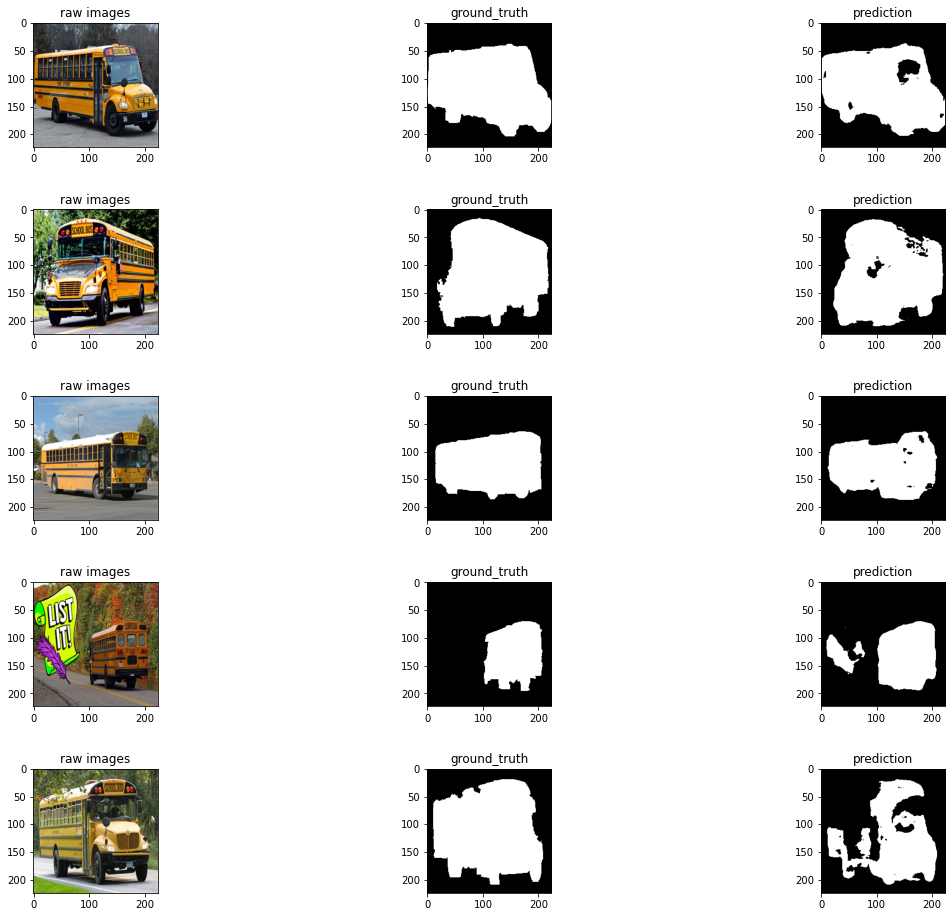

In [16]:
plot_batch_mask(input_embedding_for_plot, val_prediction, input_mask_for_plot)

In [17]:
experiment_number = config.experiment.number
experiment_description = config.experiment.description
experiment_root_path = os.path.join("leo_segmentation", "data", "models", f"experiment_{experiment_number}")
cached_files = os.listdir(experiment_root_path)
cached_files

['experiment_meta_test_11_ious.pkl',
 'experiment_meta_test_11_stats.pkl',
 'experiment_meta_train_11_ious.pkl',
 'experiment_meta_train_11_stats.pkl',
 'experiment_meta_val_11_ious.pkl',
 'experiment_meta_val_11_stats.pkl',
 'train_log.txt',
 'val_log.txt']

In [19]:
filename = cached_files[4]
val_ious = pd.read_pickle(os.path.join(experiment_root_path, filename)).T
print(f"filename: {filename}")
filtered_scores = []
for _class, _df in val_ious.iterrows():
    if _class == "episode":
        continue
    temp = [i for i in _df if not np.isnan(i)]
    class_sampling_frequency = len(temp)
    mean_of_all_ious_per_class = np.mean(temp)
    filtered_scores.append((_class, mean_of_all_ious_per_class, class_sampling_frequency))
filtered_val_ious = pd.DataFrame(filtered_scores, columns=["classes", "mean_val_ious", "class_sampling_frequency"])
filtered_val_ious = filtered_val_ious.sort_values(by="mean_val_ious", ascending=False)
filtered_val_ious[filtered_val_ious.mean_val_ious > 0.7].count()
filtered_val_ious

filename: experiment_meta_val_11_ious.pkl


,classes,mean_val_ious,class_sampling_frequency
83,rubick_cube,0.892771,29
48,ringlet_butterfly,0.891844,36
159,sealion,0.879872,27
195,pinecone,0.871816,22
100,polar_bear,0.868767,29
193,raven,0.868353,24
78,pickup,0.866202,27
118,seal,0.863465,31
138,pumpkin,0.858142,25
145,skull,0.853734,21


In [ ]:
os.listdir("leo_segmentation/data/fss1000/images")[600:800]

In [ ]:
filtered_val_ious.class_sampling_frequency.max()

In [ ]:
train_ious = pd.read_pickle(os.path.join(experiment_root_path, cached_files[2])).T
filtered_scores = []
for _class, _df in train_ious.iterrows():
    if _class == "episode":
        continue
    temp = [i for i in _df if not np.isnan(i)]
    class_sampling_frequency = len(temp)
    mean_of_all_ious_per_class = np.mean(temp)
    filtered_scores.append((_class, mean_of_all_ious_per_class, class_sampling_frequency))
filtered_train_ious = pd.DataFrame(filtered_scores, columns=["classes", "mean_train_ious", "class_sampling_frequency"])
filtered_train_ious = filtered_train_ious.sort_values(by="mean_train_ious", ascending=False)

In [ ]:
#classes in meta-train and meta-val are unique if their intersection is zero
set(filtered_train_ious.classes.unique()).intersection(set(filtered_val_ious.classes.unique()))

In [ ]:
meta_val_loss = pd.read_pickle(os.path.join(experiment_root_path, cached_files[5]))
meta_train_loss = pd.read_pickle(os.path.join(experiment_root_path, cached_files[3]))
num_data_points = meta_val_loss.shape[0]

In [ ]:
fig = plt.figure(figsize=(10, 8))
plt.title("meta_losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(np.arange(num_data_points), meta_val_loss.total_val_loss, label="meta_val_loss")
plt.plot(np.arange(num_data_points), meta_train_loss.total_val_loss, label="meta_train_loss")
plt.legend()